# Libraries

In [1]:
# project_path = 'put_your_project_path_here'
project_path = '../../'

In [2]:
import sys
sys.path.insert(1, project_path)   # caution: path[0] is reserved for script path (or '' in REPL)

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_RBF_eval
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Loading Dataset

In [3]:
X, y, ID = data_loader.load_dataset(X_path='../../data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='../../data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='../../data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.09202027320861816ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

# Backward step selection

In [8]:
def back_step_selection_svm_rbf(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_RBF_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind).astype(np.float)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu,_,_,_,_ = SVM_RBF_eval(X,y,cur_inds, ID)                  
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
            print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
            
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr,_,_,y_pred,y_true = SVM_RBF_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind,y_pred,y_true

## Full cycle of feature selection

  0%|          | 0/302 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/302 [00:09<46:22,  9.24s/it]

Iter =  1  UAR = 0.5000
UAR = 0.500


  1%|          | 2/302 [00:19<49:59, 10.00s/it]

UAR = 0.500


  1%|          | 3/302 [00:31<53:23, 10.71s/it]

UAR = 0.500


  1%|▏         | 4/302 [00:43<55:37, 11.20s/it]

UAR = 0.500


  2%|▏         | 5/302 [00:54<56:08, 11.34s/it]

UAR = 0.505
Iter =  5  UAR = 0.5052
UAR = 0.500


  2%|▏         | 6/302 [01:06<56:50, 11.52s/it]

UAR = 0.505
UAR = 0.500


  2%|▏         | 7/302 [01:18<57:04, 11.61s/it]

UAR = 0.502
UAR = 0.514
Iter =  7  UAR = 0.5136
UAR = 0.500
UAR = 0.503
UAR = 0.505


  3%|▎         | 8/302 [01:30<57:21, 11.70s/it]

UAR = 0.507
UAR = 0.522
Iter =  8  UAR = 0.5224
UAR = 0.500
UAR = 0.505


  3%|▎         | 9/302 [01:42<57:23, 11.75s/it]

UAR = 0.506
UAR = 0.531
Iter =  9  UAR = 0.5308
UAR = 0.500
UAR = 0.505
UAR = 0.506


  3%|▎         | 10/302 [01:54<57:36, 11.84s/it]

UAR = 0.513
UAR = 0.537
Iter =  10  UAR = 0.5373
UAR = 0.500
UAR = 0.504
UAR = 0.510


  4%|▎         | 11/302 [02:06<57:52, 11.93s/it]

UAR = 0.522
UAR = 0.537
UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.519


  4%|▍         | 12/302 [02:18<58:20, 12.07s/it]

UAR = 0.533
UAR = 0.572
Iter =  12  UAR = 0.5715
UAR = 0.500
UAR = 0.505
UAR = 0.522
UAR = 0.544


  4%|▍         | 13/302 [02:31<58:41, 12.18s/it]

UAR = 0.551
UAR = 0.584
Iter =  13  UAR = 0.5835
UAR = 0.500
UAR = 0.513
UAR = 0.538
UAR = 0.551
UAR = 0.567


  5%|▍         | 14/302 [02:43<59:03, 12.30s/it]

UAR = 0.568
UAR = 0.583
UAR = 0.500
UAR = 0.512
UAR = 0.549
UAR = 0.555
UAR = 0.570


  5%|▍         | 15/302 [02:56<59:30, 12.44s/it]

UAR = 0.581
UAR = 0.590
Iter =  15  UAR = 0.5901
UAR = 0.500
UAR = 0.503
UAR = 0.538
UAR = 0.557
UAR = 0.578
UAR = 0.595


  5%|▌         | 16/302 [03:08<58:34, 12.29s/it]

UAR = 0.606
UAR = 0.618
Iter =  16  UAR = 0.6180
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.538
UAR = 0.569
UAR = 0.593
UAR = 0.602


  6%|▌         | 17/302 [03:20<58:07, 12.24s/it]

UAR = 0.604
UAR = 0.617
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.549
UAR = 0.572
UAR = 0.590
UAR = 0.602


  6%|▌         | 18/302 [03:33<58:06, 12.28s/it]

UAR = 0.613
UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.541
UAR = 0.569
UAR = 0.589
UAR = 0.599
UAR = 0.599
UAR = 0.612


  6%|▋         | 19/302 [03:45<58:16, 12.36s/it]

UAR = 0.620
Iter =  19  UAR = 0.6200
UAR = 0.500
UAR = 0.516
UAR = 0.529
UAR = 0.553
UAR = 0.579
UAR = 0.606
UAR = 0.610
UAR = 0.614
UAR = 0.622


  7%|▋         | 20/302 [03:58<58:46, 12.51s/it]

UAR = 0.638
Iter =  20  UAR = 0.6380
UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.539
UAR = 0.562
UAR = 0.578
UAR = 0.599
UAR = 0.615


  7%|▋         | 21/302 [04:11<59:15, 12.65s/it]

UAR = 0.630
UAR = 0.650
Iter =  21  UAR = 0.6500
UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.549
UAR = 0.568
UAR = 0.582
UAR = 0.590
UAR = 0.609
UAR = 0.629


  7%|▋         | 22/302 [04:24<59:42, 12.80s/it]

UAR = 0.643
UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.554
UAR = 0.571
UAR = 0.584
UAR = 0.590
UAR = 0.626
UAR = 0.639
UAR = 0.650


  8%|▊         | 23/302 [05:41<2:29:09, 32.08s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.516
UAR = 0.557
UAR = 0.568
UAR = 0.588
UAR = 0.594
UAR = 0.624
UAR = 0.631


  8%|▊         | 24/302 [05:55<2:02:38, 26.47s/it]

UAR = 0.646
UAR = 0.500
UAR = 0.503
UAR = 0.516
UAR = 0.559
UAR = 0.574
UAR = 0.590
UAR = 0.605
UAR = 0.620
UAR = 0.627


  8%|▊         | 25/302 [06:08<1:44:13, 22.58s/it]

UAR = 0.635
UAR = 0.642
UAR = 0.500
UAR = 0.505
UAR = 0.513
UAR = 0.521
UAR = 0.566
UAR = 0.576
UAR = 0.595
UAR = 0.601
UAR = 0.620
UAR = 0.637


  9%|▊         | 26/302 [06:22<1:31:40, 19.93s/it]

UAR = 0.650
UAR = 0.500
UAR = 0.510
UAR = 0.526
UAR = 0.563
UAR = 0.574
UAR = 0.588
UAR = 0.603
UAR = 0.617
UAR = 0.629
UAR = 0.630
UAR = 0.654


  9%|▉         | 27/302 [06:36<1:23:01, 18.11s/it]

Iter =  27  UAR = 0.6538
UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.526
UAR = 0.566
UAR = 0.574
UAR = 0.596
UAR = 0.603
UAR = 0.638
UAR = 0.643
UAR = 0.649
UAR = 0.660


  9%|▉         | 28/302 [06:50<1:17:18, 16.93s/it]

Iter =  28  UAR = 0.6605
UAR = 0.500
UAR = 0.510
UAR = 0.518
UAR = 0.528
UAR = 0.561
UAR = 0.574
UAR = 0.588
UAR = 0.607
UAR = 0.634
UAR = 0.647
UAR = 0.654
UAR = 0.671


 10%|▉         | 29/302 [07:04<1:13:32, 16.16s/it]

Iter =  29  UAR = 0.6713
UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.526
UAR = 0.566
UAR = 0.573
UAR = 0.590
UAR = 0.611
UAR = 0.639
UAR = 0.644
UAR = 0.658


 10%|▉         | 30/302 [07:19<1:11:05, 15.68s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.526
UAR = 0.560
UAR = 0.570
UAR = 0.589
UAR = 0.611
UAR = 0.632
UAR = 0.642


 10%|█         | 31/302 [07:34<1:09:41, 15.43s/it]

UAR = 0.651
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.558
UAR = 0.573
UAR = 0.592
UAR = 0.607
UAR = 0.630
UAR = 0.635
UAR = 0.646
UAR = 0.656


 11%|█         | 32/302 [07:47<1:06:34, 14.80s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.528
UAR = 0.558
UAR = 0.574
UAR = 0.590
UAR = 0.600
UAR = 0.638
UAR = 0.662


 11%|█         | 33/302 [08:00<1:04:25, 14.37s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.528
UAR = 0.558
UAR = 0.576
UAR = 0.588
UAR = 0.605
UAR = 0.638
UAR = 0.654
UAR = 0.655


 11%|█▏        | 34/302 [08:14<1:03:13, 14.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.565
UAR = 0.578
UAR = 0.588
UAR = 0.588
UAR = 0.609
UAR = 0.630
UAR = 0.634
UAR = 0.654


 12%|█▏        | 35/302 [08:28<1:02:42, 14.09s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.546
UAR = 0.563
UAR = 0.581
UAR = 0.583
UAR = 0.599
UAR = 0.614
UAR = 0.636
UAR = 0.640
UAR = 0.653


 12%|█▏        | 36/302 [09:48<2:30:54, 34.04s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.548
UAR = 0.568
UAR = 0.588
UAR = 0.600
UAR = 0.615
UAR = 0.645
UAR = 0.667


 12%|█▏        | 37/302 [10:03<2:04:11, 28.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.548
UAR = 0.568
UAR = 0.586
UAR = 0.588
UAR = 0.601
UAR = 0.629
UAR = 0.642
UAR = 0.646
UAR = 0.664


 13%|█▎        | 38/302 [10:17<1:45:45, 24.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.548
UAR = 0.565
UAR = 0.589
UAR = 0.605
UAR = 0.625
UAR = 0.644
UAR = 0.653
UAR = 0.661


 13%|█▎        | 39/302 [10:32<1:33:04, 21.23s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.548
UAR = 0.563
UAR = 0.586
UAR = 0.589
UAR = 0.608
UAR = 0.627
UAR = 0.648
UAR = 0.653
UAR = 0.663


 13%|█▎        | 40/302 [11:52<2:49:17, 38.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.548
UAR = 0.568
UAR = 0.586
UAR = 0.588
UAR = 0.603
UAR = 0.622
UAR = 0.643
UAR = 0.656


 14%|█▎        | 41/302 [12:07<2:17:39, 31.64s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.553
UAR = 0.576
UAR = 0.591
UAR = 0.592
UAR = 0.597
UAR = 0.625
UAR = 0.639
UAR = 0.653
UAR = 0.665


 14%|█▍        | 42/302 [12:22<1:55:44, 26.71s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.559
UAR = 0.571
UAR = 0.591
UAR = 0.605
UAR = 0.624
UAR = 0.640
UAR = 0.657
UAR = 0.658


 14%|█▍        | 43/302 [12:37<1:40:44, 23.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.556
UAR = 0.569
UAR = 0.591
UAR = 0.597
UAR = 0.631
UAR = 0.638
UAR = 0.658
UAR = 0.665


 15%|█▍        | 44/302 [12:53<1:30:39, 21.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.554
UAR = 0.577
UAR = 0.588
UAR = 0.590
UAR = 0.603
UAR = 0.630
UAR = 0.639
UAR = 0.657
UAR = 0.664


 15%|█▍        | 45/302 [13:09<1:23:40, 19.53s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.554
UAR = 0.574
UAR = 0.589
UAR = 0.590
UAR = 0.599
UAR = 0.629
UAR = 0.631
UAR = 0.652
UAR = 0.660


 15%|█▌        | 46/302 [13:25<1:19:08, 18.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.551
UAR = 0.574
UAR = 0.581
UAR = 0.587
UAR = 0.600
UAR = 0.620
UAR = 0.631
UAR = 0.643
UAR = 0.659


 16%|█▌        | 47/302 [13:42<1:16:08, 17.91s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.553
UAR = 0.568
UAR = 0.581
UAR = 0.589
UAR = 0.600
UAR = 0.620
UAR = 0.626
UAR = 0.640
UAR = 0.656


 16%|█▌        | 48/302 [13:57<1:12:09, 17.04s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.556
UAR = 0.568
UAR = 0.586
UAR = 0.586
UAR = 0.598
UAR = 0.620
UAR = 0.623
UAR = 0.636
UAR = 0.650


 16%|█▌        | 49/302 [14:12<1:09:30, 16.48s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.556
UAR = 0.571
UAR = 0.588
UAR = 0.604
UAR = 0.629
UAR = 0.637
UAR = 0.646
UAR = 0.661


 17%|█▋        | 50/302 [14:27<1:07:54, 16.17s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.516
UAR = 0.556
UAR = 0.571
UAR = 0.585
UAR = 0.586
UAR = 0.604
UAR = 0.636
UAR = 0.638
UAR = 0.645
UAR = 0.647


 17%|█▋        | 51/302 [14:43<1:07:06, 16.04s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.553
UAR = 0.573
UAR = 0.583
UAR = 0.586
UAR = 0.605
UAR = 0.629
UAR = 0.634
UAR = 0.641


 17%|█▋        | 52/302 [14:59<1:06:42, 16.01s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.556
UAR = 0.573
UAR = 0.575
UAR = 0.581
UAR = 0.606
UAR = 0.629
UAR = 0.640
UAR = 0.644


 18%|█▊        | 53/302 [15:15<1:06:44, 16.08s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.523
UAR = 0.551
UAR = 0.573
UAR = 0.575
UAR = 0.584
UAR = 0.603
UAR = 0.625
UAR = 0.625
UAR = 0.636


 18%|█▊        | 54/302 [15:32<1:06:59, 16.21s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.523
UAR = 0.547
UAR = 0.560
UAR = 0.567
UAR = 0.575
UAR = 0.581
UAR = 0.600
UAR = 0.625
UAR = 0.638


 18%|█▊        | 55/302 [15:49<1:07:26, 16.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.523
UAR = 0.548
UAR = 0.555
UAR = 0.564
UAR = 0.569
UAR = 0.583
UAR = 0.601
UAR = 0.632
UAR = 0.635
UAR = 0.637


 19%|█▊        | 56/302 [16:05<1:07:42, 16.52s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.550
UAR = 0.557
UAR = 0.565
UAR = 0.572
UAR = 0.586
UAR = 0.605
UAR = 0.630
UAR = 0.633


 19%|█▉        | 57/302 [16:23<1:08:16, 16.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.543
UAR = 0.552
UAR = 0.560
UAR = 0.572
UAR = 0.581
UAR = 0.613
UAR = 0.638


 19%|█▉        | 58/302 [16:40<1:08:54, 16.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.523
UAR = 0.548
UAR = 0.550
UAR = 0.562
UAR = 0.567
UAR = 0.576
UAR = 0.622
UAR = 0.638


 20%|█▉        | 59/302 [16:58<1:09:33, 17.18s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.548
UAR = 0.563
UAR = 0.571
UAR = 0.584
UAR = 0.621
UAR = 0.637
UAR = 0.642


 20%|█▉        | 60/302 [17:16<1:10:19, 17.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.550
UAR = 0.563
UAR = 0.569
UAR = 0.585
UAR = 0.623
UAR = 0.634
UAR = 0.644


 20%|██        | 61/302 [17:34<1:10:57, 17.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.548
UAR = 0.565
UAR = 0.578
UAR = 0.591
UAR = 0.622
UAR = 0.639
UAR = 0.650


 21%|██        | 62/302 [17:53<1:11:42, 17.93s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.551
UAR = 0.565
UAR = 0.573
UAR = 0.603
UAR = 0.629
UAR = 0.642


 21%|██        | 63/302 [18:11<1:12:23, 18.17s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.553
UAR = 0.571
UAR = 0.572
UAR = 0.597
UAR = 0.625
UAR = 0.639


 21%|██        | 64/302 [18:28<1:10:11, 17.70s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.553
UAR = 0.568
UAR = 0.568
UAR = 0.594
UAR = 0.629
UAR = 0.630
UAR = 0.646


 22%|██▏       | 65/302 [18:45<1:08:47, 17.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.553
UAR = 0.570
UAR = 0.573
UAR = 0.606
UAR = 0.634
UAR = 0.639
UAR = 0.641


 22%|██▏       | 66/302 [19:02<1:08:07, 17.32s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.550
UAR = 0.572
UAR = 0.574
UAR = 0.604
UAR = 0.634
UAR = 0.640
UAR = 0.642


 22%|██▏       | 67/302 [19:19<1:07:54, 17.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.552
UAR = 0.566
UAR = 0.579
UAR = 0.601
UAR = 0.633
UAR = 0.637
UAR = 0.650


 23%|██▎       | 68/302 [19:37<1:08:01, 17.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.555
UAR = 0.569
UAR = 0.586
UAR = 0.606
UAR = 0.626
UAR = 0.629
UAR = 0.650
UAR = 0.652


 23%|██▎       | 69/302 [19:55<1:08:30, 17.64s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.550
UAR = 0.570
UAR = 0.583
UAR = 0.610
UAR = 0.631
UAR = 0.634
UAR = 0.654


 23%|██▎       | 70/302 [20:14<1:09:23, 17.95s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.550
UAR = 0.565
UAR = 0.584
UAR = 0.612
UAR = 0.631
UAR = 0.635
UAR = 0.651


 24%|██▎       | 71/302 [20:33<1:10:20, 18.27s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.550
UAR = 0.565
UAR = 0.586
UAR = 0.620
UAR = 0.639
UAR = 0.647
UAR = 0.653


 24%|██▍       | 72/302 [20:52<1:11:07, 18.56s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.560
UAR = 0.565
UAR = 0.589
UAR = 0.616
UAR = 0.633
UAR = 0.647
UAR = 0.649
UAR = 0.656


 24%|██▍       | 73/302 [21:11<1:11:50, 18.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.560
UAR = 0.563
UAR = 0.592
UAR = 0.615
UAR = 0.636
UAR = 0.648
UAR = 0.651
UAR = 0.655


 25%|██▍       | 74/302 [21:31<1:12:43, 19.14s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.564
UAR = 0.565
UAR = 0.594
UAR = 0.612
UAR = 0.636
UAR = 0.647
UAR = 0.651
UAR = 0.658


 25%|██▍       | 75/302 [21:51<1:13:35, 19.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.542
UAR = 0.564
UAR = 0.579
UAR = 0.586
UAR = 0.623
UAR = 0.644
UAR = 0.649
UAR = 0.657
UAR = 0.667


 25%|██▌       | 76/302 [22:12<1:14:22, 19.74s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.542
UAR = 0.566
UAR = 0.579
UAR = 0.589
UAR = 0.622
UAR = 0.639
UAR = 0.648
UAR = 0.658
UAR = 0.662


 25%|██▌       | 77/302 [22:32<1:15:00, 20.00s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.542
UAR = 0.566
UAR = 0.574
UAR = 0.585
UAR = 0.620
UAR = 0.640
UAR = 0.649
UAR = 0.656


 26%|██▌       | 78/302 [22:53<1:15:43, 20.29s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.558
UAR = 0.565
UAR = 0.586
UAR = 0.612
UAR = 0.644
UAR = 0.648
UAR = 0.650


 26%|██▌       | 79/302 [23:15<1:16:26, 20.57s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.556
UAR = 0.565
UAR = 0.586
UAR = 0.610
UAR = 0.644
UAR = 0.648
UAR = 0.651


 26%|██▋       | 80/302 [23:33<1:13:53, 19.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.553
UAR = 0.568
UAR = 0.589
UAR = 0.609
UAR = 0.636
UAR = 0.644
UAR = 0.654


 27%|██▋       | 81/302 [23:52<1:12:16, 19.62s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.550
UAR = 0.565
UAR = 0.566
UAR = 0.589
UAR = 0.610
UAR = 0.642
UAR = 0.652
UAR = 0.654


 27%|██▋       | 82/302 [24:11<1:11:20, 19.46s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.553
UAR = 0.563
UAR = 0.566
UAR = 0.592
UAR = 0.609
UAR = 0.643
UAR = 0.655
UAR = 0.656


 27%|██▋       | 83/302 [24:30<1:10:48, 19.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.556
UAR = 0.568
UAR = 0.586
UAR = 0.610
UAR = 0.637
UAR = 0.643
UAR = 0.662


 28%|██▊       | 84/302 [24:50<1:10:54, 19.51s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.561
UAR = 0.568
UAR = 0.586
UAR = 0.613
UAR = 0.634
UAR = 0.652


 28%|██▊       | 85/302 [25:10<1:11:33, 19.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.561
UAR = 0.568
UAR = 0.591
UAR = 0.617
UAR = 0.634
UAR = 0.645
UAR = 0.653


 28%|██▊       | 86/302 [25:31<1:12:14, 20.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.561
UAR = 0.565
UAR = 0.596
UAR = 0.615
UAR = 0.632
UAR = 0.640
UAR = 0.653


 29%|██▉       | 87/302 [25:52<1:12:52, 20.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.561
UAR = 0.599
UAR = 0.618
UAR = 0.633
UAR = 0.646
UAR = 0.657


 29%|██▉       | 88/302 [26:13<1:13:13, 20.53s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.559
UAR = 0.560
UAR = 0.564
UAR = 0.602
UAR = 0.621
UAR = 0.629
UAR = 0.642
UAR = 0.655


 29%|██▉       | 89/302 [26:35<1:13:46, 20.78s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.559
UAR = 0.564
UAR = 0.594
UAR = 0.614
UAR = 0.630
UAR = 0.643
UAR = 0.656


 30%|██▉       | 90/302 [26:56<1:14:31, 21.09s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.559
UAR = 0.564
UAR = 0.599
UAR = 0.611
UAR = 0.633
UAR = 0.642
UAR = 0.657


 30%|███       | 91/302 [27:18<1:15:13, 21.39s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.556
UAR = 0.560
UAR = 0.564
UAR = 0.602
UAR = 0.619
UAR = 0.633
UAR = 0.642
UAR = 0.662


 30%|███       | 92/302 [27:41<1:15:50, 21.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.556
UAR = 0.560
UAR = 0.561
UAR = 0.605
UAR = 0.615
UAR = 0.635
UAR = 0.647
UAR = 0.667


 31%|███       | 93/302 [28:03<1:16:22, 21.93s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.542
UAR = 0.559
UAR = 0.560
UAR = 0.561
UAR = 0.601
UAR = 0.619
UAR = 0.632
UAR = 0.639
UAR = 0.662


 31%|███       | 94/302 [28:26<1:17:07, 22.25s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.542
UAR = 0.561
UAR = 0.569
UAR = 0.598
UAR = 0.613
UAR = 0.629
UAR = 0.640
UAR = 0.653


 31%|███▏      | 95/302 [28:50<1:18:00, 22.61s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.559
UAR = 0.560
UAR = 0.571
UAR = 0.601
UAR = 0.619
UAR = 0.631
UAR = 0.634
UAR = 0.655


 32%|███▏      | 96/302 [29:10<1:15:26, 21.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.542
UAR = 0.556
UAR = 0.560
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.626
UAR = 0.645
UAR = 0.660


 32%|███▏      | 97/302 [29:31<1:13:53, 21.62s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.561
UAR = 0.564
UAR = 0.574
UAR = 0.600
UAR = 0.621
UAR = 0.628
UAR = 0.651
UAR = 0.660


 32%|███▏      | 98/302 [29:52<1:12:57, 21.46s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.561
UAR = 0.564
UAR = 0.577
UAR = 0.600
UAR = 0.624
UAR = 0.629
UAR = 0.634
UAR = 0.653
UAR = 0.654


 33%|███▎      | 99/302 [30:13<1:12:31, 21.44s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.564
UAR = 0.574
UAR = 0.605
UAR = 0.627
UAR = 0.627
UAR = 0.630
UAR = 0.667


 33%|███▎      | 100/302 [30:35<1:12:33, 21.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.564
UAR = 0.574
UAR = 0.605
UAR = 0.624
UAR = 0.626
UAR = 0.637
UAR = 0.664


 33%|███▎      | 101/302 [30:58<1:13:05, 21.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.567
UAR = 0.574
UAR = 0.604
UAR = 0.629
UAR = 0.637
UAR = 0.658
UAR = 0.661


 34%|███▍      | 102/302 [31:20<1:13:23, 22.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.561
UAR = 0.564
UAR = 0.577
UAR = 0.604
UAR = 0.628
UAR = 0.633
UAR = 0.658
UAR = 0.660


 34%|███▍      | 103/302 [31:43<1:13:52, 22.27s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.567
UAR = 0.574
UAR = 0.602
UAR = 0.627
UAR = 0.634
UAR = 0.660
UAR = 0.662


 34%|███▍      | 104/302 [32:07<1:14:41, 22.63s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.536
UAR = 0.567
UAR = 0.577
UAR = 0.604
UAR = 0.624
UAR = 0.628
UAR = 0.665


 35%|███▍      | 105/302 [32:30<1:15:21, 22.95s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.567
UAR = 0.576
UAR = 0.603
UAR = 0.623
UAR = 0.627
UAR = 0.637
UAR = 0.659
UAR = 0.660


 35%|███▌      | 106/302 [32:54<1:15:49, 23.21s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.533
UAR = 0.564
UAR = 0.574
UAR = 0.604
UAR = 0.624
UAR = 0.628
UAR = 0.637
UAR = 0.661


 35%|███▌      | 107/302 [33:19<1:16:55, 23.67s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.564
UAR = 0.574
UAR = 0.606
UAR = 0.624
UAR = 0.624
UAR = 0.637
UAR = 0.657


 36%|███▌      | 108/302 [33:44<1:17:49, 24.07s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.561
UAR = 0.577
UAR = 0.609
UAR = 0.624
UAR = 0.626
UAR = 0.640
UAR = 0.662


 36%|███▌      | 109/302 [34:09<1:18:35, 24.43s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.559
UAR = 0.576
UAR = 0.608
UAR = 0.626
UAR = 0.643
UAR = 0.656


 36%|███▋      | 110/302 [34:35<1:19:33, 24.86s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.556
UAR = 0.576
UAR = 0.611
UAR = 0.627
UAR = 0.640
UAR = 0.661


 37%|███▋      | 111/302 [35:01<1:20:25, 25.27s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.553
UAR = 0.571
UAR = 0.606
UAR = 0.628
UAR = 0.644
UAR = 0.658


 37%|███▋      | 112/302 [35:24<1:17:37, 24.52s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.556
UAR = 0.571
UAR = 0.608
UAR = 0.620
UAR = 0.638
UAR = 0.655


 37%|███▋      | 113/302 [35:47<1:16:04, 24.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.536
UAR = 0.556
UAR = 0.571
UAR = 0.608
UAR = 0.616
UAR = 0.617
UAR = 0.636
UAR = 0.655


 38%|███▊      | 114/302 [36:11<1:15:20, 24.05s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.556
UAR = 0.574
UAR = 0.611
UAR = 0.632
UAR = 0.641
UAR = 0.660


 38%|███▊      | 115/302 [36:35<1:14:54, 24.03s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.554
UAR = 0.573
UAR = 0.613
UAR = 0.632
UAR = 0.641
UAR = 0.660


 38%|███▊      | 116/302 [37:00<1:15:08, 24.24s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.551
UAR = 0.576
UAR = 0.611
UAR = 0.626
UAR = 0.636
UAR = 0.657


 39%|███▊      | 117/302 [37:25<1:15:33, 24.51s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.554
UAR = 0.576
UAR = 0.611
UAR = 0.619
UAR = 0.622
UAR = 0.641
UAR = 0.658


 39%|███▉      | 118/302 [37:50<1:15:59, 24.78s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.536
UAR = 0.554
UAR = 0.576
UAR = 0.613
UAR = 0.627
UAR = 0.634
UAR = 0.647
UAR = 0.650


 39%|███▉      | 119/302 [38:16<1:16:36, 25.12s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.556
UAR = 0.577
UAR = 0.610
UAR = 0.621
UAR = 0.631
UAR = 0.649
UAR = 0.650


 40%|███▉      | 120/302 [38:42<1:16:45, 25.31s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.536
UAR = 0.556
UAR = 0.574
UAR = 0.614
UAR = 0.623
UAR = 0.641
UAR = 0.650
UAR = 0.653


 40%|████      | 121/302 [39:08<1:17:25, 25.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.551
UAR = 0.576
UAR = 0.604
UAR = 0.623
UAR = 0.640
UAR = 0.650


 40%|████      | 122/302 [39:35<1:17:51, 25.95s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.551
UAR = 0.576
UAR = 0.603
UAR = 0.626
UAR = 0.637
UAR = 0.650


 41%|████      | 123/302 [40:02<1:18:31, 26.32s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.534
UAR = 0.556
UAR = 0.578
UAR = 0.605
UAR = 0.623
UAR = 0.640
UAR = 0.646
UAR = 0.647


 41%|████      | 124/302 [40:30<1:18:59, 26.62s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.534
UAR = 0.554
UAR = 0.575
UAR = 0.605
UAR = 0.625
UAR = 0.645


 41%|████▏     | 125/302 [40:57<1:19:34, 26.98s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.534
UAR = 0.549
UAR = 0.572
UAR = 0.607
UAR = 0.620
UAR = 0.637


 42%|████▏     | 126/302 [41:25<1:20:00, 27.28s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.534
UAR = 0.549
UAR = 0.573
UAR = 0.607
UAR = 0.612
UAR = 0.615
UAR = 0.637


 42%|████▏     | 127/302 [41:54<1:20:32, 27.61s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.549
UAR = 0.573
UAR = 0.604
UAR = 0.612
UAR = 0.615
UAR = 0.640


 42%|████▏     | 128/302 [42:19<1:17:46, 26.82s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.534
UAR = 0.549
UAR = 0.573
UAR = 0.607
UAR = 0.613
UAR = 0.616
UAR = 0.635
UAR = 0.635


 43%|████▎     | 129/302 [42:44<1:15:51, 26.31s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.554
UAR = 0.573
UAR = 0.610
UAR = 0.620
UAR = 0.640


 43%|████▎     | 130/302 [43:09<1:14:44, 26.07s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.554
UAR = 0.575
UAR = 0.610
UAR = 0.618
UAR = 0.635
UAR = 0.640


 43%|████▎     | 131/302 [43:35<1:14:09, 26.02s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.531
UAR = 0.551
UAR = 0.578
UAR = 0.612
UAR = 0.623
UAR = 0.638
UAR = 0.643


 44%|████▎     | 132/302 [44:02<1:14:08, 26.17s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.531
UAR = 0.543
UAR = 0.575
UAR = 0.604
UAR = 0.621
UAR = 0.638
UAR = 0.643


 44%|████▍     | 133/302 [44:29<1:14:22, 26.40s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.530
UAR = 0.541
UAR = 0.578
UAR = 0.607
UAR = 0.623
UAR = 0.638
UAR = 0.641


 44%|████▍     | 134/302 [44:56<1:14:38, 26.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.530
UAR = 0.538
UAR = 0.578
UAR = 0.605
UAR = 0.624
UAR = 0.644


 45%|████▍     | 135/302 [45:24<1:14:58, 26.94s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.530
UAR = 0.538
UAR = 0.576
UAR = 0.608
UAR = 0.621
UAR = 0.647


 45%|████▌     | 136/302 [45:51<1:15:13, 27.19s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.530
UAR = 0.538
UAR = 0.576
UAR = 0.607
UAR = 0.625
UAR = 0.642


 45%|████▌     | 137/302 [46:20<1:15:36, 27.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.530
UAR = 0.538
UAR = 0.576
UAR = 0.610
UAR = 0.623
UAR = 0.642


 46%|████▌     | 138/302 [46:48<1:16:01, 27.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.530
UAR = 0.538
UAR = 0.578
UAR = 0.610
UAR = 0.625
UAR = 0.638
UAR = 0.641


 46%|████▌     | 139/302 [47:17<1:16:29, 28.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.530
UAR = 0.541
UAR = 0.578
UAR = 0.610
UAR = 0.625
UAR = 0.638
UAR = 0.641


 46%|████▋     | 140/302 [47:46<1:16:54, 28.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.530
UAR = 0.541
UAR = 0.581
UAR = 0.610
UAR = 0.620
UAR = 0.622
UAR = 0.638
UAR = 0.644


 47%|████▋     | 141/302 [48:16<1:17:24, 28.85s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.538
UAR = 0.583
UAR = 0.613
UAR = 0.626
UAR = 0.638
UAR = 0.644


 47%|████▋     | 142/302 [48:46<1:17:45, 29.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.546
UAR = 0.578
UAR = 0.610
UAR = 0.626
UAR = 0.629
UAR = 0.645


 47%|████▋     | 143/302 [49:16<1:18:16, 29.54s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.543
UAR = 0.578
UAR = 0.610
UAR = 0.623
UAR = 0.626
UAR = 0.645


 48%|████▊     | 144/302 [49:43<1:15:29, 28.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.538
UAR = 0.578
UAR = 0.604
UAR = 0.627
UAR = 0.634
UAR = 0.647


 48%|████▊     | 145/302 [50:10<1:13:56, 28.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.533
UAR = 0.538
UAR = 0.578
UAR = 0.607
UAR = 0.630
UAR = 0.647


 48%|████▊     | 146/302 [50:38<1:13:02, 28.10s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.533
UAR = 0.578
UAR = 0.607
UAR = 0.630
UAR = 0.631
UAR = 0.649


 49%|████▊     | 147/302 [51:06<1:12:28, 28.05s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.533
UAR = 0.578
UAR = 0.607
UAR = 0.630
UAR = 0.633
UAR = 0.649


 49%|████▉     | 148/302 [51:34<1:12:09, 28.11s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.533
UAR = 0.581
UAR = 0.607
UAR = 0.629
UAR = 0.634
UAR = 0.647


 49%|████▉     | 149/302 [52:03<1:12:09, 28.30s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.533
UAR = 0.578
UAR = 0.605
UAR = 0.628
UAR = 0.635
UAR = 0.647


 50%|████▉     | 150/302 [52:32<1:12:26, 28.59s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.533
UAR = 0.581
UAR = 0.608
UAR = 0.631
UAR = 0.637
UAR = 0.650


 50%|█████     | 151/302 [53:02<1:12:41, 28.88s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.533
UAR = 0.583
UAR = 0.605
UAR = 0.629
UAR = 0.637
UAR = 0.644


 50%|█████     | 152/302 [53:31<1:12:37, 29.05s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.538
UAR = 0.583
UAR = 0.608
UAR = 0.623
UAR = 0.633
UAR = 0.647


 51%|█████     | 153/302 [54:01<1:12:55, 29.37s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.538
UAR = 0.583
UAR = 0.608
UAR = 0.623
UAR = 0.636
UAR = 0.647


 51%|█████     | 154/302 [54:32<1:13:09, 29.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.538
UAR = 0.583
UAR = 0.605
UAR = 0.623
UAR = 0.633
UAR = 0.644


 51%|█████▏    | 155/302 [55:03<1:13:34, 30.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.543
UAR = 0.583
UAR = 0.604
UAR = 0.619
UAR = 0.625
UAR = 0.643
UAR = 0.650


 52%|█████▏    | 156/302 [55:34<1:13:44, 30.30s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.541
UAR = 0.581
UAR = 0.609
UAR = 0.617
UAR = 0.625
UAR = 0.641
UAR = 0.650


 52%|█████▏    | 157/302 [56:05<1:14:05, 30.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.541
UAR = 0.581
UAR = 0.609
UAR = 0.617
UAR = 0.619
UAR = 0.636
UAR = 0.647


 52%|█████▏    | 158/302 [56:37<1:14:20, 30.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.541
UAR = 0.578
UAR = 0.607
UAR = 0.615
UAR = 0.616
UAR = 0.633
UAR = 0.647


 53%|█████▎    | 159/302 [57:09<1:14:45, 31.36s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.528
UAR = 0.541
UAR = 0.578
UAR = 0.607
UAR = 0.615
UAR = 0.616
UAR = 0.631
UAR = 0.645


 53%|█████▎    | 160/302 [57:37<1:12:10, 30.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.543
UAR = 0.581
UAR = 0.608
UAR = 0.621
UAR = 0.625
UAR = 0.644
UAR = 0.646


 53%|█████▎    | 161/302 [58:07<1:10:39, 30.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.541
UAR = 0.578
UAR = 0.606
UAR = 0.620
UAR = 0.630
UAR = 0.644
UAR = 0.647


 54%|█████▎    | 162/302 [58:36<1:09:35, 29.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.541
UAR = 0.581
UAR = 0.609
UAR = 0.623
UAR = 0.629
UAR = 0.638
UAR = 0.646


 54%|█████▍    | 163/302 [59:05<1:08:59, 29.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.528
UAR = 0.536
UAR = 0.583
UAR = 0.612
UAR = 0.618
UAR = 0.626
UAR = 0.644
UAR = 0.647


 54%|█████▍    | 164/302 [59:35<1:08:36, 29.83s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.536
UAR = 0.581
UAR = 0.612
UAR = 0.618
UAR = 0.629
UAR = 0.641
UAR = 0.646


 55%|█████▍    | 165/302 [1:00:06<1:08:34, 30.04s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.538
UAR = 0.581
UAR = 0.614
UAR = 0.618
UAR = 0.629
UAR = 0.639
UAR = 0.646


 55%|█████▍    | 166/302 [1:00:37<1:08:31, 30.24s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.541
UAR = 0.581
UAR = 0.612
UAR = 0.618
UAR = 0.629
UAR = 0.637
UAR = 0.644


 55%|█████▌    | 167/302 [1:01:08<1:08:35, 30.48s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.528
UAR = 0.538
UAR = 0.581
UAR = 0.612
UAR = 0.616
UAR = 0.632
UAR = 0.639
UAR = 0.641


 56%|█████▌    | 168/302 [1:01:39<1:08:28, 30.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.533
UAR = 0.578
UAR = 0.612
UAR = 0.618
UAR = 0.632
UAR = 0.639
UAR = 0.641


 56%|█████▌    | 169/302 [1:02:10<1:08:34, 30.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.535
UAR = 0.578
UAR = 0.610
UAR = 0.613
UAR = 0.633
UAR = 0.639
UAR = 0.644


 56%|█████▋    | 170/302 [1:02:42<1:08:42, 31.23s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.536
UAR = 0.578
UAR = 0.607
UAR = 0.610
UAR = 0.634
UAR = 0.636
UAR = 0.641


 57%|█████▋    | 171/302 [1:03:15<1:08:58, 31.59s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.536
UAR = 0.578
UAR = 0.609
UAR = 0.610
UAR = 0.634
UAR = 0.635
UAR = 0.640


 57%|█████▋    | 172/302 [1:03:47<1:09:05, 31.89s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.536
UAR = 0.578
UAR = 0.612
UAR = 0.633
UAR = 0.638
UAR = 0.640


 57%|█████▋    | 173/302 [1:04:21<1:09:28, 32.31s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.536
UAR = 0.578
UAR = 0.611
UAR = 0.633
UAR = 0.638
UAR = 0.645


 58%|█████▊    | 174/302 [1:04:54<1:09:33, 32.60s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.535
UAR = 0.578
UAR = 0.613
UAR = 0.627
UAR = 0.640


 58%|█████▊    | 175/302 [1:05:28<1:09:50, 33.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.525
UAR = 0.535
UAR = 0.583
UAR = 0.604
UAR = 0.610
UAR = 0.627
UAR = 0.638


 58%|█████▊    | 176/302 [1:05:58<1:07:19, 32.06s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.525
UAR = 0.535
UAR = 0.586
UAR = 0.604
UAR = 0.607
UAR = 0.627
UAR = 0.638


 59%|█████▊    | 177/302 [1:06:28<1:05:58, 31.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.525
UAR = 0.535
UAR = 0.586
UAR = 0.604
UAR = 0.606
UAR = 0.628
UAR = 0.637
UAR = 0.640


 59%|█████▉    | 178/302 [1:06:59<1:04:57, 31.43s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.522
UAR = 0.535
UAR = 0.586
UAR = 0.604
UAR = 0.606
UAR = 0.628
UAR = 0.637
UAR = 0.642


 59%|█████▉    | 179/302 [1:07:31<1:04:21, 31.39s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.522
UAR = 0.533
UAR = 0.535
UAR = 0.591
UAR = 0.604
UAR = 0.606
UAR = 0.629
UAR = 0.645


 60%|█████▉    | 180/302 [1:08:02<1:03:48, 31.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.522
UAR = 0.530
UAR = 0.532
UAR = 0.591
UAR = 0.602
UAR = 0.609
UAR = 0.628
UAR = 0.643


 60%|█████▉    | 181/302 [1:08:34<1:03:44, 31.60s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.522
UAR = 0.530
UAR = 0.535
UAR = 0.583
UAR = 0.605
UAR = 0.609
UAR = 0.627
UAR = 0.639


 60%|██████    | 182/302 [1:09:06<1:03:34, 31.79s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.522
UAR = 0.530
UAR = 0.532
UAR = 0.583
UAR = 0.605
UAR = 0.610
UAR = 0.627
UAR = 0.636
UAR = 0.642


 61%|██████    | 183/302 [1:09:39<1:03:34, 32.06s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.522
UAR = 0.533
UAR = 0.581
UAR = 0.605
UAR = 0.610
UAR = 0.627
UAR = 0.639


 61%|██████    | 184/302 [1:10:12<1:03:22, 32.22s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.522
UAR = 0.533
UAR = 0.581
UAR = 0.605
UAR = 0.613
UAR = 0.627
UAR = 0.636
UAR = 0.638


 61%|██████▏   | 185/302 [1:10:45<1:03:23, 32.51s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.520
UAR = 0.527
UAR = 0.535
UAR = 0.583
UAR = 0.602
UAR = 0.613
UAR = 0.629
UAR = 0.635
UAR = 0.643


 62%|██████▏   | 186/302 [1:11:18<1:03:29, 32.84s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.520
UAR = 0.527
UAR = 0.532
UAR = 0.579
UAR = 0.602
UAR = 0.613
UAR = 0.625
UAR = 0.634
UAR = 0.637


 62%|██████▏   | 187/302 [1:11:52<1:03:34, 33.17s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.530
UAR = 0.537
UAR = 0.582
UAR = 0.602
UAR = 0.612
UAR = 0.623
UAR = 0.639
UAR = 0.640


 62%|██████▏   | 188/302 [1:12:26<1:03:29, 33.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.533
UAR = 0.537
UAR = 0.582
UAR = 0.602
UAR = 0.612
UAR = 0.623
UAR = 0.639


 63%|██████▎   | 189/302 [1:13:01<1:03:39, 33.80s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.533
UAR = 0.535
UAR = 0.582
UAR = 0.604
UAR = 0.609
UAR = 0.622
UAR = 0.639


 63%|██████▎   | 190/302 [1:13:36<1:03:44, 34.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.537
UAR = 0.580
UAR = 0.602
UAR = 0.611
UAR = 0.630
UAR = 0.638
UAR = 0.640


 63%|██████▎   | 191/302 [1:14:12<1:03:58, 34.58s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.525
UAR = 0.537
UAR = 0.580
UAR = 0.602
UAR = 0.605
UAR = 0.629
UAR = 0.634
UAR = 0.642


 64%|██████▎   | 192/302 [1:14:43<1:01:46, 33.69s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.525
UAR = 0.532
UAR = 0.580
UAR = 0.605
UAR = 0.605
UAR = 0.628
UAR = 0.637


 64%|██████▍   | 193/302 [1:15:15<1:00:25, 33.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.537
UAR = 0.577
UAR = 0.604
UAR = 0.626
UAR = 0.637


 64%|██████▍   | 194/302 [1:15:48<59:25, 33.02s/it]  

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.538
UAR = 0.576
UAR = 0.605
UAR = 0.628
UAR = 0.632
UAR = 0.634


 65%|██████▍   | 195/302 [1:16:21<58:45, 32.95s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.538
UAR = 0.577
UAR = 0.599
UAR = 0.603
UAR = 0.627
UAR = 0.632


 65%|██████▍   | 196/302 [1:16:53<58:07, 32.90s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.538
UAR = 0.577
UAR = 0.599
UAR = 0.605
UAR = 0.627
UAR = 0.632


 65%|██████▌   | 197/302 [1:17:27<57:51, 33.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.538
UAR = 0.585
UAR = 0.607
UAR = 0.631
UAR = 0.635


 66%|██████▌   | 198/302 [1:18:01<57:45, 33.32s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.540
UAR = 0.581
UAR = 0.607
UAR = 0.630
UAR = 0.640


 66%|██████▌   | 199/302 [1:18:35<57:45, 33.64s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.525
UAR = 0.540
UAR = 0.579
UAR = 0.607
UAR = 0.628
UAR = 0.640


 66%|██████▌   | 200/302 [1:19:09<57:26, 33.79s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.540
UAR = 0.579
UAR = 0.607
UAR = 0.627
UAR = 0.640


 67%|██████▋   | 201/302 [1:19:44<57:23, 34.09s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.540
UAR = 0.584
UAR = 0.607
UAR = 0.632
UAR = 0.640


 67%|██████▋   | 202/302 [1:20:19<57:18, 34.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.543
UAR = 0.582
UAR = 0.607
UAR = 0.632
UAR = 0.638


 67%|██████▋   | 203/302 [1:20:55<57:25, 34.80s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.543
UAR = 0.581
UAR = 0.607
UAR = 0.632
UAR = 0.638


 68%|██████▊   | 204/302 [1:21:30<57:10, 35.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.543
UAR = 0.579
UAR = 0.604
UAR = 0.606
UAR = 0.627
UAR = 0.638


 68%|██████▊   | 205/302 [1:22:07<57:13, 35.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.520
UAR = 0.523
UAR = 0.546
UAR = 0.576
UAR = 0.604
UAR = 0.627
UAR = 0.638


 68%|██████▊   | 206/302 [1:22:43<57:08, 35.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.520
UAR = 0.543
UAR = 0.576
UAR = 0.604
UAR = 0.626
UAR = 0.638


 69%|██████▊   | 207/302 [1:23:20<57:12, 36.13s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.538
UAR = 0.576
UAR = 0.604
UAR = 0.628
UAR = 0.636


 69%|██████▉   | 208/302 [1:23:53<55:05, 35.17s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.523
UAR = 0.540
UAR = 0.576
UAR = 0.603
UAR = 0.629
UAR = 0.636


 69%|██████▉   | 209/302 [1:24:27<53:50, 34.74s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.540
UAR = 0.576
UAR = 0.603
UAR = 0.626
UAR = 0.636


 70%|██████▉   | 210/302 [1:25:01<52:50, 34.46s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.540
UAR = 0.586
UAR = 0.605
UAR = 0.627
UAR = 0.639


 70%|██████▉   | 211/302 [1:25:35<52:13, 34.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.538
UAR = 0.583
UAR = 0.600
UAR = 0.605
UAR = 0.622
UAR = 0.638


 70%|███████   | 212/302 [1:26:09<51:34, 34.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.538
UAR = 0.586
UAR = 0.602
UAR = 0.603
UAR = 0.621
UAR = 0.633


 71%|███████   | 213/302 [1:26:45<51:19, 34.60s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.538
UAR = 0.589
UAR = 0.602
UAR = 0.603
UAR = 0.618
UAR = 0.635


 71%|███████   | 214/302 [1:27:20<51:03, 34.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.538
UAR = 0.583
UAR = 0.602
UAR = 0.603
UAR = 0.619
UAR = 0.630


 71%|███████   | 215/302 [1:27:55<50:49, 35.05s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.540
UAR = 0.580
UAR = 0.605
UAR = 0.619
UAR = 0.633


 72%|███████▏  | 216/302 [1:28:31<50:21, 35.14s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.540
UAR = 0.580
UAR = 0.605
UAR = 0.619
UAR = 0.633


 72%|███████▏  | 217/302 [1:29:07<50:17, 35.50s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.538
UAR = 0.580
UAR = 0.608
UAR = 0.617
UAR = 0.634


 72%|███████▏  | 218/302 [1:29:44<50:10, 35.84s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.517
UAR = 0.540
UAR = 0.583
UAR = 0.602
UAR = 0.603
UAR = 0.616
UAR = 0.636


 73%|███████▎  | 219/302 [1:30:21<50:09, 36.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.517
UAR = 0.538
UAR = 0.585
UAR = 0.606
UAR = 0.616
UAR = 0.636


 73%|███████▎  | 220/302 [1:30:58<49:55, 36.53s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.520
UAR = 0.520
UAR = 0.540
UAR = 0.585
UAR = 0.603
UAR = 0.605
UAR = 0.618
UAR = 0.633


 73%|███████▎  | 221/302 [1:31:36<49:55, 36.98s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.520
UAR = 0.543
UAR = 0.585
UAR = 0.605
UAR = 0.618
UAR = 0.630


 74%|███████▎  | 222/302 [1:32:15<49:51, 37.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.517
UAR = 0.543
UAR = 0.580
UAR = 0.602
UAR = 0.616
UAR = 0.630


 74%|███████▍  | 223/302 [1:32:54<49:51, 37.87s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.518
UAR = 0.543
UAR = 0.587
UAR = 0.603
UAR = 0.603
UAR = 0.618
UAR = 0.630


 74%|███████▍  | 224/302 [1:33:28<47:59, 36.91s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.518
UAR = 0.543
UAR = 0.583
UAR = 0.602
UAR = 0.605
UAR = 0.618
UAR = 0.630


 75%|███████▍  | 225/302 [1:34:04<46:50, 36.51s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.518
UAR = 0.543
UAR = 0.580
UAR = 0.603
UAR = 0.607
UAR = 0.619
UAR = 0.630


 75%|███████▍  | 226/302 [1:34:39<45:53, 36.23s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.543
UAR = 0.577
UAR = 0.602
UAR = 0.615
UAR = 0.629


 75%|███████▌  | 227/302 [1:35:16<45:15, 36.21s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.517
UAR = 0.518
UAR = 0.543
UAR = 0.583
UAR = 0.602
UAR = 0.620
UAR = 0.631


 75%|███████▌  | 228/302 [1:35:51<44:30, 36.09s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.518
UAR = 0.543
UAR = 0.583
UAR = 0.601
UAR = 0.622
UAR = 0.629


 76%|███████▌  | 229/302 [1:36:28<44:10, 36.31s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.517
UAR = 0.546
UAR = 0.585
UAR = 0.598
UAR = 0.617
UAR = 0.628


 76%|███████▌  | 230/302 [1:37:05<43:50, 36.53s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.543
UAR = 0.577
UAR = 0.599
UAR = 0.600
UAR = 0.617
UAR = 0.627


 76%|███████▋  | 231/302 [1:37:43<43:33, 36.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.546
UAR = 0.574
UAR = 0.598
UAR = 0.620
UAR = 0.627


 77%|███████▋  | 232/302 [1:38:20<43:02, 36.90s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.546
UAR = 0.574
UAR = 0.599
UAR = 0.620
UAR = 0.627


 77%|███████▋  | 233/302 [1:38:58<42:46, 37.20s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.543
UAR = 0.577
UAR = 0.598
UAR = 0.620
UAR = 0.627


 77%|███████▋  | 234/302 [1:39:36<42:29, 37.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.543
UAR = 0.577
UAR = 0.598
UAR = 0.620
UAR = 0.627


 78%|███████▊  | 235/302 [1:40:14<42:13, 37.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.543
UAR = 0.577
UAR = 0.598
UAR = 0.614
UAR = 0.626


 78%|███████▊  | 236/302 [1:40:53<41:45, 37.96s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.543
UAR = 0.577
UAR = 0.598
UAR = 0.617
UAR = 0.626


 78%|███████▊  | 237/302 [1:41:32<41:31, 38.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.546
UAR = 0.574
UAR = 0.596
UAR = 0.597
UAR = 0.617
UAR = 0.631


 79%|███████▉  | 238/302 [1:42:12<41:17, 38.71s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.545
UAR = 0.574
UAR = 0.596
UAR = 0.618
UAR = 0.630


 79%|███████▉  | 239/302 [1:42:52<41:05, 39.14s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.546
UAR = 0.574
UAR = 0.598
UAR = 0.618
UAR = 0.633


 79%|███████▉  | 240/302 [1:43:27<39:24, 38.14s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.546
UAR = 0.574
UAR = 0.595
UAR = 0.617
UAR = 0.633


 80%|███████▉  | 241/302 [1:44:04<38:20, 37.71s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.514
UAR = 0.540
UAR = 0.574
UAR = 0.592
UAR = 0.594
UAR = 0.617
UAR = 0.633


 80%|████████  | 242/302 [1:44:41<37:31, 37.52s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.514
UAR = 0.540
UAR = 0.574
UAR = 0.593
UAR = 0.594
UAR = 0.615
UAR = 0.633


 80%|████████  | 243/302 [1:45:19<36:55, 37.55s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.514
UAR = 0.540
UAR = 0.574
UAR = 0.590
UAR = 0.593
UAR = 0.615
UAR = 0.630


 81%|████████  | 244/302 [1:45:56<36:15, 37.50s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.514
UAR = 0.540
UAR = 0.574
UAR = 0.593
UAR = 0.614
UAR = 0.630


 81%|████████  | 245/302 [1:46:35<35:53, 37.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.514
UAR = 0.543
UAR = 0.574
UAR = 0.593
UAR = 0.617
UAR = 0.629


 81%|████████▏ | 246/302 [1:47:13<35:23, 37.92s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.514
UAR = 0.543
UAR = 0.574
UAR = 0.590
UAR = 0.591
UAR = 0.592
UAR = 0.614
UAR = 0.629


 82%|████████▏ | 247/302 [1:47:52<35:01, 38.20s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.543
UAR = 0.573
UAR = 0.590
UAR = 0.591
UAR = 0.593
UAR = 0.614
UAR = 0.629


 82%|████████▏ | 248/302 [1:48:30<34:25, 38.24s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.543
UAR = 0.573
UAR = 0.592
UAR = 0.593
UAR = 0.611
UAR = 0.629


 82%|████████▏ | 249/302 [1:49:09<34:03, 38.55s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.543
UAR = 0.573
UAR = 0.589
UAR = 0.592
UAR = 0.593
UAR = 0.610
UAR = 0.630


 83%|████████▎ | 250/302 [1:49:49<33:42, 38.89s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.543
UAR = 0.573
UAR = 0.592
UAR = 0.593
UAR = 0.611
UAR = 0.633


 83%|████████▎ | 251/302 [1:50:29<33:26, 39.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.520
UAR = 0.545
UAR = 0.571
UAR = 0.592
UAR = 0.593
UAR = 0.613
UAR = 0.629


 83%|████████▎ | 252/302 [1:51:09<32:54, 39.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.520
UAR = 0.545
UAR = 0.571
UAR = 0.589
UAR = 0.592
UAR = 0.593
UAR = 0.613
UAR = 0.629


 84%|████████▍ | 253/302 [1:51:50<32:37, 39.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.545
UAR = 0.573
UAR = 0.589
UAR = 0.591
UAR = 0.593
UAR = 0.614
UAR = 0.629


 84%|████████▍ | 254/302 [1:52:31<32:13, 40.28s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.545
UAR = 0.573
UAR = 0.587
UAR = 0.591
UAR = 0.593
UAR = 0.614
UAR = 0.628


 84%|████████▍ | 255/302 [1:53:13<31:56, 40.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.520
UAR = 0.545
UAR = 0.574
UAR = 0.589
UAR = 0.591
UAR = 0.592
UAR = 0.612
UAR = 0.630


 85%|████████▍ | 256/302 [1:53:50<30:19, 39.56s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.520
UAR = 0.545
UAR = 0.573
UAR = 0.589
UAR = 0.591
UAR = 0.592
UAR = 0.612
UAR = 0.630


 85%|████████▌ | 257/302 [1:54:28<29:24, 39.20s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.520
UAR = 0.545
UAR = 0.573
UAR = 0.589
UAR = 0.591
UAR = 0.592
UAR = 0.612
UAR = 0.630


 85%|████████▌ | 258/302 [1:55:07<28:33, 38.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.520
UAR = 0.545
UAR = 0.573
UAR = 0.590
UAR = 0.591
UAR = 0.592
UAR = 0.609
UAR = 0.630


 86%|████████▌ | 259/302 [1:55:46<27:54, 38.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.545
UAR = 0.573
UAR = 0.590
UAR = 0.592
UAR = 0.609
UAR = 0.631


 86%|████████▌ | 260/302 [1:56:24<27:10, 38.83s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.547
UAR = 0.573
UAR = 0.590
UAR = 0.610
UAR = 0.628


 86%|████████▋ | 261/302 [1:57:04<26:45, 39.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.550
UAR = 0.573
UAR = 0.590
UAR = 0.609
UAR = 0.625


 87%|████████▋ | 262/302 [1:57:44<26:13, 39.33s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.550
UAR = 0.573
UAR = 0.589
UAR = 0.609
UAR = 0.627


 87%|████████▋ | 263/302 [1:58:24<25:48, 39.70s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.517
UAR = 0.550
UAR = 0.573
UAR = 0.590
UAR = 0.608
UAR = 0.622


 87%|████████▋ | 264/302 [1:59:05<25:13, 39.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.523
UAR = 0.550
UAR = 0.571
UAR = 0.592
UAR = 0.609
UAR = 0.627


 88%|████████▊ | 265/302 [1:59:45<24:45, 40.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.523
UAR = 0.550
UAR = 0.571
UAR = 0.592
UAR = 0.611
UAR = 0.628


 88%|████████▊ | 266/302 [2:00:27<24:15, 40.43s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.523
UAR = 0.547
UAR = 0.573
UAR = 0.599
UAR = 0.608
UAR = 0.628


 88%|████████▊ | 267/302 [2:01:08<23:48, 40.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.523
UAR = 0.550
UAR = 0.571
UAR = 0.602
UAR = 0.614
UAR = 0.625


 89%|████████▊ | 268/302 [2:01:50<23:12, 40.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.523
UAR = 0.550
UAR = 0.573
UAR = 0.601
UAR = 0.614
UAR = 0.628


 89%|████████▉ | 269/302 [2:02:32<22:46, 41.42s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.523
UAR = 0.550
UAR = 0.571
UAR = 0.599
UAR = 0.613
UAR = 0.628


 89%|████████▉ | 270/302 [2:03:15<22:16, 41.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.522
UAR = 0.550
UAR = 0.573
UAR = 0.602
UAR = 0.617
UAR = 0.628


 90%|████████▉ | 271/302 [2:03:58<21:46, 42.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.522
UAR = 0.549
UAR = 0.575
UAR = 0.602
UAR = 0.619
UAR = 0.625


 90%|█████████ | 272/302 [2:04:36<20:31, 41.06s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.522
UAR = 0.549
UAR = 0.575
UAR = 0.604
UAR = 0.618
UAR = 0.625


 90%|█████████ | 273/302 [2:05:16<19:40, 40.69s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.522
UAR = 0.552
UAR = 0.573
UAR = 0.604
UAR = 0.616
UAR = 0.623


 91%|█████████ | 274/302 [2:05:56<18:50, 40.39s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.522
UAR = 0.552
UAR = 0.573
UAR = 0.604
UAR = 0.616
UAR = 0.623


 91%|█████████ | 275/302 [2:06:36<18:09, 40.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.522
UAR = 0.552
UAR = 0.573
UAR = 0.604
UAR = 0.616
UAR = 0.620


 91%|█████████▏| 276/302 [2:07:16<17:24, 40.19s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.522
UAR = 0.552
UAR = 0.573
UAR = 0.604
UAR = 0.616
UAR = 0.623


 92%|█████████▏| 277/302 [2:07:57<16:51, 40.45s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.520
UAR = 0.552
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.622


 92%|█████████▏| 278/302 [2:08:38<16:17, 40.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.549
UAR = 0.576
UAR = 0.602
UAR = 0.616
UAR = 0.622


 92%|█████████▏| 279/302 [2:09:20<15:43, 41.02s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.520
UAR = 0.552
UAR = 0.576
UAR = 0.602
UAR = 0.616
UAR = 0.622


 93%|█████████▎| 280/302 [2:10:01<15:03, 41.06s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.552
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.622


 93%|█████████▎| 281/302 [2:10:43<14:30, 41.47s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.552
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.622


 93%|█████████▎| 282/302 [2:11:26<13:54, 41.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.552
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.622


 94%|█████████▎| 283/302 [2:12:09<13:21, 42.18s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.552
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.625


 94%|█████████▍| 284/302 [2:12:52<12:42, 42.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.554
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.619


 94%|█████████▍| 285/302 [2:13:36<12:07, 42.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.517
UAR = 0.554
UAR = 0.575
UAR = 0.602
UAR = 0.616
UAR = 0.620


 95%|█████████▍| 286/302 [2:14:19<11:29, 43.08s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.613
UAR = 0.624


 95%|█████████▌| 287/302 [2:15:04<10:53, 43.56s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.613
UAR = 0.624


 95%|█████████▌| 288/302 [2:15:44<09:54, 42.45s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.613
UAR = 0.624


 96%|█████████▌| 289/302 [2:16:25<09:06, 42.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.613
UAR = 0.621


 96%|█████████▌| 290/302 [2:17:06<08:21, 41.83s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.613
UAR = 0.622


 96%|█████████▋| 291/302 [2:17:48<07:40, 41.90s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.615
UAR = 0.619


 97%|█████████▋| 292/302 [2:18:30<06:57, 41.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.604
UAR = 0.615
UAR = 0.619


 97%|█████████▋| 293/302 [2:19:13<06:19, 42.13s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.574
UAR = 0.604
UAR = 0.615
UAR = 0.619


 97%|█████████▋| 294/302 [2:19:56<05:38, 42.32s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.574
UAR = 0.604
UAR = 0.615
UAR = 0.619


 98%|█████████▊| 295/302 [2:20:39<04:58, 42.65s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.554
UAR = 0.575
UAR = 0.603
UAR = 0.615
UAR = 0.618


 98%|█████████▊| 296/302 [2:21:22<04:16, 42.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.551
UAR = 0.574
UAR = 0.603
UAR = 0.617


 98%|█████████▊| 297/302 [2:22:06<03:35, 43.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.523
UAR = 0.551
UAR = 0.574
UAR = 0.603
UAR = 0.617


 99%|█████████▊| 298/302 [2:22:50<02:53, 43.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.523
UAR = 0.551
UAR = 0.575
UAR = 0.600
UAR = 0.618


 99%|█████████▉| 299/302 [2:23:35<02:11, 43.84s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.551
UAR = 0.575
UAR = 0.600
UAR = 0.620


 99%|█████████▉| 300/302 [2:24:19<01:27, 43.92s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.551
UAR = 0.575
UAR = 0.600
UAR = 0.622


100%|█████████▉| 301/302 [2:25:05<00:44, 44.46s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.520
UAR = 0.554
UAR = 0.575
UAR = 0.601
UAR = 0.625


100%|██████████| 302/302 [2:25:50<00:00, 28.98s/it]


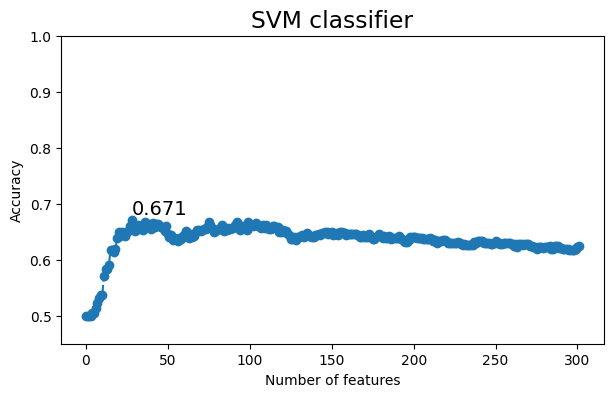

auc_best = 0.67127404
best auc (SVM) =  0.6712740384615384 Number of features =  28
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:04<16:10,  4.88s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:09<16:06,  4.88s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

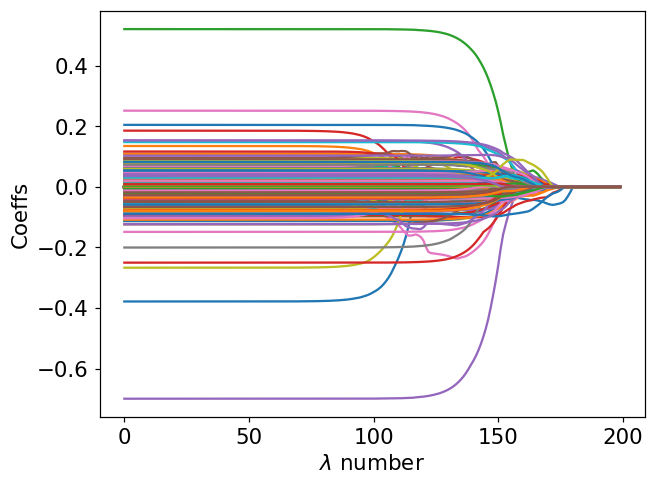

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/306 [00:05<27:31,  5.41s/it]

Iter =  1  UAR = 0.5000
UAR = 0.500


  1%|          | 2/306 [00:11<28:41,  5.66s/it]

UAR = 0.500


  1%|          | 3/306 [00:17<29:57,  5.93s/it]

UAR = 0.500


  1%|▏         | 4/306 [00:23<30:51,  6.13s/it]

UAR = 0.500


  2%|▏         | 5/306 [00:30<31:55,  6.36s/it]

UAR = 0.500


  2%|▏         | 6/306 [00:37<32:37,  6.53s/it]

UAR = 0.500


  2%|▏         | 7/306 [00:44<33:17,  6.68s/it]

UAR = 0.500


  3%|▎         | 8/306 [00:51<33:55,  6.83s/it]

UAR = 0.500


  3%|▎         | 9/306 [00:58<34:18,  6.93s/it]

UAR = 0.505
Iter =  9  UAR = 0.5052
UAR = 0.500


  3%|▎         | 10/306 [01:06<34:36,  7.02s/it]

UAR = 0.500


  4%|▎         | 11/306 [01:13<34:59,  7.12s/it]

UAR = 0.500


  4%|▍         | 12/306 [01:20<35:19,  7.21s/it]

UAR = 0.508
Iter =  12  UAR = 0.5078
UAR = 0.500


  4%|▍         | 13/306 [01:27<35:04,  7.18s/it]

UAR = 0.596
Iter =  13  UAR = 0.5960
UAR = 0.500


  5%|▍         | 14/306 [01:35<34:52,  7.17s/it]

UAR = 0.508
UAR = 0.602
Iter =  14  UAR = 0.6023
UAR = 0.500


  5%|▍         | 15/306 [01:42<34:49,  7.18s/it]

UAR = 0.533
UAR = 0.632
Iter =  15  UAR = 0.6324
UAR = 0.500
UAR = 0.503


  5%|▌         | 16/306 [01:49<34:24,  7.12s/it]

UAR = 0.523
UAR = 0.611
UAR = 0.500


  6%|▌         | 17/306 [01:56<34:16,  7.11s/it]

UAR = 0.507
UAR = 0.589
UAR = 0.500
UAR = 0.534


  6%|▌         | 18/306 [02:03<34:03,  7.10s/it]

UAR = 0.599
UAR = 0.628
UAR = 0.500
UAR = 0.544


  6%|▌         | 19/306 [02:10<33:57,  7.10s/it]

UAR = 0.593
UAR = 0.619
UAR = 0.500
UAR = 0.516
UAR = 0.570


  7%|▋         | 20/306 [02:17<34:02,  7.14s/it]

UAR = 0.599
UAR = 0.624
UAR = 0.500
UAR = 0.516
UAR = 0.565


  7%|▋         | 21/306 [02:25<34:09,  7.19s/it]

UAR = 0.593
UAR = 0.637
Iter =  21  UAR = 0.6365
UAR = 0.500
UAR = 0.525
UAR = 0.579


  7%|▋         | 22/306 [02:32<34:20,  7.25s/it]

UAR = 0.592
UAR = 0.651
Iter =  22  UAR = 0.6507
UAR = 0.500
UAR = 0.505
UAR = 0.547
UAR = 0.590


  8%|▊         | 23/306 [02:39<34:31,  7.32s/it]

UAR = 0.632
UAR = 0.660
Iter =  23  UAR = 0.6596
UAR = 0.500
UAR = 0.510
UAR = 0.551
UAR = 0.574
UAR = 0.622


  8%|▊         | 24/306 [03:20<1:20:47, 17.19s/it]

UAR = 0.645
UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.555
UAR = 0.593
UAR = 0.610


  8%|▊         | 25/306 [04:00<1:53:03, 24.14s/it]

UAR = 0.634
UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.555
UAR = 0.594


  8%|▊         | 26/306 [04:08<1:29:32, 19.19s/it]

UAR = 0.621
UAR = 0.640
UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.566
UAR = 0.599


  9%|▉         | 27/306 [04:15<1:13:11, 15.74s/it]

UAR = 0.627
UAR = 0.640
UAR = 0.500
UAR = 0.510
UAR = 0.526
UAR = 0.555
UAR = 0.599


  9%|▉         | 28/306 [04:23<1:01:57, 13.37s/it]

UAR = 0.621
UAR = 0.655
UAR = 0.500
UAR = 0.510
UAR = 0.526
UAR = 0.576
UAR = 0.605


  9%|▉         | 29/306 [04:31<54:11, 11.74s/it]  

UAR = 0.613
UAR = 0.623
UAR = 0.500
UAR = 0.510
UAR = 0.531
UAR = 0.570
UAR = 0.594
UAR = 0.604
UAR = 0.615
UAR = 0.616


 10%|▉         | 30/306 [04:39<48:52, 10.62s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.551
UAR = 0.575
UAR = 0.584
UAR = 0.594
UAR = 0.609


 10%|█         | 31/306 [04:47<45:21,  9.90s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.545
UAR = 0.574
UAR = 0.579
UAR = 0.599
UAR = 0.618


 10%|█         | 32/306 [04:55<41:46,  9.15s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.535
UAR = 0.590
UAR = 0.594
UAR = 0.598
UAR = 0.623
UAR = 0.626


 11%|█         | 33/306 [05:02<39:23,  8.66s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.534
UAR = 0.584
UAR = 0.609
UAR = 0.643


 11%|█         | 34/306 [05:10<37:48,  8.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.540
UAR = 0.584
UAR = 0.595
UAR = 0.624
UAR = 0.632


 11%|█▏        | 35/306 [05:18<36:52,  8.16s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.545
UAR = 0.569
UAR = 0.573
UAR = 0.575
UAR = 0.595
UAR = 0.618


 12%|█▏        | 36/306 [05:25<36:17,  8.07s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.544
UAR = 0.585
UAR = 0.600
UAR = 0.624


 12%|█▏        | 37/306 [05:33<36:02,  8.04s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.545
UAR = 0.590
UAR = 0.605
UAR = 0.629


 12%|█▏        | 38/306 [05:42<35:58,  8.05s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.545
UAR = 0.585
UAR = 0.610
UAR = 0.619
UAR = 0.627


 13%|█▎        | 39/306 [05:50<36:03,  8.10s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.561
UAR = 0.590
UAR = 0.615
UAR = 0.628


 13%|█▎        | 40/306 [05:58<36:09,  8.16s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.550
UAR = 0.585
UAR = 0.619
UAR = 0.634


 13%|█▎        | 41/306 [06:06<36:16,  8.21s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.545
UAR = 0.585
UAR = 0.609
UAR = 0.622


 14%|█▎        | 42/306 [06:15<36:28,  8.29s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.555
UAR = 0.586
UAR = 0.596
UAR = 0.615
UAR = 0.644


 14%|█▍        | 43/306 [06:24<36:51,  8.41s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.566
UAR = 0.585
UAR = 0.601
UAR = 0.625
UAR = 0.633


 14%|█▍        | 44/306 [06:32<37:11,  8.52s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.570
UAR = 0.585
UAR = 0.606
UAR = 0.635


 15%|█▍        | 45/306 [06:41<37:29,  8.62s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.570
UAR = 0.590
UAR = 0.601
UAR = 0.640


 15%|█▌        | 46/306 [06:50<37:48,  8.73s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.535
UAR = 0.565
UAR = 0.584
UAR = 0.601
UAR = 0.629


 15%|█▌        | 47/306 [06:59<38:07,  8.83s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.535
UAR = 0.575
UAR = 0.578
UAR = 0.606
UAR = 0.619
UAR = 0.627


 16%|█▌        | 48/306 [07:08<37:20,  8.68s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.580
UAR = 0.590
UAR = 0.629


 16%|█▌        | 49/306 [07:16<36:56,  8.63s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.575
UAR = 0.583
UAR = 0.596
UAR = 0.649


 16%|█▋        | 50/306 [07:25<36:50,  8.63s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.530
UAR = 0.570
UAR = 0.590
UAR = 0.591
UAR = 0.620
UAR = 0.622


 17%|█▋        | 51/306 [07:33<36:50,  8.67s/it]

UAR = 0.625
UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.570
UAR = 0.585
UAR = 0.596
UAR = 0.631


 17%|█▋        | 52/306 [07:42<36:58,  8.74s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.576
UAR = 0.591
UAR = 0.596
UAR = 0.631


 17%|█▋        | 53/306 [07:51<37:10,  8.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.530
UAR = 0.571
UAR = 0.585
UAR = 0.606
UAR = 0.630


 18%|█▊        | 54/306 [08:00<37:26,  8.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.531
UAR = 0.550
UAR = 0.560
UAR = 0.561
UAR = 0.591
UAR = 0.625


 18%|█▊        | 55/306 [08:10<37:45,  9.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.541
UAR = 0.561
UAR = 0.569
UAR = 0.601
UAR = 0.613


 18%|█▊        | 56/306 [08:19<38:01,  9.12s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.541
UAR = 0.560
UAR = 0.565
UAR = 0.571
UAR = 0.580
UAR = 0.635


 19%|█▊        | 57/306 [08:29<38:27,  9.27s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.546
UAR = 0.576
UAR = 0.577
UAR = 0.601
UAR = 0.631


 19%|█▉        | 58/306 [08:38<38:53,  9.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.541
UAR = 0.586
UAR = 0.616
UAR = 0.625


 19%|█▉        | 59/306 [08:48<39:17,  9.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.541
UAR = 0.576
UAR = 0.585
UAR = 0.611
UAR = 0.630


 20%|█▉        | 60/306 [08:58<39:44,  9.69s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.541
UAR = 0.581
UAR = 0.585
UAR = 0.601
UAR = 0.631


 20%|█▉        | 61/306 [09:08<40:07,  9.83s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.541
UAR = 0.581
UAR = 0.611
UAR = 0.635


 20%|██        | 62/306 [09:19<40:32,  9.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.545
UAR = 0.570
UAR = 0.575
UAR = 0.576
UAR = 0.600
UAR = 0.635
UAR = 0.640


 21%|██        | 63/306 [09:29<40:55, 10.10s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.550
UAR = 0.570
UAR = 0.571
UAR = 0.596
UAR = 0.631


 21%|██        | 64/306 [09:39<39:46,  9.86s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.530
UAR = 0.540
UAR = 0.565
UAR = 0.565
UAR = 0.607
UAR = 0.615


 21%|██        | 65/306 [09:48<39:07,  9.74s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.540
UAR = 0.560
UAR = 0.571
UAR = 0.600
UAR = 0.626


 22%|██▏       | 66/306 [09:58<38:52,  9.72s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.540
UAR = 0.565
UAR = 0.566
UAR = 0.611
UAR = 0.631


 22%|██▏       | 67/306 [10:07<38:51,  9.75s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.540
UAR = 0.565
UAR = 0.615
UAR = 0.644


 22%|██▏       | 68/306 [10:17<38:55,  9.81s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.545
UAR = 0.569
UAR = 0.570
UAR = 0.629
UAR = 0.631


 23%|██▎       | 69/306 [10:28<39:10,  9.92s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.540
UAR = 0.585
UAR = 0.619
UAR = 0.626


 23%|██▎       | 70/306 [10:38<39:33, 10.06s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.545
UAR = 0.574
UAR = 0.619
UAR = 0.621


 23%|██▎       | 71/306 [10:49<40:00, 10.21s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.545
UAR = 0.585
UAR = 0.624


 24%|██▎       | 72/306 [10:59<40:16, 10.33s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.545
UAR = 0.569
UAR = 0.575
UAR = 0.625


 24%|██▍       | 73/306 [11:10<40:40, 10.47s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.545
UAR = 0.574
UAR = 0.580
UAR = 0.625


 24%|██▍       | 74/306 [11:21<41:07, 10.63s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.545
UAR = 0.580
UAR = 0.590
UAR = 0.629
UAR = 0.632


 25%|██▍       | 75/306 [11:32<41:29, 10.78s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.545
UAR = 0.580
UAR = 0.590
UAR = 0.636


 25%|██▍       | 76/306 [11:43<41:57, 10.95s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.535
UAR = 0.585
UAR = 0.630


 25%|██▌       | 77/306 [11:55<42:20, 11.10s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.535
UAR = 0.581
UAR = 0.585
UAR = 0.630
UAR = 0.632


 25%|██▌       | 78/306 [12:06<42:41, 11.23s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.539
UAR = 0.580
UAR = 0.590
UAR = 0.629
UAR = 0.632


 26%|██▌       | 79/306 [12:18<43:03, 11.38s/it]

UAR = 0.500
UAR = 0.525
UAR = 0.550
UAR = 0.569
UAR = 0.590
UAR = 0.629
UAR = 0.633


 26%|██▌       | 80/306 [12:28<41:33, 11.03s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.550
UAR = 0.575
UAR = 0.584
UAR = 0.624


 26%|██▋       | 81/306 [12:39<40:38, 10.84s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.555
UAR = 0.575
UAR = 0.590
UAR = 0.629


 27%|██▋       | 82/306 [12:49<40:02, 10.72s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.560
UAR = 0.575
UAR = 0.584
UAR = 0.623


 27%|██▋       | 83/306 [13:00<39:47, 10.71s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.550
UAR = 0.570
UAR = 0.579
UAR = 0.619
UAR = 0.621


 27%|██▋       | 84/306 [13:11<39:51, 10.77s/it]

UAR = 0.500
UAR = 0.525
UAR = 0.550
UAR = 0.570
UAR = 0.619


 28%|██▊       | 85/306 [13:22<40:07, 10.89s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.555
UAR = 0.565
UAR = 0.608


 28%|██▊       | 86/306 [13:33<40:31, 11.05s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.544
UAR = 0.559
UAR = 0.569
UAR = 0.608


 28%|██▊       | 87/306 [13:45<41:00, 11.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.559
UAR = 0.584
UAR = 0.602


 29%|██▉       | 88/306 [13:57<41:29, 11.42s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.529
UAR = 0.560
UAR = 0.585
UAR = 0.608


 29%|██▉       | 89/306 [14:09<42:02, 11.62s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.533
UAR = 0.560
UAR = 0.596
UAR = 0.603


 29%|██▉       | 90/306 [14:21<42:33, 11.82s/it]

UAR = 0.500
UAR = 0.534
UAR = 0.565
UAR = 0.596
UAR = 0.608


 30%|██▉       | 91/306 [14:34<43:04, 12.02s/it]

UAR = 0.500
UAR = 0.534
UAR = 0.570
UAR = 0.601
UAR = 0.608


 30%|███       | 92/306 [14:46<43:30, 12.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.570
UAR = 0.601
UAR = 0.613


 30%|███       | 93/306 [14:59<43:52, 12.36s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.555
UAR = 0.575
UAR = 0.606
UAR = 0.613


 31%|███       | 94/306 [15:12<44:22, 12.56s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.560
UAR = 0.570
UAR = 0.606
UAR = 0.623


 31%|███       | 95/306 [15:25<44:57, 12.79s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.555
UAR = 0.565
UAR = 0.596
UAR = 0.618


 31%|███▏      | 96/306 [15:37<43:39, 12.47s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.555
UAR = 0.565
UAR = 0.612
UAR = 0.618


 32%|███▏      | 97/306 [15:49<43:08, 12.39s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.555
UAR = 0.560
UAR = 0.606
UAR = 0.618


 32%|███▏      | 98/306 [16:02<43:00, 12.41s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.550
UAR = 0.560
UAR = 0.601
UAR = 0.619


 32%|███▏      | 99/306 [16:14<42:59, 12.46s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.550
UAR = 0.560
UAR = 0.602
UAR = 0.613


 33%|███▎      | 100/306 [16:27<43:06, 12.56s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.545
UAR = 0.560
UAR = 0.596
UAR = 0.624


 33%|███▎      | 101/306 [16:40<43:26, 12.72s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.540
UAR = 0.555
UAR = 0.591
UAR = 0.618


 33%|███▎      | 102/306 [16:53<43:42, 12.86s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.540
UAR = 0.555
UAR = 0.585
UAR = 0.612


 34%|███▎      | 103/306 [17:07<44:10, 13.06s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.544
UAR = 0.590
UAR = 0.602


 34%|███▍      | 104/306 [17:21<44:35, 13.25s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.545
UAR = 0.555
UAR = 0.590
UAR = 0.602


 34%|███▍      | 105/306 [17:35<45:03, 13.45s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.590
UAR = 0.613


 35%|███▍      | 106/306 [17:49<45:33, 13.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.550
UAR = 0.590
UAR = 0.613


 35%|███▍      | 107/306 [18:03<46:05, 13.90s/it]

UAR = 0.500
UAR = 0.545
UAR = 0.548
UAR = 0.590
UAR = 0.609


 35%|███▌      | 108/306 [18:18<46:38, 14.14s/it]

UAR = 0.500
UAR = 0.545
UAR = 0.549
UAR = 0.585
UAR = 0.609


 36%|███▌      | 109/306 [18:33<47:10, 14.37s/it]

UAR = 0.500
UAR = 0.545
UAR = 0.549
UAR = 0.590
UAR = 0.608


 36%|███▌      | 110/306 [18:48<47:37, 14.58s/it]

UAR = 0.500
UAR = 0.540
UAR = 0.549
UAR = 0.590
UAR = 0.608


 36%|███▋      | 111/306 [19:03<48:03, 14.79s/it]

UAR = 0.500
UAR = 0.540
UAR = 0.549
UAR = 0.590
UAR = 0.608


 37%|███▋      | 112/306 [19:17<46:33, 14.40s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.549
UAR = 0.590
UAR = 0.608


 37%|███▋      | 113/306 [19:30<45:34, 14.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.549
UAR = 0.590
UAR = 0.608


 37%|███▋      | 114/306 [19:44<44:59, 14.06s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.550
UAR = 0.590
UAR = 0.613


 38%|███▊      | 115/306 [19:58<44:41, 14.04s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.545
UAR = 0.549
UAR = 0.551
UAR = 0.590
UAR = 0.613


 38%|███▊      | 116/306 [20:12<44:43, 14.12s/it]

UAR = 0.500
UAR = 0.545
UAR = 0.549
UAR = 0.551
UAR = 0.590
UAR = 0.608


 38%|███▊      | 117/306 [20:27<44:56, 14.27s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.550
UAR = 0.552
UAR = 0.590
UAR = 0.597


 39%|███▊      | 118/306 [20:42<45:08, 14.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.549
UAR = 0.590
UAR = 0.592


 39%|███▉      | 119/306 [20:57<45:30, 14.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.539
UAR = 0.550
UAR = 0.595
UAR = 0.597


 39%|███▉      | 120/306 [21:12<45:42, 14.74s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.549
UAR = 0.585
UAR = 0.596


 40%|███▉      | 121/306 [21:27<46:04, 14.94s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.549
UAR = 0.585
UAR = 0.612


 40%|███▉      | 122/306 [21:43<46:31, 15.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.534
UAR = 0.549
UAR = 0.584
UAR = 0.607


 40%|████      | 123/306 [21:59<47:04, 15.44s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.545
UAR = 0.549
UAR = 0.585
UAR = 0.597


 41%|████      | 124/306 [22:15<47:25, 15.64s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.545
UAR = 0.549
UAR = 0.580
UAR = 0.592


 41%|████      | 125/306 [22:31<47:47, 15.84s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.544
UAR = 0.549
UAR = 0.585
UAR = 0.597


 41%|████      | 126/306 [22:48<48:07, 16.04s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.528
UAR = 0.549
UAR = 0.584
UAR = 0.602


 42%|████▏     | 127/306 [23:05<48:30, 16.26s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.528
UAR = 0.549
UAR = 0.584
UAR = 0.597


 42%|████▏     | 128/306 [23:20<47:03, 15.86s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.528
UAR = 0.549
UAR = 0.580
UAR = 0.597


 42%|████▏     | 129/306 [23:35<46:04, 15.62s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.528
UAR = 0.549
UAR = 0.574
UAR = 0.597


 42%|████▏     | 130/306 [23:50<45:30, 15.52s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.528
UAR = 0.549
UAR = 0.580
UAR = 0.596


 43%|████▎     | 131/306 [24:05<45:11, 15.50s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.528
UAR = 0.549
UAR = 0.579
UAR = 0.596


 43%|████▎     | 132/306 [24:21<45:10, 15.58s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.549
UAR = 0.579
UAR = 0.596


 43%|████▎     | 133/306 [24:37<45:17, 15.71s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.549
UAR = 0.579
UAR = 0.590


 44%|████▍     | 134/306 [24:53<45:29, 15.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.549
UAR = 0.579
UAR = 0.590


 44%|████▍     | 135/306 [25:10<45:42, 16.04s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.549
UAR = 0.579
UAR = 0.590


 44%|████▍     | 136/306 [25:27<45:55, 16.21s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.545
UAR = 0.584
UAR = 0.606


 45%|████▍     | 137/306 [25:43<46:14, 16.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.528
UAR = 0.545
UAR = 0.590
UAR = 0.607


 45%|████▌     | 138/306 [26:01<46:35, 16.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.528
UAR = 0.545
UAR = 0.589
UAR = 0.601


 45%|████▌     | 139/306 [26:18<46:56, 16.86s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.528
UAR = 0.545
UAR = 0.579
UAR = 0.606


 46%|████▌     | 140/306 [26:36<47:15, 17.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.529
UAR = 0.545
UAR = 0.584
UAR = 0.601


 46%|████▌     | 141/306 [26:53<47:33, 17.29s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.529
UAR = 0.540
UAR = 0.590
UAR = 0.602


 46%|████▋     | 142/306 [27:11<47:57, 17.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.539
UAR = 0.540
UAR = 0.584
UAR = 0.601


 47%|████▋     | 143/306 [27:30<48:25, 17.83s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.534
UAR = 0.545
UAR = 0.580
UAR = 0.602


 47%|████▋     | 144/306 [27:46<46:48, 17.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.534
UAR = 0.540
UAR = 0.580
UAR = 0.602


 47%|████▋     | 145/306 [28:03<45:56, 17.12s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.534
UAR = 0.540
UAR = 0.580
UAR = 0.602


 48%|████▊     | 146/306 [28:20<45:23, 17.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.534
UAR = 0.540
UAR = 0.580
UAR = 0.602


 48%|████▊     | 147/306 [28:37<45:07, 17.03s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.534
UAR = 0.536
UAR = 0.580
UAR = 0.602


 48%|████▊     | 148/306 [28:54<44:58, 17.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.539
UAR = 0.580
UAR = 0.607


 49%|████▊     | 149/306 [29:11<45:09, 17.26s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.539
UAR = 0.590
UAR = 0.607


 49%|████▉     | 150/306 [29:29<45:21, 17.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.539
UAR = 0.589
UAR = 0.596


 49%|████▉     | 151/306 [29:48<45:37, 17.66s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.516
UAR = 0.529
UAR = 0.530
UAR = 0.573
UAR = 0.592


 50%|████▉     | 152/306 [30:06<45:44, 17.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.516
UAR = 0.523
UAR = 0.531
UAR = 0.573
UAR = 0.577


 50%|█████     | 153/306 [30:24<45:57, 18.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.516
UAR = 0.523
UAR = 0.526
UAR = 0.535
UAR = 0.574
UAR = 0.593


 50%|█████     | 154/306 [30:43<46:13, 18.25s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.516
UAR = 0.523
UAR = 0.526
UAR = 0.535
UAR = 0.568
UAR = 0.587


 51%|█████     | 155/306 [31:02<46:30, 18.48s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.536
UAR = 0.573
UAR = 0.598


 51%|█████     | 156/306 [31:21<46:41, 18.68s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.523
UAR = 0.534
UAR = 0.579
UAR = 0.593


 51%|█████▏    | 157/306 [31:41<46:57, 18.91s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.523
UAR = 0.525
UAR = 0.529
UAR = 0.579
UAR = 0.587


 52%|█████▏    | 158/306 [32:00<47:10, 19.12s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.523
UAR = 0.529
UAR = 0.573
UAR = 0.588


 52%|█████▏    | 159/306 [32:20<47:30, 19.39s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.534
UAR = 0.534
UAR = 0.573
UAR = 0.594


 52%|█████▏    | 160/306 [32:38<45:57, 18.89s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.534
UAR = 0.536
UAR = 0.573
UAR = 0.593


 53%|█████▎    | 161/306 [32:56<45:01, 18.63s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.540
UAR = 0.568
UAR = 0.587


 53%|█████▎    | 162/306 [33:14<44:27, 18.52s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.535
UAR = 0.563
UAR = 0.583


 53%|█████▎    | 163/306 [33:33<44:08, 18.52s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.535
UAR = 0.562
UAR = 0.577


 54%|█████▎    | 164/306 [33:51<43:51, 18.53s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.535
UAR = 0.557
UAR = 0.583


 54%|█████▍    | 165/306 [34:10<43:55, 18.69s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.535
UAR = 0.562
UAR = 0.584


 54%|█████▍    | 166/306 [34:30<43:58, 18.85s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.535
UAR = 0.562
UAR = 0.579


 55%|█████▍    | 167/306 [34:49<44:07, 19.05s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.563
UAR = 0.580


 55%|█████▍    | 168/306 [35:09<44:05, 19.17s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.530
UAR = 0.564
UAR = 0.579


 55%|█████▌    | 169/306 [35:28<44:12, 19.36s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.529
UAR = 0.563
UAR = 0.579


 56%|█████▌    | 170/306 [35:48<44:18, 19.54s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.530
UAR = 0.563
UAR = 0.579


 56%|█████▌    | 171/306 [36:09<44:27, 19.76s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.529
UAR = 0.564
UAR = 0.578


 56%|█████▌    | 172/306 [36:29<44:29, 19.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.530
UAR = 0.564
UAR = 0.584


 57%|█████▋    | 173/306 [36:50<44:41, 20.16s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.530
UAR = 0.564
UAR = 0.584


 57%|█████▋    | 174/306 [37:10<44:49, 20.37s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.530
UAR = 0.559
UAR = 0.584


 57%|█████▋    | 175/306 [37:32<45:05, 20.65s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.514
UAR = 0.530
UAR = 0.549
UAR = 0.578


 58%|█████▊    | 176/306 [37:51<43:37, 20.14s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.530
UAR = 0.559
UAR = 0.584


 58%|█████▊    | 177/306 [38:10<42:47, 19.90s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.514
UAR = 0.530
UAR = 0.554
UAR = 0.578


 58%|█████▊    | 178/306 [38:29<42:08, 19.75s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.530
UAR = 0.559
UAR = 0.578


 58%|█████▊    | 179/306 [38:49<41:48, 19.75s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.514
UAR = 0.530
UAR = 0.554
UAR = 0.578


 59%|█████▉    | 180/306 [39:09<41:28, 19.75s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.519
UAR = 0.535
UAR = 0.554
UAR = 0.568


 59%|█████▉    | 181/306 [39:29<41:25, 19.88s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.514
UAR = 0.535
UAR = 0.559
UAR = 0.568


 59%|█████▉    | 182/306 [39:50<41:23, 20.03s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.530
UAR = 0.563


 60%|█████▉    | 183/306 [40:10<41:29, 20.24s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.530
UAR = 0.570
UAR = 0.573


 60%|██████    | 184/306 [40:31<41:20, 20.33s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.530
UAR = 0.564
UAR = 0.567


 60%|██████    | 185/306 [40:52<41:29, 20.57s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.530
UAR = 0.564


 61%|██████    | 186/306 [41:13<41:38, 20.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.530
UAR = 0.574


 61%|██████    | 187/306 [41:35<41:49, 21.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.530
UAR = 0.569


 61%|██████▏   | 188/306 [41:57<41:45, 21.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.530
UAR = 0.569


 62%|██████▏   | 189/306 [42:19<41:52, 21.48s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.530
UAR = 0.559


 62%|██████▏   | 190/306 [42:41<41:56, 21.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.530
UAR = 0.569


 62%|██████▏   | 191/306 [43:04<42:06, 21.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.530
UAR = 0.569


 63%|██████▎   | 192/306 [43:24<40:44, 21.44s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.509
UAR = 0.530
UAR = 0.569


 63%|██████▎   | 193/306 [43:44<39:51, 21.16s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.515
UAR = 0.530
UAR = 0.568


 63%|██████▎   | 194/306 [44:05<39:13, 21.01s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.515
UAR = 0.530
UAR = 0.568


 64%|██████▎   | 195/306 [44:26<38:50, 20.99s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.530
UAR = 0.534
UAR = 0.568


 64%|██████▍   | 196/306 [44:47<38:27, 20.98s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.530
UAR = 0.534
UAR = 0.568


 64%|██████▍   | 197/306 [45:08<38:23, 21.13s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.530
UAR = 0.535
UAR = 0.568


 65%|██████▍   | 198/306 [45:30<38:20, 21.30s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.530
UAR = 0.534
UAR = 0.578


 65%|██████▌   | 199/306 [45:52<38:18, 21.48s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.525
UAR = 0.530
UAR = 0.534
UAR = 0.579


 65%|██████▌   | 200/306 [46:14<38:07, 21.58s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.579


 66%|██████▌   | 201/306 [46:36<38:08, 21.79s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.578


 66%|██████▌   | 202/306 [46:59<38:10, 22.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.573


 66%|██████▋   | 203/306 [47:21<38:16, 22.29s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.574


 67%|██████▋   | 204/306 [47:44<38:06, 22.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.534
UAR = 0.574


 67%|██████▋   | 205/306 [48:07<38:08, 22.66s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.579


 67%|██████▋   | 206/306 [48:31<38:10, 22.91s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.530
UAR = 0.579


 68%|██████▊   | 207/306 [48:55<38:14, 23.18s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.519
UAR = 0.530
UAR = 0.533
UAR = 0.579


 68%|██████▊   | 208/306 [49:16<36:52, 22.58s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.519
UAR = 0.530
UAR = 0.579


 68%|██████▊   | 209/306 [49:38<36:08, 22.36s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.519
UAR = 0.530
UAR = 0.574


 69%|██████▊   | 210/306 [50:00<35:33, 22.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.519
UAR = 0.525
UAR = 0.574


 69%|██████▉   | 211/306 [50:22<35:11, 22.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.519
UAR = 0.525
UAR = 0.574


 69%|██████▉   | 212/306 [50:44<34:47, 22.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.525
UAR = 0.528
UAR = 0.574


 70%|██████▉   | 213/306 [51:07<34:34, 22.31s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.525
UAR = 0.528
UAR = 0.574


 70%|██████▉   | 214/306 [51:29<34:26, 22.47s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.528
UAR = 0.574


 70%|███████   | 215/306 [51:53<34:23, 22.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.525
UAR = 0.528
UAR = 0.574


 71%|███████   | 216/306 [52:15<34:04, 22.71s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.534
UAR = 0.575


 71%|███████   | 217/306 [52:39<34:00, 22.93s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.534
UAR = 0.575


 71%|███████   | 218/306 [53:03<33:58, 23.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.534
UAR = 0.575


 72%|███████▏  | 219/306 [53:27<34:01, 23.46s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.533
UAR = 0.580


 72%|███████▏  | 220/306 [53:51<33:48, 23.59s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.533
UAR = 0.574


 72%|███████▏  | 221/306 [54:15<33:53, 23.93s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.520
UAR = 0.533
UAR = 0.574


 73%|███████▎  | 222/306 [54:40<33:52, 24.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.520
UAR = 0.520
UAR = 0.538
UAR = 0.579


 73%|███████▎  | 223/306 [55:05<33:51, 24.48s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.538
UAR = 0.579


 73%|███████▎  | 224/306 [55:28<32:39, 23.89s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.538
UAR = 0.579


 74%|███████▎  | 225/306 [55:51<31:55, 23.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.533
UAR = 0.579


 74%|███████▍  | 226/306 [56:14<31:17, 23.47s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.533
UAR = 0.579


 74%|███████▍  | 227/306 [56:37<30:50, 23.42s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.533
UAR = 0.579


 75%|███████▍  | 228/306 [57:00<30:21, 23.36s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.533
UAR = 0.579


 75%|███████▍  | 229/306 [57:24<30:08, 23.49s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.538
UAR = 0.579


 75%|███████▌  | 230/306 [57:48<29:59, 23.68s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.525
UAR = 0.528
UAR = 0.579


 75%|███████▌  | 231/306 [58:13<29:52, 23.90s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.525
UAR = 0.528
UAR = 0.579


 76%|███████▌  | 232/306 [58:37<29:32, 23.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.528
UAR = 0.579


 76%|███████▌  | 233/306 [59:01<29:22, 24.15s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.528
UAR = 0.579


 76%|███████▋  | 234/306 [59:37<33:02, 27.53s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.533
UAR = 0.579


 77%|███████▋  | 235/306 [1:00:13<35:30, 30.01s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.525
UAR = 0.532
UAR = 0.579


 77%|███████▋  | 236/306 [1:00:49<37:06, 31.81s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.532
UAR = 0.579


 77%|███████▋  | 237/306 [1:01:25<38:14, 33.25s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.520
UAR = 0.520
UAR = 0.532
UAR = 0.579


 78%|███████▊  | 238/306 [1:02:02<38:47, 34.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.519
UAR = 0.525
UAR = 0.542
UAR = 0.578


 78%|███████▊  | 239/306 [1:02:39<39:12, 35.11s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.509
UAR = 0.525
UAR = 0.525
UAR = 0.547
UAR = 0.594


 78%|███████▊  | 240/306 [1:03:13<38:18, 34.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.519
UAR = 0.531
UAR = 0.547
UAR = 0.594


 79%|███████▉  | 241/306 [1:03:48<37:38, 34.75s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.594


 79%|███████▉  | 242/306 [1:04:12<33:39, 31.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.593


 79%|███████▉  | 243/306 [1:04:36<30:53, 29.42s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.593


 80%|███████▉  | 244/306 [1:05:00<28:45, 27.84s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.593


 80%|████████  | 245/306 [1:05:25<27:24, 26.96s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.588


 80%|████████  | 246/306 [1:05:50<26:22, 26.38s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.593


 81%|████████  | 247/306 [1:06:16<25:39, 26.09s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.588


 81%|████████  | 248/306 [1:06:41<24:56, 25.80s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.588


 81%|████████▏ | 249/306 [1:07:06<24:27, 25.75s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.587


 82%|████████▏ | 250/306 [1:07:32<24:02, 25.76s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.587


 82%|████████▏ | 251/306 [1:07:59<23:45, 25.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.557
UAR = 0.593


 82%|████████▏ | 252/306 [1:08:24<23:19, 25.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.526
UAR = 0.562
UAR = 0.588


 83%|████████▎ | 253/306 [1:08:51<23:06, 26.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.526
UAR = 0.557
UAR = 0.593


 83%|████████▎ | 254/306 [1:09:18<22:51, 26.37s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.514
UAR = 0.524
UAR = 0.525
UAR = 0.526
UAR = 0.562
UAR = 0.588


 83%|████████▎ | 255/306 [1:09:45<22:36, 26.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.526
UAR = 0.562
UAR = 0.589


 84%|████████▎ | 256/306 [1:10:09<21:30, 25.81s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.526
UAR = 0.567
UAR = 0.589


 84%|████████▍ | 257/306 [1:10:34<20:55, 25.62s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.567
UAR = 0.588


 84%|████████▍ | 258/306 [1:10:59<20:21, 25.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.562
UAR = 0.588


 85%|████████▍ | 259/306 [1:11:25<19:56, 25.47s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.562
UAR = 0.589


 85%|████████▍ | 260/306 [1:11:50<19:29, 25.42s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.525
UAR = 0.562
UAR = 0.588


 85%|████████▌ | 261/306 [1:12:16<19:10, 25.56s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.562
UAR = 0.588


 86%|████████▌ | 262/306 [1:12:42<18:51, 25.71s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.567
UAR = 0.593


 86%|████████▌ | 263/306 [1:13:09<18:35, 25.94s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.529
UAR = 0.567
UAR = 0.593


 86%|████████▋ | 264/306 [1:13:35<18:11, 25.99s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.529
UAR = 0.572
UAR = 0.593


 87%|████████▋ | 265/306 [1:14:01<17:53, 26.18s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.529
UAR = 0.572
UAR = 0.598


 87%|████████▋ | 266/306 [1:14:28<17:34, 26.36s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.529
UAR = 0.572
UAR = 0.598


 87%|████████▋ | 267/306 [1:14:55<17:17, 26.59s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.529
UAR = 0.567
UAR = 0.593


 88%|████████▊ | 268/306 [1:15:22<16:53, 26.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.529
UAR = 0.567
UAR = 0.593


 88%|████████▊ | 269/306 [1:15:50<16:37, 26.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.567
UAR = 0.593


 88%|████████▊ | 270/306 [1:16:18<16:19, 27.21s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.567
UAR = 0.593


 89%|████████▊ | 271/306 [1:16:46<16:03, 27.54s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.567
UAR = 0.593


 89%|████████▉ | 272/306 [1:17:11<15:12, 26.83s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.567
UAR = 0.593


 89%|████████▉ | 273/306 [1:17:37<14:38, 26.63s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.567
UAR = 0.593


 90%|████████▉ | 274/306 [1:18:03<14:06, 26.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.572
UAR = 0.593


 90%|████████▉ | 275/306 [1:18:30<13:41, 26.51s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.572
UAR = 0.593


 90%|█████████ | 276/306 [1:18:56<13:11, 26.39s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.572
UAR = 0.593


 91%|█████████ | 277/306 [1:19:23<12:51, 26.59s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.572
UAR = 0.593


 91%|█████████ | 278/306 [1:19:50<12:27, 26.69s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.572
UAR = 0.592


 91%|█████████ | 279/306 [1:20:18<12:08, 26.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.572
UAR = 0.593


 92%|█████████▏| 280/306 [1:20:45<11:41, 26.99s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.572
UAR = 0.593


 92%|█████████▏| 281/306 [1:21:12<11:20, 27.22s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.572
UAR = 0.593


 92%|█████████▏| 282/306 [1:21:40<10:57, 27.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.572
UAR = 0.593


 92%|█████████▏| 283/306 [1:22:09<10:37, 27.72s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.567
UAR = 0.593


 93%|█████████▎| 284/306 [1:22:37<10:11, 27.78s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.571
UAR = 0.593


 93%|█████████▎| 285/306 [1:23:05<09:50, 28.10s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.576
UAR = 0.593


 93%|█████████▎| 286/306 [1:23:34<09:25, 28.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.531
UAR = 0.577
UAR = 0.593


 94%|█████████▍| 287/306 [1:24:04<09:03, 28.62s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.567
UAR = 0.593


 94%|█████████▍| 288/306 [1:24:30<08:22, 27.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.572
UAR = 0.593


 94%|█████████▍| 289/306 [1:24:57<07:50, 27.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.566
UAR = 0.593


 95%|█████████▍| 290/306 [1:25:24<07:20, 27.54s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.571
UAR = 0.593


 95%|█████████▌| 291/306 [1:25:52<06:52, 27.53s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.571
UAR = 0.593


 95%|█████████▌| 292/306 [1:26:19<06:24, 27.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.571
UAR = 0.593


 96%|█████████▌| 293/306 [1:26:47<05:59, 27.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.571
UAR = 0.593


 96%|█████████▌| 294/306 [1:27:15<05:33, 27.76s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.571
UAR = 0.593


 96%|█████████▋| 295/306 [1:27:43<05:07, 27.94s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.571
UAR = 0.593


 97%|█████████▋| 296/306 [1:28:11<04:39, 27.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.572
UAR = 0.593


 97%|█████████▋| 297/306 [1:28:40<04:13, 28.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.572
UAR = 0.593


 97%|█████████▋| 298/306 [1:29:09<03:47, 28.40s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.577
UAR = 0.593


 98%|█████████▊| 299/306 [1:29:38<03:20, 28.66s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.577
UAR = 0.594


 98%|█████████▊| 300/306 [1:30:07<02:52, 28.77s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.577
UAR = 0.593


 98%|█████████▊| 301/306 [1:30:37<02:25, 29.11s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.577
UAR = 0.593


 99%|█████████▊| 302/306 [1:31:07<01:57, 29.31s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.571
UAR = 0.593


 99%|█████████▉| 303/306 [1:31:37<01:28, 29.63s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.571
UAR = 0.593


 99%|█████████▉| 304/306 [1:32:05<00:57, 28.90s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.571
UAR = 0.593


100%|█████████▉| 305/306 [1:32:33<00:28, 28.62s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.519
UAR = 0.529
UAR = 0.530
UAR = 0.571
UAR = 0.593


100%|██████████| 306/306 [1:33:01<00:00, 18.24s/it]


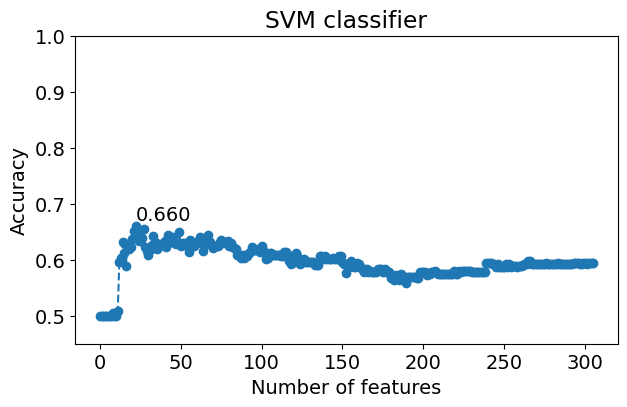

auc_best = 0.65959821
best auc (SVM) =  0.6595982142857143 Number of features =  22
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:05<18:10,  5.48s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:10<16:54,  5.13s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

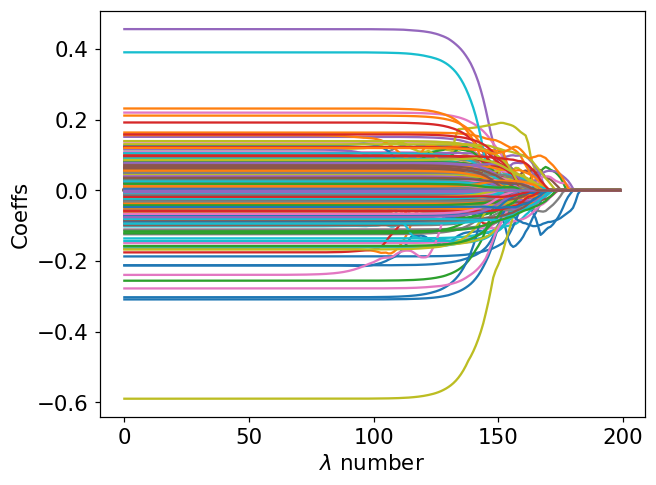

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/306 [00:09<46:54,  9.23s/it]

Iter =  1  UAR = 0.5000
UAR = 0.500


  1%|          | 2/306 [00:18<46:49,  9.24s/it]

UAR = 0.500


  1%|          | 3/306 [00:29<49:55,  9.88s/it]

UAR = 0.500


  1%|▏         | 4/306 [00:40<52:42, 10.47s/it]

UAR = 0.500


  2%|▏         | 5/306 [00:52<55:22, 11.04s/it]

UAR = 0.500


  2%|▏         | 6/306 [01:04<57:14, 11.45s/it]

UAR = 0.500


  2%|▏         | 7/306 [01:17<58:50, 11.81s/it]

UAR = 0.500
UAR = 0.513


  3%|▎         | 8/306 [01:29<58:48, 11.84s/it]

UAR = 0.531
Iter =  8  UAR = 0.5312
UAR = 0.500
UAR = 0.513
UAR = 0.522


  3%|▎         | 9/306 [01:40<58:06, 11.74s/it]

UAR = 0.532
UAR = 0.536
Iter =  9  UAR = 0.5359
UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.532
UAR = 0.542


  3%|▎         | 10/306 [01:52<57:27, 11.65s/it]

UAR = 0.549
UAR = 0.566
Iter =  10  UAR = 0.5661
UAR = 0.500
UAR = 0.528
UAR = 0.539
UAR = 0.544
UAR = 0.558


  4%|▎         | 11/306 [02:03<57:02, 11.60s/it]

UAR = 0.560
UAR = 0.572
Iter =  11  UAR = 0.5723
UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.547
UAR = 0.554
UAR = 0.572


  4%|▍         | 12/306 [02:15<57:00, 11.63s/it]

UAR = 0.587
UAR = 0.602
Iter =  12  UAR = 0.6024
UAR = 0.500
UAR = 0.505
UAR = 0.522
UAR = 0.553
UAR = 0.557
UAR = 0.579


  4%|▍         | 13/306 [02:27<57:15, 11.72s/it]

UAR = 0.593
UAR = 0.609
Iter =  13  UAR = 0.6088
UAR = 0.500
UAR = 0.510
UAR = 0.524
UAR = 0.550
UAR = 0.559
UAR = 0.586


  5%|▍         | 14/306 [02:39<57:30, 11.82s/it]

UAR = 0.593
UAR = 0.612
Iter =  14  UAR = 0.6116
UAR = 0.500
UAR = 0.503
UAR = 0.516
UAR = 0.530
UAR = 0.556
UAR = 0.573
UAR = 0.603


  5%|▍         | 15/306 [02:51<57:49, 11.92s/it]

UAR = 0.615
UAR = 0.628
Iter =  15  UAR = 0.6284
UAR = 0.500
UAR = 0.503
UAR = 0.516
UAR = 0.532
UAR = 0.555
UAR = 0.569
UAR = 0.603


  5%|▌         | 16/306 [03:03<57:23, 11.87s/it]

UAR = 0.612
UAR = 0.622
UAR = 0.500
UAR = 0.503
UAR = 0.516
UAR = 0.538
UAR = 0.556
UAR = 0.584
UAR = 0.608


  6%|▌         | 17/306 [03:15<57:17, 11.90s/it]

UAR = 0.614
UAR = 0.626
UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.533
UAR = 0.550
UAR = 0.551
UAR = 0.587
UAR = 0.608


  6%|▌         | 18/306 [03:27<57:21, 11.95s/it]

UAR = 0.610
UAR = 0.624
UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.538
UAR = 0.557
UAR = 0.587
UAR = 0.613


  6%|▌         | 19/306 [03:39<57:37, 12.05s/it]

UAR = 0.622
UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.535
UAR = 0.554
UAR = 0.560
UAR = 0.598
UAR = 0.622


  7%|▋         | 20/306 [03:52<58:06, 12.19s/it]

UAR = 0.634
Iter =  20  UAR = 0.6344
UAR = 0.500
UAR = 0.503
UAR = 0.523
UAR = 0.544
UAR = 0.565
UAR = 0.580
UAR = 0.601
UAR = 0.611


  7%|▋         | 21/306 [04:04<58:44, 12.37s/it]

UAR = 0.626
UAR = 0.629
UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.545
UAR = 0.575
UAR = 0.588
UAR = 0.607


  7%|▋         | 22/306 [04:17<59:23, 12.55s/it]

UAR = 0.624
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.554
UAR = 0.561
UAR = 0.591
UAR = 0.598
UAR = 0.606
UAR = 0.607
UAR = 0.632


  8%|▊         | 23/306 [04:31<1:00:06, 12.74s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.554
UAR = 0.562
UAR = 0.583
UAR = 0.608
UAR = 0.609
UAR = 0.615
UAR = 0.632


  8%|▊         | 24/306 [04:44<1:00:28, 12.87s/it]

UAR = 0.636
Iter =  24  UAR = 0.6356
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.556
UAR = 0.579
UAR = 0.586
UAR = 0.612
UAR = 0.622
UAR = 0.624
UAR = 0.628


  8%|▊         | 25/306 [04:57<1:00:51, 13.00s/it]

UAR = 0.636
Iter =  25  UAR = 0.6358
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.510
UAR = 0.530
UAR = 0.546
UAR = 0.574
UAR = 0.585
UAR = 0.616
UAR = 0.630


  8%|▊         | 26/306 [05:11<1:01:20, 13.15s/it]

UAR = 0.641
Iter =  26  UAR = 0.6414
UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.526
UAR = 0.541
UAR = 0.567
UAR = 0.580
UAR = 0.615
UAR = 0.619
UAR = 0.628
UAR = 0.643


  9%|▉         | 27/306 [05:24<1:01:53, 13.31s/it]

Iter =  27  UAR = 0.6428
UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.526
UAR = 0.536
UAR = 0.570
UAR = 0.594
UAR = 0.622
UAR = 0.631
UAR = 0.638


  9%|▉         | 28/306 [05:38<1:02:32, 13.50s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.526
UAR = 0.542
UAR = 0.578
UAR = 0.598
UAR = 0.612
UAR = 0.620
UAR = 0.630
UAR = 0.647


  9%|▉         | 29/306 [05:52<1:03:13, 13.70s/it]

Iter =  29  UAR = 0.6472
UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.531
UAR = 0.545
UAR = 0.567
UAR = 0.570
UAR = 0.593
UAR = 0.618
UAR = 0.620
UAR = 0.635
UAR = 0.638


 10%|▉         | 30/306 [06:07<1:03:50, 13.88s/it]

UAR = 0.640
UAR = 0.500
UAR = 0.503
UAR = 0.512
UAR = 0.547
UAR = 0.559
UAR = 0.579
UAR = 0.620
UAR = 0.628
UAR = 0.641
UAR = 0.641


 10%|█         | 31/306 [06:21<1:04:26, 14.06s/it]

UAR = 0.650
Iter =  31  UAR = 0.6498
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.517
UAR = 0.546
UAR = 0.558
UAR = 0.577
UAR = 0.621
UAR = 0.626
UAR = 0.637
UAR = 0.641


 10%|█         | 32/306 [06:34<1:02:41, 13.73s/it]

UAR = 0.659
Iter =  32  UAR = 0.6587
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.525
UAR = 0.544
UAR = 0.572
UAR = 0.574
UAR = 0.599
UAR = 0.625
UAR = 0.625
UAR = 0.631
UAR = 0.639


 11%|█         | 33/306 [06:47<1:01:41, 13.56s/it]

UAR = 0.645
UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.541
UAR = 0.573
UAR = 0.575
UAR = 0.598
UAR = 0.623
UAR = 0.635
UAR = 0.643
UAR = 0.645


 11%|█         | 34/306 [07:01<1:01:10, 13.50s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.528
UAR = 0.551
UAR = 0.574
UAR = 0.582
UAR = 0.606
UAR = 0.634
UAR = 0.640
UAR = 0.640
UAR = 0.653


 11%|█▏        | 35/306 [07:14<1:01:05, 13.53s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.527
UAR = 0.551
UAR = 0.576
UAR = 0.579
UAR = 0.595
UAR = 0.629
UAR = 0.642


 12%|█▏        | 36/306 [07:28<1:01:19, 13.63s/it]

UAR = 0.654
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.510
UAR = 0.537
UAR = 0.561
UAR = 0.587
UAR = 0.590
UAR = 0.614
UAR = 0.628
UAR = 0.634
UAR = 0.640


 12%|█▏        | 37/306 [07:42<1:01:41, 13.76s/it]

UAR = 0.649
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.510
UAR = 0.538
UAR = 0.564
UAR = 0.586
UAR = 0.588
UAR = 0.610
UAR = 0.632
UAR = 0.636
UAR = 0.638
UAR = 0.641


 12%|█▏        | 38/306 [07:56<1:02:13, 13.93s/it]

UAR = 0.650
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.510
UAR = 0.544
UAR = 0.566
UAR = 0.583
UAR = 0.613
UAR = 0.637
UAR = 0.642
UAR = 0.642


 13%|█▎        | 39/306 [08:11<1:02:41, 14.09s/it]

UAR = 0.650
UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.517
UAR = 0.547
UAR = 0.565
UAR = 0.584
UAR = 0.616
UAR = 0.632
UAR = 0.633
UAR = 0.635
UAR = 0.643
UAR = 0.650


 13%|█▎        | 40/306 [08:25<1:02:58, 14.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.517
UAR = 0.552
UAR = 0.569
UAR = 0.581
UAR = 0.582
UAR = 0.605
UAR = 0.628
UAR = 0.633
UAR = 0.638
UAR = 0.652


 13%|█▎        | 41/306 [08:40<1:03:20, 14.34s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.519
UAR = 0.554
UAR = 0.572
UAR = 0.582
UAR = 0.584
UAR = 0.608
UAR = 0.632
UAR = 0.645
UAR = 0.646


 14%|█▎        | 42/306 [08:55<1:03:57, 14.54s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.519
UAR = 0.549
UAR = 0.572
UAR = 0.582
UAR = 0.618
UAR = 0.630
UAR = 0.632
UAR = 0.643
UAR = 0.650


 14%|█▍        | 43/306 [09:10<1:04:40, 14.75s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.519
UAR = 0.551
UAR = 0.572
UAR = 0.585
UAR = 0.616
UAR = 0.635
UAR = 0.637
UAR = 0.644
UAR = 0.659


 14%|█▍        | 44/306 [09:26<1:05:15, 14.95s/it]

Iter =  44  UAR = 0.6589
UAR = 0.500
UAR = 0.508
UAR = 0.510
UAR = 0.519
UAR = 0.546
UAR = 0.572
UAR = 0.588
UAR = 0.619
UAR = 0.629
UAR = 0.630
UAR = 0.640
UAR = 0.654


 15%|█▍        | 45/306 [09:41<1:05:59, 15.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.527
UAR = 0.551
UAR = 0.577
UAR = 0.595
UAR = 0.623
UAR = 0.637
UAR = 0.644
UAR = 0.655


 15%|█▌        | 46/306 [09:57<1:06:41, 15.39s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.527
UAR = 0.543
UAR = 0.572
UAR = 0.589
UAR = 0.621
UAR = 0.635
UAR = 0.640
UAR = 0.654
UAR = 0.658


 15%|█▌        | 47/306 [10:13<1:07:20, 15.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.527
UAR = 0.545
UAR = 0.571
UAR = 0.592
UAR = 0.622
UAR = 0.634
UAR = 0.641
UAR = 0.655
UAR = 0.657


 16%|█▌        | 48/306 [10:28<1:05:38, 15.27s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.530
UAR = 0.549
UAR = 0.574
UAR = 0.593
UAR = 0.630
UAR = 0.641
UAR = 0.650
UAR = 0.655
UAR = 0.664


 16%|█▌        | 49/306 [10:43<1:04:38, 15.09s/it]

Iter =  49  UAR = 0.6645
UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.530
UAR = 0.557
UAR = 0.574
UAR = 0.598
UAR = 0.631
UAR = 0.647
UAR = 0.652
UAR = 0.660
UAR = 0.666


 16%|█▋        | 50/306 [10:57<1:04:07, 15.03s/it]

Iter =  50  UAR = 0.6663
UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.530
UAR = 0.555
UAR = 0.574
UAR = 0.601
UAR = 0.631
UAR = 0.649
UAR = 0.662
UAR = 0.664


 17%|█▋        | 51/306 [11:12<1:03:56, 15.04s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.530
UAR = 0.558
UAR = 0.572
UAR = 0.598
UAR = 0.631
UAR = 0.654
UAR = 0.667


 17%|█▋        | 52/306 [11:28<1:03:59, 15.12s/it]

Iter =  52  UAR = 0.6667
UAR = 0.500
UAR = 0.505
UAR = 0.513
UAR = 0.530
UAR = 0.558
UAR = 0.573
UAR = 0.598
UAR = 0.634
UAR = 0.655
UAR = 0.666


 17%|█▋        | 53/306 [11:43<1:04:16, 15.24s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.516
UAR = 0.530
UAR = 0.560
UAR = 0.573
UAR = 0.601
UAR = 0.602
UAR = 0.634
UAR = 0.646
UAR = 0.648
UAR = 0.661
UAR = 0.671


 18%|█▊        | 54/306 [11:59<1:04:50, 15.44s/it]

Iter =  54  UAR = 0.6707
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.535
UAR = 0.560
UAR = 0.572
UAR = 0.599
UAR = 0.631
UAR = 0.642
UAR = 0.652
UAR = 0.677


 18%|█▊        | 55/306 [12:15<1:05:26, 15.65s/it]

Iter =  55  UAR = 0.6775
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.541
UAR = 0.563
UAR = 0.579
UAR = 0.596
UAR = 0.609
UAR = 0.636
UAR = 0.650
UAR = 0.653
UAR = 0.671


 18%|█▊        | 56/306 [12:31<1:05:47, 15.79s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.543
UAR = 0.563
UAR = 0.577
UAR = 0.599
UAR = 0.612
UAR = 0.636
UAR = 0.648
UAR = 0.653
UAR = 0.670


 19%|█▊        | 57/306 [12:48<1:06:22, 15.99s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.538
UAR = 0.565
UAR = 0.577
UAR = 0.599
UAR = 0.607
UAR = 0.638
UAR = 0.646
UAR = 0.654
UAR = 0.658
UAR = 0.668


 19%|█▉        | 58/306 [13:05<1:07:01, 16.22s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.541
UAR = 0.573
UAR = 0.580
UAR = 0.596
UAR = 0.615
UAR = 0.635
UAR = 0.648
UAR = 0.656
UAR = 0.667


 19%|█▉        | 59/306 [13:22<1:07:40, 16.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.541
UAR = 0.568
UAR = 0.583
UAR = 0.603
UAR = 0.612
UAR = 0.628
UAR = 0.641
UAR = 0.649
UAR = 0.664
UAR = 0.672


 20%|█▉        | 60/306 [13:39<1:08:27, 16.70s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.541
UAR = 0.568
UAR = 0.580
UAR = 0.595
UAR = 0.612
UAR = 0.629
UAR = 0.646
UAR = 0.650
UAR = 0.671


 20%|█▉        | 61/306 [13:56<1:09:09, 16.94s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.546
UAR = 0.569
UAR = 0.587
UAR = 0.596
UAR = 0.617
UAR = 0.637
UAR = 0.652
UAR = 0.661


 20%|██        | 62/306 [14:14<1:09:45, 17.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.549
UAR = 0.566
UAR = 0.587
UAR = 0.593
UAR = 0.620
UAR = 0.632
UAR = 0.642
UAR = 0.643
UAR = 0.648
UAR = 0.655
UAR = 0.656


 21%|██        | 63/306 [14:32<1:10:23, 17.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.546
UAR = 0.566
UAR = 0.584
UAR = 0.593
UAR = 0.622
UAR = 0.638
UAR = 0.644
UAR = 0.653
UAR = 0.669


 21%|██        | 64/306 [14:48<1:08:04, 16.88s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.546
UAR = 0.569
UAR = 0.588
UAR = 0.598
UAR = 0.617
UAR = 0.637
UAR = 0.651
UAR = 0.670


 21%|██        | 65/306 [15:04<1:06:41, 16.61s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.546
UAR = 0.567
UAR = 0.583
UAR = 0.593
UAR = 0.617
UAR = 0.638
UAR = 0.653
UAR = 0.654
UAR = 0.672


 22%|██▏       | 66/306 [15:20<1:06:00, 16.50s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.546
UAR = 0.569
UAR = 0.585
UAR = 0.593
UAR = 0.613
UAR = 0.638
UAR = 0.653
UAR = 0.667


 22%|██▏       | 67/306 [15:36<1:05:48, 16.52s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.545
UAR = 0.574
UAR = 0.590
UAR = 0.591
UAR = 0.615
UAR = 0.644
UAR = 0.656
UAR = 0.669


 22%|██▏       | 68/306 [15:53<1:06:00, 16.64s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.545
UAR = 0.572
UAR = 0.588
UAR = 0.599
UAR = 0.616
UAR = 0.638
UAR = 0.654
UAR = 0.672


 23%|██▎       | 69/306 [16:11<1:06:24, 16.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.547
UAR = 0.576
UAR = 0.586
UAR = 0.597
UAR = 0.623
UAR = 0.638
UAR = 0.651
UAR = 0.663
UAR = 0.678


 23%|██▎       | 70/306 [16:28<1:07:05, 17.06s/it]

Iter =  70  UAR = 0.6781
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.547
UAR = 0.576
UAR = 0.585
UAR = 0.588
UAR = 0.617
UAR = 0.643
UAR = 0.651
UAR = 0.669


 23%|██▎       | 71/306 [16:46<1:07:48, 17.31s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.548
UAR = 0.573
UAR = 0.588
UAR = 0.588
UAR = 0.617
UAR = 0.638
UAR = 0.646
UAR = 0.662
UAR = 0.664


 24%|██▎       | 72/306 [17:04<1:08:20, 17.52s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.546
UAR = 0.576
UAR = 0.591
UAR = 0.616
UAR = 0.642
UAR = 0.644
UAR = 0.666


 24%|██▍       | 73/306 [17:22<1:08:52, 17.73s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.545
UAR = 0.573
UAR = 0.589
UAR = 0.623
UAR = 0.635
UAR = 0.651
UAR = 0.660
UAR = 0.662


 24%|██▍       | 74/306 [17:41<1:09:36, 18.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.518
UAR = 0.544
UAR = 0.573
UAR = 0.586
UAR = 0.623
UAR = 0.638
UAR = 0.648
UAR = 0.664
UAR = 0.665


 25%|██▍       | 75/306 [18:00<1:10:18, 18.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.544
UAR = 0.573
UAR = 0.589
UAR = 0.624
UAR = 0.632
UAR = 0.652
UAR = 0.657
UAR = 0.665


 25%|██▍       | 76/306 [18:19<1:11:10, 18.57s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.545
UAR = 0.575
UAR = 0.588
UAR = 0.592
UAR = 0.622
UAR = 0.640
UAR = 0.650
UAR = 0.660
UAR = 0.673


 25%|██▌       | 77/306 [18:39<1:11:54, 18.84s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.542
UAR = 0.575
UAR = 0.591
UAR = 0.616
UAR = 0.632
UAR = 0.647
UAR = 0.656
UAR = 0.673


 25%|██▌       | 78/306 [18:58<1:12:32, 19.09s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.545
UAR = 0.575
UAR = 0.592
UAR = 0.621
UAR = 0.642
UAR = 0.660
UAR = 0.667
UAR = 0.670


 26%|██▌       | 79/306 [19:18<1:13:14, 19.36s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.545
UAR = 0.575
UAR = 0.586
UAR = 0.587
UAR = 0.620
UAR = 0.648
UAR = 0.658
UAR = 0.659
UAR = 0.664
UAR = 0.671


 26%|██▌       | 80/306 [19:36<1:10:37, 18.75s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.544
UAR = 0.573
UAR = 0.584
UAR = 0.587
UAR = 0.618
UAR = 0.647
UAR = 0.650
UAR = 0.658
UAR = 0.665
UAR = 0.671


 26%|██▋       | 81/306 [19:53<1:09:00, 18.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.545
UAR = 0.570
UAR = 0.583
UAR = 0.594
UAR = 0.612
UAR = 0.638
UAR = 0.649
UAR = 0.658
UAR = 0.663
UAR = 0.671


 27%|██▋       | 82/306 [20:11<1:08:10, 18.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.547
UAR = 0.570
UAR = 0.580
UAR = 0.588
UAR = 0.614
UAR = 0.645
UAR = 0.656
UAR = 0.663
UAR = 0.673


 27%|██▋       | 83/306 [20:29<1:07:48, 18.24s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.545
UAR = 0.567
UAR = 0.578
UAR = 0.589
UAR = 0.613
UAR = 0.643
UAR = 0.644
UAR = 0.657
UAR = 0.665


 27%|██▋       | 84/306 [20:48<1:07:55, 18.36s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.544
UAR = 0.565
UAR = 0.575
UAR = 0.584
UAR = 0.613
UAR = 0.640
UAR = 0.644
UAR = 0.646
UAR = 0.659
UAR = 0.665


 28%|██▊       | 85/306 [21:07<1:08:33, 18.61s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.548
UAR = 0.570
UAR = 0.580
UAR = 0.589
UAR = 0.617
UAR = 0.637
UAR = 0.648
UAR = 0.649
UAR = 0.659
UAR = 0.666


 28%|██▊       | 86/306 [21:27<1:09:07, 18.85s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.547
UAR = 0.569
UAR = 0.586
UAR = 0.590
UAR = 0.620
UAR = 0.640
UAR = 0.645
UAR = 0.649
UAR = 0.660
UAR = 0.666


 28%|██▊       | 87/306 [21:46<1:09:41, 19.09s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.547
UAR = 0.570
UAR = 0.586
UAR = 0.595
UAR = 0.615
UAR = 0.641
UAR = 0.645
UAR = 0.651
UAR = 0.662
UAR = 0.664


 29%|██▉       | 88/306 [22:06<1:10:08, 19.30s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.552
UAR = 0.570
UAR = 0.591
UAR = 0.603
UAR = 0.621
UAR = 0.638
UAR = 0.650
UAR = 0.650
UAR = 0.662
UAR = 0.666


 29%|██▉       | 89/306 [22:26<1:10:39, 19.54s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.550
UAR = 0.578
UAR = 0.592
UAR = 0.607
UAR = 0.625
UAR = 0.644
UAR = 0.646
UAR = 0.657
UAR = 0.658
UAR = 0.667


 29%|██▉       | 90/306 [22:47<1:11:21, 19.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.555
UAR = 0.575
UAR = 0.592
UAR = 0.610
UAR = 0.630
UAR = 0.644
UAR = 0.646
UAR = 0.654
UAR = 0.661
UAR = 0.664


 30%|██▉       | 91/306 [23:07<1:12:00, 20.10s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.526
UAR = 0.555
UAR = 0.572
UAR = 0.586
UAR = 0.607
UAR = 0.628
UAR = 0.646
UAR = 0.651
UAR = 0.661
UAR = 0.671


 30%|███       | 92/306 [23:28<1:12:38, 20.37s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.555
UAR = 0.577
UAR = 0.586
UAR = 0.609
UAR = 0.625
UAR = 0.652
UAR = 0.655
UAR = 0.667


 30%|███       | 93/306 [23:50<1:13:19, 20.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.552
UAR = 0.574
UAR = 0.587
UAR = 0.608
UAR = 0.625
UAR = 0.647
UAR = 0.651
UAR = 0.661


 31%|███       | 94/306 [24:11<1:14:04, 20.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.558
UAR = 0.577
UAR = 0.592
UAR = 0.610
UAR = 0.630
UAR = 0.652
UAR = 0.654
UAR = 0.665


 31%|███       | 95/306 [24:33<1:14:51, 21.29s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.557
UAR = 0.579
UAR = 0.592
UAR = 0.609
UAR = 0.628
UAR = 0.650
UAR = 0.655
UAR = 0.659


 31%|███▏      | 96/306 [24:53<1:12:17, 20.65s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.557
UAR = 0.577
UAR = 0.589
UAR = 0.608
UAR = 0.628
UAR = 0.647
UAR = 0.655
UAR = 0.656
UAR = 0.662


 32%|███▏      | 97/306 [25:12<1:10:43, 20.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.555
UAR = 0.572
UAR = 0.592
UAR = 0.613
UAR = 0.627
UAR = 0.642
UAR = 0.651
UAR = 0.658


 32%|███▏      | 98/306 [25:32<1:09:55, 20.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.555
UAR = 0.571
UAR = 0.589
UAR = 0.605
UAR = 0.627
UAR = 0.637
UAR = 0.646
UAR = 0.655


 32%|███▏      | 99/306 [25:52<1:09:39, 20.19s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.552
UAR = 0.574
UAR = 0.586
UAR = 0.606
UAR = 0.625
UAR = 0.643
UAR = 0.650
UAR = 0.660


 33%|███▎      | 100/306 [26:13<1:09:41, 20.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.555
UAR = 0.572
UAR = 0.589
UAR = 0.606
UAR = 0.625
UAR = 0.643
UAR = 0.649
UAR = 0.661


 33%|███▎      | 101/306 [26:34<1:09:57, 20.48s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.555
UAR = 0.574
UAR = 0.586
UAR = 0.611
UAR = 0.629
UAR = 0.646
UAR = 0.649
UAR = 0.656


 33%|███▎      | 102/306 [26:55<1:10:22, 20.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.556
UAR = 0.571
UAR = 0.587
UAR = 0.611
UAR = 0.629
UAR = 0.641
UAR = 0.649
UAR = 0.662


 34%|███▎      | 103/306 [27:17<1:11:00, 20.99s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.556
UAR = 0.574
UAR = 0.586
UAR = 0.608
UAR = 0.630
UAR = 0.647
UAR = 0.652
UAR = 0.657


 34%|███▍      | 104/306 [27:38<1:11:31, 21.25s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.556
UAR = 0.574
UAR = 0.576
UAR = 0.609
UAR = 0.634
UAR = 0.647
UAR = 0.657


 34%|███▍      | 105/306 [28:00<1:12:02, 21.50s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.556
UAR = 0.577
UAR = 0.582
UAR = 0.604
UAR = 0.633
UAR = 0.647
UAR = 0.662


 35%|███▍      | 106/306 [28:23<1:12:43, 21.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.558
UAR = 0.571
UAR = 0.581
UAR = 0.610
UAR = 0.632
UAR = 0.653
UAR = 0.659
UAR = 0.663


 35%|███▍      | 107/306 [28:46<1:13:31, 22.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.553
UAR = 0.573
UAR = 0.573
UAR = 0.582
UAR = 0.608
UAR = 0.632
UAR = 0.652
UAR = 0.657
UAR = 0.668


 35%|███▌      | 108/306 [29:10<1:14:37, 22.61s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.551
UAR = 0.570
UAR = 0.578
UAR = 0.611
UAR = 0.631
UAR = 0.651
UAR = 0.660
UAR = 0.666


 36%|███▌      | 109/306 [29:34<1:15:36, 23.03s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.551
UAR = 0.568
UAR = 0.574
UAR = 0.582
UAR = 0.614
UAR = 0.628
UAR = 0.648
UAR = 0.656
UAR = 0.661


 36%|███▌      | 110/306 [29:58<1:16:28, 23.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.551
UAR = 0.568
UAR = 0.580
UAR = 0.585
UAR = 0.612
UAR = 0.624
UAR = 0.647
UAR = 0.652
UAR = 0.660


 36%|███▋      | 111/306 [30:23<1:17:18, 23.79s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.568
UAR = 0.582
UAR = 0.614
UAR = 0.630
UAR = 0.642
UAR = 0.659
UAR = 0.671


 37%|███▋      | 112/306 [30:44<1:14:51, 23.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.521
UAR = 0.545
UAR = 0.568
UAR = 0.581
UAR = 0.584
UAR = 0.614
UAR = 0.630
UAR = 0.645
UAR = 0.659
UAR = 0.668


 37%|███▋      | 113/306 [31:06<1:13:20, 22.80s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.521
UAR = 0.545
UAR = 0.563
UAR = 0.578
UAR = 0.582
UAR = 0.611
UAR = 0.627
UAR = 0.642
UAR = 0.654
UAR = 0.664


 37%|███▋      | 114/306 [31:29<1:12:30, 22.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.521
UAR = 0.545
UAR = 0.560
UAR = 0.576
UAR = 0.585
UAR = 0.610
UAR = 0.630
UAR = 0.640
UAR = 0.651
UAR = 0.666


 38%|███▊      | 115/306 [31:51<1:12:01, 22.62s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.543
UAR = 0.564
UAR = 0.571
UAR = 0.582
UAR = 0.610
UAR = 0.625
UAR = 0.639
UAR = 0.652
UAR = 0.665


 38%|███▊      | 116/306 [32:14<1:12:13, 22.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.543
UAR = 0.564
UAR = 0.574
UAR = 0.584
UAR = 0.611
UAR = 0.620
UAR = 0.638
UAR = 0.657
UAR = 0.664


 38%|███▊      | 117/306 [32:38<1:12:39, 23.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.543
UAR = 0.567
UAR = 0.569
UAR = 0.582
UAR = 0.612
UAR = 0.622
UAR = 0.638
UAR = 0.659
UAR = 0.662


 39%|███▊      | 118/306 [33:02<1:13:02, 23.31s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.543
UAR = 0.561
UAR = 0.575
UAR = 0.581
UAR = 0.614
UAR = 0.622
UAR = 0.654
UAR = 0.658
UAR = 0.667


 39%|███▉      | 119/306 [33:26<1:13:30, 23.59s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.542
UAR = 0.568
UAR = 0.573
UAR = 0.583
UAR = 0.611
UAR = 0.622
UAR = 0.653
UAR = 0.662
UAR = 0.670


 39%|███▉      | 120/306 [33:51<1:13:53, 23.84s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.544
UAR = 0.568
UAR = 0.585
UAR = 0.610
UAR = 0.631
UAR = 0.640
UAR = 0.653
UAR = 0.655
UAR = 0.658


 40%|███▉      | 121/306 [34:15<1:14:18, 24.10s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.547
UAR = 0.563
UAR = 0.566
UAR = 0.581
UAR = 0.619
UAR = 0.635
UAR = 0.644
UAR = 0.653
UAR = 0.664


 40%|███▉      | 122/306 [34:40<1:14:53, 24.42s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.547
UAR = 0.560
UAR = 0.569
UAR = 0.585
UAR = 0.622
UAR = 0.638
UAR = 0.645
UAR = 0.645
UAR = 0.652
UAR = 0.667


 40%|████      | 123/306 [35:06<1:15:29, 24.75s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.547
UAR = 0.560
UAR = 0.567
UAR = 0.583
UAR = 0.622
UAR = 0.640
UAR = 0.644
UAR = 0.657
UAR = 0.666


 41%|████      | 124/306 [35:32<1:16:03, 25.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.547
UAR = 0.560
UAR = 0.566
UAR = 0.581
UAR = 0.622
UAR = 0.640
UAR = 0.647
UAR = 0.660
UAR = 0.668


 41%|████      | 125/306 [35:58<1:16:42, 25.43s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.547
UAR = 0.560
UAR = 0.563
UAR = 0.581
UAR = 0.622
UAR = 0.640
UAR = 0.646
UAR = 0.654
UAR = 0.665


 41%|████      | 126/306 [36:25<1:17:16, 25.76s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.521
UAR = 0.550
UAR = 0.558
UAR = 0.576
UAR = 0.619
UAR = 0.640
UAR = 0.642
UAR = 0.655
UAR = 0.656


 42%|████▏     | 127/306 [36:52<1:17:55, 26.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.558
UAR = 0.571
UAR = 0.617
UAR = 0.638
UAR = 0.649
UAR = 0.653


 42%|████▏     | 128/306 [37:15<1:15:25, 25.42s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.560
UAR = 0.576
UAR = 0.613
UAR = 0.638
UAR = 0.642
UAR = 0.650


 42%|████▏     | 129/306 [37:39<1:13:40, 24.98s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.560
UAR = 0.573
UAR = 0.612
UAR = 0.637
UAR = 0.641
UAR = 0.653


 42%|████▏     | 130/306 [38:04<1:12:39, 24.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.560
UAR = 0.567
UAR = 0.609
UAR = 0.636
UAR = 0.638
UAR = 0.645


 43%|████▎     | 131/306 [38:28<1:12:07, 24.73s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.560
UAR = 0.566
UAR = 0.609
UAR = 0.636
UAR = 0.643


 43%|████▎     | 132/306 [38:53<1:11:59, 24.83s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.560
UAR = 0.566
UAR = 0.612
UAR = 0.633
UAR = 0.645


 43%|████▎     | 133/306 [39:19<1:12:12, 25.04s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.549
UAR = 0.561
UAR = 0.566
UAR = 0.607
UAR = 0.632
UAR = 0.633
UAR = 0.638


 44%|████▍     | 134/306 [39:45<1:12:36, 25.33s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.556
UAR = 0.566
UAR = 0.605
UAR = 0.629
UAR = 0.630
UAR = 0.635
UAR = 0.636
UAR = 0.639


 44%|████▍     | 135/306 [40:11<1:13:00, 25.62s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.553
UAR = 0.560
UAR = 0.605
UAR = 0.626
UAR = 0.632
UAR = 0.633
UAR = 0.640


 44%|████▍     | 136/306 [40:37<1:13:14, 25.85s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.560
UAR = 0.605
UAR = 0.626
UAR = 0.627
UAR = 0.630
UAR = 0.639


 45%|████▍     | 137/306 [41:04<1:13:34, 26.12s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.551
UAR = 0.560
UAR = 0.605
UAR = 0.626
UAR = 0.629
UAR = 0.632
UAR = 0.639


 45%|████▌     | 138/306 [41:31<1:13:55, 26.40s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.560
UAR = 0.605
UAR = 0.626
UAR = 0.630
UAR = 0.631
UAR = 0.639


 45%|████▌     | 139/306 [41:59<1:14:19, 26.71s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.560
UAR = 0.608
UAR = 0.623
UAR = 0.632
UAR = 0.635
UAR = 0.639


 46%|████▌     | 140/306 [42:26<1:14:38, 26.98s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.553
UAR = 0.557
UAR = 0.605
UAR = 0.618
UAR = 0.619
UAR = 0.632
UAR = 0.636


 46%|████▌     | 141/306 [42:55<1:15:12, 27.35s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.550
UAR = 0.560
UAR = 0.604
UAR = 0.618
UAR = 0.619
UAR = 0.627
UAR = 0.636
UAR = 0.638


 46%|████▋     | 142/306 [43:23<1:15:35, 27.66s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.560
UAR = 0.605
UAR = 0.616
UAR = 0.617
UAR = 0.626
UAR = 0.634
UAR = 0.636


 47%|████▋     | 143/306 [43:52<1:16:02, 27.99s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.550
UAR = 0.558
UAR = 0.608
UAR = 0.616
UAR = 0.626
UAR = 0.634
UAR = 0.639


 47%|████▋     | 144/306 [44:17<1:13:17, 27.15s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.550
UAR = 0.557
UAR = 0.611
UAR = 0.620
UAR = 0.623
UAR = 0.636
UAR = 0.639


 47%|████▋     | 145/306 [44:43<1:11:52, 26.78s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.550
UAR = 0.558
UAR = 0.609
UAR = 0.620
UAR = 0.624
UAR = 0.634
UAR = 0.644


 48%|████▊     | 146/306 [45:09<1:10:52, 26.58s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.563
UAR = 0.611
UAR = 0.618
UAR = 0.629
UAR = 0.634
UAR = 0.643


 48%|████▊     | 147/306 [45:35<1:10:24, 26.57s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.549
UAR = 0.550
UAR = 0.563
UAR = 0.611
UAR = 0.620
UAR = 0.629
UAR = 0.635
UAR = 0.642


 48%|████▊     | 148/306 [46:02<1:10:07, 26.63s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.550
UAR = 0.550
UAR = 0.563
UAR = 0.608
UAR = 0.619
UAR = 0.628
UAR = 0.630
UAR = 0.642


 49%|████▊     | 149/306 [46:29<1:10:09, 26.81s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.550
UAR = 0.563
UAR = 0.609
UAR = 0.619
UAR = 0.625
UAR = 0.634
UAR = 0.637


 49%|████▉     | 150/306 [46:57<1:10:23, 27.07s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.550
UAR = 0.563
UAR = 0.609
UAR = 0.619
UAR = 0.625
UAR = 0.634
UAR = 0.640


 49%|████▉     | 151/306 [47:25<1:10:45, 27.39s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.550
UAR = 0.563
UAR = 0.607
UAR = 0.616
UAR = 0.628
UAR = 0.635
UAR = 0.642


 50%|████▉     | 152/306 [47:53<1:10:43, 27.56s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.563
UAR = 0.606
UAR = 0.621
UAR = 0.625
UAR = 0.637


 50%|█████     | 153/306 [48:22<1:10:58, 27.83s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.549
UAR = 0.566
UAR = 0.604
UAR = 0.619
UAR = 0.624
UAR = 0.639


 50%|█████     | 154/306 [48:50<1:11:07, 28.08s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.547
UAR = 0.550
UAR = 0.565
UAR = 0.602
UAR = 0.619
UAR = 0.624
UAR = 0.631
UAR = 0.632


 51%|█████     | 155/306 [49:20<1:11:31, 28.42s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.547
UAR = 0.550
UAR = 0.562
UAR = 0.602
UAR = 0.620
UAR = 0.630
UAR = 0.633


 51%|█████     | 156/306 [49:49<1:11:40, 28.67s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.544
UAR = 0.550
UAR = 0.563
UAR = 0.599
UAR = 0.617
UAR = 0.625
UAR = 0.634
UAR = 0.634


 51%|█████▏    | 157/306 [50:19<1:12:10, 29.07s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.544
UAR = 0.552
UAR = 0.565
UAR = 0.595
UAR = 0.619
UAR = 0.633


 52%|█████▏    | 158/306 [50:49<1:12:35, 29.43s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.545
UAR = 0.552
UAR = 0.565
UAR = 0.599
UAR = 0.617
UAR = 0.617
UAR = 0.636


 52%|█████▏    | 159/306 [51:20<1:12:58, 29.78s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.526
UAR = 0.547
UAR = 0.552
UAR = 0.560
UAR = 0.601
UAR = 0.620
UAR = 0.622
UAR = 0.637


 52%|█████▏    | 160/306 [51:47<1:10:27, 28.95s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.526
UAR = 0.547
UAR = 0.549
UAR = 0.560
UAR = 0.600
UAR = 0.620
UAR = 0.632


 53%|█████▎    | 161/306 [52:14<1:08:56, 28.53s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.526
UAR = 0.547
UAR = 0.549
UAR = 0.566
UAR = 0.599
UAR = 0.616
UAR = 0.620
UAR = 0.634


 53%|█████▎    | 162/306 [52:42<1:07:58, 28.32s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.529
UAR = 0.547
UAR = 0.550
UAR = 0.565
UAR = 0.599
UAR = 0.621
UAR = 0.625
UAR = 0.632


 53%|█████▎    | 163/306 [53:10<1:07:30, 28.33s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.529
UAR = 0.547
UAR = 0.549
UAR = 0.562
UAR = 0.604
UAR = 0.618
UAR = 0.621
UAR = 0.629


 54%|█████▎    | 164/306 [53:39<1:07:05, 28.35s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.547
UAR = 0.549
UAR = 0.565
UAR = 0.605
UAR = 0.618
UAR = 0.619
UAR = 0.629


 54%|█████▍    | 165/306 [54:08<1:07:08, 28.57s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.544
UAR = 0.549
UAR = 0.564
UAR = 0.596
UAR = 0.615
UAR = 0.619
UAR = 0.625


 54%|█████▍    | 166/306 [54:37<1:07:08, 28.78s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.544
UAR = 0.549
UAR = 0.562
UAR = 0.596
UAR = 0.615
UAR = 0.621
UAR = 0.622
UAR = 0.622


 55%|█████▍    | 167/306 [55:07<1:07:18, 29.06s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.528
UAR = 0.544
UAR = 0.547
UAR = 0.562
UAR = 0.597
UAR = 0.615
UAR = 0.625


 55%|█████▍    | 168/306 [55:36<1:07:10, 29.21s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.544
UAR = 0.547
UAR = 0.564
UAR = 0.597
UAR = 0.617
UAR = 0.623


 55%|█████▌    | 169/306 [56:07<1:07:21, 29.50s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.544
UAR = 0.547
UAR = 0.562
UAR = 0.597
UAR = 0.614
UAR = 0.621
UAR = 0.624


 56%|█████▌    | 170/306 [56:37<1:07:28, 29.77s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.541
UAR = 0.550
UAR = 0.562
UAR = 0.597
UAR = 0.613
UAR = 0.622
UAR = 0.623


 56%|█████▌    | 171/306 [57:08<1:07:41, 30.09s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.544
UAR = 0.553
UAR = 0.562
UAR = 0.597
UAR = 0.613
UAR = 0.619
UAR = 0.625


 56%|█████▌    | 172/306 [57:39<1:07:42, 30.32s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.529
UAR = 0.541
UAR = 0.552
UAR = 0.566
UAR = 0.601
UAR = 0.613
UAR = 0.622
UAR = 0.626


 57%|█████▋    | 173/306 [58:10<1:08:06, 30.72s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.529
UAR = 0.541
UAR = 0.552
UAR = 0.566
UAR = 0.601
UAR = 0.615
UAR = 0.621
UAR = 0.623
UAR = 0.624


 57%|█████▋    | 174/306 [58:42<1:08:19, 31.05s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.529
UAR = 0.541
UAR = 0.550
UAR = 0.566
UAR = 0.604
UAR = 0.615
UAR = 0.620
UAR = 0.621


 57%|█████▋    | 175/306 [59:14<1:08:35, 31.42s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.541
UAR = 0.550
UAR = 0.570
UAR = 0.601
UAR = 0.618
UAR = 0.625


 58%|█████▊    | 176/306 [59:43<1:06:09, 30.54s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.528
UAR = 0.541
UAR = 0.550
UAR = 0.567
UAR = 0.601
UAR = 0.618
UAR = 0.625


 58%|█████▊    | 177/306 [1:00:12<1:04:54, 30.19s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.531
UAR = 0.544
UAR = 0.553
UAR = 0.562
UAR = 0.598
UAR = 0.614
UAR = 0.622
UAR = 0.623
UAR = 0.631


 58%|█████▊    | 178/306 [1:00:42<1:03:51, 29.93s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.531
UAR = 0.544
UAR = 0.550
UAR = 0.562
UAR = 0.596
UAR = 0.613
UAR = 0.617
UAR = 0.624
UAR = 0.629


 58%|█████▊    | 179/306 [1:01:11<1:03:12, 29.86s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.529
UAR = 0.541
UAR = 0.551
UAR = 0.562
UAR = 0.593
UAR = 0.609
UAR = 0.621
UAR = 0.625
UAR = 0.629


 59%|█████▉    | 180/306 [1:01:41<1:02:41, 29.85s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.528
UAR = 0.541
UAR = 0.551
UAR = 0.564
UAR = 0.596
UAR = 0.614
UAR = 0.630


 59%|█████▉    | 181/306 [1:02:12<1:02:34, 30.03s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.542
UAR = 0.551
UAR = 0.567
UAR = 0.594
UAR = 0.611
UAR = 0.615
UAR = 0.630


 59%|█████▉    | 182/306 [1:02:42<1:02:28, 30.23s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.534
UAR = 0.542
UAR = 0.551
UAR = 0.564
UAR = 0.594
UAR = 0.611
UAR = 0.613
UAR = 0.630


 60%|█████▉    | 183/306 [1:03:14<1:02:38, 30.55s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.547
UAR = 0.555
UAR = 0.562
UAR = 0.597
UAR = 0.606
UAR = 0.621
UAR = 0.628


 60%|██████    | 184/306 [1:03:45<1:02:22, 30.68s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.547
UAR = 0.555
UAR = 0.562
UAR = 0.597
UAR = 0.606
UAR = 0.621
UAR = 0.628


 60%|██████    | 185/306 [1:04:16<1:02:27, 30.97s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.531
UAR = 0.547
UAR = 0.552
UAR = 0.562
UAR = 0.597
UAR = 0.608
UAR = 0.622
UAR = 0.628


 61%|██████    | 186/306 [1:04:48<1:02:32, 31.27s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.548
UAR = 0.549
UAR = 0.567
UAR = 0.597
UAR = 0.610
UAR = 0.612
UAR = 0.621
UAR = 0.621


 61%|██████    | 187/306 [1:05:21<1:02:41, 31.61s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.548
UAR = 0.572
UAR = 0.592
UAR = 0.604
UAR = 0.609
UAR = 0.618
UAR = 0.622


 61%|██████▏   | 188/306 [1:05:53<1:02:42, 31.88s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.547
UAR = 0.566
UAR = 0.592
UAR = 0.601
UAR = 0.609
UAR = 0.618
UAR = 0.623


 62%|██████▏   | 189/306 [1:06:26<1:02:55, 32.27s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.550
UAR = 0.564
UAR = 0.593
UAR = 0.601
UAR = 0.609
UAR = 0.622


 62%|██████▏   | 190/306 [1:07:00<1:03:08, 32.66s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.550
UAR = 0.564
UAR = 0.592
UAR = 0.601
UAR = 0.609
UAR = 0.622


 62%|██████▏   | 191/306 [1:07:34<1:03:22, 33.07s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.550
UAR = 0.564
UAR = 0.592
UAR = 0.601
UAR = 0.609
UAR = 0.619
UAR = 0.621


 63%|██████▎   | 192/306 [1:08:04<1:01:10, 32.20s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.550
UAR = 0.564
UAR = 0.589
UAR = 0.601
UAR = 0.606
UAR = 0.619
UAR = 0.621


 63%|██████▎   | 193/306 [1:08:35<59:47, 31.75s/it]  

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.547
UAR = 0.550
UAR = 0.564
UAR = 0.589
UAR = 0.601
UAR = 0.606
UAR = 0.619
UAR = 0.621


 63%|██████▎   | 194/306 [1:09:06<58:50, 31.52s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.544
UAR = 0.548
UAR = 0.564
UAR = 0.587
UAR = 0.598
UAR = 0.600
UAR = 0.617
UAR = 0.619


 64%|██████▎   | 195/306 [1:09:37<58:15, 31.49s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.547
UAR = 0.548
UAR = 0.566
UAR = 0.587
UAR = 0.599
UAR = 0.603
UAR = 0.615
UAR = 0.617


 64%|██████▍   | 196/306 [1:10:08<57:38, 31.44s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.544
UAR = 0.546
UAR = 0.565
UAR = 0.586
UAR = 0.597
UAR = 0.604
UAR = 0.609
UAR = 0.618


 64%|██████▍   | 197/306 [1:10:41<57:30, 31.66s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.544
UAR = 0.547
UAR = 0.568
UAR = 0.586
UAR = 0.597
UAR = 0.601
UAR = 0.620


 65%|██████▍   | 198/306 [1:11:13<57:24, 31.89s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.567
UAR = 0.587
UAR = 0.598
UAR = 0.617
UAR = 0.617


 65%|██████▌   | 199/306 [1:11:46<57:26, 32.21s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.564
UAR = 0.588
UAR = 0.596
UAR = 0.598
UAR = 0.613
UAR = 0.617


 65%|██████▌   | 200/306 [1:12:19<57:09, 32.35s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.534
UAR = 0.546
UAR = 0.547
UAR = 0.564
UAR = 0.586
UAR = 0.593
UAR = 0.603
UAR = 0.615
UAR = 0.617


 66%|██████▌   | 201/306 [1:12:52<57:04, 32.61s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.534
UAR = 0.546
UAR = 0.561
UAR = 0.585
UAR = 0.592
UAR = 0.600
UAR = 0.612
UAR = 0.617


 66%|██████▌   | 202/306 [1:13:26<57:02, 32.91s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.534
UAR = 0.546
UAR = 0.564
UAR = 0.585
UAR = 0.592
UAR = 0.601
UAR = 0.606
UAR = 0.616


 66%|██████▋   | 203/306 [1:14:00<57:09, 33.30s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.546
UAR = 0.567
UAR = 0.586
UAR = 0.590
UAR = 0.600
UAR = 0.609
UAR = 0.619


 67%|██████▋   | 204/306 [1:14:34<57:04, 33.57s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.567
UAR = 0.588
UAR = 0.591
UAR = 0.600
UAR = 0.610
UAR = 0.622


 67%|██████▋   | 205/306 [1:15:09<57:13, 33.99s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.564
UAR = 0.586
UAR = 0.587
UAR = 0.591
UAR = 0.600
UAR = 0.608
UAR = 0.623


 67%|██████▋   | 206/306 [1:15:44<57:11, 34.32s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.567
UAR = 0.588
UAR = 0.597
UAR = 0.609
UAR = 0.623


 68%|██████▊   | 207/306 [1:16:20<57:20, 34.75s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.570
UAR = 0.588
UAR = 0.598
UAR = 0.614
UAR = 0.620


 68%|██████▊   | 208/306 [1:16:51<55:11, 33.79s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.570
UAR = 0.588
UAR = 0.598
UAR = 0.614
UAR = 0.618


 68%|██████▊   | 209/306 [1:17:24<54:03, 33.43s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.592
UAR = 0.598
UAR = 0.611
UAR = 0.620


 69%|██████▊   | 210/306 [1:17:56<53:01, 33.14s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.595
UAR = 0.597
UAR = 0.611
UAR = 0.620


 69%|██████▉   | 211/306 [1:18:29<52:23, 33.09s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.570
UAR = 0.588
UAR = 0.597
UAR = 0.608
UAR = 0.616


 69%|██████▉   | 212/306 [1:19:02<51:45, 33.04s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.587
UAR = 0.597
UAR = 0.611
UAR = 0.618


 70%|██████▉   | 213/306 [1:19:36<51:30, 33.23s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.589
UAR = 0.600
UAR = 0.608
UAR = 0.618


 70%|██████▉   | 214/306 [1:20:10<51:11, 33.38s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.592
UAR = 0.600
UAR = 0.608
UAR = 0.613


 70%|███████   | 215/306 [1:20:44<51:03, 33.66s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.589
UAR = 0.599
UAR = 0.605
UAR = 0.610


 71%|███████   | 216/306 [1:21:18<50:40, 33.78s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.589
UAR = 0.599
UAR = 0.605
UAR = 0.613


 71%|███████   | 217/306 [1:21:53<50:33, 34.08s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.546
UAR = 0.569
UAR = 0.589
UAR = 0.599
UAR = 0.605
UAR = 0.612


 71%|███████   | 218/306 [1:22:28<50:29, 34.42s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.544
UAR = 0.545
UAR = 0.569
UAR = 0.589
UAR = 0.599
UAR = 0.608
UAR = 0.612


 72%|███████▏  | 219/306 [1:23:04<50:29, 34.82s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.544
UAR = 0.546
UAR = 0.569
UAR = 0.589
UAR = 0.602
UAR = 0.610
UAR = 0.612


 72%|███████▏  | 220/306 [1:23:39<50:14, 35.05s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.544
UAR = 0.569
UAR = 0.588
UAR = 0.602
UAR = 0.606
UAR = 0.613


 72%|███████▏  | 221/306 [1:24:16<50:14, 35.46s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.541
UAR = 0.544
UAR = 0.571
UAR = 0.586
UAR = 0.602
UAR = 0.607
UAR = 0.616


 73%|███████▎  | 222/306 [1:24:52<50:04, 35.77s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.541
UAR = 0.542
UAR = 0.569
UAR = 0.583
UAR = 0.583
UAR = 0.602
UAR = 0.603
UAR = 0.612


 73%|███████▎  | 223/306 [1:25:30<50:05, 36.21s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.543
UAR = 0.545
UAR = 0.571
UAR = 0.591
UAR = 0.602
UAR = 0.616


 73%|███████▎  | 224/306 [1:26:03<48:11, 35.27s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.571
UAR = 0.594
UAR = 0.602
UAR = 0.604
UAR = 0.621


 74%|███████▎  | 225/306 [1:26:37<47:04, 34.87s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.545
UAR = 0.574
UAR = 0.594
UAR = 0.602
UAR = 0.605
UAR = 0.621


 74%|███████▍  | 226/306 [1:27:11<46:08, 34.61s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.542
UAR = 0.569
UAR = 0.585
UAR = 0.597
UAR = 0.603
UAR = 0.618


 74%|███████▍  | 227/306 [1:27:45<45:30, 34.56s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.571
UAR = 0.585
UAR = 0.600
UAR = 0.606
UAR = 0.618


 75%|███████▍  | 228/306 [1:28:19<44:48, 34.46s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.571
UAR = 0.585
UAR = 0.598
UAR = 0.606
UAR = 0.618


 75%|███████▍  | 229/306 [1:28:54<44:29, 34.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.545
UAR = 0.571
UAR = 0.585
UAR = 0.597
UAR = 0.606
UAR = 0.618


 75%|███████▌  | 230/306 [1:29:30<44:06, 34.82s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.545
UAR = 0.571
UAR = 0.585
UAR = 0.597
UAR = 0.604
UAR = 0.618


 75%|███████▌  | 231/306 [1:30:05<43:54, 35.12s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.545
UAR = 0.571
UAR = 0.587
UAR = 0.600
UAR = 0.603
UAR = 0.618


 76%|███████▌  | 232/306 [1:30:41<43:25, 35.20s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.544
UAR = 0.573
UAR = 0.584
UAR = 0.601
UAR = 0.608
UAR = 0.621


 76%|███████▌  | 233/306 [1:31:17<43:09, 35.47s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.544
UAR = 0.573
UAR = 0.594
UAR = 0.599
UAR = 0.604
UAR = 0.618


 76%|███████▋  | 234/306 [1:32:09<48:34, 40.48s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.544
UAR = 0.573
UAR = 0.591
UAR = 0.602
UAR = 0.604
UAR = 0.618


 77%|███████▋  | 235/306 [1:33:02<52:20, 44.23s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.544
UAR = 0.573
UAR = 0.591
UAR = 0.601
UAR = 0.604
UAR = 0.618


 77%|███████▋  | 236/306 [1:33:55<54:34, 46.78s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.543
UAR = 0.573
UAR = 0.590
UAR = 0.601
UAR = 0.604
UAR = 0.618


 77%|███████▋  | 237/306 [1:34:48<56:08, 48.82s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.543
UAR = 0.573
UAR = 0.589
UAR = 0.607
UAR = 0.618


 78%|███████▊  | 238/306 [1:35:42<57:02, 50.33s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.544
UAR = 0.573
UAR = 0.592
UAR = 0.604
UAR = 0.619


 78%|███████▊  | 239/306 [1:36:37<57:34, 51.56s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.541
UAR = 0.543
UAR = 0.574
UAR = 0.596
UAR = 0.606
UAR = 0.614


 78%|███████▊  | 240/306 [1:37:27<56:19, 51.20s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.538
UAR = 0.540
UAR = 0.577
UAR = 0.599
UAR = 0.608
UAR = 0.617


 79%|███████▉  | 241/306 [1:38:18<55:27, 51.20s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.538
UAR = 0.540
UAR = 0.576
UAR = 0.601
UAR = 0.608
UAR = 0.617


 79%|███████▉  | 242/306 [1:38:53<49:30, 46.41s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.538
UAR = 0.540
UAR = 0.574
UAR = 0.599
UAR = 0.606
UAR = 0.620


 79%|███████▉  | 243/306 [1:39:29<45:22, 43.22s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.539
UAR = 0.540
UAR = 0.574
UAR = 0.599
UAR = 0.606
UAR = 0.620


 80%|███████▉  | 244/306 [1:40:05<42:16, 40.91s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.539
UAR = 0.540
UAR = 0.577
UAR = 0.592
UAR = 0.608
UAR = 0.618


 80%|████████  | 245/306 [1:40:41<40:18, 39.65s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.539
UAR = 0.540
UAR = 0.574
UAR = 0.595
UAR = 0.608
UAR = 0.618


 80%|████████  | 246/306 [1:41:18<38:46, 38.77s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.571
UAR = 0.593
UAR = 0.605
UAR = 0.620


 81%|████████  | 247/306 [1:41:55<37:40, 38.32s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.577
UAR = 0.591
UAR = 0.610
UAR = 0.617


 81%|████████  | 248/306 [1:42:32<36:38, 37.90s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.540
UAR = 0.540
UAR = 0.577
UAR = 0.594
UAR = 0.610
UAR = 0.615


 81%|████████▏ | 249/306 [1:43:10<35:56, 37.84s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.540
UAR = 0.540
UAR = 0.577
UAR = 0.593
UAR = 0.611
UAR = 0.618


 82%|████████▏ | 250/306 [1:43:48<35:20, 37.87s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.572
UAR = 0.592
UAR = 0.613
UAR = 0.617


 82%|████████▏ | 251/306 [1:44:26<34:53, 38.05s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.572
UAR = 0.592
UAR = 0.613
UAR = 0.618


 82%|████████▏ | 252/306 [1:45:05<34:19, 38.14s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.572
UAR = 0.593
UAR = 0.610
UAR = 0.618


 83%|████████▎ | 253/306 [1:45:44<33:59, 38.48s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.572
UAR = 0.596
UAR = 0.610
UAR = 0.618


 83%|████████▎ | 254/306 [1:46:24<33:39, 38.84s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.537
UAR = 0.540
UAR = 0.569
UAR = 0.595
UAR = 0.610
UAR = 0.618


 83%|████████▎ | 255/306 [1:47:04<33:17, 39.16s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.530
UAR = 0.537
UAR = 0.540
UAR = 0.574
UAR = 0.592
UAR = 0.607
UAR = 0.619


 84%|████████▎ | 256/306 [1:47:39<31:37, 37.95s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.530
UAR = 0.537
UAR = 0.539
UAR = 0.574
UAR = 0.592
UAR = 0.605
UAR = 0.614


 84%|████████▍ | 257/306 [1:48:15<30:40, 37.57s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.535
UAR = 0.539
UAR = 0.541
UAR = 0.571
UAR = 0.589
UAR = 0.602
UAR = 0.613


 84%|████████▍ | 258/306 [1:48:52<29:51, 37.32s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.538
UAR = 0.539
UAR = 0.541
UAR = 0.571
UAR = 0.591
UAR = 0.602
UAR = 0.610


 85%|████████▍ | 259/306 [1:49:29<29:11, 37.26s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.538
UAR = 0.539
UAR = 0.541
UAR = 0.570
UAR = 0.589
UAR = 0.602
UAR = 0.613


 85%|████████▍ | 260/306 [1:50:06<28:27, 37.13s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.538
UAR = 0.538
UAR = 0.543
UAR = 0.570
UAR = 0.589
UAR = 0.602
UAR = 0.610


 85%|████████▌ | 261/306 [1:50:44<28:00, 37.34s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.538
UAR = 0.538
UAR = 0.544
UAR = 0.570
UAR = 0.588
UAR = 0.603
UAR = 0.610


 86%|████████▌ | 262/306 [1:51:22<27:32, 37.55s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.538
UAR = 0.539
UAR = 0.546
UAR = 0.569
UAR = 0.588
UAR = 0.599
UAR = 0.601
UAR = 0.610


 86%|████████▌ | 263/306 [1:52:00<27:06, 37.82s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.538
UAR = 0.539
UAR = 0.546
UAR = 0.573
UAR = 0.591
UAR = 0.601
UAR = 0.607


 86%|████████▋ | 264/306 [1:52:38<26:29, 37.85s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.538
UAR = 0.546
UAR = 0.572
UAR = 0.591
UAR = 0.598
UAR = 0.607


 87%|████████▋ | 265/306 [1:53:18<26:07, 38.24s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.544
UAR = 0.574
UAR = 0.595
UAR = 0.598
UAR = 0.603
UAR = 0.615


 87%|████████▋ | 266/306 [1:53:57<25:39, 38.48s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.546
UAR = 0.576
UAR = 0.597
UAR = 0.600
UAR = 0.604
UAR = 0.612


 87%|████████▋ | 267/306 [1:54:36<25:15, 38.85s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.546
UAR = 0.576
UAR = 0.594
UAR = 0.599
UAR = 0.604
UAR = 0.609


 88%|████████▊ | 268/306 [1:55:16<24:41, 38.99s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.546
UAR = 0.576
UAR = 0.594
UAR = 0.598
UAR = 0.604
UAR = 0.607


 88%|████████▊ | 269/306 [1:55:56<24:18, 39.43s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.546
UAR = 0.576
UAR = 0.594
UAR = 0.600
UAR = 0.604
UAR = 0.607


 88%|████████▊ | 270/306 [1:56:37<23:54, 39.84s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.546
UAR = 0.576
UAR = 0.594
UAR = 0.598
UAR = 0.607
UAR = 0.609


 89%|████████▊ | 271/306 [1:57:18<23:31, 40.33s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.546
UAR = 0.576
UAR = 0.594
UAR = 0.596
UAR = 0.604
UAR = 0.607


 89%|████████▉ | 272/306 [1:57:55<22:15, 39.27s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.546
UAR = 0.576
UAR = 0.592
UAR = 0.596
UAR = 0.605
UAR = 0.607


 89%|████████▉ | 273/306 [1:58:33<21:24, 38.93s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.546
UAR = 0.577
UAR = 0.594
UAR = 0.598
UAR = 0.604
UAR = 0.610


 90%|████████▉ | 274/306 [1:59:11<20:37, 38.66s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.538
UAR = 0.540
UAR = 0.546
UAR = 0.577
UAR = 0.592
UAR = 0.600
UAR = 0.604
UAR = 0.613


 90%|████████▉ | 275/306 [1:59:50<19:59, 38.70s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.537
UAR = 0.538
UAR = 0.543
UAR = 0.577
UAR = 0.594
UAR = 0.606
UAR = 0.615


 90%|█████████ | 276/306 [2:00:28<19:17, 38.57s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.538
UAR = 0.543
UAR = 0.577
UAR = 0.597
UAR = 0.603
UAR = 0.620


 91%|█████████ | 277/306 [2:01:08<18:46, 38.86s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.540
UAR = 0.544
UAR = 0.546
UAR = 0.577
UAR = 0.596
UAR = 0.603
UAR = 0.618


 91%|█████████ | 278/306 [2:01:47<18:13, 39.05s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.540
UAR = 0.541
UAR = 0.546
UAR = 0.579
UAR = 0.596
UAR = 0.600
UAR = 0.602
UAR = 0.620


 91%|█████████ | 279/306 [2:02:28<17:44, 39.43s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.540
UAR = 0.541
UAR = 0.546
UAR = 0.579
UAR = 0.596
UAR = 0.602
UAR = 0.603
UAR = 0.618


 92%|█████████▏| 280/306 [2:03:07<17:04, 39.41s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.540
UAR = 0.541
UAR = 0.546
UAR = 0.580
UAR = 0.594
UAR = 0.603
UAR = 0.606
UAR = 0.623


 92%|█████████▏| 281/306 [2:03:48<16:34, 39.78s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.540
UAR = 0.541
UAR = 0.545
UAR = 0.578
UAR = 0.594
UAR = 0.603
UAR = 0.605
UAR = 0.624


 92%|█████████▏| 282/306 [2:04:28<16:01, 40.05s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.540
UAR = 0.543
UAR = 0.545
UAR = 0.579
UAR = 0.591
UAR = 0.603
UAR = 0.606
UAR = 0.620


 92%|█████████▏| 283/306 [2:05:10<15:30, 40.46s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.540
UAR = 0.543
UAR = 0.545
UAR = 0.579
UAR = 0.594
UAR = 0.606
UAR = 0.622


 93%|█████████▎| 284/306 [2:05:51<14:53, 40.60s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.538
UAR = 0.543
UAR = 0.548
UAR = 0.581
UAR = 0.597
UAR = 0.608
UAR = 0.623


 93%|█████████▎| 285/306 [2:06:33<14:21, 41.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.538
UAR = 0.542
UAR = 0.546
UAR = 0.578
UAR = 0.598
UAR = 0.609
UAR = 0.625


 93%|█████████▎| 286/306 [2:07:15<13:48, 41.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.538
UAR = 0.542
UAR = 0.546
UAR = 0.576
UAR = 0.598
UAR = 0.609
UAR = 0.623


 94%|█████████▍| 287/306 [2:07:58<13:14, 41.81s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.537
UAR = 0.542
UAR = 0.546
UAR = 0.578
UAR = 0.595
UAR = 0.605
UAR = 0.606
UAR = 0.623


 94%|█████████▍| 288/306 [2:08:36<12:12, 40.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.535
UAR = 0.545
UAR = 0.546
UAR = 0.575
UAR = 0.595
UAR = 0.605
UAR = 0.606
UAR = 0.623


 94%|█████████▍| 289/306 [2:09:15<11:25, 40.35s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.535
UAR = 0.545
UAR = 0.546
UAR = 0.575
UAR = 0.595
UAR = 0.605
UAR = 0.606
UAR = 0.623


 95%|█████████▍| 290/306 [2:09:55<10:42, 40.14s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.535
UAR = 0.545
UAR = 0.545
UAR = 0.580
UAR = 0.600
UAR = 0.610
UAR = 0.623


 95%|█████████▌| 291/306 [2:10:35<10:02, 40.19s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.535
UAR = 0.545
UAR = 0.548
UAR = 0.578
UAR = 0.597
UAR = 0.608
UAR = 0.623


 95%|█████████▌| 292/306 [2:11:15<09:21, 40.10s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.535
UAR = 0.542
UAR = 0.546
UAR = 0.578
UAR = 0.597
UAR = 0.610
UAR = 0.623


 96%|█████████▌| 293/306 [2:11:56<08:44, 40.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.545
UAR = 0.551
UAR = 0.583
UAR = 0.600
UAR = 0.612
UAR = 0.628


 96%|█████████▌| 294/306 [2:12:37<08:06, 40.52s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.542
UAR = 0.553
UAR = 0.577
UAR = 0.600
UAR = 0.612
UAR = 0.626


 96%|█████████▋| 295/306 [2:13:19<07:29, 40.90s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.544
UAR = 0.553
UAR = 0.580
UAR = 0.600
UAR = 0.612
UAR = 0.626


 97%|█████████▋| 296/306 [2:14:00<06:48, 40.89s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.544
UAR = 0.553
UAR = 0.586
UAR = 0.600
UAR = 0.612
UAR = 0.626


 97%|█████████▋| 297/306 [2:14:42<06:10, 41.21s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.544
UAR = 0.553
UAR = 0.583
UAR = 0.597
UAR = 0.609
UAR = 0.625


 97%|█████████▋| 298/306 [2:15:24<05:31, 41.44s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.544
UAR = 0.553
UAR = 0.583
UAR = 0.600
UAR = 0.609
UAR = 0.625


 98%|█████████▊| 299/306 [2:16:07<04:53, 41.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.537
UAR = 0.542
UAR = 0.555
UAR = 0.583
UAR = 0.599
UAR = 0.609
UAR = 0.623


 98%|█████████▊| 300/306 [2:16:49<04:11, 41.94s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.535
UAR = 0.542
UAR = 0.555
UAR = 0.583
UAR = 0.599
UAR = 0.609
UAR = 0.619


 98%|█████████▊| 301/306 [2:17:32<03:31, 42.37s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.535
UAR = 0.542
UAR = 0.555
UAR = 0.582
UAR = 0.600
UAR = 0.611
UAR = 0.619


 99%|█████████▊| 302/306 [2:18:16<02:50, 42.73s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.535
UAR = 0.542
UAR = 0.555
UAR = 0.582
UAR = 0.600
UAR = 0.610
UAR = 0.618


 99%|█████████▉| 303/306 [2:19:00<02:09, 43.18s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.535
UAR = 0.542
UAR = 0.555
UAR = 0.585
UAR = 0.600
UAR = 0.610
UAR = 0.618


 99%|█████████▉| 304/306 [2:19:40<01:24, 42.11s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.535
UAR = 0.542
UAR = 0.555
UAR = 0.587
UAR = 0.600
UAR = 0.610
UAR = 0.618


100%|█████████▉| 305/306 [2:20:21<00:41, 41.79s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.535
UAR = 0.542
UAR = 0.555
UAR = 0.584
UAR = 0.599
UAR = 0.610
UAR = 0.616


100%|██████████| 306/306 [2:21:01<00:00, 27.65s/it]


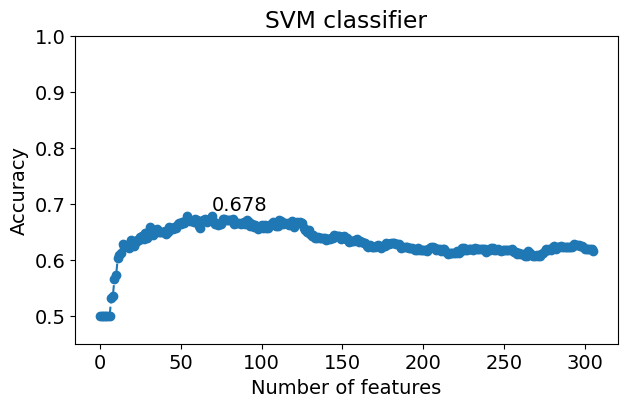

auc_best = 0.67808494
best auc (SVM) =  0.6780849358974359 Number of features =  69
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:04<16:16,  4.91s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:09<16:12,  4.91s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

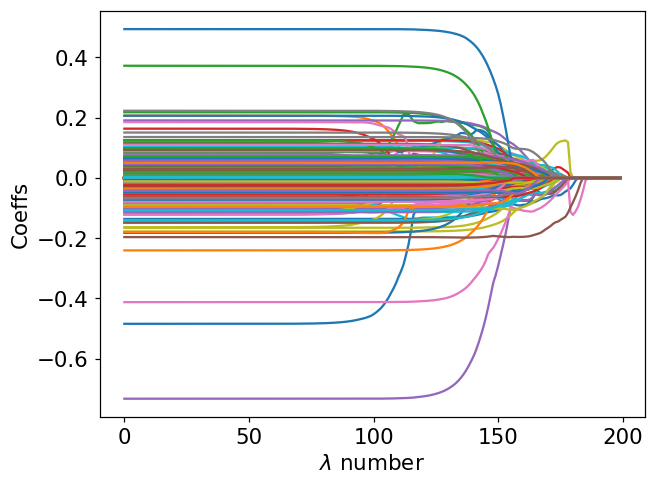

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/306 [00:09<46:17,  9.11s/it]

Iter =  1  UAR = 0.5000
UAR = 0.500


  1%|          | 2/306 [00:18<46:23,  9.16s/it]

UAR = 0.500


  1%|          | 3/306 [00:27<47:09,  9.34s/it]

UAR = 0.500


  1%|▏         | 4/306 [00:37<47:32,  9.45s/it]

UAR = 0.500
UAR = 0.530
UAR = 0.543
UAR = 0.558
UAR = 0.558
UAR = 0.566
UAR = 0.591


  2%|▏         | 5/306 [00:47<48:02,  9.58s/it]

UAR = 0.594
UAR = 0.599
Iter =  5  UAR = 0.5994
UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.559
UAR = 0.601
UAR = 0.611
UAR = 0.628


  2%|▏         | 6/306 [00:57<48:19,  9.67s/it]

UAR = 0.632
UAR = 0.637
UAR = 0.648
Iter =  6  UAR = 0.6484
UAR = 0.500
UAR = 0.523
UAR = 0.561
UAR = 0.563
UAR = 0.601
UAR = 0.613
UAR = 0.627


  2%|▏         | 7/306 [01:07<48:43,  9.78s/it]

UAR = 0.632
UAR = 0.639
UAR = 0.649
Iter =  7  UAR = 0.6488
UAR = 0.500
UAR = 0.503
UAR = 0.527
UAR = 0.575
UAR = 0.606
UAR = 0.612
UAR = 0.616
UAR = 0.626


  3%|▎         | 8/306 [01:17<49:08,  9.89s/it]

UAR = 0.627
UAR = 0.629
UAR = 0.635
UAR = 0.500
UAR = 0.505
UAR = 0.540
UAR = 0.577
UAR = 0.605
UAR = 0.622
UAR = 0.627
UAR = 0.628
UAR = 0.630


  3%|▎         | 9/306 [01:27<49:37, 10.02s/it]

UAR = 0.653
Iter =  9  UAR = 0.6526
UAR = 0.500
UAR = 0.505
UAR = 0.549
UAR = 0.577
UAR = 0.589
UAR = 0.605
UAR = 0.622
UAR = 0.631
UAR = 0.635


  3%|▎         | 10/306 [01:38<50:12, 10.18s/it]

UAR = 0.653
Iter =  10  UAR = 0.6534
UAR = 0.500
UAR = 0.510
UAR = 0.548
UAR = 0.579
UAR = 0.589
UAR = 0.614
UAR = 0.627
UAR = 0.630
UAR = 0.630
UAR = 0.633


  4%|▎         | 11/306 [01:48<50:48, 10.34s/it]

UAR = 0.634
UAR = 0.658
Iter =  11  UAR = 0.6579
UAR = 0.500
UAR = 0.510
UAR = 0.550
UAR = 0.572
UAR = 0.589
UAR = 0.616
UAR = 0.623
UAR = 0.638
UAR = 0.645


  4%|▍         | 12/306 [01:59<51:28, 10.50s/it]

UAR = 0.645
UAR = 0.657
UAR = 0.675
Iter =  12  UAR = 0.6753
UAR = 0.500
UAR = 0.505
UAR = 0.512
UAR = 0.558
UAR = 0.579
UAR = 0.591
UAR = 0.608
UAR = 0.618
UAR = 0.621
UAR = 0.647
UAR = 0.650


  4%|▍         | 13/306 [02:10<52:07, 10.67s/it]

UAR = 0.653
UAR = 0.659
UAR = 0.671
UAR = 0.500
UAR = 0.505
UAR = 0.531
UAR = 0.562
UAR = 0.593
UAR = 0.601
UAR = 0.621
UAR = 0.645
UAR = 0.656
UAR = 0.664
UAR = 0.665
UAR = 0.667
UAR = 0.691
Iter =  14  UAR = 0.6913


  5%|▍         | 14/306 [02:21<52:47, 10.85s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.543
UAR = 0.572
UAR = 0.600
UAR = 0.607
UAR = 0.633
UAR = 0.645
UAR = 0.653
UAR = 0.656
UAR = 0.658
UAR = 0.661
UAR = 0.668


  5%|▍         | 15/306 [02:33<53:23, 11.01s/it]

UAR = 0.669
UAR = 0.684
UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.548
UAR = 0.578
UAR = 0.597
UAR = 0.612
UAR = 0.640
UAR = 0.658
UAR = 0.658
UAR = 0.665
UAR = 0.668
UAR = 0.671
UAR = 0.675


  5%|▌         | 16/306 [02:44<53:01, 10.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.529
UAR = 0.545
UAR = 0.585
UAR = 0.611
UAR = 0.630
UAR = 0.639
UAR = 0.650
UAR = 0.665
UAR = 0.667
UAR = 0.671


  6%|▌         | 17/306 [02:55<52:52, 10.98s/it]

UAR = 0.677
UAR = 0.500
UAR = 0.510
UAR = 0.527
UAR = 0.538
UAR = 0.538
UAR = 0.559
UAR = 0.606
UAR = 0.632
UAR = 0.642
UAR = 0.643
UAR = 0.663
UAR = 0.674


  6%|▌         | 18/306 [03:06<52:54, 11.02s/it]

UAR = 0.685
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.535
UAR = 0.549
UAR = 0.550
UAR = 0.593
UAR = 0.615
UAR = 0.621
UAR = 0.632
UAR = 0.647
UAR = 0.662
UAR = 0.670
UAR = 0.675
UAR = 0.684


  6%|▌         | 19/306 [03:17<53:03, 11.09s/it]

UAR = 0.686
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.534
UAR = 0.543
UAR = 0.553
UAR = 0.588
UAR = 0.615
UAR = 0.624
UAR = 0.639
UAR = 0.646
UAR = 0.657
UAR = 0.657
UAR = 0.668
UAR = 0.668
UAR = 0.679
UAR = 0.683


  7%|▋         | 20/306 [03:29<53:28, 11.22s/it]

UAR = 0.685
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.529
UAR = 0.535
UAR = 0.547
UAR = 0.583
UAR = 0.616
UAR = 0.621
UAR = 0.637
UAR = 0.658
UAR = 0.670
UAR = 0.670
UAR = 0.682


  7%|▋         | 21/306 [03:40<53:56, 11.36s/it]

UAR = 0.693
Iter =  21  UAR = 0.6929
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.533
UAR = 0.538
UAR = 0.549
UAR = 0.589
UAR = 0.619
UAR = 0.632
UAR = 0.644
UAR = 0.668
UAR = 0.670
UAR = 0.671
UAR = 0.672
UAR = 0.683


  7%|▋         | 22/306 [03:52<54:26, 11.50s/it]

UAR = 0.706
Iter =  22  UAR = 0.7059
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.533
UAR = 0.538
UAR = 0.552
UAR = 0.587
UAR = 0.619
UAR = 0.632
UAR = 0.642
UAR = 0.663
UAR = 0.668
UAR = 0.671
UAR = 0.671
UAR = 0.680
UAR = 0.685


  8%|▊         | 23/306 [04:04<54:59, 11.66s/it]

UAR = 0.701
UAR = 0.703
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.537
UAR = 0.549
UAR = 0.576
UAR = 0.612
UAR = 0.640
UAR = 0.652
UAR = 0.672
UAR = 0.692
UAR = 0.698
UAR = 0.699
UAR = 0.707
UAR = 0.714


  8%|▊         | 24/306 [04:16<55:19, 11.77s/it]

UAR = 0.732
Iter =  24  UAR = 0.7324
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.537
UAR = 0.540
UAR = 0.576
UAR = 0.612
UAR = 0.638
UAR = 0.649
UAR = 0.675
UAR = 0.689
UAR = 0.700
UAR = 0.703
UAR = 0.719


  8%|▊         | 25/306 [04:28<55:42, 11.89s/it]

UAR = 0.729
UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.541
UAR = 0.545
UAR = 0.582
UAR = 0.611
UAR = 0.641
UAR = 0.653
UAR = 0.666
UAR = 0.675
UAR = 0.676
UAR = 0.678
UAR = 0.686
UAR = 0.693
UAR = 0.708


  8%|▊         | 26/306 [04:41<56:11, 12.04s/it]

UAR = 0.714
UAR = 0.720
UAR = 0.500
UAR = 0.508
UAR = 0.528
UAR = 0.547
UAR = 0.549
UAR = 0.597
UAR = 0.623
UAR = 0.659
UAR = 0.682
UAR = 0.688
UAR = 0.696
UAR = 0.708
UAR = 0.710
UAR = 0.714


  9%|▉         | 27/306 [04:53<56:35, 12.17s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.522
UAR = 0.537
UAR = 0.544
UAR = 0.603
UAR = 0.632
UAR = 0.654
UAR = 0.656
UAR = 0.668
UAR = 0.685
UAR = 0.689
UAR = 0.705
UAR = 0.708
UAR = 0.710
UAR = 0.715
UAR = 0.719


  9%|▉         | 28/306 [05:06<57:04, 12.32s/it]

UAR = 0.720
UAR = 0.720
UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.534
UAR = 0.538
UAR = 0.542
UAR = 0.603
UAR = 0.639
UAR = 0.654
UAR = 0.656
UAR = 0.670
UAR = 0.673
UAR = 0.686
UAR = 0.687
UAR = 0.689
UAR = 0.702
UAR = 0.703
UAR = 0.705
UAR = 0.712


  9%|▉         | 29/306 [05:19<57:37, 12.48s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.522
UAR = 0.534
UAR = 0.542
UAR = 0.602
UAR = 0.630
UAR = 0.656
UAR = 0.657
UAR = 0.674
UAR = 0.676
UAR = 0.692
UAR = 0.698
UAR = 0.706
UAR = 0.708
UAR = 0.708


 10%|▉         | 30/306 [05:32<58:01, 12.62s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.521
UAR = 0.531
UAR = 0.545
UAR = 0.599
UAR = 0.627
UAR = 0.659
UAR = 0.675
UAR = 0.680
UAR = 0.690
UAR = 0.690
UAR = 0.714
UAR = 0.715
UAR = 0.719


 10%|█         | 31/306 [05:45<58:32, 12.77s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.521
UAR = 0.531
UAR = 0.542
UAR = 0.601
UAR = 0.624
UAR = 0.653
UAR = 0.668
UAR = 0.674
UAR = 0.694
UAR = 0.698
UAR = 0.712
UAR = 0.713
UAR = 0.717
UAR = 0.719
UAR = 0.722


 10%|█         | 32/306 [05:57<56:58, 12.48s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.512
UAR = 0.526
UAR = 0.538
UAR = 0.555
UAR = 0.604
UAR = 0.650
UAR = 0.651
UAR = 0.671
UAR = 0.684
UAR = 0.691
UAR = 0.696
UAR = 0.708
UAR = 0.708
UAR = 0.716
UAR = 0.718
UAR = 0.719


 11%|█         | 33/306 [06:09<55:57, 12.30s/it]

UAR = 0.722
UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.528
UAR = 0.535
UAR = 0.549
UAR = 0.603
UAR = 0.644
UAR = 0.646
UAR = 0.654
UAR = 0.671
UAR = 0.686
UAR = 0.691
UAR = 0.696
UAR = 0.712
UAR = 0.715
UAR = 0.723


 11%|█         | 34/306 [06:21<55:27, 12.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.517
UAR = 0.528
UAR = 0.535
UAR = 0.552
UAR = 0.598
UAR = 0.641
UAR = 0.645
UAR = 0.647
UAR = 0.668
UAR = 0.680
UAR = 0.696
UAR = 0.699
UAR = 0.726


 11%|█▏        | 35/306 [06:33<55:17, 12.24s/it]

UAR = 0.728
UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.534
UAR = 0.537
UAR = 0.565
UAR = 0.611
UAR = 0.642
UAR = 0.655
UAR = 0.660
UAR = 0.668
UAR = 0.684
UAR = 0.705
UAR = 0.712
UAR = 0.717
UAR = 0.722
UAR = 0.726
UAR = 0.726


 12%|█▏        | 36/306 [06:45<55:21, 12.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.524
UAR = 0.540
UAR = 0.574
UAR = 0.621
UAR = 0.650
UAR = 0.668
UAR = 0.671
UAR = 0.708
UAR = 0.715
UAR = 0.730
UAR = 0.731
UAR = 0.741
Iter =  37  UAR = 0.7408


 12%|█▏        | 37/306 [06:58<55:36, 12.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.521
UAR = 0.531
UAR = 0.579
UAR = 0.619
UAR = 0.648
UAR = 0.661
UAR = 0.669
UAR = 0.698
UAR = 0.700
UAR = 0.704
UAR = 0.719
UAR = 0.725
UAR = 0.738
UAR = 0.741


 12%|█▏        | 38/306 [07:11<55:54, 12.52s/it]

Iter =  38  UAR = 0.7410
UAR = 0.500
UAR = 0.505
UAR = 0.515
UAR = 0.521
UAR = 0.532
UAR = 0.582
UAR = 0.625
UAR = 0.648
UAR = 0.656
UAR = 0.661
UAR = 0.674
UAR = 0.707
UAR = 0.718
UAR = 0.719
UAR = 0.726
UAR = 0.736
UAR = 0.741


 13%|█▎        | 39/306 [07:24<56:18, 12.65s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.534
UAR = 0.541
UAR = 0.594
UAR = 0.627
UAR = 0.654
UAR = 0.672
UAR = 0.680
UAR = 0.706
UAR = 0.710
UAR = 0.718
UAR = 0.721
UAR = 0.732


 13%|█▎        | 40/306 [07:37<56:22, 12.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.539
UAR = 0.593
UAR = 0.639
UAR = 0.658
UAR = 0.673
UAR = 0.689
UAR = 0.702
UAR = 0.702
UAR = 0.703
UAR = 0.706
UAR = 0.713
UAR = 0.713
UAR = 0.718
UAR = 0.727


 13%|█▎        | 41/306 [07:50<56:36, 12.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.530
UAR = 0.539
UAR = 0.541
UAR = 0.593
UAR = 0.636
UAR = 0.657
UAR = 0.670
UAR = 0.691
UAR = 0.700
UAR = 0.707
UAR = 0.712
UAR = 0.721
UAR = 0.738


 14%|█▎        | 42/306 [08:03<56:55, 12.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.531
UAR = 0.536
UAR = 0.538
UAR = 0.596
UAR = 0.629
UAR = 0.651
UAR = 0.668
UAR = 0.677
UAR = 0.697
UAR = 0.700
UAR = 0.702
UAR = 0.718
UAR = 0.724
UAR = 0.737


 14%|█▍        | 43/306 [08:16<57:19, 13.08s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.531
UAR = 0.541
UAR = 0.596
UAR = 0.630
UAR = 0.652
UAR = 0.671
UAR = 0.678
UAR = 0.709
UAR = 0.723
UAR = 0.723
UAR = 0.731


 14%|█▍        | 44/306 [08:30<57:50, 13.25s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.531
UAR = 0.546
UAR = 0.593
UAR = 0.632
UAR = 0.649
UAR = 0.674
UAR = 0.677
UAR = 0.695
UAR = 0.708
UAR = 0.720
UAR = 0.722
UAR = 0.731


 15%|█▍        | 45/306 [08:44<58:19, 13.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.528
UAR = 0.531
UAR = 0.544
UAR = 0.593
UAR = 0.631
UAR = 0.647
UAR = 0.667
UAR = 0.684
UAR = 0.709
UAR = 0.725
UAR = 0.732
UAR = 0.733
UAR = 0.735


 15%|█▌        | 46/306 [08:58<58:46, 13.56s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.544
UAR = 0.591
UAR = 0.631
UAR = 0.643
UAR = 0.667
UAR = 0.681
UAR = 0.706
UAR = 0.713
UAR = 0.723
UAR = 0.727


 15%|█▌        | 47/306 [09:12<59:17, 13.74s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.544
UAR = 0.590
UAR = 0.629
UAR = 0.649
UAR = 0.663
UAR = 0.676
UAR = 0.707
UAR = 0.709
UAR = 0.719
UAR = 0.721
UAR = 0.725
UAR = 0.727
UAR = 0.731


 16%|█▌        | 48/306 [09:24<57:47, 13.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.546
UAR = 0.592
UAR = 0.630
UAR = 0.645
UAR = 0.662
UAR = 0.684
UAR = 0.707
UAR = 0.709
UAR = 0.711
UAR = 0.715
UAR = 0.728
UAR = 0.731
UAR = 0.736


 16%|█▌        | 49/306 [09:37<57:00, 13.31s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.523
UAR = 0.546
UAR = 0.595
UAR = 0.630
UAR = 0.655
UAR = 0.660
UAR = 0.693
UAR = 0.704
UAR = 0.711
UAR = 0.723
UAR = 0.724
UAR = 0.729
UAR = 0.751
UAR = 0.756


 16%|█▋        | 50/306 [09:51<56:37, 13.27s/it]

Iter =  50  UAR = 0.7562
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.592
UAR = 0.631
UAR = 0.660
UAR = 0.664
UAR = 0.695
UAR = 0.704
UAR = 0.710
UAR = 0.716
UAR = 0.723
UAR = 0.733
UAR = 0.749


 17%|█▋        | 51/306 [10:04<56:32, 13.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.595
UAR = 0.629
UAR = 0.650
UAR = 0.662
UAR = 0.689
UAR = 0.708
UAR = 0.713
UAR = 0.720
UAR = 0.721
UAR = 0.744


 17%|█▋        | 52/306 [10:18<56:43, 13.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.526
UAR = 0.549
UAR = 0.598
UAR = 0.629
UAR = 0.653
UAR = 0.657
UAR = 0.684
UAR = 0.708
UAR = 0.714
UAR = 0.718
UAR = 0.721
UAR = 0.748


 17%|█▋        | 53/306 [10:31<57:02, 13.53s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.549
UAR = 0.600
UAR = 0.629
UAR = 0.653
UAR = 0.658
UAR = 0.682
UAR = 0.708
UAR = 0.714
UAR = 0.726
UAR = 0.740


 18%|█▊        | 54/306 [10:46<57:28, 13.68s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.523
UAR = 0.549
UAR = 0.602
UAR = 0.635
UAR = 0.654
UAR = 0.662
UAR = 0.688
UAR = 0.708
UAR = 0.718
UAR = 0.720
UAR = 0.722
UAR = 0.731


 18%|█▊        | 55/306 [11:00<57:54, 13.84s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.521
UAR = 0.554
UAR = 0.600
UAR = 0.635
UAR = 0.655
UAR = 0.659
UAR = 0.673
UAR = 0.700
UAR = 0.706
UAR = 0.710
UAR = 0.722
UAR = 0.729


 18%|█▊        | 56/306 [11:14<58:13, 13.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.513
UAR = 0.554
UAR = 0.600
UAR = 0.632
UAR = 0.658
UAR = 0.659
UAR = 0.681
UAR = 0.696
UAR = 0.698
UAR = 0.704
UAR = 0.705
UAR = 0.710
UAR = 0.718
UAR = 0.723


 19%|█▊        | 57/306 [11:29<58:40, 14.14s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.513
UAR = 0.554
UAR = 0.605
UAR = 0.634
UAR = 0.653
UAR = 0.662
UAR = 0.677
UAR = 0.693
UAR = 0.696
UAR = 0.704
UAR = 0.708
UAR = 0.712
UAR = 0.720
UAR = 0.721


 19%|█▉        | 58/306 [11:43<59:12, 14.32s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.513
UAR = 0.554
UAR = 0.605
UAR = 0.633
UAR = 0.653
UAR = 0.662
UAR = 0.675
UAR = 0.690
UAR = 0.694
UAR = 0.709
UAR = 0.714
UAR = 0.718
UAR = 0.729


 19%|█▉        | 59/306 [11:58<59:42, 14.50s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.513
UAR = 0.557
UAR = 0.608
UAR = 0.635
UAR = 0.652
UAR = 0.662
UAR = 0.670
UAR = 0.699
UAR = 0.701
UAR = 0.706
UAR = 0.712
UAR = 0.714
UAR = 0.714
UAR = 0.734


 20%|█▉        | 60/306 [12:13<1:00:13, 14.69s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.513
UAR = 0.557
UAR = 0.609
UAR = 0.640
UAR = 0.658
UAR = 0.662
UAR = 0.683
UAR = 0.694
UAR = 0.696
UAR = 0.711
UAR = 0.717
UAR = 0.721
UAR = 0.735


 20%|█▉        | 61/306 [12:29<1:00:42, 14.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.513
UAR = 0.557
UAR = 0.609
UAR = 0.640
UAR = 0.658
UAR = 0.663
UAR = 0.683
UAR = 0.701
UAR = 0.710
UAR = 0.717
UAR = 0.725
UAR = 0.733


 20%|██        | 62/306 [12:44<1:01:13, 15.06s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.510
UAR = 0.557
UAR = 0.608
UAR = 0.639
UAR = 0.658
UAR = 0.663
UAR = 0.688
UAR = 0.696
UAR = 0.701
UAR = 0.709
UAR = 0.720
UAR = 0.723
UAR = 0.730


 21%|██        | 63/306 [13:00<1:01:46, 15.25s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.510
UAR = 0.559
UAR = 0.608
UAR = 0.640
UAR = 0.655
UAR = 0.660
UAR = 0.684
UAR = 0.704
UAR = 0.706
UAR = 0.712
UAR = 0.726
UAR = 0.735
UAR = 0.742
UAR = 0.745


 21%|██        | 64/306 [13:14<59:48, 14.83s/it]  

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.510
UAR = 0.557
UAR = 0.606
UAR = 0.646
UAR = 0.661
UAR = 0.661
UAR = 0.692
UAR = 0.702
UAR = 0.714
UAR = 0.718
UAR = 0.738
UAR = 0.742


 21%|██        | 65/306 [13:28<58:34, 14.58s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.559
UAR = 0.603
UAR = 0.639
UAR = 0.658
UAR = 0.661
UAR = 0.689
UAR = 0.702
UAR = 0.704
UAR = 0.717
UAR = 0.721
UAR = 0.740
UAR = 0.743


 22%|██▏       | 66/306 [13:42<57:58, 14.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.510
UAR = 0.554
UAR = 0.603
UAR = 0.636
UAR = 0.656
UAR = 0.658
UAR = 0.683
UAR = 0.697
UAR = 0.716
UAR = 0.718
UAR = 0.731
UAR = 0.736
UAR = 0.740


 22%|██▏       | 67/306 [13:57<57:47, 14.51s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.510
UAR = 0.556
UAR = 0.603
UAR = 0.636
UAR = 0.652
UAR = 0.659
UAR = 0.683
UAR = 0.697
UAR = 0.714
UAR = 0.723
UAR = 0.727
UAR = 0.734
UAR = 0.737


 22%|██▏       | 68/306 [14:11<57:52, 14.59s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.510
UAR = 0.557
UAR = 0.606
UAR = 0.633
UAR = 0.657
UAR = 0.681
UAR = 0.700
UAR = 0.701
UAR = 0.706
UAR = 0.715
UAR = 0.729
UAR = 0.747


 23%|██▎       | 69/306 [14:26<58:07, 14.72s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.510
UAR = 0.554
UAR = 0.600
UAR = 0.638
UAR = 0.655
UAR = 0.655
UAR = 0.682
UAR = 0.703
UAR = 0.704
UAR = 0.715
UAR = 0.729
UAR = 0.737


 23%|██▎       | 70/306 [14:42<58:43, 14.93s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.510
UAR = 0.554
UAR = 0.600
UAR = 0.636
UAR = 0.652
UAR = 0.652
UAR = 0.685
UAR = 0.700
UAR = 0.701
UAR = 0.704
UAR = 0.710
UAR = 0.720
UAR = 0.723
UAR = 0.732


 23%|██▎       | 71/306 [14:57<59:21, 15.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.552
UAR = 0.600
UAR = 0.637
UAR = 0.657
UAR = 0.658
UAR = 0.685
UAR = 0.696
UAR = 0.704
UAR = 0.712
UAR = 0.725
UAR = 0.735
UAR = 0.739
UAR = 0.744


 24%|██▎       | 72/306 [15:13<59:49, 15.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.552
UAR = 0.598
UAR = 0.637
UAR = 0.655
UAR = 0.659
UAR = 0.685
UAR = 0.704
UAR = 0.713
UAR = 0.728
UAR = 0.735
UAR = 0.742


 24%|██▍       | 73/306 [15:29<1:00:18, 15.53s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.554
UAR = 0.598
UAR = 0.637
UAR = 0.656
UAR = 0.660
UAR = 0.694
UAR = 0.707
UAR = 0.708
UAR = 0.721
UAR = 0.725
UAR = 0.726
UAR = 0.746


 24%|██▍       | 74/306 [15:45<1:00:55, 15.75s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.513
UAR = 0.557
UAR = 0.603
UAR = 0.637
UAR = 0.656
UAR = 0.658
UAR = 0.693
UAR = 0.707
UAR = 0.707
UAR = 0.724
UAR = 0.733
UAR = 0.738
UAR = 0.740


 25%|██▍       | 75/306 [16:02<1:01:32, 15.98s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.513
UAR = 0.573
UAR = 0.610
UAR = 0.645
UAR = 0.659
UAR = 0.661
UAR = 0.690
UAR = 0.710
UAR = 0.720
UAR = 0.722
UAR = 0.734
UAR = 0.739


 25%|██▍       | 76/306 [16:19<1:02:10, 16.22s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.568
UAR = 0.605
UAR = 0.645
UAR = 0.656
UAR = 0.660
UAR = 0.691
UAR = 0.713
UAR = 0.714
UAR = 0.724
UAR = 0.737
UAR = 0.740
UAR = 0.742


 25%|██▌       | 77/306 [16:36<1:02:47, 16.45s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.571
UAR = 0.606
UAR = 0.639
UAR = 0.652
UAR = 0.662
UAR = 0.698
UAR = 0.717
UAR = 0.726
UAR = 0.731
UAR = 0.743
UAR = 0.749
UAR = 0.754


 25%|██▌       | 78/306 [16:53<1:03:17, 16.66s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.571
UAR = 0.607
UAR = 0.638
UAR = 0.652
UAR = 0.665
UAR = 0.700
UAR = 0.716
UAR = 0.731
UAR = 0.740
UAR = 0.741
UAR = 0.744
UAR = 0.751
UAR = 0.760


 26%|██▌       | 79/306 [17:10<1:03:56, 16.90s/it]

Iter =  79  UAR = 0.7602
UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.571
UAR = 0.609
UAR = 0.640
UAR = 0.655
UAR = 0.670
UAR = 0.703
UAR = 0.716
UAR = 0.722
UAR = 0.731
UAR = 0.741
UAR = 0.743
UAR = 0.751


 26%|██▌       | 80/306 [17:25<1:01:35, 16.35s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.571
UAR = 0.609
UAR = 0.641
UAR = 0.652
UAR = 0.667
UAR = 0.703
UAR = 0.716
UAR = 0.722
UAR = 0.731
UAR = 0.733
UAR = 0.738
UAR = 0.739
UAR = 0.742
UAR = 0.751


 26%|██▋       | 81/306 [17:41<1:00:06, 16.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.515
UAR = 0.567
UAR = 0.606
UAR = 0.639
UAR = 0.652
UAR = 0.673
UAR = 0.703
UAR = 0.715
UAR = 0.723
UAR = 0.728
UAR = 0.734
UAR = 0.746


 27%|██▋       | 82/306 [17:56<59:18, 15.89s/it]  

UAR = 0.500
UAR = 0.515
UAR = 0.572
UAR = 0.612
UAR = 0.639
UAR = 0.650
UAR = 0.677
UAR = 0.702
UAR = 0.713
UAR = 0.713
UAR = 0.720
UAR = 0.725
UAR = 0.734
UAR = 0.736
UAR = 0.741


 27%|██▋       | 83/306 [18:12<58:55, 15.86s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.570
UAR = 0.612
UAR = 0.642
UAR = 0.653
UAR = 0.675
UAR = 0.700
UAR = 0.713
UAR = 0.714
UAR = 0.718
UAR = 0.731
UAR = 0.736
UAR = 0.738
UAR = 0.738
UAR = 0.745


 27%|██▋       | 84/306 [18:28<58:58, 15.94s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.567
UAR = 0.612
UAR = 0.642
UAR = 0.653
UAR = 0.673
UAR = 0.695
UAR = 0.712
UAR = 0.713
UAR = 0.720
UAR = 0.731
UAR = 0.739
UAR = 0.743
UAR = 0.743


 28%|██▊       | 85/306 [18:45<59:28, 16.15s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.567
UAR = 0.609
UAR = 0.639
UAR = 0.656
UAR = 0.670
UAR = 0.690
UAR = 0.707
UAR = 0.708
UAR = 0.713
UAR = 0.725
UAR = 0.736
UAR = 0.742


 28%|██▊       | 86/306 [19:02<59:58, 16.36s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.567
UAR = 0.609
UAR = 0.642
UAR = 0.653
UAR = 0.670
UAR = 0.695
UAR = 0.713
UAR = 0.717
UAR = 0.728
UAR = 0.735
UAR = 0.740


 28%|██▊       | 87/306 [19:19<1:00:34, 16.60s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.568
UAR = 0.609
UAR = 0.639
UAR = 0.651
UAR = 0.672
UAR = 0.692
UAR = 0.709
UAR = 0.710
UAR = 0.722
UAR = 0.729
UAR = 0.738


 29%|██▉       | 88/306 [19:36<1:00:59, 16.79s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.609
UAR = 0.642
UAR = 0.653
UAR = 0.674
UAR = 0.697
UAR = 0.711
UAR = 0.712
UAR = 0.716
UAR = 0.726
UAR = 0.728
UAR = 0.740


 29%|██▉       | 89/306 [19:54<1:01:29, 17.00s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.568
UAR = 0.604
UAR = 0.642
UAR = 0.658
UAR = 0.677
UAR = 0.698
UAR = 0.711
UAR = 0.713
UAR = 0.726
UAR = 0.734
UAR = 0.740


 29%|██▉       | 90/306 [20:11<1:02:04, 17.24s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.568
UAR = 0.607
UAR = 0.639
UAR = 0.658
UAR = 0.675
UAR = 0.700
UAR = 0.714
UAR = 0.727
UAR = 0.737
UAR = 0.743
UAR = 0.743


 30%|██▉       | 91/306 [20:29<1:02:33, 17.46s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.568
UAR = 0.602
UAR = 0.642
UAR = 0.653
UAR = 0.674
UAR = 0.703
UAR = 0.714
UAR = 0.720
UAR = 0.724
UAR = 0.733
UAR = 0.740
UAR = 0.760


 30%|███       | 92/306 [20:47<1:03:02, 17.67s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.601
UAR = 0.642
UAR = 0.653
UAR = 0.672
UAR = 0.703
UAR = 0.709
UAR = 0.720
UAR = 0.724
UAR = 0.731
UAR = 0.733
UAR = 0.743
UAR = 0.760


 30%|███       | 93/306 [21:06<1:03:31, 17.90s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.601
UAR = 0.640
UAR = 0.654
UAR = 0.676
UAR = 0.704
UAR = 0.718
UAR = 0.729
UAR = 0.733
UAR = 0.742
UAR = 0.751
UAR = 0.764


 31%|███       | 94/306 [21:25<1:04:27, 18.24s/it]

Iter =  94  UAR = 0.7640
UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.601
UAR = 0.640
UAR = 0.654
UAR = 0.673
UAR = 0.704
UAR = 0.721
UAR = 0.726
UAR = 0.737
UAR = 0.737
UAR = 0.747
UAR = 0.756


 31%|███       | 95/306 [21:44<1:05:06, 18.52s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.601
UAR = 0.640
UAR = 0.654
UAR = 0.673
UAR = 0.704
UAR = 0.718
UAR = 0.726
UAR = 0.740
UAR = 0.747
UAR = 0.757


 31%|███▏      | 96/306 [22:01<1:02:51, 17.96s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.602
UAR = 0.640
UAR = 0.654
UAR = 0.676
UAR = 0.704
UAR = 0.718
UAR = 0.719
UAR = 0.726
UAR = 0.735
UAR = 0.737
UAR = 0.752
UAR = 0.752


 32%|███▏      | 97/306 [22:18<1:01:31, 17.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.571
UAR = 0.602
UAR = 0.640
UAR = 0.651
UAR = 0.676
UAR = 0.704
UAR = 0.716
UAR = 0.718
UAR = 0.723
UAR = 0.726
UAR = 0.740
UAR = 0.751
UAR = 0.755


 32%|███▏      | 98/306 [22:35<1:00:42, 17.51s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.604
UAR = 0.643
UAR = 0.651
UAR = 0.681
UAR = 0.703
UAR = 0.715
UAR = 0.718
UAR = 0.720
UAR = 0.731
UAR = 0.740
UAR = 0.751
UAR = 0.757


 32%|███▏      | 99/306 [22:52<1:00:17, 17.48s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.568
UAR = 0.604
UAR = 0.643
UAR = 0.648
UAR = 0.687
UAR = 0.706
UAR = 0.716
UAR = 0.720
UAR = 0.721
UAR = 0.736
UAR = 0.741
UAR = 0.753
UAR = 0.757


 33%|███▎      | 100/306 [23:10<1:00:10, 17.53s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.565
UAR = 0.601
UAR = 0.643
UAR = 0.651
UAR = 0.684
UAR = 0.701
UAR = 0.719
UAR = 0.724
UAR = 0.739
UAR = 0.740
UAR = 0.753


 33%|███▎      | 101/306 [23:28<1:00:20, 17.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.565
UAR = 0.599
UAR = 0.643
UAR = 0.648
UAR = 0.679
UAR = 0.701
UAR = 0.721
UAR = 0.723
UAR = 0.734
UAR = 0.738
UAR = 0.748
UAR = 0.754


 33%|███▎      | 102/306 [23:46<1:00:42, 17.85s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.568
UAR = 0.604
UAR = 0.643
UAR = 0.648
UAR = 0.679
UAR = 0.701
UAR = 0.717
UAR = 0.724
UAR = 0.731
UAR = 0.738
UAR = 0.748
UAR = 0.753


 34%|███▎      | 103/306 [24:05<1:01:18, 18.12s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.604
UAR = 0.640
UAR = 0.648
UAR = 0.648
UAR = 0.680
UAR = 0.699
UAR = 0.706
UAR = 0.715
UAR = 0.716
UAR = 0.732
UAR = 0.736
UAR = 0.740
UAR = 0.758


 34%|███▍      | 104/306 [24:24<1:01:45, 18.34s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.607
UAR = 0.640
UAR = 0.645
UAR = 0.677
UAR = 0.699
UAR = 0.709
UAR = 0.712
UAR = 0.717
UAR = 0.736
UAR = 0.739
UAR = 0.759


 34%|███▍      | 105/306 [24:43<1:02:11, 18.56s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.607
UAR = 0.641
UAR = 0.645
UAR = 0.680
UAR = 0.702
UAR = 0.709
UAR = 0.711
UAR = 0.721
UAR = 0.733
UAR = 0.743
UAR = 0.745
UAR = 0.765


 35%|███▍      | 106/306 [25:02<1:02:39, 18.80s/it]

Iter =  106  UAR = 0.7654
UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.607
UAR = 0.643
UAR = 0.650
UAR = 0.685
UAR = 0.699
UAR = 0.707
UAR = 0.712
UAR = 0.726
UAR = 0.733
UAR = 0.745
UAR = 0.748
UAR = 0.754
UAR = 0.764


 35%|███▍      | 107/306 [25:22<1:03:38, 19.19s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.562
UAR = 0.606
UAR = 0.643
UAR = 0.646
UAR = 0.653
UAR = 0.679
UAR = 0.706
UAR = 0.708
UAR = 0.731
UAR = 0.744
UAR = 0.748
UAR = 0.750
UAR = 0.759


 35%|███▌      | 108/306 [25:43<1:04:41, 19.60s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.562
UAR = 0.606
UAR = 0.643
UAR = 0.644
UAR = 0.650
UAR = 0.683
UAR = 0.708
UAR = 0.718
UAR = 0.731
UAR = 0.738
UAR = 0.747
UAR = 0.749
UAR = 0.750
UAR = 0.761


 36%|███▌      | 109/306 [26:04<1:05:35, 19.97s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.563
UAR = 0.604
UAR = 0.635
UAR = 0.644
UAR = 0.652
UAR = 0.683
UAR = 0.710
UAR = 0.717
UAR = 0.736
UAR = 0.738
UAR = 0.747
UAR = 0.749
UAR = 0.761


 36%|███▌      | 110/306 [26:25<1:06:20, 20.31s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.562
UAR = 0.601
UAR = 0.638
UAR = 0.646
UAR = 0.655
UAR = 0.686
UAR = 0.713
UAR = 0.715
UAR = 0.718
UAR = 0.736
UAR = 0.738
UAR = 0.742
UAR = 0.751
UAR = 0.766


 36%|███▋      | 111/306 [26:46<1:07:05, 20.64s/it]

Iter =  111  UAR = 0.7662
UAR = 0.500
UAR = 0.526
UAR = 0.565
UAR = 0.603
UAR = 0.641
UAR = 0.644
UAR = 0.655
UAR = 0.692
UAR = 0.714
UAR = 0.716
UAR = 0.717
UAR = 0.739
UAR = 0.743
UAR = 0.749
UAR = 0.752
UAR = 0.756
UAR = 0.768


 37%|███▋      | 112/306 [27:05<1:04:57, 20.09s/it]

Iter =  112  UAR = 0.7684
UAR = 0.500
UAR = 0.526
UAR = 0.565
UAR = 0.601
UAR = 0.641
UAR = 0.644
UAR = 0.650
UAR = 0.695
UAR = 0.711
UAR = 0.720
UAR = 0.722
UAR = 0.736
UAR = 0.746
UAR = 0.747
UAR = 0.760
UAR = 0.766
UAR = 0.771


 37%|███▋      | 113/306 [27:24<1:03:36, 19.77s/it]

Iter =  113  UAR = 0.7710
UAR = 0.500
UAR = 0.526
UAR = 0.565
UAR = 0.604
UAR = 0.639
UAR = 0.647
UAR = 0.690
UAR = 0.711
UAR = 0.721
UAR = 0.730
UAR = 0.748
UAR = 0.764
UAR = 0.766
UAR = 0.769


 37%|███▋      | 114/306 [27:44<1:02:58, 19.68s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.603
UAR = 0.639
UAR = 0.649
UAR = 0.688
UAR = 0.714
UAR = 0.721
UAR = 0.732
UAR = 0.743
UAR = 0.746
UAR = 0.763
UAR = 0.764
UAR = 0.765


 38%|███▊      | 115/306 [28:03<1:02:35, 19.66s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.604
UAR = 0.639
UAR = 0.649
UAR = 0.685
UAR = 0.706
UAR = 0.716
UAR = 0.717
UAR = 0.729
UAR = 0.743
UAR = 0.743
UAR = 0.755
UAR = 0.759
UAR = 0.761
UAR = 0.767


 38%|███▊      | 116/306 [28:23<1:02:40, 19.79s/it]

UAR = 0.500
UAR = 0.528
UAR = 0.567
UAR = 0.596
UAR = 0.637
UAR = 0.649
UAR = 0.683
UAR = 0.701
UAR = 0.703
UAR = 0.707
UAR = 0.721
UAR = 0.727
UAR = 0.742
UAR = 0.757
UAR = 0.764


 38%|███▊      | 117/306 [28:44<1:03:07, 20.04s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.596
UAR = 0.637
UAR = 0.648
UAR = 0.683
UAR = 0.703
UAR = 0.707
UAR = 0.718
UAR = 0.727
UAR = 0.736
UAR = 0.737
UAR = 0.752
UAR = 0.770


 39%|███▊      | 118/306 [29:05<1:03:31, 20.27s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.564
UAR = 0.596
UAR = 0.629
UAR = 0.646
UAR = 0.684
UAR = 0.706
UAR = 0.707
UAR = 0.718
UAR = 0.719
UAR = 0.740
UAR = 0.755
UAR = 0.761


 39%|███▉      | 119/306 [29:26<1:03:56, 20.52s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.561
UAR = 0.596
UAR = 0.631
UAR = 0.646
UAR = 0.684
UAR = 0.706
UAR = 0.721
UAR = 0.721
UAR = 0.740
UAR = 0.742
UAR = 0.758


 39%|███▉      | 120/306 [29:47<1:04:13, 20.72s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.564
UAR = 0.596
UAR = 0.629
UAR = 0.649
UAR = 0.686
UAR = 0.707
UAR = 0.721
UAR = 0.740
UAR = 0.742
UAR = 0.749
UAR = 0.758


 40%|███▉      | 121/306 [30:08<1:04:35, 20.95s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.564
UAR = 0.596
UAR = 0.631
UAR = 0.649
UAR = 0.686
UAR = 0.707
UAR = 0.721
UAR = 0.721
UAR = 0.742
UAR = 0.742
UAR = 0.749
UAR = 0.761


 40%|███▉      | 122/306 [30:30<1:05:04, 21.22s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.564
UAR = 0.597
UAR = 0.629
UAR = 0.651
UAR = 0.689
UAR = 0.700
UAR = 0.706
UAR = 0.717
UAR = 0.721
UAR = 0.741
UAR = 0.746
UAR = 0.758


 40%|████      | 123/306 [30:52<1:05:37, 21.52s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.565
UAR = 0.596
UAR = 0.629
UAR = 0.646
UAR = 0.684
UAR = 0.701
UAR = 0.701
UAR = 0.717
UAR = 0.722
UAR = 0.731
UAR = 0.736
UAR = 0.748
UAR = 0.752


 41%|████      | 124/306 [31:15<1:06:17, 21.85s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.562
UAR = 0.597
UAR = 0.629
UAR = 0.644
UAR = 0.686
UAR = 0.701
UAR = 0.702
UAR = 0.716
UAR = 0.723
UAR = 0.731
UAR = 0.736
UAR = 0.745
UAR = 0.758


 41%|████      | 125/306 [31:38<1:06:51, 22.16s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.562
UAR = 0.595
UAR = 0.634
UAR = 0.650
UAR = 0.688
UAR = 0.705
UAR = 0.707
UAR = 0.719
UAR = 0.724
UAR = 0.734
UAR = 0.736
UAR = 0.747
UAR = 0.749
UAR = 0.759


 41%|████      | 126/306 [32:01<1:07:21, 22.45s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.562
UAR = 0.595
UAR = 0.631
UAR = 0.645
UAR = 0.686
UAR = 0.701
UAR = 0.705
UAR = 0.716
UAR = 0.722
UAR = 0.733
UAR = 0.734
UAR = 0.747
UAR = 0.749
UAR = 0.759


 42%|████▏     | 127/306 [32:25<1:07:55, 22.77s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.563
UAR = 0.592
UAR = 0.629
UAR = 0.648
UAR = 0.683
UAR = 0.700
UAR = 0.707
UAR = 0.719
UAR = 0.724
UAR = 0.736
UAR = 0.740
UAR = 0.748
UAR = 0.749


 42%|████▏     | 128/306 [32:45<1:05:46, 22.17s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.563
UAR = 0.595
UAR = 0.626
UAR = 0.650
UAR = 0.688
UAR = 0.706
UAR = 0.710
UAR = 0.720
UAR = 0.727
UAR = 0.735
UAR = 0.740
UAR = 0.748
UAR = 0.749
UAR = 0.754


 42%|████▏     | 129/306 [33:06<1:04:21, 21.81s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.560
UAR = 0.595
UAR = 0.624
UAR = 0.650
UAR = 0.688
UAR = 0.703
UAR = 0.712
UAR = 0.723
UAR = 0.730
UAR = 0.734
UAR = 0.740
UAR = 0.749
UAR = 0.749
UAR = 0.756


 42%|████▏     | 130/306 [33:28<1:03:24, 21.61s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.568
UAR = 0.603
UAR = 0.629
UAR = 0.647
UAR = 0.682
UAR = 0.703
UAR = 0.707
UAR = 0.719
UAR = 0.730
UAR = 0.734
UAR = 0.740
UAR = 0.749
UAR = 0.751


 43%|████▎     | 131/306 [33:49<1:02:56, 21.58s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.568
UAR = 0.595
UAR = 0.629
UAR = 0.647
UAR = 0.682
UAR = 0.703
UAR = 0.704
UAR = 0.719
UAR = 0.727
UAR = 0.729
UAR = 0.729
UAR = 0.737
UAR = 0.749
UAR = 0.749


 43%|████▎     | 132/306 [34:11<1:02:51, 21.67s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.565
UAR = 0.593
UAR = 0.626
UAR = 0.645
UAR = 0.680
UAR = 0.700
UAR = 0.702
UAR = 0.722
UAR = 0.725
UAR = 0.733
UAR = 0.738
UAR = 0.747
UAR = 0.753


 43%|████▎     | 133/306 [34:33<1:03:08, 21.90s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.565
UAR = 0.593
UAR = 0.626
UAR = 0.645
UAR = 0.680
UAR = 0.700
UAR = 0.702
UAR = 0.722
UAR = 0.725
UAR = 0.732
UAR = 0.740
UAR = 0.749
UAR = 0.752


 44%|████▍     | 134/306 [34:56<1:03:26, 22.13s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.565
UAR = 0.593
UAR = 0.626
UAR = 0.645
UAR = 0.680
UAR = 0.700
UAR = 0.702
UAR = 0.722
UAR = 0.725
UAR = 0.732
UAR = 0.740
UAR = 0.750


 44%|████▍     | 135/306 [35:19<1:03:44, 22.37s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.565
UAR = 0.588
UAR = 0.621
UAR = 0.644
UAR = 0.680
UAR = 0.701
UAR = 0.702
UAR = 0.724
UAR = 0.725
UAR = 0.731
UAR = 0.738
UAR = 0.751


 44%|████▍     | 136/306 [35:42<1:03:57, 22.57s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.563
UAR = 0.590
UAR = 0.618
UAR = 0.641
UAR = 0.680
UAR = 0.697
UAR = 0.700
UAR = 0.724
UAR = 0.726
UAR = 0.731
UAR = 0.743
UAR = 0.752


 45%|████▍     | 137/306 [36:05<1:04:20, 22.84s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.563
UAR = 0.588
UAR = 0.618
UAR = 0.642
UAR = 0.680
UAR = 0.698
UAR = 0.700
UAR = 0.725
UAR = 0.727
UAR = 0.732
UAR = 0.746
UAR = 0.751


 45%|████▌     | 138/306 [36:29<1:04:47, 23.14s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.560
UAR = 0.588
UAR = 0.618
UAR = 0.636
UAR = 0.677
UAR = 0.698
UAR = 0.722
UAR = 0.727
UAR = 0.732
UAR = 0.746
UAR = 0.750


 45%|████▌     | 139/306 [36:53<1:05:10, 23.42s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.563
UAR = 0.588
UAR = 0.613
UAR = 0.644
UAR = 0.680
UAR = 0.698
UAR = 0.700
UAR = 0.724
UAR = 0.727
UAR = 0.737
UAR = 0.740
UAR = 0.744
UAR = 0.745


 46%|████▌     | 140/306 [37:18<1:05:31, 23.68s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.560
UAR = 0.585
UAR = 0.613
UAR = 0.644
UAR = 0.680
UAR = 0.695
UAR = 0.700
UAR = 0.722
UAR = 0.727
UAR = 0.732
UAR = 0.740
UAR = 0.742
UAR = 0.744


 46%|████▌     | 141/306 [37:42<1:05:59, 24.00s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.563
UAR = 0.585
UAR = 0.613
UAR = 0.642
UAR = 0.679
UAR = 0.698
UAR = 0.703
UAR = 0.724
UAR = 0.735
UAR = 0.740
UAR = 0.742


 46%|████▋     | 142/306 [38:07<1:06:20, 24.27s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.561
UAR = 0.591
UAR = 0.613
UAR = 0.642
UAR = 0.680
UAR = 0.698
UAR = 0.703
UAR = 0.725
UAR = 0.735
UAR = 0.740
UAR = 0.743


 47%|████▋     | 143/306 [38:33<1:06:48, 24.59s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.564
UAR = 0.591
UAR = 0.613
UAR = 0.642
UAR = 0.680
UAR = 0.698
UAR = 0.703
UAR = 0.725
UAR = 0.735
UAR = 0.740
UAR = 0.742


 47%|████▋     | 144/306 [38:55<1:04:26, 23.87s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.564
UAR = 0.588
UAR = 0.613
UAR = 0.642
UAR = 0.680
UAR = 0.698
UAR = 0.703
UAR = 0.725
UAR = 0.735
UAR = 0.740
UAR = 0.742


 47%|████▋     | 145/306 [39:18<1:03:15, 23.58s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.564
UAR = 0.585
UAR = 0.611
UAR = 0.639
UAR = 0.683
UAR = 0.695
UAR = 0.703
UAR = 0.725
UAR = 0.735
UAR = 0.740
UAR = 0.740
UAR = 0.743


 48%|████▊     | 146/306 [39:41<1:02:29, 23.43s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.561
UAR = 0.588
UAR = 0.611
UAR = 0.645
UAR = 0.686
UAR = 0.696
UAR = 0.700
UAR = 0.724
UAR = 0.735
UAR = 0.740
UAR = 0.746
UAR = 0.752


 48%|████▊     | 147/306 [40:04<1:02:09, 23.45s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.564
UAR = 0.585
UAR = 0.605
UAR = 0.642
UAR = 0.683
UAR = 0.688
UAR = 0.701
UAR = 0.720
UAR = 0.722
UAR = 0.737
UAR = 0.742
UAR = 0.749


 48%|████▊     | 148/306 [40:28<1:01:47, 23.47s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.564
UAR = 0.585
UAR = 0.605
UAR = 0.639
UAR = 0.683
UAR = 0.691
UAR = 0.703
UAR = 0.720
UAR = 0.723
UAR = 0.740
UAR = 0.745
UAR = 0.746


 49%|████▊     | 149/306 [40:52<1:01:53, 23.65s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.561
UAR = 0.585
UAR = 0.605
UAR = 0.636
UAR = 0.682
UAR = 0.694
UAR = 0.701
UAR = 0.715
UAR = 0.722
UAR = 0.735
UAR = 0.739
UAR = 0.746


 49%|████▉     | 150/306 [41:16<1:02:07, 23.89s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.564
UAR = 0.585
UAR = 0.603
UAR = 0.639
UAR = 0.682
UAR = 0.691
UAR = 0.701
UAR = 0.715
UAR = 0.719
UAR = 0.738
UAR = 0.739
UAR = 0.746


 49%|████▉     | 151/306 [41:41<1:02:21, 24.14s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.561
UAR = 0.588
UAR = 0.608
UAR = 0.639
UAR = 0.682
UAR = 0.693
UAR = 0.704
UAR = 0.715
UAR = 0.717
UAR = 0.725
UAR = 0.736
UAR = 0.742
UAR = 0.751


 50%|████▉     | 152/306 [42:06<1:02:20, 24.29s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.561
UAR = 0.585
UAR = 0.605
UAR = 0.642
UAR = 0.683
UAR = 0.693
UAR = 0.704
UAR = 0.717
UAR = 0.725
UAR = 0.733
UAR = 0.742
UAR = 0.749


 50%|█████     | 153/306 [42:31<1:02:37, 24.56s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.561
UAR = 0.585
UAR = 0.603
UAR = 0.644
UAR = 0.682
UAR = 0.693
UAR = 0.704
UAR = 0.723
UAR = 0.733
UAR = 0.744


 50%|█████     | 154/306 [42:56<1:02:52, 24.82s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.561
UAR = 0.585
UAR = 0.600
UAR = 0.639
UAR = 0.680
UAR = 0.696
UAR = 0.704
UAR = 0.718
UAR = 0.722
UAR = 0.730
UAR = 0.730
UAR = 0.739
UAR = 0.743


 51%|█████     | 155/306 [43:22<1:03:16, 25.14s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.586
UAR = 0.601
UAR = 0.636
UAR = 0.679
UAR = 0.693
UAR = 0.703
UAR = 0.717
UAR = 0.720
UAR = 0.729
UAR = 0.739
UAR = 0.742


 51%|█████     | 156/306 [43:48<1:03:25, 25.37s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.560
UAR = 0.585
UAR = 0.600
UAR = 0.639
UAR = 0.679
UAR = 0.693
UAR = 0.700
UAR = 0.719
UAR = 0.732
UAR = 0.741


 51%|█████▏    | 157/306 [44:15<1:03:47, 25.69s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.585
UAR = 0.598
UAR = 0.635
UAR = 0.681
UAR = 0.690
UAR = 0.699
UAR = 0.713
UAR = 0.715
UAR = 0.718
UAR = 0.729
UAR = 0.731
UAR = 0.733
UAR = 0.733


 52%|█████▏    | 158/306 [44:41<1:04:06, 25.99s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.586
UAR = 0.595
UAR = 0.635
UAR = 0.684
UAR = 0.690
UAR = 0.696
UAR = 0.697
UAR = 0.718
UAR = 0.721
UAR = 0.727
UAR = 0.730
UAR = 0.735
UAR = 0.737


 52%|█████▏    | 159/306 [45:08<1:04:25, 26.30s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.586
UAR = 0.595
UAR = 0.635
UAR = 0.686
UAR = 0.693
UAR = 0.696
UAR = 0.697
UAR = 0.715
UAR = 0.716
UAR = 0.720
UAR = 0.726
UAR = 0.727
UAR = 0.738


 52%|█████▏    | 160/306 [45:32<1:02:18, 25.61s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.586
UAR = 0.595
UAR = 0.635
UAR = 0.684
UAR = 0.690
UAR = 0.696
UAR = 0.697
UAR = 0.715
UAR = 0.718
UAR = 0.727
UAR = 0.727
UAR = 0.735


 53%|█████▎    | 161/306 [45:57<1:00:57, 25.23s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.586
UAR = 0.595
UAR = 0.635
UAR = 0.681
UAR = 0.692
UAR = 0.696
UAR = 0.697
UAR = 0.715
UAR = 0.716
UAR = 0.729
UAR = 0.730
UAR = 0.735


 53%|█████▎    | 162/306 [46:21<1:00:08, 25.06s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.586
UAR = 0.595
UAR = 0.635
UAR = 0.681
UAR = 0.690
UAR = 0.696
UAR = 0.697
UAR = 0.715
UAR = 0.716
UAR = 0.726
UAR = 0.727
UAR = 0.733
UAR = 0.738


 53%|█████▎    | 163/306 [46:46<59:42, 25.05s/it]  

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.583
UAR = 0.593
UAR = 0.639
UAR = 0.684
UAR = 0.693
UAR = 0.696
UAR = 0.701
UAR = 0.712
UAR = 0.719
UAR = 0.721
UAR = 0.725
UAR = 0.730
UAR = 0.733


 54%|█████▎    | 164/306 [47:11<59:17, 25.05s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.583
UAR = 0.593
UAR = 0.639
UAR = 0.681
UAR = 0.693
UAR = 0.696
UAR = 0.701
UAR = 0.712
UAR = 0.719
UAR = 0.721
UAR = 0.725
UAR = 0.727
UAR = 0.733


 54%|█████▍    | 165/306 [47:37<59:18, 25.24s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.560
UAR = 0.583
UAR = 0.593
UAR = 0.641
UAR = 0.679
UAR = 0.693
UAR = 0.696
UAR = 0.704
UAR = 0.712
UAR = 0.719
UAR = 0.722
UAR = 0.725
UAR = 0.730
UAR = 0.733


 54%|█████▍    | 166/306 [48:03<59:12, 25.38s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.561
UAR = 0.583
UAR = 0.593
UAR = 0.641
UAR = 0.682
UAR = 0.693
UAR = 0.696
UAR = 0.704
UAR = 0.718
UAR = 0.719
UAR = 0.722
UAR = 0.725
UAR = 0.727
UAR = 0.733


 55%|█████▍    | 167/306 [48:29<59:22, 25.63s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.559
UAR = 0.583
UAR = 0.594
UAR = 0.641
UAR = 0.681
UAR = 0.696
UAR = 0.699
UAR = 0.704
UAR = 0.718
UAR = 0.722
UAR = 0.724
UAR = 0.727
UAR = 0.735


 55%|█████▍    | 168/306 [48:55<59:14, 25.76s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.583
UAR = 0.591
UAR = 0.639
UAR = 0.676
UAR = 0.699
UAR = 0.699
UAR = 0.701
UAR = 0.715
UAR = 0.719
UAR = 0.721
UAR = 0.722
UAR = 0.725
UAR = 0.730


 55%|█████▌    | 169/306 [49:22<59:20, 25.99s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.583
UAR = 0.591
UAR = 0.636
UAR = 0.676
UAR = 0.699
UAR = 0.699
UAR = 0.701
UAR = 0.714
UAR = 0.719
UAR = 0.719
UAR = 0.720
UAR = 0.730


 56%|█████▌    | 170/306 [49:48<59:32, 26.27s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.583
UAR = 0.591
UAR = 0.636
UAR = 0.676
UAR = 0.691
UAR = 0.699
UAR = 0.711
UAR = 0.719
UAR = 0.722
UAR = 0.728
UAR = 0.730


 56%|█████▌    | 171/306 [50:16<59:43, 26.55s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.558
UAR = 0.583
UAR = 0.591
UAR = 0.636
UAR = 0.673
UAR = 0.694
UAR = 0.699
UAR = 0.708
UAR = 0.722
UAR = 0.728


 56%|█████▌    | 172/306 [50:43<59:49, 26.79s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.558
UAR = 0.583
UAR = 0.589
UAR = 0.590
UAR = 0.636
UAR = 0.673
UAR = 0.692
UAR = 0.698
UAR = 0.698
UAR = 0.711
UAR = 0.722
UAR = 0.727


 57%|█████▋    | 173/306 [51:11<1:00:07, 27.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.583
UAR = 0.589
UAR = 0.590
UAR = 0.636
UAR = 0.668
UAR = 0.692
UAR = 0.692
UAR = 0.696
UAR = 0.712
UAR = 0.723
UAR = 0.723
UAR = 0.730


 57%|█████▋    | 174/306 [51:39<1:00:21, 27.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.583
UAR = 0.589
UAR = 0.589
UAR = 0.636
UAR = 0.671
UAR = 0.690
UAR = 0.692
UAR = 0.694
UAR = 0.702
UAR = 0.719
UAR = 0.722
UAR = 0.723
UAR = 0.732


 57%|█████▋    | 175/306 [52:08<1:00:38, 27.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.641
UAR = 0.673
UAR = 0.690
UAR = 0.692
UAR = 0.694
UAR = 0.705
UAR = 0.719
UAR = 0.720
UAR = 0.723
UAR = 0.732


 58%|█████▊    | 176/306 [52:33<58:36, 27.05s/it]  

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.641
UAR = 0.675
UAR = 0.688
UAR = 0.692
UAR = 0.702
UAR = 0.718
UAR = 0.720
UAR = 0.723
UAR = 0.732


 58%|█████▊    | 177/306 [52:59<57:24, 26.70s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.641
UAR = 0.675
UAR = 0.688
UAR = 0.692
UAR = 0.702
UAR = 0.719
UAR = 0.720
UAR = 0.723
UAR = 0.732


 58%|█████▊    | 178/306 [53:25<56:29, 26.48s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.640
UAR = 0.673
UAR = 0.683
UAR = 0.686
UAR = 0.694
UAR = 0.704
UAR = 0.716
UAR = 0.716
UAR = 0.723
UAR = 0.727


 58%|█████▊    | 179/306 [53:51<55:55, 26.42s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.638
UAR = 0.673
UAR = 0.683
UAR = 0.686
UAR = 0.694
UAR = 0.704
UAR = 0.716
UAR = 0.717
UAR = 0.726
UAR = 0.727


 59%|█████▉    | 180/306 [54:18<55:29, 26.42s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.638
UAR = 0.674
UAR = 0.683
UAR = 0.689
UAR = 0.694
UAR = 0.704
UAR = 0.714
UAR = 0.717
UAR = 0.723
UAR = 0.727


 59%|█████▉    | 181/306 [54:44<55:21, 26.57s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.640
UAR = 0.676
UAR = 0.686
UAR = 0.692
UAR = 0.696
UAR = 0.705
UAR = 0.714
UAR = 0.717
UAR = 0.723
UAR = 0.729


 59%|█████▉    | 182/306 [55:12<55:20, 26.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.638
UAR = 0.673
UAR = 0.688
UAR = 0.692
UAR = 0.699
UAR = 0.705
UAR = 0.718
UAR = 0.722
UAR = 0.727


 60%|█████▉    | 183/306 [55:39<55:18, 26.98s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.589
UAR = 0.638
UAR = 0.673
UAR = 0.685
UAR = 0.692
UAR = 0.699
UAR = 0.705
UAR = 0.719
UAR = 0.722
UAR = 0.727


 60%|██████    | 184/306 [56:07<55:08, 27.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.584
UAR = 0.586
UAR = 0.638
UAR = 0.672
UAR = 0.685
UAR = 0.692
UAR = 0.696
UAR = 0.707
UAR = 0.716
UAR = 0.722
UAR = 0.730


 60%|██████    | 185/306 [56:34<55:05, 27.32s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.581
UAR = 0.586
UAR = 0.638
UAR = 0.673
UAR = 0.688
UAR = 0.692
UAR = 0.696
UAR = 0.707
UAR = 0.713
UAR = 0.716
UAR = 0.718
UAR = 0.722
UAR = 0.727


 61%|██████    | 186/306 [57:03<55:13, 27.62s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.581
UAR = 0.586
UAR = 0.640
UAR = 0.673
UAR = 0.688
UAR = 0.692
UAR = 0.696
UAR = 0.708
UAR = 0.714
UAR = 0.716
UAR = 0.718
UAR = 0.725
UAR = 0.727


 61%|██████    | 187/306 [57:31<55:21, 27.91s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.558
UAR = 0.581
UAR = 0.586
UAR = 0.640
UAR = 0.673
UAR = 0.688
UAR = 0.692
UAR = 0.696
UAR = 0.708
UAR = 0.714
UAR = 0.716
UAR = 0.718
UAR = 0.725
UAR = 0.727


 61%|██████▏   | 188/306 [58:00<55:22, 28.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.585
UAR = 0.639
UAR = 0.670
UAR = 0.685
UAR = 0.692
UAR = 0.696
UAR = 0.707
UAR = 0.718
UAR = 0.719
UAR = 0.728
UAR = 0.730


 62%|██████▏   | 189/306 [58:29<55:35, 28.51s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.639
UAR = 0.664
UAR = 0.680
UAR = 0.689
UAR = 0.694
UAR = 0.705
UAR = 0.711
UAR = 0.712
UAR = 0.713
UAR = 0.727


 62%|██████▏   | 190/306 [58:59<55:38, 28.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.578
UAR = 0.582
UAR = 0.640
UAR = 0.667
UAR = 0.681
UAR = 0.693
UAR = 0.702
UAR = 0.715
UAR = 0.718
UAR = 0.723
UAR = 0.733


 62%|██████▏   | 191/306 [59:29<55:53, 29.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.637
UAR = 0.664
UAR = 0.683
UAR = 0.695
UAR = 0.702
UAR = 0.713
UAR = 0.714
UAR = 0.718
UAR = 0.723
UAR = 0.730


 63%|██████▎   | 192/306 [59:55<53:55, 28.38s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.634
UAR = 0.663
UAR = 0.686
UAR = 0.695
UAR = 0.702
UAR = 0.715
UAR = 0.718
UAR = 0.726
UAR = 0.730


 63%|██████▎   | 193/306 [1:00:23<52:49, 28.05s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.637
UAR = 0.666
UAR = 0.684
UAR = 0.695
UAR = 0.702
UAR = 0.715
UAR = 0.718
UAR = 0.726
UAR = 0.733


 63%|██████▎   | 194/306 [1:00:50<51:59, 27.86s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.634
UAR = 0.663
UAR = 0.684
UAR = 0.695
UAR = 0.696
UAR = 0.702
UAR = 0.715
UAR = 0.720
UAR = 0.726
UAR = 0.730


 64%|██████▎   | 195/306 [1:01:18<51:34, 27.88s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.634
UAR = 0.663
UAR = 0.684
UAR = 0.695
UAR = 0.702
UAR = 0.715
UAR = 0.721
UAR = 0.728


 64%|██████▍   | 196/306 [1:01:46<51:03, 27.85s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.634
UAR = 0.663
UAR = 0.684
UAR = 0.695
UAR = 0.702
UAR = 0.715
UAR = 0.723
UAR = 0.730


 64%|██████▍   | 197/306 [1:02:14<51:00, 28.08s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.557
UAR = 0.581
UAR = 0.582
UAR = 0.634
UAR = 0.666
UAR = 0.683
UAR = 0.696
UAR = 0.702
UAR = 0.715
UAR = 0.720
UAR = 0.727


 65%|██████▍   | 198/306 [1:02:43<50:53, 28.27s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.555
UAR = 0.576
UAR = 0.579
UAR = 0.634
UAR = 0.664
UAR = 0.682
UAR = 0.688
UAR = 0.691
UAR = 0.699
UAR = 0.705
UAR = 0.707
UAR = 0.710
UAR = 0.715
UAR = 0.731


 65%|██████▌   | 199/306 [1:03:12<50:54, 28.55s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.555
UAR = 0.576
UAR = 0.579
UAR = 0.631
UAR = 0.665
UAR = 0.679
UAR = 0.683
UAR = 0.691
UAR = 0.699
UAR = 0.705
UAR = 0.707
UAR = 0.710
UAR = 0.718
UAR = 0.726


 65%|██████▌   | 200/306 [1:03:41<50:43, 28.71s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.555
UAR = 0.576
UAR = 0.579
UAR = 0.632
UAR = 0.667
UAR = 0.684
UAR = 0.691
UAR = 0.698
UAR = 0.707
UAR = 0.708
UAR = 0.712
UAR = 0.723


 66%|██████▌   | 201/306 [1:04:11<50:43, 28.99s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.555
UAR = 0.576
UAR = 0.579
UAR = 0.631
UAR = 0.669
UAR = 0.684
UAR = 0.691
UAR = 0.698
UAR = 0.702
UAR = 0.704
UAR = 0.708
UAR = 0.717
UAR = 0.723


 66%|██████▌   | 202/306 [1:04:41<50:44, 29.27s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.555
UAR = 0.574
UAR = 0.579
UAR = 0.631
UAR = 0.669
UAR = 0.684
UAR = 0.693
UAR = 0.698
UAR = 0.707
UAR = 0.708
UAR = 0.709
UAR = 0.717
UAR = 0.725


 66%|██████▋   | 203/306 [1:05:11<50:51, 29.62s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.556
UAR = 0.571
UAR = 0.579
UAR = 0.631
UAR = 0.669
UAR = 0.685
UAR = 0.691
UAR = 0.698
UAR = 0.710
UAR = 0.717
UAR = 0.725


 67%|██████▋   | 204/306 [1:05:42<50:39, 29.80s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.556
UAR = 0.571
UAR = 0.582
UAR = 0.631
UAR = 0.666
UAR = 0.685
UAR = 0.691
UAR = 0.698
UAR = 0.710
UAR = 0.717
UAR = 0.730


 67%|██████▋   | 205/306 [1:06:13<50:48, 30.18s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.556
UAR = 0.571
UAR = 0.582
UAR = 0.631
UAR = 0.666
UAR = 0.685
UAR = 0.691
UAR = 0.699
UAR = 0.710
UAR = 0.717
UAR = 0.728


 67%|██████▋   | 206/306 [1:06:44<50:48, 30.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.556
UAR = 0.573
UAR = 0.582
UAR = 0.631
UAR = 0.669
UAR = 0.685
UAR = 0.691
UAR = 0.699
UAR = 0.710
UAR = 0.717
UAR = 0.728


 68%|██████▊   | 207/306 [1:07:16<50:56, 30.87s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.555
UAR = 0.570
UAR = 0.587
UAR = 0.631
UAR = 0.665
UAR = 0.680
UAR = 0.691
UAR = 0.699
UAR = 0.710
UAR = 0.710
UAR = 0.720
UAR = 0.728


 68%|██████▊   | 208/306 [1:07:44<49:02, 30.02s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.554
UAR = 0.570
UAR = 0.586
UAR = 0.631
UAR = 0.664
UAR = 0.680
UAR = 0.696
UAR = 0.701
UAR = 0.712
UAR = 0.712
UAR = 0.713
UAR = 0.720
UAR = 0.728


 68%|██████▊   | 209/306 [1:08:13<48:01, 29.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.554
UAR = 0.570
UAR = 0.584
UAR = 0.633
UAR = 0.665
UAR = 0.686
UAR = 0.699
UAR = 0.701
UAR = 0.715
UAR = 0.715
UAR = 0.723
UAR = 0.728


 69%|██████▊   | 210/306 [1:08:42<47:09, 29.47s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.554
UAR = 0.572
UAR = 0.586
UAR = 0.636
UAR = 0.665
UAR = 0.686
UAR = 0.702
UAR = 0.704
UAR = 0.715
UAR = 0.718
UAR = 0.723
UAR = 0.726


 69%|██████▉   | 211/306 [1:09:11<46:36, 29.43s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.554
UAR = 0.572
UAR = 0.583
UAR = 0.636
UAR = 0.665
UAR = 0.686
UAR = 0.704
UAR = 0.715
UAR = 0.718
UAR = 0.724
UAR = 0.728


 69%|██████▉   | 212/306 [1:09:40<45:59, 29.36s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.554
UAR = 0.572
UAR = 0.586
UAR = 0.636
UAR = 0.671
UAR = 0.686
UAR = 0.704
UAR = 0.715
UAR = 0.715
UAR = 0.724
UAR = 0.728


 70%|██████▉   | 213/306 [1:10:10<45:45, 29.52s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.554
UAR = 0.572
UAR = 0.583
UAR = 0.636
UAR = 0.673
UAR = 0.689
UAR = 0.699
UAR = 0.704
UAR = 0.715
UAR = 0.715
UAR = 0.726


 70%|██████▉   | 214/306 [1:10:40<45:32, 29.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.554
UAR = 0.572
UAR = 0.583
UAR = 0.636
UAR = 0.673
UAR = 0.689
UAR = 0.699
UAR = 0.705
UAR = 0.713
UAR = 0.723
UAR = 0.726


 70%|███████   | 215/306 [1:11:11<45:23, 29.93s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.554
UAR = 0.570
UAR = 0.586
UAR = 0.631
UAR = 0.665
UAR = 0.683
UAR = 0.699
UAR = 0.701
UAR = 0.705
UAR = 0.707
UAR = 0.710
UAR = 0.710
UAR = 0.720
UAR = 0.722


 71%|███████   | 216/306 [1:11:41<45:03, 30.04s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.554
UAR = 0.567
UAR = 0.586
UAR = 0.631
UAR = 0.660
UAR = 0.683
UAR = 0.701
UAR = 0.704
UAR = 0.708
UAR = 0.710
UAR = 0.713
UAR = 0.723


 71%|███████   | 217/306 [1:12:12<45:00, 30.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.554
UAR = 0.570
UAR = 0.586
UAR = 0.631
UAR = 0.665
UAR = 0.681
UAR = 0.701
UAR = 0.706
UAR = 0.710
UAR = 0.712
UAR = 0.722
UAR = 0.722


 71%|███████   | 218/306 [1:12:43<44:53, 30.61s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.554
UAR = 0.570
UAR = 0.586
UAR = 0.631
UAR = 0.665
UAR = 0.684
UAR = 0.701
UAR = 0.706
UAR = 0.710
UAR = 0.712
UAR = 0.722
UAR = 0.725


 72%|███████▏  | 219/306 [1:13:15<44:53, 30.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.570
UAR = 0.585
UAR = 0.634
UAR = 0.671
UAR = 0.688
UAR = 0.704
UAR = 0.707
UAR = 0.710
UAR = 0.713
UAR = 0.723
UAR = 0.725


 72%|███████▏  | 220/306 [1:13:47<44:41, 31.18s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.549
UAR = 0.570
UAR = 0.585
UAR = 0.634
UAR = 0.671
UAR = 0.688
UAR = 0.704
UAR = 0.707
UAR = 0.710
UAR = 0.713
UAR = 0.723


 72%|███████▏  | 221/306 [1:14:19<44:43, 31.57s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.549
UAR = 0.570
UAR = 0.585
UAR = 0.634
UAR = 0.671
UAR = 0.686
UAR = 0.704
UAR = 0.707
UAR = 0.711
UAR = 0.713
UAR = 0.723


 73%|███████▎  | 222/306 [1:14:52<44:35, 31.85s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.549
UAR = 0.567
UAR = 0.585
UAR = 0.637
UAR = 0.668
UAR = 0.685
UAR = 0.698
UAR = 0.707
UAR = 0.711
UAR = 0.713
UAR = 0.723
UAR = 0.725


 73%|███████▎  | 223/306 [1:15:25<44:36, 32.24s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.549
UAR = 0.567
UAR = 0.585
UAR = 0.636
UAR = 0.671
UAR = 0.688
UAR = 0.698
UAR = 0.708
UAR = 0.711
UAR = 0.713
UAR = 0.720
UAR = 0.722


 73%|███████▎  | 224/306 [1:15:54<42:55, 31.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.567
UAR = 0.585
UAR = 0.636
UAR = 0.673
UAR = 0.688
UAR = 0.698
UAR = 0.708
UAR = 0.711
UAR = 0.713
UAR = 0.720
UAR = 0.722


 74%|███████▎  | 225/306 [1:16:25<41:56, 31.07s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.567
UAR = 0.585
UAR = 0.641
UAR = 0.676
UAR = 0.688
UAR = 0.701
UAR = 0.707
UAR = 0.711
UAR = 0.712
UAR = 0.721
UAR = 0.722


 74%|███████▍  | 226/306 [1:16:55<41:05, 30.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.549
UAR = 0.567
UAR = 0.585
UAR = 0.641
UAR = 0.673
UAR = 0.688
UAR = 0.701
UAR = 0.707
UAR = 0.711
UAR = 0.712
UAR = 0.724


 74%|███████▍  | 227/306 [1:17:25<40:30, 30.77s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.567
UAR = 0.588
UAR = 0.633
UAR = 0.672
UAR = 0.686
UAR = 0.701
UAR = 0.707
UAR = 0.711
UAR = 0.715
UAR = 0.719
UAR = 0.722


 75%|███████▍  | 228/306 [1:17:56<39:56, 30.72s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.565
UAR = 0.588
UAR = 0.635
UAR = 0.668
UAR = 0.686
UAR = 0.698
UAR = 0.706
UAR = 0.708
UAR = 0.710
UAR = 0.718
UAR = 0.719


 75%|███████▍  | 229/306 [1:18:28<39:42, 30.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.565
UAR = 0.588
UAR = 0.635
UAR = 0.668
UAR = 0.685
UAR = 0.698
UAR = 0.706
UAR = 0.708
UAR = 0.710
UAR = 0.720


 75%|███████▌  | 230/306 [1:18:59<39:22, 31.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.552
UAR = 0.565
UAR = 0.590
UAR = 0.635
UAR = 0.673
UAR = 0.680
UAR = 0.695
UAR = 0.703
UAR = 0.708
UAR = 0.717
UAR = 0.721


 75%|███████▌  | 231/306 [1:19:31<39:11, 31.36s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.590
UAR = 0.635
UAR = 0.670
UAR = 0.681
UAR = 0.695
UAR = 0.703
UAR = 0.708
UAR = 0.708
UAR = 0.715
UAR = 0.720


 76%|███████▌  | 232/306 [1:20:03<38:47, 31.46s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.590
UAR = 0.641
UAR = 0.678
UAR = 0.686
UAR = 0.695
UAR = 0.702
UAR = 0.705
UAR = 0.709
UAR = 0.714
UAR = 0.717


 76%|███████▌  | 233/306 [1:20:35<38:36, 31.73s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.640
UAR = 0.678
UAR = 0.683
UAR = 0.692
UAR = 0.706
UAR = 0.709
UAR = 0.714
UAR = 0.717


 76%|███████▋  | 234/306 [1:21:22<43:32, 36.28s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.640
UAR = 0.678
UAR = 0.683
UAR = 0.695
UAR = 0.704
UAR = 0.708
UAR = 0.717


 77%|███████▋  | 235/306 [1:22:09<46:54, 39.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.638
UAR = 0.678
UAR = 0.683
UAR = 0.692
UAR = 0.704
UAR = 0.707
UAR = 0.712
UAR = 0.714


 77%|███████▋  | 236/306 [1:22:57<48:53, 41.91s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.638
UAR = 0.680
UAR = 0.683
UAR = 0.692
UAR = 0.704
UAR = 0.707
UAR = 0.712
UAR = 0.714


 77%|███████▋  | 237/306 [1:23:45<50:18, 43.75s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.636
UAR = 0.675
UAR = 0.680
UAR = 0.692
UAR = 0.704
UAR = 0.705
UAR = 0.706
UAR = 0.712
UAR = 0.712


 78%|███████▊  | 238/306 [1:24:33<51:07, 45.11s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.636
UAR = 0.675
UAR = 0.680
UAR = 0.692
UAR = 0.704
UAR = 0.705
UAR = 0.705
UAR = 0.714


 78%|███████▊  | 239/306 [1:25:22<51:37, 46.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.636
UAR = 0.675
UAR = 0.680
UAR = 0.692
UAR = 0.704
UAR = 0.705
UAR = 0.705
UAR = 0.709
UAR = 0.711
UAR = 0.712


 78%|███████▊  | 240/306 [1:26:07<50:26, 45.85s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.584
UAR = 0.638
UAR = 0.675
UAR = 0.680
UAR = 0.694
UAR = 0.704
UAR = 0.705
UAR = 0.709
UAR = 0.711


 79%|███████▉  | 241/306 [1:26:53<49:40, 45.85s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.641
UAR = 0.673
UAR = 0.678
UAR = 0.694
UAR = 0.704
UAR = 0.705
UAR = 0.709


 79%|███████▉  | 242/306 [1:27:24<44:24, 41.63s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.552
UAR = 0.565
UAR = 0.587
UAR = 0.641
UAR = 0.675
UAR = 0.678
UAR = 0.694
UAR = 0.704
UAR = 0.705
UAR = 0.706
UAR = 0.706
UAR = 0.711


 79%|███████▉  | 243/306 [1:27:57<40:44, 38.81s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.557
UAR = 0.587
UAR = 0.643
UAR = 0.670
UAR = 0.681
UAR = 0.696
UAR = 0.702
UAR = 0.702
UAR = 0.703
UAR = 0.706
UAR = 0.708
UAR = 0.709


 80%|███████▉  | 244/306 [1:28:29<37:59, 36.76s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.557
UAR = 0.587
UAR = 0.643
UAR = 0.672
UAR = 0.679
UAR = 0.697
UAR = 0.699
UAR = 0.702
UAR = 0.703
UAR = 0.706
UAR = 0.708
UAR = 0.709


 80%|████████  | 245/306 [1:29:01<36:09, 35.57s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.559
UAR = 0.594
UAR = 0.643
UAR = 0.670
UAR = 0.682
UAR = 0.699
UAR = 0.700
UAR = 0.701
UAR = 0.705
UAR = 0.711


 80%|████████  | 246/306 [1:29:34<34:46, 34.78s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.559
UAR = 0.594
UAR = 0.640
UAR = 0.670
UAR = 0.679
UAR = 0.699
UAR = 0.701
UAR = 0.705
UAR = 0.710


 81%|████████  | 247/306 [1:30:08<33:49, 34.40s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.559
UAR = 0.594
UAR = 0.641
UAR = 0.670
UAR = 0.679
UAR = 0.699
UAR = 0.701
UAR = 0.705
UAR = 0.710


 81%|████████  | 248/306 [1:30:41<32:53, 34.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.559
UAR = 0.594
UAR = 0.641
UAR = 0.670
UAR = 0.679
UAR = 0.699
UAR = 0.701
UAR = 0.705
UAR = 0.710


 81%|████████▏ | 249/306 [1:31:15<32:15, 33.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.557
UAR = 0.595
UAR = 0.641
UAR = 0.675
UAR = 0.679
UAR = 0.699
UAR = 0.699
UAR = 0.705
UAR = 0.707


 82%|████████▏ | 250/306 [1:31:49<31:41, 33.96s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.554
UAR = 0.555
UAR = 0.595
UAR = 0.641
UAR = 0.675
UAR = 0.679
UAR = 0.699
UAR = 0.705
UAR = 0.708


 82%|████████▏ | 251/306 [1:32:23<31:18, 34.16s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.554
UAR = 0.555
UAR = 0.595
UAR = 0.641
UAR = 0.675
UAR = 0.678
UAR = 0.699
UAR = 0.701
UAR = 0.708
UAR = 0.708


 82%|████████▏ | 252/306 [1:32:58<30:46, 34.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.554
UAR = 0.589
UAR = 0.638
UAR = 0.675
UAR = 0.679
UAR = 0.696
UAR = 0.698
UAR = 0.705
UAR = 0.707
UAR = 0.708


 83%|████████▎ | 253/306 [1:33:33<30:27, 34.49s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.554
UAR = 0.589
UAR = 0.641
UAR = 0.675
UAR = 0.679
UAR = 0.694
UAR = 0.701
UAR = 0.703
UAR = 0.704
UAR = 0.706


 83%|████████▎ | 254/306 [1:34:08<30:07, 34.75s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.554
UAR = 0.587
UAR = 0.637
UAR = 0.677
UAR = 0.684
UAR = 0.693
UAR = 0.696
UAR = 0.700
UAR = 0.705
UAR = 0.706


 83%|████████▎ | 255/306 [1:34:44<29:49, 35.09s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.554
UAR = 0.587
UAR = 0.637
UAR = 0.675
UAR = 0.684
UAR = 0.693
UAR = 0.696
UAR = 0.700
UAR = 0.700
UAR = 0.703
UAR = 0.706


 84%|████████▎ | 256/306 [1:35:16<28:21, 34.03s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.553
UAR = 0.590
UAR = 0.639
UAR = 0.675
UAR = 0.687
UAR = 0.693
UAR = 0.693
UAR = 0.699
UAR = 0.706
UAR = 0.709


 84%|████████▍ | 257/306 [1:35:49<27:33, 33.74s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.553
UAR = 0.587
UAR = 0.637
UAR = 0.675
UAR = 0.687
UAR = 0.693
UAR = 0.696
UAR = 0.699
UAR = 0.703
UAR = 0.703
UAR = 0.709


 84%|████████▍ | 258/306 [1:36:22<26:49, 33.53s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.551
UAR = 0.553
UAR = 0.587
UAR = 0.635
UAR = 0.675
UAR = 0.684
UAR = 0.693
UAR = 0.696
UAR = 0.699
UAR = 0.703
UAR = 0.709


 85%|████████▍ | 259/306 [1:36:55<26:12, 33.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.549
UAR = 0.551
UAR = 0.553
UAR = 0.590
UAR = 0.638
UAR = 0.675
UAR = 0.685
UAR = 0.693
UAR = 0.696
UAR = 0.703
UAR = 0.708


 85%|████████▍ | 260/306 [1:37:28<25:35, 33.38s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.553
UAR = 0.587
UAR = 0.638
UAR = 0.672
UAR = 0.685
UAR = 0.693
UAR = 0.696
UAR = 0.700
UAR = 0.700
UAR = 0.708


 85%|████████▌ | 261/306 [1:38:03<25:15, 33.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.553
UAR = 0.590
UAR = 0.638
UAR = 0.672
UAR = 0.685
UAR = 0.695
UAR = 0.696
UAR = 0.698
UAR = 0.700
UAR = 0.701
UAR = 0.709


 86%|████████▌ | 262/306 [1:38:37<24:51, 33.89s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.553
UAR = 0.584
UAR = 0.641
UAR = 0.672
UAR = 0.685
UAR = 0.695
UAR = 0.696
UAR = 0.698
UAR = 0.700
UAR = 0.700
UAR = 0.706


 86%|████████▌ | 263/306 [1:39:12<24:31, 34.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.551
UAR = 0.555
UAR = 0.590
UAR = 0.638
UAR = 0.672
UAR = 0.685
UAR = 0.698
UAR = 0.700
UAR = 0.700
UAR = 0.706


 86%|████████▋ | 264/306 [1:39:46<23:59, 34.28s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.555
UAR = 0.590
UAR = 0.638
UAR = 0.672
UAR = 0.685
UAR = 0.701
UAR = 0.709
UAR = 0.709


 87%|████████▋ | 265/306 [1:40:21<23:33, 34.48s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.555
UAR = 0.590
UAR = 0.637
UAR = 0.672
UAR = 0.684
UAR = 0.701
UAR = 0.708
UAR = 0.709


 87%|████████▋ | 266/306 [1:40:57<23:08, 34.71s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.555
UAR = 0.590
UAR = 0.635
UAR = 0.673
UAR = 0.684
UAR = 0.701
UAR = 0.708
UAR = 0.709


 87%|████████▋ | 267/306 [1:41:32<22:44, 34.99s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.547
UAR = 0.549
UAR = 0.558
UAR = 0.590
UAR = 0.635
UAR = 0.673
UAR = 0.684
UAR = 0.701
UAR = 0.703
UAR = 0.703
UAR = 0.709


 88%|████████▊ | 268/306 [1:42:08<22:16, 35.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.547
UAR = 0.552
UAR = 0.557
UAR = 0.587
UAR = 0.638
UAR = 0.670
UAR = 0.684
UAR = 0.698
UAR = 0.703
UAR = 0.709


 88%|████████▊ | 269/306 [1:42:44<21:56, 35.59s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.547
UAR = 0.552
UAR = 0.557
UAR = 0.590
UAR = 0.635
UAR = 0.670
UAR = 0.681
UAR = 0.701
UAR = 0.702
UAR = 0.703
UAR = 0.703
UAR = 0.709


 88%|████████▊ | 270/306 [1:43:21<21:30, 35.84s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.547
UAR = 0.549
UAR = 0.552
UAR = 0.590
UAR = 0.641
UAR = 0.672
UAR = 0.681
UAR = 0.698
UAR = 0.703
UAR = 0.709


 89%|████████▊ | 271/306 [1:43:58<21:07, 36.20s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.531
UAR = 0.547
UAR = 0.549
UAR = 0.557
UAR = 0.587
UAR = 0.640
UAR = 0.670
UAR = 0.681
UAR = 0.696
UAR = 0.702
UAR = 0.703
UAR = 0.706


 89%|████████▉ | 272/306 [1:44:31<19:58, 35.24s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.531
UAR = 0.550
UAR = 0.557
UAR = 0.587
UAR = 0.643
UAR = 0.670
UAR = 0.681
UAR = 0.696
UAR = 0.702
UAR = 0.703
UAR = 0.706


 89%|████████▉ | 273/306 [1:45:05<19:09, 34.84s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.549
UAR = 0.557
UAR = 0.592
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.690
UAR = 0.695
UAR = 0.703
UAR = 0.704


 90%|████████▉ | 274/306 [1:45:39<18:26, 34.59s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.549
UAR = 0.557
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.693
UAR = 0.695
UAR = 0.703
UAR = 0.704


 90%|████████▉ | 275/306 [1:46:14<17:54, 34.65s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.549
UAR = 0.555
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.691
UAR = 0.696
UAR = 0.697
UAR = 0.703
UAR = 0.709


 90%|█████████ | 276/306 [1:46:48<17:17, 34.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.549
UAR = 0.555
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.693
UAR = 0.696
UAR = 0.697
UAR = 0.703
UAR = 0.704
UAR = 0.709


 91%|█████████ | 277/306 [1:47:23<16:51, 34.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.546
UAR = 0.549
UAR = 0.557
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.691
UAR = 0.696
UAR = 0.703
UAR = 0.709


 91%|█████████ | 278/306 [1:47:59<16:22, 35.07s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.546
UAR = 0.549
UAR = 0.557
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.693
UAR = 0.696
UAR = 0.702
UAR = 0.703
UAR = 0.703
UAR = 0.712


 91%|█████████ | 279/306 [1:48:35<15:53, 35.32s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.546
UAR = 0.549
UAR = 0.554
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.691
UAR = 0.696
UAR = 0.702
UAR = 0.703
UAR = 0.705
UAR = 0.712


 92%|█████████▏| 280/306 [1:49:10<15:18, 35.33s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.549
UAR = 0.554
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.691
UAR = 0.696
UAR = 0.702
UAR = 0.705
UAR = 0.712


 92%|█████████▏| 281/306 [1:49:47<14:53, 35.72s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.549
UAR = 0.554
UAR = 0.590
UAR = 0.642
UAR = 0.675
UAR = 0.681
UAR = 0.690
UAR = 0.696
UAR = 0.703
UAR = 0.705
UAR = 0.710


 92%|█████████▏| 282/306 [1:50:23<14:23, 35.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.554
UAR = 0.592
UAR = 0.642
UAR = 0.675
UAR = 0.681
UAR = 0.690
UAR = 0.696
UAR = 0.703
UAR = 0.709


 92%|█████████▏| 283/306 [1:51:01<13:55, 36.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.554
UAR = 0.592
UAR = 0.640
UAR = 0.678
UAR = 0.681
UAR = 0.690
UAR = 0.699
UAR = 0.703
UAR = 0.703
UAR = 0.710


 93%|█████████▎| 284/306 [1:51:37<13:21, 36.45s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.547
UAR = 0.554
UAR = 0.590
UAR = 0.642
UAR = 0.675
UAR = 0.681
UAR = 0.688
UAR = 0.699
UAR = 0.703
UAR = 0.709


 93%|█████████▎| 285/306 [1:52:15<12:53, 36.82s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.544
UAR = 0.547
UAR = 0.554
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.688
UAR = 0.699
UAR = 0.703
UAR = 0.710


 93%|█████████▎| 286/306 [1:52:53<12:22, 37.12s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.547
UAR = 0.554
UAR = 0.590
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.688
UAR = 0.699
UAR = 0.703
UAR = 0.710


 94%|█████████▍| 287/306 [1:53:31<11:53, 37.54s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.547
UAR = 0.554
UAR = 0.592
UAR = 0.642
UAR = 0.675
UAR = 0.681
UAR = 0.690
UAR = 0.696
UAR = 0.704
UAR = 0.705
UAR = 0.709


 94%|█████████▍| 288/306 [1:54:06<10:58, 36.56s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.547
UAR = 0.554
UAR = 0.595
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.687
UAR = 0.696
UAR = 0.704
UAR = 0.705
UAR = 0.709


 94%|█████████▍| 289/306 [1:54:41<10:17, 36.31s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.547
UAR = 0.554
UAR = 0.595
UAR = 0.642
UAR = 0.672
UAR = 0.681
UAR = 0.688
UAR = 0.696
UAR = 0.704
UAR = 0.705
UAR = 0.709


 95%|█████████▍| 290/306 [1:55:17<09:38, 36.15s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.544
UAR = 0.547
UAR = 0.554
UAR = 0.597
UAR = 0.642
UAR = 0.677
UAR = 0.678
UAR = 0.688
UAR = 0.697
UAR = 0.704
UAR = 0.705
UAR = 0.709


 95%|█████████▌| 291/306 [1:55:54<09:03, 36.24s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.536
UAR = 0.547
UAR = 0.547
UAR = 0.554
UAR = 0.597
UAR = 0.642
UAR = 0.677
UAR = 0.679
UAR = 0.688
UAR = 0.696
UAR = 0.703
UAR = 0.706
UAR = 0.709


 95%|█████████▌| 292/306 [1:56:30<08:26, 36.16s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.533
UAR = 0.547
UAR = 0.554
UAR = 0.597
UAR = 0.642
UAR = 0.677
UAR = 0.688
UAR = 0.696
UAR = 0.703
UAR = 0.708
UAR = 0.711


 96%|█████████▌| 293/306 [1:57:07<07:54, 36.46s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.530
UAR = 0.547
UAR = 0.554
UAR = 0.597
UAR = 0.642
UAR = 0.672
UAR = 0.676
UAR = 0.688
UAR = 0.699
UAR = 0.703
UAR = 0.708
UAR = 0.714


 96%|█████████▌| 294/306 [1:57:44<07:20, 36.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.530
UAR = 0.546
UAR = 0.552
UAR = 0.597
UAR = 0.640
UAR = 0.672
UAR = 0.676
UAR = 0.688
UAR = 0.699
UAR = 0.703
UAR = 0.707
UAR = 0.714


 96%|█████████▋| 295/306 [1:58:22<06:47, 37.01s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.527
UAR = 0.546
UAR = 0.552
UAR = 0.597
UAR = 0.639
UAR = 0.672
UAR = 0.676
UAR = 0.685
UAR = 0.699
UAR = 0.703
UAR = 0.707
UAR = 0.714


 97%|█████████▋| 296/306 [1:58:59<06:10, 37.00s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.527
UAR = 0.546
UAR = 0.551
UAR = 0.595
UAR = 0.639
UAR = 0.672
UAR = 0.676
UAR = 0.685
UAR = 0.699
UAR = 0.703
UAR = 0.707
UAR = 0.712


 97%|█████████▋| 297/306 [1:59:37<05:35, 37.31s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.527
UAR = 0.546
UAR = 0.551
UAR = 0.595
UAR = 0.639
UAR = 0.669
UAR = 0.673
UAR = 0.691
UAR = 0.700
UAR = 0.703
UAR = 0.707
UAR = 0.712


 97%|█████████▋| 298/306 [2:00:15<05:00, 37.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.527
UAR = 0.546
UAR = 0.551
UAR = 0.595
UAR = 0.640
UAR = 0.669
UAR = 0.674
UAR = 0.691
UAR = 0.698
UAR = 0.703
UAR = 0.707
UAR = 0.712


 98%|█████████▊| 299/306 [2:00:54<04:25, 37.91s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.546
UAR = 0.551
UAR = 0.595
UAR = 0.640
UAR = 0.669
UAR = 0.674
UAR = 0.691
UAR = 0.698
UAR = 0.703
UAR = 0.707
UAR = 0.712


 98%|█████████▊| 300/306 [2:01:32<03:48, 38.05s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.524
UAR = 0.546
UAR = 0.551
UAR = 0.595
UAR = 0.640
UAR = 0.666
UAR = 0.674
UAR = 0.691
UAR = 0.698
UAR = 0.700
UAR = 0.700
UAR = 0.707
UAR = 0.712


 98%|█████████▊| 301/306 [2:02:11<03:12, 38.46s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.524
UAR = 0.546
UAR = 0.551
UAR = 0.592
UAR = 0.643
UAR = 0.666
UAR = 0.674
UAR = 0.691
UAR = 0.698
UAR = 0.700
UAR = 0.700
UAR = 0.707
UAR = 0.712


 99%|█████████▊| 302/306 [2:02:51<02:35, 38.79s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.524
UAR = 0.546
UAR = 0.551
UAR = 0.592
UAR = 0.643
UAR = 0.666
UAR = 0.674
UAR = 0.691
UAR = 0.698
UAR = 0.703
UAR = 0.707
UAR = 0.715


 99%|█████████▉| 303/306 [2:03:31<01:57, 39.19s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.524
UAR = 0.546
UAR = 0.551
UAR = 0.592
UAR = 0.643
UAR = 0.667
UAR = 0.674
UAR = 0.691
UAR = 0.698
UAR = 0.702
UAR = 0.707
UAR = 0.713


 99%|█████████▉| 304/306 [2:04:07<01:16, 38.18s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.524
UAR = 0.546
UAR = 0.551
UAR = 0.592
UAR = 0.643
UAR = 0.667
UAR = 0.674
UAR = 0.688
UAR = 0.698
UAR = 0.702
UAR = 0.708
UAR = 0.713


100%|█████████▉| 305/306 [2:04:44<00:37, 37.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.524
UAR = 0.546
UAR = 0.551
UAR = 0.593
UAR = 0.644
UAR = 0.667
UAR = 0.674
UAR = 0.688
UAR = 0.698
UAR = 0.702
UAR = 0.708
UAR = 0.711


100%|██████████| 306/306 [2:05:25<00:00, 24.59s/it]


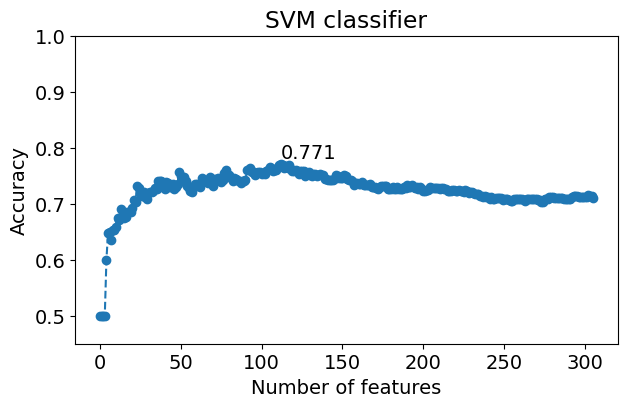

auc_best = 0.77103365
best auc (SVM) =  0.7710336538461539 Number of features =  112
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:04<16:15,  4.90s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:09<16:09,  4.90s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

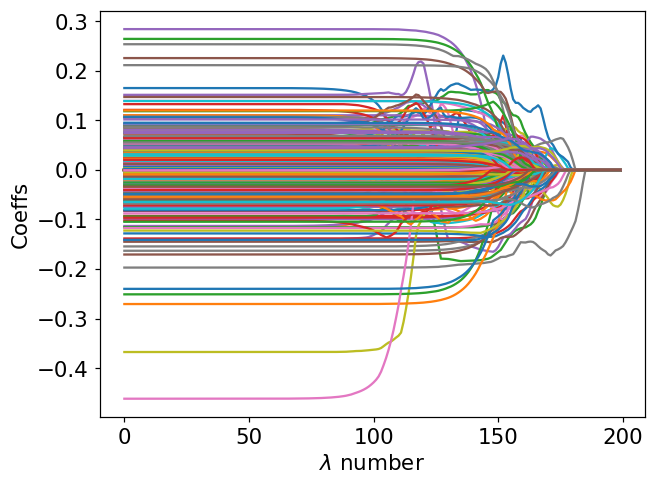

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500
UAR = 0.508
UAR = 0.508
UAR = 0.509


  0%|          | 1/306 [00:09<47:39,  9.38s/it]

Iter =  1  UAR = 0.5088
UAR = 0.500
UAR = 0.504


  1%|          | 2/306 [00:19<48:53,  9.65s/it]

UAR = 0.510
Iter =  2  UAR = 0.5100
UAR = 0.500
UAR = 0.501
UAR = 0.512
UAR = 0.516
UAR = 0.520
UAR = 0.521
UAR = 0.536


  1%|          | 3/306 [00:29<49:35,  9.82s/it]

UAR = 0.549
Iter =  3  UAR = 0.5493
UAR = 0.500
UAR = 0.501
UAR = 0.502
UAR = 0.504
UAR = 0.509
UAR = 0.515
UAR = 0.519
UAR = 0.542


  1%|▏         | 4/306 [00:39<49:59,  9.93s/it]

UAR = 0.552
Iter =  4  UAR = 0.5521
UAR = 0.500
UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.554
UAR = 0.585
UAR = 0.587
UAR = 0.602


  2%|▏         | 5/306 [00:49<50:01,  9.97s/it]

UAR = 0.604
UAR = 0.614
Iter =  5  UAR = 0.6140
UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.508
UAR = 0.523
UAR = 0.529
UAR = 0.565
UAR = 0.573
UAR = 0.575
UAR = 0.578
UAR = 0.591


  2%|▏         | 6/306 [00:59<50:12, 10.04s/it]

UAR = 0.598
UAR = 0.608
UAR = 0.500
UAR = 0.502
UAR = 0.503
UAR = 0.505
UAR = 0.530
UAR = 0.550
UAR = 0.559
UAR = 0.581
UAR = 0.608
UAR = 0.610
UAR = 0.610


  2%|▏         | 7/306 [01:09<50:29, 10.13s/it]

UAR = 0.625
UAR = 0.635
Iter =  7  UAR = 0.6348
UAR = 0.500
UAR = 0.504
UAR = 0.518
UAR = 0.548
UAR = 0.598
UAR = 0.616
UAR = 0.635
UAR = 0.641
UAR = 0.647
UAR = 0.659


  3%|▎         | 8/306 [01:20<50:37, 10.19s/it]

UAR = 0.668
UAR = 0.676
Iter =  8  UAR = 0.6765
UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.522
UAR = 0.560
UAR = 0.596
UAR = 0.620
UAR = 0.628
UAR = 0.643
UAR = 0.648
UAR = 0.653


  3%|▎         | 9/306 [01:30<51:02, 10.31s/it]

UAR = 0.666
UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.525
UAR = 0.563
UAR = 0.598
UAR = 0.616
UAR = 0.641
UAR = 0.643
UAR = 0.646
UAR = 0.655
UAR = 0.671
UAR = 0.672


  3%|▎         | 10/306 [01:41<51:34, 10.46s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.528
UAR = 0.566
UAR = 0.601
UAR = 0.637
UAR = 0.649
UAR = 0.667
UAR = 0.676
UAR = 0.678


  4%|▎         | 11/306 [01:52<52:08, 10.61s/it]

UAR = 0.694
Iter =  11  UAR = 0.6939
UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.515
UAR = 0.540
UAR = 0.576
UAR = 0.589
UAR = 0.605
UAR = 0.648
UAR = 0.660
UAR = 0.664
UAR = 0.668
UAR = 0.676
UAR = 0.678
UAR = 0.684
UAR = 0.687


  4%|▍         | 12/306 [02:03<52:41, 10.75s/it]

UAR = 0.689
UAR = 0.500
UAR = 0.502
UAR = 0.515
UAR = 0.540
UAR = 0.576
UAR = 0.594
UAR = 0.612
UAR = 0.650
UAR = 0.664
UAR = 0.669
UAR = 0.676
UAR = 0.677
UAR = 0.692


  4%|▍         | 13/306 [02:14<53:19, 10.92s/it]

UAR = 0.696
UAR = 0.697
Iter =  13  UAR = 0.6969
UAR = 0.500
UAR = 0.503
UAR = 0.513
UAR = 0.546
UAR = 0.570
UAR = 0.587
UAR = 0.605
UAR = 0.651
UAR = 0.663
UAR = 0.671
UAR = 0.672
UAR = 0.694


  5%|▍         | 14/306 [02:26<53:58, 11.09s/it]

UAR = 0.695
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.516
UAR = 0.551
UAR = 0.582
UAR = 0.604
UAR = 0.626
UAR = 0.654
UAR = 0.667
UAR = 0.675
UAR = 0.684
UAR = 0.697


  5%|▍         | 15/306 [02:38<54:35, 11.25s/it]

UAR = 0.700
Iter =  15  UAR = 0.7001
UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.560
UAR = 0.597
UAR = 0.619
UAR = 0.642
UAR = 0.661
UAR = 0.667
UAR = 0.678
UAR = 0.699


  5%|▌         | 16/306 [02:49<54:20, 11.24s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.524
UAR = 0.577
UAR = 0.610
UAR = 0.632
UAR = 0.650
UAR = 0.665
UAR = 0.665
UAR = 0.673
UAR = 0.679
UAR = 0.693


  6%|▌         | 17/306 [03:00<54:09, 11.25s/it]

UAR = 0.693
UAR = 0.702
Iter =  17  UAR = 0.7021
UAR = 0.500
UAR = 0.503
UAR = 0.506
UAR = 0.529
UAR = 0.582
UAR = 0.615
UAR = 0.628
UAR = 0.652
UAR = 0.664
UAR = 0.668
UAR = 0.672
UAR = 0.681
UAR = 0.687
UAR = 0.694
UAR = 0.699
UAR = 0.706


  6%|▌         | 18/306 [03:11<54:17, 11.31s/it]

Iter =  18  UAR = 0.7059
UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.536
UAR = 0.582
UAR = 0.597
UAR = 0.618
UAR = 0.619
UAR = 0.645
UAR = 0.659
UAR = 0.665
UAR = 0.667
UAR = 0.672
UAR = 0.682
UAR = 0.687
UAR = 0.691
UAR = 0.697


  6%|▌         | 19/306 [03:23<54:35, 11.41s/it]

UAR = 0.699
UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.541
UAR = 0.586
UAR = 0.599
UAR = 0.607
UAR = 0.622
UAR = 0.649
UAR = 0.658
UAR = 0.663
UAR = 0.672
UAR = 0.674
UAR = 0.685
UAR = 0.692


  7%|▋         | 20/306 [03:35<55:07, 11.57s/it]

UAR = 0.692
UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.542
UAR = 0.592
UAR = 0.595
UAR = 0.608
UAR = 0.627
UAR = 0.654
UAR = 0.663
UAR = 0.666
UAR = 0.670
UAR = 0.676
UAR = 0.687
UAR = 0.694
UAR = 0.705


  7%|▋         | 21/306 [03:47<55:40, 11.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.537
UAR = 0.587
UAR = 0.607
UAR = 0.610
UAR = 0.628
UAR = 0.651
UAR = 0.660
UAR = 0.669
UAR = 0.673
UAR = 0.681
UAR = 0.684
UAR = 0.689
UAR = 0.696
UAR = 0.707
UAR = 0.715


  7%|▋         | 22/306 [03:59<56:18, 11.90s/it]

Iter =  22  UAR = 0.7151
UAR = 0.500
UAR = 0.501
UAR = 0.547
UAR = 0.588
UAR = 0.599
UAR = 0.608
UAR = 0.632
UAR = 0.653
UAR = 0.660
UAR = 0.671
UAR = 0.673
UAR = 0.675
UAR = 0.688
UAR = 0.691
UAR = 0.704


  8%|▊         | 23/306 [04:12<56:56, 12.07s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.544
UAR = 0.589
UAR = 0.603
UAR = 0.605
UAR = 0.632
UAR = 0.650
UAR = 0.664
UAR = 0.672
UAR = 0.677
UAR = 0.683
UAR = 0.692
UAR = 0.695
UAR = 0.701


  8%|▊         | 24/306 [04:24<57:16, 12.19s/it]

UAR = 0.706
UAR = 0.500
UAR = 0.506
UAR = 0.563
UAR = 0.598
UAR = 0.622
UAR = 0.648
UAR = 0.669
UAR = 0.681
UAR = 0.684
UAR = 0.702
UAR = 0.726


  8%|▊         | 25/306 [04:37<57:35, 12.30s/it]

Iter =  25  UAR = 0.7256
UAR = 0.500
UAR = 0.506
UAR = 0.560
UAR = 0.595
UAR = 0.612
UAR = 0.647
UAR = 0.664
UAR = 0.673
UAR = 0.676
UAR = 0.681
UAR = 0.687
UAR = 0.697
UAR = 0.701
UAR = 0.701
UAR = 0.718


  8%|▊         | 26/306 [04:50<58:05, 12.45s/it]

UAR = 0.721
UAR = 0.500
UAR = 0.506
UAR = 0.555
UAR = 0.593
UAR = 0.612
UAR = 0.647
UAR = 0.662
UAR = 0.669
UAR = 0.677
UAR = 0.701
UAR = 0.702
UAR = 0.711


  9%|▉         | 27/306 [05:03<58:38, 12.61s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.560
UAR = 0.592
UAR = 0.615
UAR = 0.647
UAR = 0.664
UAR = 0.673
UAR = 0.697
UAR = 0.705
UAR = 0.709


  9%|▉         | 28/306 [05:16<59:18, 12.80s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.568
UAR = 0.592
UAR = 0.607
UAR = 0.614
UAR = 0.642
UAR = 0.663
UAR = 0.673
UAR = 0.681
UAR = 0.690
UAR = 0.690
UAR = 0.692
UAR = 0.701
UAR = 0.706


  9%|▉         | 29/306 [05:29<59:59, 12.99s/it]

UAR = 0.708
UAR = 0.500
UAR = 0.509
UAR = 0.568
UAR = 0.587
UAR = 0.594
UAR = 0.611
UAR = 0.639
UAR = 0.668
UAR = 0.677
UAR = 0.678
UAR = 0.685
UAR = 0.697
UAR = 0.700
UAR = 0.701
UAR = 0.713
UAR = 0.717
UAR = 0.718


 10%|▉         | 30/306 [05:43<1:00:32, 13.16s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.568
UAR = 0.585
UAR = 0.589
UAR = 0.608
UAR = 0.634
UAR = 0.669
UAR = 0.674
UAR = 0.678
UAR = 0.683
UAR = 0.699
UAR = 0.700
UAR = 0.704
UAR = 0.707
UAR = 0.714
UAR = 0.716


 10%|█         | 31/306 [05:57<1:01:13, 13.36s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.557
UAR = 0.585
UAR = 0.608
UAR = 0.634
UAR = 0.666
UAR = 0.673
UAR = 0.675
UAR = 0.680
UAR = 0.694
UAR = 0.698
UAR = 0.701
UAR = 0.712
UAR = 0.724


 10%|█         | 32/306 [06:09<59:33, 13.04s/it]  

UAR = 0.500
UAR = 0.509
UAR = 0.557
UAR = 0.592
UAR = 0.608
UAR = 0.634
UAR = 0.663
UAR = 0.672
UAR = 0.680
UAR = 0.685
UAR = 0.701
UAR = 0.704
UAR = 0.716
UAR = 0.722


 11%|█         | 33/306 [06:22<58:35, 12.88s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.552
UAR = 0.592
UAR = 0.607
UAR = 0.631
UAR = 0.666
UAR = 0.682
UAR = 0.687
UAR = 0.693
UAR = 0.702
UAR = 0.710
UAR = 0.711
UAR = 0.717


 11%|█         | 34/306 [06:34<58:05, 12.81s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.554
UAR = 0.592
UAR = 0.601
UAR = 0.636
UAR = 0.663
UAR = 0.685
UAR = 0.702
UAR = 0.704
UAR = 0.706
UAR = 0.707
UAR = 0.714
UAR = 0.716
UAR = 0.725


 11%|█▏        | 35/306 [06:47<57:58, 12.84s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.557
UAR = 0.580
UAR = 0.605
UAR = 0.634
UAR = 0.663
UAR = 0.684
UAR = 0.703
UAR = 0.705
UAR = 0.708
UAR = 0.713
UAR = 0.717


 12%|█▏        | 36/306 [07:00<58:09, 12.92s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.560
UAR = 0.582
UAR = 0.612
UAR = 0.649
UAR = 0.660
UAR = 0.682
UAR = 0.688
UAR = 0.699
UAR = 0.699
UAR = 0.699
UAR = 0.707
UAR = 0.715


 12%|█▏        | 37/306 [07:14<58:33, 13.06s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.556
UAR = 0.582
UAR = 0.615
UAR = 0.643
UAR = 0.666
UAR = 0.683
UAR = 0.684
UAR = 0.695
UAR = 0.704
UAR = 0.710
UAR = 0.710
UAR = 0.711
UAR = 0.721


 12%|█▏        | 38/306 [07:27<58:58, 13.20s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.552
UAR = 0.576
UAR = 0.612
UAR = 0.644
UAR = 0.667
UAR = 0.679
UAR = 0.684
UAR = 0.698
UAR = 0.705
UAR = 0.705
UAR = 0.712
UAR = 0.721


 13%|█▎        | 39/306 [07:41<59:30, 13.37s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.557
UAR = 0.573
UAR = 0.615
UAR = 0.644
UAR = 0.659
UAR = 0.668
UAR = 0.687
UAR = 0.702
UAR = 0.705
UAR = 0.706
UAR = 0.706
UAR = 0.720


 13%|█▎        | 40/306 [07:55<59:49, 13.49s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.556
UAR = 0.573
UAR = 0.621
UAR = 0.647
UAR = 0.664
UAR = 0.665
UAR = 0.666
UAR = 0.686
UAR = 0.696
UAR = 0.705
UAR = 0.712
UAR = 0.720


 13%|█▎        | 41/306 [08:09<1:00:14, 13.64s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.554
UAR = 0.570
UAR = 0.623
UAR = 0.647
UAR = 0.660
UAR = 0.661
UAR = 0.663
UAR = 0.676
UAR = 0.689
UAR = 0.700
UAR = 0.706
UAR = 0.718
UAR = 0.721


 14%|█▎        | 42/306 [08:23<1:00:42, 13.80s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.551
UAR = 0.568
UAR = 0.623
UAR = 0.649
UAR = 0.656
UAR = 0.669
UAR = 0.678
UAR = 0.685
UAR = 0.702
UAR = 0.707
UAR = 0.714
UAR = 0.716
UAR = 0.718
UAR = 0.723


 14%|█▍        | 43/306 [08:37<1:01:18, 13.99s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.549
UAR = 0.569
UAR = 0.623
UAR = 0.646
UAR = 0.657
UAR = 0.666
UAR = 0.679
UAR = 0.684
UAR = 0.690
UAR = 0.703
UAR = 0.706
UAR = 0.712
UAR = 0.722


 14%|█▍        | 44/306 [08:52<1:01:48, 14.16s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.557
UAR = 0.569
UAR = 0.613
UAR = 0.643
UAR = 0.661
UAR = 0.674
UAR = 0.681
UAR = 0.685
UAR = 0.701
UAR = 0.706
UAR = 0.714
UAR = 0.724


 15%|█▍        | 45/306 [09:07<1:02:28, 14.36s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.551
UAR = 0.569
UAR = 0.610
UAR = 0.646
UAR = 0.661
UAR = 0.672
UAR = 0.678
UAR = 0.683
UAR = 0.691
UAR = 0.706
UAR = 0.709
UAR = 0.722


 15%|█▌        | 46/306 [09:22<1:03:09, 14.58s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.556
UAR = 0.572
UAR = 0.622
UAR = 0.644
UAR = 0.667
UAR = 0.674
UAR = 0.678
UAR = 0.683
UAR = 0.699
UAR = 0.700
UAR = 0.700
UAR = 0.707
UAR = 0.708


 15%|█▌        | 47/306 [09:37<1:03:47, 14.78s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.556
UAR = 0.571
UAR = 0.615
UAR = 0.639
UAR = 0.662
UAR = 0.669
UAR = 0.679
UAR = 0.681
UAR = 0.696
UAR = 0.699
UAR = 0.711
UAR = 0.713


 16%|█▌        | 48/306 [09:51<1:02:15, 14.48s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.548
UAR = 0.569
UAR = 0.609
UAR = 0.639
UAR = 0.666
UAR = 0.674
UAR = 0.676
UAR = 0.681
UAR = 0.703
UAR = 0.708
UAR = 0.713
UAR = 0.725


 16%|█▌        | 49/306 [10:05<1:01:30, 14.36s/it]

UAR = 0.500
UAR = 0.514
UAR = 0.551
UAR = 0.569
UAR = 0.612
UAR = 0.649
UAR = 0.672
UAR = 0.679
UAR = 0.683
UAR = 0.690
UAR = 0.701
UAR = 0.712
UAR = 0.727


 16%|█▋        | 50/306 [10:19<1:01:12, 14.35s/it]

Iter =  50  UAR = 0.7272
UAR = 0.500
UAR = 0.516
UAR = 0.554
UAR = 0.569
UAR = 0.615
UAR = 0.651
UAR = 0.677
UAR = 0.682
UAR = 0.697
UAR = 0.698
UAR = 0.713
UAR = 0.717
UAR = 0.724


 17%|█▋        | 51/306 [10:34<1:01:10, 14.39s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.553
UAR = 0.567
UAR = 0.615
UAR = 0.654
UAR = 0.674
UAR = 0.680
UAR = 0.680
UAR = 0.690
UAR = 0.698
UAR = 0.714
UAR = 0.727
UAR = 0.730


 17%|█▋        | 52/306 [10:48<1:01:24, 14.50s/it]

Iter =  52  UAR = 0.7300
UAR = 0.500
UAR = 0.513
UAR = 0.553
UAR = 0.565
UAR = 0.617
UAR = 0.654
UAR = 0.677
UAR = 0.682
UAR = 0.690
UAR = 0.704
UAR = 0.718
UAR = 0.723
UAR = 0.735


 17%|█▋        | 53/306 [11:03<1:01:48, 14.66s/it]

Iter =  53  UAR = 0.7348
UAR = 0.500
UAR = 0.511
UAR = 0.550
UAR = 0.565
UAR = 0.615
UAR = 0.657
UAR = 0.679
UAR = 0.680
UAR = 0.693
UAR = 0.701
UAR = 0.710
UAR = 0.726
UAR = 0.731
UAR = 0.734


 18%|█▊        | 54/306 [11:19<1:02:21, 14.85s/it]

UAR = 0.500
UAR = 0.514
UAR = 0.546
UAR = 0.562
UAR = 0.612
UAR = 0.654
UAR = 0.674
UAR = 0.685
UAR = 0.693
UAR = 0.712
UAR = 0.713
UAR = 0.728
UAR = 0.736


 18%|█▊        | 55/306 [11:34<1:03:00, 15.06s/it]

Iter =  55  UAR = 0.7356
UAR = 0.500
UAR = 0.516
UAR = 0.543
UAR = 0.557
UAR = 0.559
UAR = 0.614
UAR = 0.659
UAR = 0.681
UAR = 0.682
UAR = 0.691
UAR = 0.700
UAR = 0.714
UAR = 0.726
UAR = 0.738


 18%|█▊        | 56/306 [11:50<1:03:25, 15.22s/it]

Iter =  56  UAR = 0.7378
UAR = 0.500
UAR = 0.511
UAR = 0.541
UAR = 0.552
UAR = 0.565
UAR = 0.606
UAR = 0.659
UAR = 0.673
UAR = 0.682
UAR = 0.690
UAR = 0.708
UAR = 0.721
UAR = 0.721
UAR = 0.731


 19%|█▊        | 57/306 [12:06<1:03:59, 15.42s/it]

UAR = 0.500
UAR = 0.514
UAR = 0.538
UAR = 0.552
UAR = 0.562
UAR = 0.612
UAR = 0.649
UAR = 0.667
UAR = 0.672
UAR = 0.690
UAR = 0.708
UAR = 0.708
UAR = 0.713
UAR = 0.719
UAR = 0.726


 19%|█▉        | 58/306 [12:22<1:04:36, 15.63s/it]

UAR = 0.500
UAR = 0.514
UAR = 0.535
UAR = 0.550
UAR = 0.562
UAR = 0.609
UAR = 0.643
UAR = 0.659
UAR = 0.670
UAR = 0.693
UAR = 0.708
UAR = 0.711
UAR = 0.711
UAR = 0.720
UAR = 0.726


 19%|█▉        | 59/306 [12:38<1:05:12, 15.84s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.533
UAR = 0.547
UAR = 0.562
UAR = 0.609
UAR = 0.643
UAR = 0.662
UAR = 0.668
UAR = 0.695
UAR = 0.706
UAR = 0.713
UAR = 0.716
UAR = 0.718
UAR = 0.726


 20%|█▉        | 60/306 [12:55<1:05:51, 16.06s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.531
UAR = 0.542
UAR = 0.562
UAR = 0.609
UAR = 0.656
UAR = 0.666
UAR = 0.676
UAR = 0.696
UAR = 0.710
UAR = 0.714
UAR = 0.721
UAR = 0.723


 20%|█▉        | 61/306 [13:12<1:06:26, 16.27s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.528
UAR = 0.540
UAR = 0.557
UAR = 0.609
UAR = 0.653
UAR = 0.672
UAR = 0.676
UAR = 0.693
UAR = 0.709
UAR = 0.716
UAR = 0.725


 20%|██        | 62/306 [13:29<1:07:09, 16.51s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.525
UAR = 0.535
UAR = 0.562
UAR = 0.609
UAR = 0.643
UAR = 0.667
UAR = 0.671
UAR = 0.673
UAR = 0.694
UAR = 0.710
UAR = 0.718
UAR = 0.728


 21%|██        | 63/306 [13:46<1:07:54, 16.77s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.523
UAR = 0.524
UAR = 0.554
UAR = 0.609
UAR = 0.643
UAR = 0.662
UAR = 0.663
UAR = 0.673
UAR = 0.691
UAR = 0.703
UAR = 0.707
UAR = 0.713
UAR = 0.722


 21%|██        | 64/306 [14:01<1:05:55, 16.34s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.523
UAR = 0.527
UAR = 0.551
UAR = 0.606
UAR = 0.643
UAR = 0.659
UAR = 0.666
UAR = 0.670
UAR = 0.683
UAR = 0.705
UAR = 0.707
UAR = 0.712
UAR = 0.716


 21%|██        | 65/306 [14:17<1:04:40, 16.10s/it]

UAR = 0.500
UAR = 0.511
UAR = 0.523
UAR = 0.527
UAR = 0.554
UAR = 0.605
UAR = 0.631
UAR = 0.665
UAR = 0.673
UAR = 0.683
UAR = 0.706
UAR = 0.715


 22%|██▏       | 66/306 [14:33<1:04:03, 16.01s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.524
UAR = 0.554
UAR = 0.607
UAR = 0.638
UAR = 0.657
UAR = 0.661
UAR = 0.669
UAR = 0.685
UAR = 0.703
UAR = 0.708
UAR = 0.710


 22%|██▏       | 67/306 [14:49<1:03:55, 16.05s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.524
UAR = 0.557
UAR = 0.613
UAR = 0.635
UAR = 0.654
UAR = 0.661
UAR = 0.674
UAR = 0.682
UAR = 0.700
UAR = 0.704
UAR = 0.708
UAR = 0.711


 22%|██▏       | 68/306 [15:05<1:03:57, 16.12s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.520
UAR = 0.524
UAR = 0.557
UAR = 0.608
UAR = 0.635
UAR = 0.656
UAR = 0.659
UAR = 0.670
UAR = 0.677
UAR = 0.695
UAR = 0.713


 23%|██▎       | 69/306 [15:22<1:04:23, 16.30s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.520
UAR = 0.522
UAR = 0.557
UAR = 0.608
UAR = 0.633
UAR = 0.651
UAR = 0.659
UAR = 0.667
UAR = 0.681
UAR = 0.695
UAR = 0.697
UAR = 0.703
UAR = 0.707
UAR = 0.710


 23%|██▎       | 70/306 [15:39<1:05:07, 16.56s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.521
UAR = 0.523
UAR = 0.557
UAR = 0.608
UAR = 0.638
UAR = 0.648
UAR = 0.659
UAR = 0.664
UAR = 0.684
UAR = 0.693
UAR = 0.700
UAR = 0.713


 23%|██▎       | 71/306 [15:56<1:05:55, 16.83s/it]

UAR = 0.500
UAR = 0.509
UAR = 0.521
UAR = 0.523
UAR = 0.559
UAR = 0.608
UAR = 0.635
UAR = 0.650
UAR = 0.659
UAR = 0.662
UAR = 0.681
UAR = 0.688
UAR = 0.692
UAR = 0.698
UAR = 0.703
UAR = 0.706


 24%|██▎       | 72/306 [16:14<1:06:30, 17.05s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.522
UAR = 0.561
UAR = 0.611
UAR = 0.639
UAR = 0.656
UAR = 0.662
UAR = 0.683
UAR = 0.686
UAR = 0.695
UAR = 0.701


 24%|██▍       | 73/306 [16:32<1:07:12, 17.31s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.518
UAR = 0.522
UAR = 0.559
UAR = 0.610
UAR = 0.635
UAR = 0.648
UAR = 0.657
UAR = 0.684
UAR = 0.704


 24%|██▍       | 74/306 [16:50<1:08:00, 17.59s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.520
UAR = 0.559
UAR = 0.608
UAR = 0.633
UAR = 0.653
UAR = 0.657
UAR = 0.658
UAR = 0.684
UAR = 0.691
UAR = 0.693
UAR = 0.696
UAR = 0.699


 25%|██▍       | 75/306 [17:09<1:08:48, 17.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.521
UAR = 0.522
UAR = 0.559
UAR = 0.613
UAR = 0.636
UAR = 0.659
UAR = 0.665
UAR = 0.685
UAR = 0.690
UAR = 0.691
UAR = 0.702
UAR = 0.706


 25%|██▍       | 76/306 [17:28<1:09:39, 18.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.521
UAR = 0.522
UAR = 0.559
UAR = 0.613
UAR = 0.636
UAR = 0.662
UAR = 0.665
UAR = 0.671
UAR = 0.694
UAR = 0.709


 25%|██▌       | 77/306 [17:47<1:10:27, 18.46s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.520
UAR = 0.557
UAR = 0.615
UAR = 0.634
UAR = 0.662
UAR = 0.664
UAR = 0.666
UAR = 0.693
UAR = 0.695
UAR = 0.699
UAR = 0.703


 25%|██▌       | 78/306 [18:06<1:11:11, 18.73s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.556
UAR = 0.618
UAR = 0.633
UAR = 0.663
UAR = 0.663
UAR = 0.687
UAR = 0.689
UAR = 0.690
UAR = 0.695
UAR = 0.700


 26%|██▌       | 79/306 [18:26<1:11:57, 19.02s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.520
UAR = 0.554
UAR = 0.616
UAR = 0.632
UAR = 0.663
UAR = 0.684
UAR = 0.690
UAR = 0.692
UAR = 0.699
UAR = 0.700
UAR = 0.708


 26%|██▌       | 80/306 [18:43<1:09:31, 18.46s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.554
UAR = 0.616
UAR = 0.635
UAR = 0.658
UAR = 0.659
UAR = 0.681
UAR = 0.685
UAR = 0.686
UAR = 0.698
UAR = 0.704
UAR = 0.704


 26%|██▋       | 81/306 [19:00<1:07:57, 18.12s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.551
UAR = 0.615
UAR = 0.632
UAR = 0.663
UAR = 0.685
UAR = 0.689
UAR = 0.695
UAR = 0.701


 27%|██▋       | 82/306 [19:18<1:07:05, 17.97s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.519
UAR = 0.554
UAR = 0.615
UAR = 0.636
UAR = 0.663
UAR = 0.686
UAR = 0.692
UAR = 0.694
UAR = 0.698
UAR = 0.702


 27%|██▋       | 83/306 [19:36<1:06:36, 17.92s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.519
UAR = 0.556
UAR = 0.616
UAR = 0.641
UAR = 0.660
UAR = 0.661
UAR = 0.663
UAR = 0.689
UAR = 0.694
UAR = 0.703


 27%|██▋       | 84/306 [19:54<1:06:35, 18.00s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.518
UAR = 0.556
UAR = 0.613
UAR = 0.643
UAR = 0.659
UAR = 0.664
UAR = 0.690
UAR = 0.696
UAR = 0.703
UAR = 0.705
UAR = 0.706


 28%|██▊       | 85/306 [20:12<1:06:57, 18.18s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.519
UAR = 0.556
UAR = 0.617
UAR = 0.648
UAR = 0.660
UAR = 0.660
UAR = 0.670
UAR = 0.693
UAR = 0.704
UAR = 0.705
UAR = 0.706
UAR = 0.708


 28%|██▊       | 86/306 [20:31<1:07:30, 18.41s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.517
UAR = 0.556
UAR = 0.618
UAR = 0.645
UAR = 0.663
UAR = 0.663
UAR = 0.665
UAR = 0.693
UAR = 0.694
UAR = 0.705
UAR = 0.710
UAR = 0.719


 28%|██▊       | 87/306 [20:51<1:08:07, 18.66s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.517
UAR = 0.559
UAR = 0.616
UAR = 0.643
UAR = 0.663
UAR = 0.668
UAR = 0.693
UAR = 0.699
UAR = 0.702
UAR = 0.712
UAR = 0.720


 29%|██▉       | 88/306 [21:10<1:08:32, 18.87s/it]

UAR = 0.500
UAR = 0.506
UAR = 0.517
UAR = 0.561
UAR = 0.610
UAR = 0.643
UAR = 0.657
UAR = 0.659
UAR = 0.673
UAR = 0.693
UAR = 0.697
UAR = 0.702
UAR = 0.714
UAR = 0.718


 29%|██▉       | 89/306 [21:30<1:09:08, 19.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.559
UAR = 0.610
UAR = 0.646
UAR = 0.657
UAR = 0.673
UAR = 0.688
UAR = 0.699
UAR = 0.699
UAR = 0.707
UAR = 0.720


 29%|██▉       | 90/306 [21:50<1:09:53, 19.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.567
UAR = 0.613
UAR = 0.643
UAR = 0.646
UAR = 0.647
UAR = 0.667
UAR = 0.693
UAR = 0.697
UAR = 0.702
UAR = 0.709
UAR = 0.721


 30%|██▉       | 91/306 [22:10<1:10:51, 19.78s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.561
UAR = 0.613
UAR = 0.643
UAR = 0.649
UAR = 0.655
UAR = 0.667
UAR = 0.693
UAR = 0.696
UAR = 0.702
UAR = 0.704
UAR = 0.717


 30%|███       | 92/306 [22:31<1:11:43, 20.11s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.569
UAR = 0.613
UAR = 0.643
UAR = 0.649
UAR = 0.652
UAR = 0.670
UAR = 0.693
UAR = 0.693
UAR = 0.696
UAR = 0.702
UAR = 0.704
UAR = 0.717


 30%|███       | 93/306 [22:52<1:12:31, 20.43s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.569
UAR = 0.613
UAR = 0.647
UAR = 0.648
UAR = 0.654
UAR = 0.670
UAR = 0.690
UAR = 0.696
UAR = 0.708
UAR = 0.714


 31%|███       | 94/306 [23:14<1:13:18, 20.75s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.566
UAR = 0.613
UAR = 0.647
UAR = 0.648
UAR = 0.655
UAR = 0.672
UAR = 0.690
UAR = 0.695
UAR = 0.701
UAR = 0.705
UAR = 0.710
UAR = 0.711
UAR = 0.713


 31%|███       | 95/306 [23:36<1:14:03, 21.06s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.563
UAR = 0.612
UAR = 0.649
UAR = 0.649
UAR = 0.652
UAR = 0.672
UAR = 0.693
UAR = 0.703
UAR = 0.705
UAR = 0.709
UAR = 0.712
UAR = 0.713


 31%|███▏      | 96/306 [23:55<1:11:36, 20.46s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.514
UAR = 0.563
UAR = 0.615
UAR = 0.650
UAR = 0.652
UAR = 0.652
UAR = 0.675
UAR = 0.694
UAR = 0.701
UAR = 0.704
UAR = 0.715


 32%|███▏      | 97/306 [24:14<1:10:07, 20.13s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.514
UAR = 0.568
UAR = 0.613
UAR = 0.651
UAR = 0.654
UAR = 0.676
UAR = 0.691
UAR = 0.698
UAR = 0.707
UAR = 0.712
UAR = 0.719


 32%|███▏      | 98/306 [24:34<1:09:17, 19.99s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.514
UAR = 0.566
UAR = 0.614
UAR = 0.651
UAR = 0.675
UAR = 0.692
UAR = 0.700
UAR = 0.709
UAR = 0.717


 32%|███▏      | 99/306 [24:54<1:08:59, 20.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.511
UAR = 0.568
UAR = 0.612
UAR = 0.654
UAR = 0.673
UAR = 0.690
UAR = 0.704
UAR = 0.713
UAR = 0.715
UAR = 0.725


 33%|███▎      | 100/306 [25:14<1:08:55, 20.08s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.511
UAR = 0.563
UAR = 0.615
UAR = 0.651
UAR = 0.651
UAR = 0.678
UAR = 0.686
UAR = 0.706
UAR = 0.708
UAR = 0.714
UAR = 0.719


 33%|███▎      | 101/306 [25:35<1:09:13, 20.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.511
UAR = 0.561
UAR = 0.615
UAR = 0.646
UAR = 0.649
UAR = 0.673
UAR = 0.693
UAR = 0.705
UAR = 0.706
UAR = 0.712
UAR = 0.717


 33%|███▎      | 102/306 [25:56<1:09:35, 20.47s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.511
UAR = 0.561
UAR = 0.614
UAR = 0.646
UAR = 0.650
UAR = 0.650
UAR = 0.670
UAR = 0.690
UAR = 0.704
UAR = 0.706
UAR = 0.709
UAR = 0.715


 34%|███▎      | 103/306 [26:17<1:10:14, 20.76s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.561
UAR = 0.618
UAR = 0.646
UAR = 0.650
UAR = 0.676
UAR = 0.688
UAR = 0.705
UAR = 0.709
UAR = 0.714


 34%|███▍      | 104/306 [26:39<1:10:42, 21.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.561
UAR = 0.617
UAR = 0.645
UAR = 0.670
UAR = 0.687
UAR = 0.701
UAR = 0.703
UAR = 0.706
UAR = 0.711


 34%|███▍      | 105/306 [27:01<1:11:18, 21.29s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.561
UAR = 0.612
UAR = 0.648
UAR = 0.675
UAR = 0.688
UAR = 0.699
UAR = 0.707
UAR = 0.707
UAR = 0.712


 35%|███▍      | 106/306 [27:23<1:11:58, 21.59s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.558
UAR = 0.612
UAR = 0.648
UAR = 0.672
UAR = 0.688
UAR = 0.699
UAR = 0.707
UAR = 0.713


 35%|███▍      | 107/306 [27:46<1:12:51, 21.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.510
UAR = 0.510
UAR = 0.561
UAR = 0.612
UAR = 0.648
UAR = 0.673
UAR = 0.687
UAR = 0.698
UAR = 0.704
UAR = 0.710
UAR = 0.712


 35%|███▌      | 108/306 [28:09<1:13:43, 22.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.508
UAR = 0.564
UAR = 0.615
UAR = 0.643
UAR = 0.645
UAR = 0.667
UAR = 0.687
UAR = 0.698
UAR = 0.704
UAR = 0.709
UAR = 0.714


 36%|███▌      | 109/306 [28:33<1:14:26, 22.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.564
UAR = 0.614
UAR = 0.651
UAR = 0.670
UAR = 0.687
UAR = 0.701
UAR = 0.710
UAR = 0.716


 36%|███▌      | 110/306 [28:56<1:15:02, 22.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.563
UAR = 0.617
UAR = 0.646
UAR = 0.673
UAR = 0.686
UAR = 0.701
UAR = 0.705
UAR = 0.716


 36%|███▋      | 111/306 [29:20<1:15:41, 23.29s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.563
UAR = 0.617
UAR = 0.643
UAR = 0.643
UAR = 0.645
UAR = 0.673
UAR = 0.687
UAR = 0.702
UAR = 0.708
UAR = 0.713
UAR = 0.715


 37%|███▋      | 112/306 [29:41<1:13:09, 22.63s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.564
UAR = 0.617
UAR = 0.646
UAR = 0.649
UAR = 0.673
UAR = 0.686
UAR = 0.704
UAR = 0.705
UAR = 0.714
UAR = 0.714
UAR = 0.719


 37%|███▋      | 113/306 [30:03<1:11:31, 22.24s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.507
UAR = 0.563
UAR = 0.617
UAR = 0.640
UAR = 0.646
UAR = 0.681
UAR = 0.687
UAR = 0.707
UAR = 0.716
UAR = 0.722


 37%|███▋      | 114/306 [30:24<1:10:46, 22.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.510
UAR = 0.562
UAR = 0.617
UAR = 0.646
UAR = 0.673
UAR = 0.688
UAR = 0.709
UAR = 0.720
UAR = 0.725


 38%|███▊      | 115/306 [30:46<1:10:14, 22.06s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.504
UAR = 0.507
UAR = 0.562
UAR = 0.614
UAR = 0.643
UAR = 0.645
UAR = 0.679
UAR = 0.689
UAR = 0.707
UAR = 0.718
UAR = 0.722


 38%|███▊      | 116/306 [31:09<1:10:13, 22.17s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.503
UAR = 0.504
UAR = 0.509
UAR = 0.562
UAR = 0.617
UAR = 0.638
UAR = 0.645
UAR = 0.681
UAR = 0.684
UAR = 0.710
UAR = 0.722
UAR = 0.724


 38%|███▊      | 117/306 [31:32<1:10:31, 22.39s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.507
UAR = 0.560
UAR = 0.617
UAR = 0.635
UAR = 0.640
UAR = 0.642
UAR = 0.681
UAR = 0.683
UAR = 0.710
UAR = 0.723
UAR = 0.723


 39%|███▊      | 118/306 [31:55<1:10:50, 22.61s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.509
UAR = 0.560
UAR = 0.617
UAR = 0.637
UAR = 0.640
UAR = 0.642
UAR = 0.677
UAR = 0.683
UAR = 0.710
UAR = 0.720
UAR = 0.724


 39%|███▉      | 119/306 [32:18<1:11:15, 22.86s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.509
UAR = 0.557
UAR = 0.619
UAR = 0.637
UAR = 0.640
UAR = 0.640
UAR = 0.675
UAR = 0.683
UAR = 0.713
UAR = 0.720
UAR = 0.724


 39%|███▉      | 120/306 [32:42<1:11:28, 23.06s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.509
UAR = 0.562
UAR = 0.619
UAR = 0.637
UAR = 0.640
UAR = 0.643
UAR = 0.678
UAR = 0.683
UAR = 0.710
UAR = 0.722


 40%|███▉      | 121/306 [33:06<1:11:52, 23.31s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.503
UAR = 0.504
UAR = 0.509
UAR = 0.557
UAR = 0.614
UAR = 0.632
UAR = 0.642
UAR = 0.678
UAR = 0.697
UAR = 0.708
UAR = 0.722


 40%|███▉      | 122/306 [33:30<1:12:27, 23.63s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.504
UAR = 0.509
UAR = 0.560
UAR = 0.614
UAR = 0.634
UAR = 0.642
UAR = 0.676
UAR = 0.689
UAR = 0.699
UAR = 0.700
UAR = 0.714
UAR = 0.716


 40%|████      | 123/306 [33:55<1:12:57, 23.92s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.503
UAR = 0.504
UAR = 0.509
UAR = 0.557
UAR = 0.614
UAR = 0.634
UAR = 0.642
UAR = 0.643
UAR = 0.678
UAR = 0.694
UAR = 0.694
UAR = 0.697
UAR = 0.699
UAR = 0.719


 41%|████      | 124/306 [34:20<1:13:34, 24.25s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.504
UAR = 0.509
UAR = 0.559
UAR = 0.619
UAR = 0.635
UAR = 0.643
UAR = 0.643
UAR = 0.673
UAR = 0.688
UAR = 0.697
UAR = 0.702
UAR = 0.719
UAR = 0.720
UAR = 0.721


 41%|████      | 125/306 [34:45<1:14:11, 24.59s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.504
UAR = 0.509
UAR = 0.559
UAR = 0.619
UAR = 0.635
UAR = 0.640
UAR = 0.641
UAR = 0.678
UAR = 0.685
UAR = 0.695
UAR = 0.700
UAR = 0.726


 41%|████      | 126/306 [35:11<1:14:43, 24.91s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.504
UAR = 0.509
UAR = 0.562
UAR = 0.622
UAR = 0.635
UAR = 0.640
UAR = 0.676
UAR = 0.691
UAR = 0.694
UAR = 0.707
UAR = 0.726


 42%|████▏     | 127/306 [35:37<1:15:22, 25.26s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.504
UAR = 0.509
UAR = 0.562
UAR = 0.619
UAR = 0.635
UAR = 0.637
UAR = 0.639
UAR = 0.679
UAR = 0.685
UAR = 0.692
UAR = 0.704
UAR = 0.723


 42%|████▏     | 128/306 [36:00<1:12:54, 24.58s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.509
UAR = 0.563
UAR = 0.611
UAR = 0.635
UAR = 0.637
UAR = 0.641
UAR = 0.676
UAR = 0.690
UAR = 0.691
UAR = 0.706
UAR = 0.724


 42%|████▏     | 129/306 [36:23<1:11:17, 24.17s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.509
UAR = 0.566
UAR = 0.617
UAR = 0.633
UAR = 0.637
UAR = 0.638
UAR = 0.673
UAR = 0.688
UAR = 0.692
UAR = 0.701
UAR = 0.724


 42%|████▏     | 130/306 [36:47<1:10:19, 23.97s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.509
UAR = 0.562
UAR = 0.619
UAR = 0.633
UAR = 0.637
UAR = 0.638
UAR = 0.667
UAR = 0.683
UAR = 0.695
UAR = 0.723


 43%|████▎     | 131/306 [37:10<1:09:47, 23.93s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.504
UAR = 0.509
UAR = 0.565
UAR = 0.621
UAR = 0.630
UAR = 0.636
UAR = 0.640
UAR = 0.675
UAR = 0.690
UAR = 0.696
UAR = 0.719


 43%|████▎     | 132/306 [37:35<1:09:38, 24.01s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.504
UAR = 0.509
UAR = 0.565
UAR = 0.619
UAR = 0.635
UAR = 0.637
UAR = 0.640
UAR = 0.673
UAR = 0.685
UAR = 0.695
UAR = 0.723


 43%|████▎     | 133/306 [37:59<1:09:50, 24.22s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.504
UAR = 0.509
UAR = 0.565
UAR = 0.619
UAR = 0.634
UAR = 0.637
UAR = 0.643
UAR = 0.673
UAR = 0.685
UAR = 0.695
UAR = 0.696
UAR = 0.720


 44%|████▍     | 134/306 [38:24<1:10:05, 24.45s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.504
UAR = 0.512
UAR = 0.567
UAR = 0.621
UAR = 0.637
UAR = 0.640
UAR = 0.645
UAR = 0.673
UAR = 0.685
UAR = 0.693
UAR = 0.693
UAR = 0.716
UAR = 0.716


 44%|████▍     | 135/306 [38:50<1:10:23, 24.70s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.504
UAR = 0.512
UAR = 0.564
UAR = 0.619
UAR = 0.640
UAR = 0.645
UAR = 0.673
UAR = 0.685
UAR = 0.692
UAR = 0.697
UAR = 0.713
UAR = 0.721


 44%|████▍     | 136/306 [39:15<1:10:32, 24.90s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.504
UAR = 0.512
UAR = 0.561
UAR = 0.618
UAR = 0.639
UAR = 0.642
UAR = 0.645
UAR = 0.673
UAR = 0.682
UAR = 0.694
UAR = 0.711
UAR = 0.718


 45%|████▍     | 137/306 [39:41<1:10:46, 25.13s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.505
UAR = 0.512
UAR = 0.561
UAR = 0.619
UAR = 0.640
UAR = 0.642
UAR = 0.673
UAR = 0.682
UAR = 0.694
UAR = 0.710
UAR = 0.717


 45%|████▌     | 138/306 [40:07<1:11:08, 25.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.512
UAR = 0.560
UAR = 0.619
UAR = 0.640
UAR = 0.642
UAR = 0.643
UAR = 0.673
UAR = 0.682
UAR = 0.697
UAR = 0.709
UAR = 0.717


 45%|████▌     | 139/306 [40:33<1:11:30, 25.69s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.505
UAR = 0.512
UAR = 0.560
UAR = 0.619
UAR = 0.640
UAR = 0.640
UAR = 0.673
UAR = 0.680
UAR = 0.697
UAR = 0.712
UAR = 0.721


 46%|████▌     | 140/306 [41:00<1:11:47, 25.95s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.503
UAR = 0.505
UAR = 0.512
UAR = 0.561
UAR = 0.619
UAR = 0.640
UAR = 0.643
UAR = 0.670
UAR = 0.683
UAR = 0.691
UAR = 0.692
UAR = 0.712
UAR = 0.719


 46%|████▌     | 141/306 [41:27<1:12:17, 26.29s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.512
UAR = 0.561
UAR = 0.619
UAR = 0.640
UAR = 0.643
UAR = 0.670
UAR = 0.680
UAR = 0.694
UAR = 0.713
UAR = 0.721


 46%|████▋     | 142/306 [41:54<1:12:48, 26.63s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.515
UAR = 0.564
UAR = 0.619
UAR = 0.640
UAR = 0.643
UAR = 0.670
UAR = 0.678
UAR = 0.692
UAR = 0.708
UAR = 0.718


 47%|████▋     | 143/306 [42:22<1:13:16, 26.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.515
UAR = 0.566
UAR = 0.620
UAR = 0.640
UAR = 0.643
UAR = 0.671
UAR = 0.680
UAR = 0.691
UAR = 0.693
UAR = 0.708
UAR = 0.716


 47%|████▋     | 144/306 [42:46<1:10:47, 26.22s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.512
UAR = 0.566
UAR = 0.619
UAR = 0.640
UAR = 0.643
UAR = 0.668
UAR = 0.683
UAR = 0.689
UAR = 0.690
UAR = 0.708
UAR = 0.722


 47%|████▋     | 145/306 [43:11<1:09:24, 25.87s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.515
UAR = 0.566
UAR = 0.617
UAR = 0.640
UAR = 0.646
UAR = 0.668
UAR = 0.685
UAR = 0.690
UAR = 0.693
UAR = 0.711
UAR = 0.722


 48%|████▊     | 146/306 [43:37<1:08:34, 25.72s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.515
UAR = 0.566
UAR = 0.617
UAR = 0.637
UAR = 0.644
UAR = 0.666
UAR = 0.685
UAR = 0.686
UAR = 0.694
UAR = 0.710
UAR = 0.719


 48%|████▊     | 147/306 [44:02<1:08:08, 25.72s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.515
UAR = 0.566
UAR = 0.617
UAR = 0.632
UAR = 0.636
UAR = 0.640
UAR = 0.668
UAR = 0.687
UAR = 0.691
UAR = 0.696
UAR = 0.709
UAR = 0.718


 48%|████▊     | 148/306 [44:28<1:07:51, 25.77s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.515
UAR = 0.566
UAR = 0.616
UAR = 0.637
UAR = 0.643
UAR = 0.671
UAR = 0.691
UAR = 0.696
UAR = 0.713
UAR = 0.718


 49%|████▊     | 149/306 [44:55<1:08:01, 26.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.514
UAR = 0.566
UAR = 0.617
UAR = 0.637
UAR = 0.643
UAR = 0.668
UAR = 0.690
UAR = 0.693
UAR = 0.709
UAR = 0.718


 49%|████▉     | 150/306 [45:22<1:08:17, 26.26s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.514
UAR = 0.566
UAR = 0.617
UAR = 0.637
UAR = 0.643
UAR = 0.668
UAR = 0.690
UAR = 0.696
UAR = 0.706
UAR = 0.718


 49%|████▉     | 151/306 [45:49<1:08:34, 26.55s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.617
UAR = 0.635
UAR = 0.638
UAR = 0.646
UAR = 0.670
UAR = 0.690
UAR = 0.697
UAR = 0.703
UAR = 0.718


 50%|████▉     | 152/306 [46:16<1:08:37, 26.74s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.568
UAR = 0.616
UAR = 0.635
UAR = 0.646
UAR = 0.670
UAR = 0.686
UAR = 0.700
UAR = 0.711
UAR = 0.717


 50%|█████     | 153/306 [46:44<1:08:51, 27.00s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.568
UAR = 0.616
UAR = 0.634
UAR = 0.635
UAR = 0.643
UAR = 0.669
UAR = 0.690
UAR = 0.698
UAR = 0.700
UAR = 0.717
UAR = 0.720


 50%|█████     | 154/306 [47:12<1:09:08, 27.29s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.520
UAR = 0.571
UAR = 0.616
UAR = 0.635
UAR = 0.643
UAR = 0.669
UAR = 0.690
UAR = 0.693
UAR = 0.697
UAR = 0.714
UAR = 0.719


 51%|█████     | 155/306 [47:40<1:09:28, 27.61s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.568
UAR = 0.616
UAR = 0.635
UAR = 0.643
UAR = 0.670
UAR = 0.679
UAR = 0.692
UAR = 0.694
UAR = 0.717
UAR = 0.719


 51%|█████     | 156/306 [48:09<1:09:38, 27.86s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.616
UAR = 0.635
UAR = 0.643
UAR = 0.667
UAR = 0.682
UAR = 0.693
UAR = 0.712
UAR = 0.719


 51%|█████▏    | 157/306 [48:38<1:10:02, 28.21s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.619
UAR = 0.632
UAR = 0.643
UAR = 0.669
UAR = 0.679
UAR = 0.690
UAR = 0.691
UAR = 0.716
UAR = 0.717


 52%|█████▏    | 158/306 [49:07<1:10:20, 28.52s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.619
UAR = 0.632
UAR = 0.640
UAR = 0.672
UAR = 0.678
UAR = 0.689
UAR = 0.691
UAR = 0.716
UAR = 0.717


 52%|█████▏    | 159/306 [49:36<1:10:44, 28.87s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.616
UAR = 0.632
UAR = 0.638
UAR = 0.670
UAR = 0.681
UAR = 0.689
UAR = 0.691
UAR = 0.715
UAR = 0.716


 52%|█████▏    | 160/306 [50:03<1:08:19, 28.08s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.616
UAR = 0.632
UAR = 0.637
UAR = 0.669
UAR = 0.678
UAR = 0.684
UAR = 0.690
UAR = 0.713
UAR = 0.716


 53%|█████▎    | 161/306 [50:30<1:06:57, 27.70s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.616
UAR = 0.629
UAR = 0.630
UAR = 0.637
UAR = 0.669
UAR = 0.676
UAR = 0.684
UAR = 0.690
UAR = 0.705
UAR = 0.714


 53%|█████▎    | 162/306 [50:56<1:05:55, 27.47s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.616
UAR = 0.632
UAR = 0.637
UAR = 0.669
UAR = 0.678
UAR = 0.681
UAR = 0.690
UAR = 0.707
UAR = 0.716


 53%|█████▎    | 163/306 [51:24<1:05:25, 27.45s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.613
UAR = 0.627
UAR = 0.637
UAR = 0.671
UAR = 0.679
UAR = 0.681
UAR = 0.690
UAR = 0.711
UAR = 0.716


 54%|█████▎    | 164/306 [51:51<1:05:00, 27.47s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.611
UAR = 0.631
UAR = 0.640
UAR = 0.669
UAR = 0.676
UAR = 0.682
UAR = 0.691
UAR = 0.708
UAR = 0.716


 54%|█████▍    | 165/306 [52:19<1:04:58, 27.65s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.571
UAR = 0.611
UAR = 0.626
UAR = 0.640
UAR = 0.673
UAR = 0.679
UAR = 0.682
UAR = 0.682
UAR = 0.691
UAR = 0.714
UAR = 0.720


 54%|█████▍    | 166/306 [52:48<1:04:57, 27.84s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.611
UAR = 0.629
UAR = 0.637
UAR = 0.664
UAR = 0.671
UAR = 0.679
UAR = 0.691
UAR = 0.711
UAR = 0.712


 55%|█████▍    | 167/306 [53:16<1:05:07, 28.11s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.611
UAR = 0.627
UAR = 0.640
UAR = 0.672
UAR = 0.679
UAR = 0.694
UAR = 0.719


 55%|█████▍    | 168/306 [53:45<1:05:00, 28.26s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.613
UAR = 0.627
UAR = 0.643
UAR = 0.673
UAR = 0.680
UAR = 0.694
UAR = 0.716


 55%|█████▌    | 169/306 [54:14<1:05:08, 28.53s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.613
UAR = 0.626
UAR = 0.643
UAR = 0.670
UAR = 0.675
UAR = 0.679
UAR = 0.692
UAR = 0.716


 56%|█████▌    | 170/306 [54:44<1:05:20, 28.82s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.519
UAR = 0.574
UAR = 0.611
UAR = 0.626
UAR = 0.643
UAR = 0.673
UAR = 0.675
UAR = 0.679
UAR = 0.689
UAR = 0.716


 56%|█████▌    | 171/306 [55:14<1:05:38, 29.17s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.574
UAR = 0.614
UAR = 0.630
UAR = 0.640
UAR = 0.676
UAR = 0.676
UAR = 0.690
UAR = 0.717


 56%|█████▌    | 172/306 [55:44<1:05:42, 29.42s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.582
UAR = 0.614
UAR = 0.627
UAR = 0.640
UAR = 0.664
UAR = 0.672
UAR = 0.687
UAR = 0.691
UAR = 0.715
UAR = 0.716


 57%|█████▋    | 173/306 [56:14<1:06:02, 29.79s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.514
UAR = 0.582
UAR = 0.613
UAR = 0.629
UAR = 0.643
UAR = 0.663
UAR = 0.675
UAR = 0.687
UAR = 0.696
UAR = 0.714


 57%|█████▋    | 174/306 [56:45<1:06:12, 30.10s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.514
UAR = 0.582
UAR = 0.613
UAR = 0.630
UAR = 0.643
UAR = 0.662
UAR = 0.677
UAR = 0.684
UAR = 0.696
UAR = 0.711
UAR = 0.712


 57%|█████▋    | 175/306 [57:16<1:06:28, 30.45s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.582
UAR = 0.614
UAR = 0.630
UAR = 0.643
UAR = 0.663
UAR = 0.679
UAR = 0.684
UAR = 0.697
UAR = 0.709
UAR = 0.711


 58%|█████▊    | 176/306 [57:44<1:04:09, 29.61s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.581
UAR = 0.614
UAR = 0.627
UAR = 0.643
UAR = 0.660
UAR = 0.681
UAR = 0.684
UAR = 0.694
UAR = 0.709
UAR = 0.711


 58%|█████▊    | 177/306 [58:12<1:02:46, 29.20s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.581
UAR = 0.614
UAR = 0.627
UAR = 0.643
UAR = 0.660
UAR = 0.683
UAR = 0.694
UAR = 0.709


 58%|█████▊    | 178/306 [58:41<1:01:47, 28.96s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.581
UAR = 0.617
UAR = 0.630
UAR = 0.643
UAR = 0.664
UAR = 0.668
UAR = 0.676
UAR = 0.696
UAR = 0.706


 58%|█████▊    | 179/306 [59:10<1:01:15, 28.94s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.505
UAR = 0.516
UAR = 0.581
UAR = 0.614
UAR = 0.630
UAR = 0.643
UAR = 0.667
UAR = 0.684
UAR = 0.692
UAR = 0.707


 59%|█████▉    | 180/306 [59:39<1:00:43, 28.91s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.516
UAR = 0.581
UAR = 0.614
UAR = 0.629
UAR = 0.638
UAR = 0.665
UAR = 0.667
UAR = 0.683
UAR = 0.697
UAR = 0.709


 59%|█████▉    | 181/306 [1:00:08<1:00:39, 29.12s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.504
UAR = 0.514
UAR = 0.579
UAR = 0.614
UAR = 0.629
UAR = 0.638
UAR = 0.660
UAR = 0.667
UAR = 0.681
UAR = 0.686
UAR = 0.710


 59%|█████▉    | 182/306 [1:00:38<1:00:32, 29.30s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.579
UAR = 0.614
UAR = 0.629
UAR = 0.638
UAR = 0.657
UAR = 0.670
UAR = 0.687
UAR = 0.690
UAR = 0.707


 60%|█████▉    | 183/306 [1:01:08<1:00:39, 29.59s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.579
UAR = 0.611
UAR = 0.626
UAR = 0.638
UAR = 0.661
UAR = 0.666
UAR = 0.686
UAR = 0.689
UAR = 0.706
UAR = 0.707


 60%|██████    | 184/306 [1:01:38<1:00:27, 29.74s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.579
UAR = 0.611
UAR = 0.629
UAR = 0.638
UAR = 0.661
UAR = 0.666
UAR = 0.687
UAR = 0.689
UAR = 0.712


 60%|██████    | 185/306 [1:02:09<1:00:29, 29.99s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.575
UAR = 0.616
UAR = 0.624
UAR = 0.638
UAR = 0.659
UAR = 0.666
UAR = 0.686
UAR = 0.692
UAR = 0.708


 61%|██████    | 186/306 [1:02:40<1:00:35, 30.29s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.575
UAR = 0.616
UAR = 0.621
UAR = 0.638
UAR = 0.659
UAR = 0.669
UAR = 0.684
UAR = 0.695
UAR = 0.712


 61%|██████    | 187/306 [1:03:11<1:00:47, 30.65s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.518
UAR = 0.575
UAR = 0.616
UAR = 0.621
UAR = 0.637
UAR = 0.667
UAR = 0.685
UAR = 0.694
UAR = 0.711


 61%|██████▏   | 188/306 [1:03:43<1:00:46, 30.90s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.578
UAR = 0.614
UAR = 0.621
UAR = 0.638
UAR = 0.669
UAR = 0.685
UAR = 0.697
UAR = 0.708


 62%|██████▏   | 189/306 [1:04:15<1:00:56, 31.25s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.575
UAR = 0.611
UAR = 0.618
UAR = 0.638
UAR = 0.664
UAR = 0.682
UAR = 0.695
UAR = 0.703


 62%|██████▏   | 190/306 [1:04:47<1:01:04, 31.59s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.504
UAR = 0.515
UAR = 0.575
UAR = 0.611
UAR = 0.618
UAR = 0.637
UAR = 0.667
UAR = 0.676
UAR = 0.697
UAR = 0.703


 62%|██████▏   | 191/306 [1:05:20<1:01:21, 32.02s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.614
UAR = 0.618
UAR = 0.638
UAR = 0.664
UAR = 0.678
UAR = 0.697
UAR = 0.703


 63%|██████▎   | 192/306 [1:05:49<59:15, 31.19s/it]  

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.611
UAR = 0.618
UAR = 0.638
UAR = 0.669
UAR = 0.678
UAR = 0.697
UAR = 0.701


 63%|██████▎   | 193/306 [1:06:19<57:53, 30.74s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.611
UAR = 0.620
UAR = 0.638
UAR = 0.667
UAR = 0.677
UAR = 0.697
UAR = 0.700


 63%|██████▎   | 194/306 [1:06:49<56:57, 30.51s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.611
UAR = 0.620
UAR = 0.638
UAR = 0.667
UAR = 0.677
UAR = 0.697
UAR = 0.703


 64%|██████▎   | 195/306 [1:07:20<56:24, 30.49s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.614
UAR = 0.618
UAR = 0.640
UAR = 0.655
UAR = 0.661
UAR = 0.679
UAR = 0.694
UAR = 0.697


 64%|██████▍   | 196/306 [1:07:50<55:48, 30.44s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.608
UAR = 0.618
UAR = 0.640
UAR = 0.653
UAR = 0.658
UAR = 0.679
UAR = 0.694
UAR = 0.699


 64%|██████▍   | 197/306 [1:08:21<55:40, 30.65s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.575
UAR = 0.608
UAR = 0.618
UAR = 0.640
UAR = 0.655
UAR = 0.661
UAR = 0.677
UAR = 0.697
UAR = 0.701


 65%|██████▍   | 198/306 [1:08:52<55:30, 30.84s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.611
UAR = 0.618
UAR = 0.638
UAR = 0.654
UAR = 0.664
UAR = 0.673
UAR = 0.694


 65%|██████▌   | 199/306 [1:09:24<55:28, 31.10s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.611
UAR = 0.618
UAR = 0.638
UAR = 0.655
UAR = 0.662
UAR = 0.670
UAR = 0.694
UAR = 0.695


 65%|██████▌   | 200/306 [1:09:56<55:12, 31.25s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.603
UAR = 0.618
UAR = 0.638
UAR = 0.655
UAR = 0.661
UAR = 0.671
UAR = 0.672
UAR = 0.692


 66%|██████▌   | 201/306 [1:10:28<55:11, 31.54s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.577
UAR = 0.602
UAR = 0.612
UAR = 0.637
UAR = 0.655
UAR = 0.656
UAR = 0.662
UAR = 0.664
UAR = 0.691
UAR = 0.693


 66%|██████▌   | 202/306 [1:11:00<55:09, 31.82s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.577
UAR = 0.602
UAR = 0.612
UAR = 0.637
UAR = 0.657
UAR = 0.662
UAR = 0.665
UAR = 0.691
UAR = 0.696


 66%|██████▋   | 203/306 [1:11:33<55:14, 32.18s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.577
UAR = 0.602
UAR = 0.612
UAR = 0.635
UAR = 0.657
UAR = 0.666
UAR = 0.686
UAR = 0.698


 67%|██████▋   | 204/306 [1:12:06<55:05, 32.40s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.577
UAR = 0.602
UAR = 0.615
UAR = 0.635
UAR = 0.655
UAR = 0.661
UAR = 0.670
UAR = 0.690
UAR = 0.698


 67%|██████▋   | 205/306 [1:12:40<55:12, 32.80s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.577
UAR = 0.602
UAR = 0.615
UAR = 0.635
UAR = 0.654
UAR = 0.661
UAR = 0.671
UAR = 0.686
UAR = 0.694


 67%|██████▋   | 206/306 [1:13:14<55:13, 33.13s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.608
UAR = 0.615
UAR = 0.638
UAR = 0.652
UAR = 0.660
UAR = 0.669
UAR = 0.687
UAR = 0.698


 68%|██████▊   | 207/306 [1:13:48<55:24, 33.58s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.605
UAR = 0.615
UAR = 0.638
UAR = 0.658
UAR = 0.660
UAR = 0.669
UAR = 0.690
UAR = 0.694


 68%|██████▊   | 208/306 [1:14:19<53:22, 32.68s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.605
UAR = 0.615
UAR = 0.638
UAR = 0.657
UAR = 0.660
UAR = 0.669
UAR = 0.689
UAR = 0.695


 68%|██████▊   | 209/306 [1:14:50<52:12, 32.29s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.578
UAR = 0.608
UAR = 0.615
UAR = 0.637
UAR = 0.655
UAR = 0.662
UAR = 0.669
UAR = 0.689
UAR = 0.697


 69%|██████▊   | 210/306 [1:15:22<51:19, 32.08s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.577
UAR = 0.608
UAR = 0.615
UAR = 0.635
UAR = 0.656
UAR = 0.664
UAR = 0.676
UAR = 0.692
UAR = 0.703


 69%|██████▉   | 211/306 [1:15:54<50:44, 32.05s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.522
UAR = 0.577
UAR = 0.613
UAR = 0.615
UAR = 0.635
UAR = 0.653
UAR = 0.667
UAR = 0.677
UAR = 0.692
UAR = 0.702


 69%|██████▉   | 212/306 [1:16:26<50:05, 31.98s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.522
UAR = 0.577
UAR = 0.615
UAR = 0.621
UAR = 0.638
UAR = 0.654
UAR = 0.667
UAR = 0.676
UAR = 0.692
UAR = 0.702


 70%|██████▉   | 213/306 [1:16:58<49:49, 32.15s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.520
UAR = 0.577
UAR = 0.615
UAR = 0.618
UAR = 0.638
UAR = 0.657
UAR = 0.666
UAR = 0.676
UAR = 0.692
UAR = 0.702


 70%|██████▉   | 214/306 [1:17:31<49:34, 32.33s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.577
UAR = 0.619
UAR = 0.637
UAR = 0.656
UAR = 0.666
UAR = 0.676
UAR = 0.691
UAR = 0.700


 70%|███████   | 215/306 [1:18:04<49:27, 32.61s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.577
UAR = 0.613
UAR = 0.616
UAR = 0.638
UAR = 0.659
UAR = 0.666
UAR = 0.676
UAR = 0.691
UAR = 0.694


 71%|███████   | 216/306 [1:18:37<49:06, 32.74s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.519
UAR = 0.577
UAR = 0.613
UAR = 0.618
UAR = 0.635
UAR = 0.659
UAR = 0.666
UAR = 0.673
UAR = 0.691
UAR = 0.697


 71%|███████   | 217/306 [1:19:11<48:59, 33.03s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.521
UAR = 0.577
UAR = 0.613
UAR = 0.615
UAR = 0.638
UAR = 0.660
UAR = 0.668
UAR = 0.674
UAR = 0.688
UAR = 0.697


 71%|███████   | 218/306 [1:19:45<48:52, 33.32s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.521
UAR = 0.577
UAR = 0.613
UAR = 0.618
UAR = 0.638
UAR = 0.659
UAR = 0.666
UAR = 0.672
UAR = 0.687
UAR = 0.697


 72%|███████▏  | 219/306 [1:20:20<48:53, 33.72s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.521
UAR = 0.577
UAR = 0.610
UAR = 0.615
UAR = 0.637
UAR = 0.662
UAR = 0.666
UAR = 0.671
UAR = 0.684
UAR = 0.700


 72%|███████▏  | 220/306 [1:20:54<48:42, 33.99s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.527
UAR = 0.577
UAR = 0.610
UAR = 0.614
UAR = 0.637
UAR = 0.660
UAR = 0.664
UAR = 0.671
UAR = 0.673
UAR = 0.687
UAR = 0.698


 72%|███████▏  | 221/306 [1:21:30<48:43, 34.40s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.577
UAR = 0.610
UAR = 0.618
UAR = 0.637
UAR = 0.660
UAR = 0.663
UAR = 0.671
UAR = 0.687
UAR = 0.695


 73%|███████▎  | 222/306 [1:22:05<48:40, 34.77s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.505
UAR = 0.527
UAR = 0.577
UAR = 0.615
UAR = 0.618
UAR = 0.636
UAR = 0.660
UAR = 0.664
UAR = 0.671
UAR = 0.689
UAR = 0.693


 73%|███████▎  | 223/306 [1:22:41<48:38, 35.17s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.505
UAR = 0.521
UAR = 0.577
UAR = 0.615
UAR = 0.618
UAR = 0.636
UAR = 0.660
UAR = 0.666
UAR = 0.669
UAR = 0.671
UAR = 0.689
UAR = 0.692


 73%|███████▎  | 224/306 [1:23:14<46:50, 34.27s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.505
UAR = 0.521
UAR = 0.577
UAR = 0.615
UAR = 0.618
UAR = 0.636
UAR = 0.660
UAR = 0.666
UAR = 0.671
UAR = 0.691
UAR = 0.693


 74%|███████▎  | 225/306 [1:23:47<45:45, 33.90s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.505
UAR = 0.523
UAR = 0.577
UAR = 0.612
UAR = 0.618
UAR = 0.637
UAR = 0.662
UAR = 0.670
UAR = 0.688
UAR = 0.692


 74%|███████▍  | 226/306 [1:24:20<44:51, 33.64s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.505
UAR = 0.528
UAR = 0.577
UAR = 0.612
UAR = 0.619
UAR = 0.636
UAR = 0.660
UAR = 0.661
UAR = 0.671
UAR = 0.687
UAR = 0.690


 74%|███████▍  | 227/306 [1:24:53<44:12, 33.58s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.526
UAR = 0.579
UAR = 0.614
UAR = 0.616
UAR = 0.645
UAR = 0.660
UAR = 0.666
UAR = 0.673
UAR = 0.693


 75%|███████▍  | 228/306 [1:25:26<43:32, 33.50s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.502
UAR = 0.528
UAR = 0.579
UAR = 0.612
UAR = 0.616
UAR = 0.639
UAR = 0.662
UAR = 0.663
UAR = 0.673
UAR = 0.687
UAR = 0.692


 75%|███████▍  | 229/306 [1:26:01<43:19, 33.76s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.502
UAR = 0.528
UAR = 0.577
UAR = 0.612
UAR = 0.613
UAR = 0.639
UAR = 0.662
UAR = 0.664
UAR = 0.673
UAR = 0.689
UAR = 0.692


 75%|███████▌  | 230/306 [1:26:35<43:03, 33.99s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.577
UAR = 0.609
UAR = 0.613
UAR = 0.639
UAR = 0.660
UAR = 0.664
UAR = 0.670
UAR = 0.686
UAR = 0.695


 75%|███████▌  | 231/306 [1:27:10<42:51, 34.29s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.502
UAR = 0.528
UAR = 0.579
UAR = 0.612
UAR = 0.613
UAR = 0.641
UAR = 0.661
UAR = 0.663
UAR = 0.665
UAR = 0.683
UAR = 0.690


 76%|███████▌  | 232/306 [1:27:45<42:25, 34.40s/it]

UAR = 0.500
UAR = 0.528
UAR = 0.579
UAR = 0.609
UAR = 0.612
UAR = 0.636
UAR = 0.661
UAR = 0.666
UAR = 0.673
UAR = 0.679
UAR = 0.687


 76%|███████▌  | 233/306 [1:28:20<42:12, 34.69s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.579
UAR = 0.609
UAR = 0.612
UAR = 0.636
UAR = 0.660
UAR = 0.660
UAR = 0.663
UAR = 0.670
UAR = 0.682
UAR = 0.690


 76%|███████▋  | 234/306 [1:29:11<47:25, 39.52s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.579
UAR = 0.609
UAR = 0.612
UAR = 0.636
UAR = 0.658
UAR = 0.660
UAR = 0.663
UAR = 0.670
UAR = 0.679
UAR = 0.692


 77%|███████▋  | 235/306 [1:30:02<50:55, 43.04s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.579
UAR = 0.609
UAR = 0.612
UAR = 0.636
UAR = 0.655
UAR = 0.663
UAR = 0.670
UAR = 0.682
UAR = 0.692


 77%|███████▋  | 236/306 [1:30:54<53:05, 45.50s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.579
UAR = 0.612
UAR = 0.612
UAR = 0.636
UAR = 0.653
UAR = 0.661
UAR = 0.663
UAR = 0.670
UAR = 0.682
UAR = 0.693


 77%|███████▋  | 237/306 [1:31:46<54:37, 47.50s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.579
UAR = 0.609
UAR = 0.612
UAR = 0.636
UAR = 0.655
UAR = 0.661
UAR = 0.670
UAR = 0.677
UAR = 0.693


 78%|███████▊  | 238/306 [1:32:38<55:27, 48.93s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.579
UAR = 0.609
UAR = 0.612
UAR = 0.639
UAR = 0.655
UAR = 0.661
UAR = 0.670
UAR = 0.674
UAR = 0.693


 78%|███████▊  | 239/306 [1:33:31<55:55, 50.08s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.579
UAR = 0.607
UAR = 0.613
UAR = 0.639
UAR = 0.649
UAR = 0.659
UAR = 0.660
UAR = 0.670
UAR = 0.680
UAR = 0.690


 78%|███████▊  | 240/306 [1:34:20<54:37, 49.66s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.579
UAR = 0.606
UAR = 0.610
UAR = 0.636
UAR = 0.654
UAR = 0.662
UAR = 0.665
UAR = 0.675
UAR = 0.690


 79%|███████▉  | 241/306 [1:35:09<53:49, 49.69s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.579
UAR = 0.606
UAR = 0.610
UAR = 0.636
UAR = 0.652
UAR = 0.662
UAR = 0.665
UAR = 0.675
UAR = 0.692


 79%|███████▉  | 242/306 [1:35:44<48:09, 45.14s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.582
UAR = 0.606
UAR = 0.610
UAR = 0.636
UAR = 0.652
UAR = 0.659
UAR = 0.664
UAR = 0.675
UAR = 0.693


 79%|███████▉  | 243/306 [1:36:19<44:11, 42.09s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.582
UAR = 0.606
UAR = 0.610
UAR = 0.636
UAR = 0.649
UAR = 0.659
UAR = 0.664
UAR = 0.675
UAR = 0.693


 80%|███████▉  | 244/306 [1:36:54<41:13, 39.90s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.585
UAR = 0.609
UAR = 0.613
UAR = 0.636
UAR = 0.652
UAR = 0.661
UAR = 0.664
UAR = 0.675
UAR = 0.690


 80%|████████  | 245/306 [1:37:29<39:18, 38.66s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.585
UAR = 0.609
UAR = 0.613
UAR = 0.636
UAR = 0.654
UAR = 0.659
UAR = 0.664
UAR = 0.675
UAR = 0.693


 80%|████████  | 246/306 [1:38:05<37:48, 37.80s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.584
UAR = 0.609
UAR = 0.613
UAR = 0.636
UAR = 0.654
UAR = 0.656
UAR = 0.658
UAR = 0.664
UAR = 0.678
UAR = 0.689


 81%|████████  | 247/306 [1:38:42<36:46, 37.40s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.526
UAR = 0.584
UAR = 0.609
UAR = 0.611
UAR = 0.639
UAR = 0.651
UAR = 0.661
UAR = 0.666
UAR = 0.678
UAR = 0.687


 81%|████████  | 248/306 [1:39:18<35:45, 36.98s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.584
UAR = 0.609
UAR = 0.611
UAR = 0.641
UAR = 0.659
UAR = 0.662
UAR = 0.668
UAR = 0.677
UAR = 0.686


 81%|████████▏ | 249/306 [1:39:54<35:04, 36.92s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.528
UAR = 0.584
UAR = 0.609
UAR = 0.611
UAR = 0.611
UAR = 0.641
UAR = 0.659
UAR = 0.662
UAR = 0.670
UAR = 0.680
UAR = 0.689


 82%|████████▏ | 250/306 [1:40:31<34:27, 36.91s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.531
UAR = 0.584
UAR = 0.609
UAR = 0.611
UAR = 0.614
UAR = 0.640
UAR = 0.659
UAR = 0.670
UAR = 0.680
UAR = 0.688


 82%|████████▏ | 251/306 [1:41:09<34:01, 37.11s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.531
UAR = 0.584
UAR = 0.609
UAR = 0.611
UAR = 0.614
UAR = 0.640
UAR = 0.659
UAR = 0.668
UAR = 0.680
UAR = 0.690


 82%|████████▏ | 252/306 [1:41:46<33:26, 37.15s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.531
UAR = 0.584
UAR = 0.609
UAR = 0.613
UAR = 0.639
UAR = 0.659
UAR = 0.668
UAR = 0.680
UAR = 0.690


 83%|████████▎ | 253/306 [1:42:24<33:06, 37.48s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.531
UAR = 0.584
UAR = 0.609
UAR = 0.613
UAR = 0.640
UAR = 0.662
UAR = 0.668
UAR = 0.680
UAR = 0.690


 83%|████████▎ | 254/306 [1:43:03<32:43, 37.75s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.531
UAR = 0.584
UAR = 0.609
UAR = 0.614
UAR = 0.639
UAR = 0.659
UAR = 0.668
UAR = 0.682
UAR = 0.692


 83%|████████▎ | 255/306 [1:43:42<32:24, 38.13s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.531
UAR = 0.584
UAR = 0.609
UAR = 0.614
UAR = 0.640
UAR = 0.660
UAR = 0.669
UAR = 0.685
UAR = 0.695


 84%|████████▎ | 256/306 [1:44:16<30:47, 36.95s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.534
UAR = 0.583
UAR = 0.616
UAR = 0.641
UAR = 0.657
UAR = 0.659
UAR = 0.659
UAR = 0.672
UAR = 0.684
UAR = 0.693


 84%|████████▍ | 257/306 [1:44:52<29:51, 36.57s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.534
UAR = 0.583
UAR = 0.616
UAR = 0.641
UAR = 0.657
UAR = 0.659
UAR = 0.660
UAR = 0.673
UAR = 0.684
UAR = 0.696


 84%|████████▍ | 258/306 [1:45:27<29:03, 36.33s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.534
UAR = 0.583
UAR = 0.616
UAR = 0.639
UAR = 0.649
UAR = 0.657
UAR = 0.660
UAR = 0.672
UAR = 0.679
UAR = 0.696


 85%|████████▍ | 259/306 [1:46:04<28:28, 36.35s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.534
UAR = 0.586
UAR = 0.616
UAR = 0.641
UAR = 0.649
UAR = 0.654
UAR = 0.660
UAR = 0.672
UAR = 0.685
UAR = 0.696


 85%|████████▍ | 260/306 [1:46:40<27:44, 36.19s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.534
UAR = 0.586
UAR = 0.614
UAR = 0.644
UAR = 0.649
UAR = 0.660
UAR = 0.671
UAR = 0.685
UAR = 0.696


 85%|████████▌ | 261/306 [1:47:17<27:19, 36.43s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.536
UAR = 0.591
UAR = 0.619
UAR = 0.642
UAR = 0.654
UAR = 0.660
UAR = 0.670
UAR = 0.685
UAR = 0.694


 86%|████████▌ | 262/306 [1:47:54<26:49, 36.58s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.536
UAR = 0.591
UAR = 0.619
UAR = 0.645
UAR = 0.656
UAR = 0.662
UAR = 0.671
UAR = 0.684
UAR = 0.695


 86%|████████▌ | 263/306 [1:48:31<26:25, 36.88s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.585
UAR = 0.619
UAR = 0.647
UAR = 0.656
UAR = 0.663
UAR = 0.668
UAR = 0.682
UAR = 0.695


 86%|████████▋ | 264/306 [1:49:08<25:50, 36.92s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.588
UAR = 0.619
UAR = 0.647
UAR = 0.656
UAR = 0.665
UAR = 0.671
UAR = 0.684
UAR = 0.690


 87%|████████▋ | 265/306 [1:49:46<25:25, 37.20s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.539
UAR = 0.591
UAR = 0.619
UAR = 0.646
UAR = 0.656
UAR = 0.664
UAR = 0.668
UAR = 0.681
UAR = 0.693


 87%|████████▋ | 266/306 [1:50:24<24:58, 37.46s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.538
UAR = 0.583
UAR = 0.616
UAR = 0.646
UAR = 0.655
UAR = 0.664
UAR = 0.684
UAR = 0.695


 87%|████████▋ | 267/306 [1:51:03<24:35, 37.84s/it]

UAR = 0.500
UAR = 0.504
UAR = 0.538
UAR = 0.588
UAR = 0.616
UAR = 0.618
UAR = 0.646
UAR = 0.658
UAR = 0.661
UAR = 0.665
UAR = 0.684
UAR = 0.696


 88%|████████▊ | 268/306 [1:51:41<24:05, 38.03s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.538
UAR = 0.588
UAR = 0.616
UAR = 0.618
UAR = 0.646
UAR = 0.655
UAR = 0.662
UAR = 0.665
UAR = 0.683
UAR = 0.694


 88%|████████▊ | 269/306 [1:52:21<23:43, 38.46s/it]

UAR = 0.500
UAR = 0.507
UAR = 0.541
UAR = 0.583
UAR = 0.616
UAR = 0.618
UAR = 0.648
UAR = 0.653
UAR = 0.659
UAR = 0.664
UAR = 0.684
UAR = 0.694


 88%|████████▊ | 270/306 [1:53:01<23:19, 38.87s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.541
UAR = 0.583
UAR = 0.616
UAR = 0.617
UAR = 0.651
UAR = 0.655
UAR = 0.658
UAR = 0.664
UAR = 0.682
UAR = 0.694


 89%|████████▊ | 271/306 [1:53:41<22:57, 39.36s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.541
UAR = 0.582
UAR = 0.619
UAR = 0.619
UAR = 0.649
UAR = 0.658
UAR = 0.661
UAR = 0.667
UAR = 0.688
UAR = 0.694


 89%|████████▉ | 272/306 [1:54:17<21:43, 38.35s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.546
UAR = 0.585
UAR = 0.622
UAR = 0.651
UAR = 0.658
UAR = 0.662
UAR = 0.666
UAR = 0.684
UAR = 0.692


 89%|████████▉ | 273/306 [1:54:54<20:54, 38.00s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.548
UAR = 0.585
UAR = 0.622
UAR = 0.651
UAR = 0.658
UAR = 0.667
UAR = 0.684
UAR = 0.695


 90%|████████▉ | 274/306 [1:55:32<20:08, 37.78s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.548
UAR = 0.585
UAR = 0.622
UAR = 0.650
UAR = 0.659
UAR = 0.660
UAR = 0.670
UAR = 0.683
UAR = 0.695


 90%|████████▉ | 275/306 [1:56:09<19:29, 37.73s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.548
UAR = 0.582
UAR = 0.619
UAR = 0.650
UAR = 0.659
UAR = 0.663
UAR = 0.670
UAR = 0.683
UAR = 0.695


 90%|█████████ | 276/306 [1:56:47<18:49, 37.65s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.551
UAR = 0.585
UAR = 0.619
UAR = 0.619
UAR = 0.650
UAR = 0.659
UAR = 0.663
UAR = 0.670
UAR = 0.686
UAR = 0.692


 91%|█████████ | 277/306 [1:57:25<18:19, 37.90s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.551
UAR = 0.585
UAR = 0.619
UAR = 0.619
UAR = 0.645
UAR = 0.658
UAR = 0.662
UAR = 0.669
UAR = 0.686
UAR = 0.689


 91%|█████████ | 278/306 [1:58:04<17:47, 38.11s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.504
UAR = 0.551
UAR = 0.585
UAR = 0.619
UAR = 0.619
UAR = 0.650
UAR = 0.658
UAR = 0.670
UAR = 0.686
UAR = 0.687


 91%|█████████ | 279/306 [1:58:43<17:15, 38.37s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.548
UAR = 0.582
UAR = 0.619
UAR = 0.622
UAR = 0.650
UAR = 0.657
UAR = 0.669
UAR = 0.689
UAR = 0.693


 92%|█████████▏| 280/306 [1:59:21<16:37, 38.37s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.548
UAR = 0.587
UAR = 0.619
UAR = 0.622
UAR = 0.650
UAR = 0.663
UAR = 0.672
UAR = 0.688
UAR = 0.693


 92%|█████████▏| 281/306 [2:00:01<16:08, 38.75s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.548
UAR = 0.595
UAR = 0.619
UAR = 0.622
UAR = 0.647
UAR = 0.662
UAR = 0.672
UAR = 0.683
UAR = 0.693


 92%|█████████▏| 282/306 [2:00:40<15:36, 39.04s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.551
UAR = 0.598
UAR = 0.619
UAR = 0.622
UAR = 0.647
UAR = 0.663
UAR = 0.669
UAR = 0.686
UAR = 0.691


 92%|█████████▏| 283/306 [2:01:20<15:04, 39.32s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.554
UAR = 0.595
UAR = 0.619
UAR = 0.622
UAR = 0.647
UAR = 0.662
UAR = 0.669
UAR = 0.686
UAR = 0.691


 93%|█████████▎| 284/306 [2:02:00<14:27, 39.45s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.551
UAR = 0.595
UAR = 0.619
UAR = 0.622
UAR = 0.647
UAR = 0.662
UAR = 0.669
UAR = 0.671
UAR = 0.686
UAR = 0.691


 93%|█████████▎| 285/306 [2:02:41<13:58, 39.93s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.551
UAR = 0.600
UAR = 0.619
UAR = 0.622
UAR = 0.647
UAR = 0.664
UAR = 0.669
UAR = 0.672
UAR = 0.683
UAR = 0.691


 93%|█████████▎| 286/306 [2:03:22<13:25, 40.29s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.507
UAR = 0.551
UAR = 0.600
UAR = 0.616
UAR = 0.622
UAR = 0.647
UAR = 0.664
UAR = 0.666
UAR = 0.672
UAR = 0.681
UAR = 0.691


 94%|█████████▍| 287/306 [2:04:04<12:51, 40.60s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.510
UAR = 0.554
UAR = 0.600
UAR = 0.616
UAR = 0.622
UAR = 0.640
UAR = 0.661
UAR = 0.670
UAR = 0.675
UAR = 0.683
UAR = 0.695


 94%|█████████▍| 288/306 [2:04:41<11:51, 39.55s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.510
UAR = 0.554
UAR = 0.600
UAR = 0.616
UAR = 0.622
UAR = 0.640
UAR = 0.664
UAR = 0.667
UAR = 0.675
UAR = 0.683
UAR = 0.694


 94%|█████████▍| 289/306 [2:05:19<11:05, 39.14s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.510
UAR = 0.554
UAR = 0.603
UAR = 0.616
UAR = 0.622
UAR = 0.643
UAR = 0.664
UAR = 0.667
UAR = 0.672
UAR = 0.683
UAR = 0.695


 95%|█████████▍| 290/306 [2:05:58<10:23, 38.98s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.510
UAR = 0.557
UAR = 0.603
UAR = 0.616
UAR = 0.622
UAR = 0.643
UAR = 0.659
UAR = 0.667
UAR = 0.675
UAR = 0.683
UAR = 0.692


 95%|█████████▌| 291/306 [2:06:37<09:46, 39.08s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.512
UAR = 0.557
UAR = 0.603
UAR = 0.619
UAR = 0.625
UAR = 0.646
UAR = 0.657
UAR = 0.669
UAR = 0.672
UAR = 0.683
UAR = 0.688


 95%|█████████▌| 292/306 [2:07:16<09:06, 39.01s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.512
UAR = 0.560
UAR = 0.600
UAR = 0.619
UAR = 0.625
UAR = 0.646
UAR = 0.656
UAR = 0.672
UAR = 0.672
UAR = 0.684
UAR = 0.688


 96%|█████████▌| 293/306 [2:07:56<08:30, 39.30s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.515
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.625
UAR = 0.646
UAR = 0.660
UAR = 0.669
UAR = 0.671
UAR = 0.683
UAR = 0.688


 96%|█████████▌| 294/306 [2:08:36<07:53, 39.49s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.515
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.624
UAR = 0.646
UAR = 0.659
UAR = 0.666
UAR = 0.671
UAR = 0.683
UAR = 0.688


 96%|█████████▋| 295/306 [2:09:16<07:18, 39.85s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.517
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.624
UAR = 0.641
UAR = 0.659
UAR = 0.666
UAR = 0.671
UAR = 0.683
UAR = 0.685


 97%|█████████▋| 296/306 [2:09:56<06:38, 39.86s/it]

UAR = 0.500
UAR = 0.501
UAR = 0.501
UAR = 0.517
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.624
UAR = 0.641
UAR = 0.659
UAR = 0.664
UAR = 0.670
UAR = 0.683
UAR = 0.685


 97%|█████████▋| 297/306 [2:10:37<06:01, 40.21s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.501
UAR = 0.514
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.622
UAR = 0.643
UAR = 0.660
UAR = 0.661
UAR = 0.668
UAR = 0.683
UAR = 0.685


 97%|█████████▋| 298/306 [2:11:18<05:23, 40.41s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.501
UAR = 0.514
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.621
UAR = 0.643
UAR = 0.659
UAR = 0.663
UAR = 0.670
UAR = 0.682
UAR = 0.687


 98%|█████████▊| 299/306 [2:12:00<04:45, 40.82s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.624
UAR = 0.643
UAR = 0.659
UAR = 0.666
UAR = 0.671
UAR = 0.682
UAR = 0.692


 98%|█████████▊| 300/306 [2:12:41<04:05, 40.95s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.624
UAR = 0.643
UAR = 0.659
UAR = 0.665
UAR = 0.671
UAR = 0.683
UAR = 0.692


 98%|█████████▊| 301/306 [2:13:24<03:27, 41.40s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.600
UAR = 0.619
UAR = 0.624
UAR = 0.643
UAR = 0.659
UAR = 0.666
UAR = 0.671
UAR = 0.683
UAR = 0.689


 99%|█████████▊| 302/306 [2:14:06<02:46, 41.70s/it]

UAR = 0.500
UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.601
UAR = 0.619
UAR = 0.627
UAR = 0.646
UAR = 0.659
UAR = 0.668
UAR = 0.675
UAR = 0.682
UAR = 0.692


 99%|█████████▉| 303/306 [2:14:49<02:06, 42.14s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.601
UAR = 0.619
UAR = 0.627
UAR = 0.646
UAR = 0.658
UAR = 0.668
UAR = 0.675
UAR = 0.682
UAR = 0.695


 99%|█████████▉| 304/306 [2:15:28<01:22, 41.07s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.601
UAR = 0.616
UAR = 0.627
UAR = 0.649
UAR = 0.656
UAR = 0.671
UAR = 0.677
UAR = 0.685
UAR = 0.691


100%|█████████▉| 305/306 [2:16:08<00:40, 40.71s/it]

UAR = 0.500
UAR = 0.502
UAR = 0.514
UAR = 0.562
UAR = 0.601
UAR = 0.616
UAR = 0.627
UAR = 0.649
UAR = 0.656
UAR = 0.668
UAR = 0.677
UAR = 0.685
UAR = 0.691


100%|██████████| 306/306 [2:16:48<00:00, 26.82s/it]


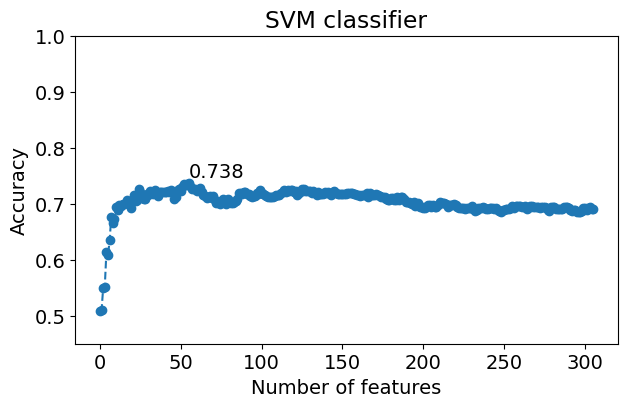

auc_best = 0.73778045
best auc (SVM) =  0.7377804487179487 Number of features =  55
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:04<16:10,  4.88s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:10<17:15,  5.23s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

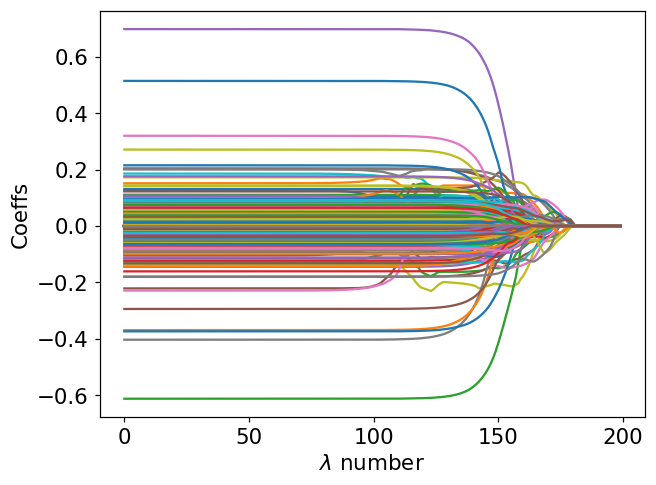

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/306 [00:09<46:08,  9.08s/it]

Iter =  1  UAR = 0.5000
UAR = 0.500


  1%|          | 2/306 [00:19<48:42,  9.61s/it]

UAR = 0.500


  1%|          | 3/306 [00:30<52:05, 10.32s/it]

UAR = 0.500


  1%|▏         | 4/306 [00:41<54:18, 10.79s/it]

UAR = 0.505
Iter =  4  UAR = 0.5052
UAR = 0.500


  2%|▏         | 5/306 [00:53<55:39, 11.10s/it]

UAR = 0.506
Iter =  5  UAR = 0.5060
UAR = 0.500
UAR = 0.507


  2%|▏         | 6/306 [01:04<56:02, 11.21s/it]

UAR = 0.514
Iter =  6  UAR = 0.5144
UAR = 0.500
UAR = 0.504
UAR = 0.509
UAR = 0.524


  2%|▏         | 7/306 [01:16<55:56, 11.23s/it]

UAR = 0.528
UAR = 0.542
Iter =  7  UAR = 0.5421
UAR = 0.500
UAR = 0.514
UAR = 0.518
UAR = 0.548


  3%|▎         | 8/306 [01:27<55:42, 11.22s/it]

UAR = 0.555
UAR = 0.572
Iter =  8  UAR = 0.5723
UAR = 0.500
UAR = 0.501
UAR = 0.526
UAR = 0.546


  3%|▎         | 9/306 [01:38<55:44, 11.26s/it]

UAR = 0.552
UAR = 0.574
Iter =  9  UAR = 0.5739
UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.530
UAR = 0.538
UAR = 0.573


  3%|▎         | 10/306 [01:50<55:47, 11.31s/it]

UAR = 0.576
UAR = 0.607
Iter =  10  UAR = 0.6066
UAR = 0.500
UAR = 0.502
UAR = 0.518
UAR = 0.535
UAR = 0.544
UAR = 0.582


  4%|▎         | 11/306 [02:01<56:06, 11.41s/it]

UAR = 0.593
UAR = 0.609
Iter =  11  UAR = 0.6088
UAR = 0.500
UAR = 0.505
UAR = 0.519
UAR = 0.537
UAR = 0.550
UAR = 0.587


  4%|▍         | 12/306 [02:13<56:28, 11.53s/it]

UAR = 0.592
UAR = 0.604
UAR = 0.500
UAR = 0.501
UAR = 0.526
UAR = 0.544
UAR = 0.564
UAR = 0.611


  4%|▍         | 13/306 [02:25<56:57, 11.67s/it]

UAR = 0.619
UAR = 0.628
Iter =  13  UAR = 0.6280
UAR = 0.500
UAR = 0.504
UAR = 0.527
UAR = 0.546
UAR = 0.569
UAR = 0.610


  5%|▍         | 14/306 [02:37<57:26, 11.80s/it]

UAR = 0.623
UAR = 0.625
UAR = 0.500
UAR = 0.506
UAR = 0.510
UAR = 0.546
UAR = 0.583
UAR = 0.611
UAR = 0.625


  5%|▍         | 15/306 [02:49<57:48, 11.92s/it]

UAR = 0.634
UAR = 0.645
Iter =  15  UAR = 0.6446
UAR = 0.500
UAR = 0.506
UAR = 0.515
UAR = 0.553
UAR = 0.587
UAR = 0.614
UAR = 0.619
UAR = 0.622
UAR = 0.642


  5%|▌         | 16/306 [03:01<57:21, 11.87s/it]

UAR = 0.500
UAR = 0.514
UAR = 0.531
UAR = 0.582
UAR = 0.605
UAR = 0.613
UAR = 0.637


  6%|▌         | 17/306 [03:13<56:59, 11.83s/it]

UAR = 0.639
UAR = 0.500
UAR = 0.503
UAR = 0.517
UAR = 0.540
UAR = 0.586
UAR = 0.608
UAR = 0.609
UAR = 0.616
UAR = 0.635


  6%|▌         | 18/306 [03:25<56:54, 11.86s/it]

UAR = 0.642
UAR = 0.500
UAR = 0.505
UAR = 0.531
UAR = 0.548
UAR = 0.594
UAR = 0.610
UAR = 0.624
UAR = 0.626
UAR = 0.650


  6%|▌         | 19/306 [03:37<56:51, 11.89s/it]

UAR = 0.655
Iter =  19  UAR = 0.6546
UAR = 0.500
UAR = 0.507
UAR = 0.535
UAR = 0.552
UAR = 0.594
UAR = 0.606
UAR = 0.618
UAR = 0.627
UAR = 0.648


  7%|▋         | 20/306 [03:49<57:11, 12.00s/it]

UAR = 0.664
Iter =  20  UAR = 0.6639
UAR = 0.500
UAR = 0.505
UAR = 0.535
UAR = 0.558
UAR = 0.608
UAR = 0.617
UAR = 0.632
UAR = 0.634
UAR = 0.653


  7%|▋         | 21/306 [04:01<57:33, 12.12s/it]

UAR = 0.656
UAR = 0.500
UAR = 0.504
UAR = 0.539
UAR = 0.561
UAR = 0.610
UAR = 0.626
UAR = 0.642
UAR = 0.649


  7%|▋         | 22/306 [04:14<58:06, 12.28s/it]

UAR = 0.655
UAR = 0.500
UAR = 0.507
UAR = 0.540
UAR = 0.569
UAR = 0.609
UAR = 0.629
UAR = 0.629
UAR = 0.646
UAR = 0.661


  8%|▊         | 23/306 [04:27<58:40, 12.44s/it]

UAR = 0.667
Iter =  23  UAR = 0.6673
UAR = 0.500
UAR = 0.515
UAR = 0.545
UAR = 0.587
UAR = 0.613
UAR = 0.632
UAR = 0.634
UAR = 0.657
UAR = 0.666


  8%|▊         | 24/306 [04:40<59:03, 12.56s/it]

UAR = 0.667
Iter =  24  UAR = 0.6675
UAR = 0.500
UAR = 0.524
UAR = 0.548
UAR = 0.590
UAR = 0.620
UAR = 0.638
UAR = 0.642
UAR = 0.657
UAR = 0.668


  8%|▊         | 25/306 [04:53<59:27, 12.70s/it]

UAR = 0.676
Iter =  25  UAR = 0.6763
UAR = 0.500
UAR = 0.512
UAR = 0.546
UAR = 0.549
UAR = 0.614
UAR = 0.641
UAR = 0.652
UAR = 0.665
UAR = 0.674
UAR = 0.677
UAR = 0.681
UAR = 0.683


  8%|▊         | 26/306 [05:06<59:49, 12.82s/it]

Iter =  26  UAR = 0.6829
UAR = 0.500
UAR = 0.512
UAR = 0.546
UAR = 0.555
UAR = 0.611
UAR = 0.638
UAR = 0.652
UAR = 0.665
UAR = 0.674
UAR = 0.677
UAR = 0.689


  9%|▉         | 27/306 [05:19<1:00:18, 12.97s/it]

Iter =  27  UAR = 0.6891
UAR = 0.500
UAR = 0.512
UAR = 0.548
UAR = 0.552
UAR = 0.600
UAR = 0.635
UAR = 0.651
UAR = 0.663
UAR = 0.675
UAR = 0.676
UAR = 0.686


  9%|▉         | 28/306 [05:33<1:00:58, 13.16s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.529
UAR = 0.559
UAR = 0.571
UAR = 0.602
UAR = 0.640
UAR = 0.648
UAR = 0.651
UAR = 0.671
UAR = 0.689
UAR = 0.703


  9%|▉         | 29/306 [05:46<1:01:35, 13.34s/it]

Iter =  29  UAR = 0.7029
UAR = 0.500
UAR = 0.505
UAR = 0.537
UAR = 0.567
UAR = 0.577
UAR = 0.605
UAR = 0.648
UAR = 0.656
UAR = 0.666
UAR = 0.689
UAR = 0.693
UAR = 0.699


 10%|▉         | 30/306 [06:00<1:02:10, 13.51s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.540
UAR = 0.559
UAR = 0.581
UAR = 0.620
UAR = 0.648
UAR = 0.660
UAR = 0.675
UAR = 0.679
UAR = 0.679
UAR = 0.680


 10%|█         | 31/306 [06:15<1:02:51, 13.72s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.537
UAR = 0.562
UAR = 0.579
UAR = 0.622
UAR = 0.643
UAR = 0.654
UAR = 0.655
UAR = 0.678
UAR = 0.688
UAR = 0.689


 10%|█         | 32/306 [06:27<1:01:16, 13.42s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.545
UAR = 0.568
UAR = 0.602
UAR = 0.627
UAR = 0.657
UAR = 0.659
UAR = 0.664
UAR = 0.670
UAR = 0.671
UAR = 0.677
UAR = 0.677
UAR = 0.682


 11%|█         | 33/306 [06:40<1:00:10, 13.23s/it]

UAR = 0.682
UAR = 0.500
UAR = 0.507
UAR = 0.543
UAR = 0.554
UAR = 0.601
UAR = 0.627
UAR = 0.652
UAR = 0.659
UAR = 0.665
UAR = 0.671
UAR = 0.674
UAR = 0.678
UAR = 0.684
UAR = 0.691


 11%|█         | 34/306 [06:53<59:36, 13.15s/it]  

UAR = 0.500
UAR = 0.513
UAR = 0.540
UAR = 0.562
UAR = 0.602
UAR = 0.635
UAR = 0.646
UAR = 0.656
UAR = 0.673
UAR = 0.676
UAR = 0.686
UAR = 0.689


 11%|█▏        | 35/306 [07:06<59:26, 13.16s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.540
UAR = 0.548
UAR = 0.607
UAR = 0.649
UAR = 0.650
UAR = 0.661
UAR = 0.677
UAR = 0.688
UAR = 0.688


 12%|█▏        | 36/306 [07:20<59:35, 13.24s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.545
UAR = 0.548
UAR = 0.610
UAR = 0.651
UAR = 0.669
UAR = 0.670
UAR = 0.674
UAR = 0.682
UAR = 0.687
UAR = 0.689


 12%|█▏        | 37/306 [07:33<59:47, 13.34s/it]

UAR = 0.500
UAR = 0.520
UAR = 0.550
UAR = 0.551
UAR = 0.607
UAR = 0.645
UAR = 0.670
UAR = 0.684
UAR = 0.684
UAR = 0.690
UAR = 0.695


 12%|█▏        | 38/306 [07:47<1:00:12, 13.48s/it]

UAR = 0.500
UAR = 0.515
UAR = 0.535
UAR = 0.546
UAR = 0.602
UAR = 0.646
UAR = 0.673
UAR = 0.681
UAR = 0.684
UAR = 0.688


 13%|█▎        | 39/306 [08:01<1:00:44, 13.65s/it]

UAR = 0.690
UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.543
UAR = 0.558
UAR = 0.619
UAR = 0.658
UAR = 0.671
UAR = 0.684
UAR = 0.692
UAR = 0.694
UAR = 0.695
UAR = 0.696


 13%|█▎        | 40/306 [08:15<1:01:06, 13.79s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.545
UAR = 0.569
UAR = 0.615
UAR = 0.654
UAR = 0.670
UAR = 0.676
UAR = 0.682
UAR = 0.694


 13%|█▎        | 41/306 [08:29<1:01:27, 13.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.550
UAR = 0.574
UAR = 0.620
UAR = 0.645
UAR = 0.659
UAR = 0.663
UAR = 0.675
UAR = 0.676
UAR = 0.683
UAR = 0.689


 14%|█▎        | 42/306 [08:44<1:01:55, 14.07s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.558
UAR = 0.579
UAR = 0.620
UAR = 0.655
UAR = 0.669
UAR = 0.678
UAR = 0.683
UAR = 0.687
UAR = 0.690
UAR = 0.696
UAR = 0.698


 14%|█▍        | 43/306 [08:58<1:02:28, 14.25s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.525
UAR = 0.553
UAR = 0.578
UAR = 0.622
UAR = 0.653
UAR = 0.662
UAR = 0.681
UAR = 0.684
UAR = 0.692
UAR = 0.693


 14%|█▍        | 44/306 [09:13<1:03:11, 14.47s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.553
UAR = 0.577
UAR = 0.622
UAR = 0.648
UAR = 0.667
UAR = 0.675
UAR = 0.679
UAR = 0.699


 15%|█▍        | 45/306 [09:29<1:03:49, 14.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.550
UAR = 0.577
UAR = 0.623
UAR = 0.641
UAR = 0.668
UAR = 0.699
UAR = 0.703
UAR = 0.705
UAR = 0.707
UAR = 0.710


 15%|█▌        | 46/306 [09:44<1:04:26, 14.87s/it]

Iter =  46  UAR = 0.7099
UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.553
UAR = 0.580
UAR = 0.630
UAR = 0.648
UAR = 0.676
UAR = 0.692
UAR = 0.694
UAR = 0.709


 15%|█▌        | 47/306 [09:59<1:04:59, 15.06s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.558
UAR = 0.587
UAR = 0.630
UAR = 0.656
UAR = 0.670
UAR = 0.675
UAR = 0.688
UAR = 0.690
UAR = 0.706


 16%|█▌        | 48/306 [10:13<1:03:27, 14.76s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.555
UAR = 0.590
UAR = 0.630
UAR = 0.653
UAR = 0.671
UAR = 0.691
UAR = 0.691
UAR = 0.694
UAR = 0.702


 16%|█▌        | 49/306 [10:28<1:02:33, 14.61s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.528
UAR = 0.555
UAR = 0.597
UAR = 0.636
UAR = 0.655
UAR = 0.668
UAR = 0.688
UAR = 0.693
UAR = 0.704


 16%|█▋        | 50/306 [10:42<1:02:10, 14.57s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.533
UAR = 0.556
UAR = 0.596
UAR = 0.639
UAR = 0.663
UAR = 0.666
UAR = 0.666
UAR = 0.692
UAR = 0.707
UAR = 0.708


 17%|█▋        | 51/306 [10:57<1:02:11, 14.63s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.551
UAR = 0.563
UAR = 0.599
UAR = 0.637
UAR = 0.653
UAR = 0.657
UAR = 0.662
UAR = 0.685
UAR = 0.689
UAR = 0.698


 17%|█▋        | 52/306 [11:12<1:02:22, 14.73s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.546
UAR = 0.563
UAR = 0.599
UAR = 0.632
UAR = 0.650
UAR = 0.655
UAR = 0.660
UAR = 0.681
UAR = 0.691
UAR = 0.694


 17%|█▋        | 53/306 [11:27<1:02:39, 14.86s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.546
UAR = 0.563
UAR = 0.602
UAR = 0.632
UAR = 0.652
UAR = 0.658
UAR = 0.682
UAR = 0.694
UAR = 0.699


 18%|█▊        | 54/306 [11:43<1:03:10, 15.04s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.543
UAR = 0.561
UAR = 0.602
UAR = 0.635
UAR = 0.649
UAR = 0.656
UAR = 0.679
UAR = 0.692
UAR = 0.699


 18%|█▊        | 55/306 [11:58<1:03:41, 15.22s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.543
UAR = 0.562
UAR = 0.603
UAR = 0.645
UAR = 0.657
UAR = 0.681
UAR = 0.693
UAR = 0.697


 18%|█▊        | 56/306 [12:14<1:04:05, 15.38s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.544
UAR = 0.561
UAR = 0.608
UAR = 0.641
UAR = 0.650
UAR = 0.650
UAR = 0.655
UAR = 0.673
UAR = 0.676
UAR = 0.698


 19%|█▊        | 57/306 [12:30<1:04:40, 15.58s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.541
UAR = 0.557
UAR = 0.607
UAR = 0.644
UAR = 0.649
UAR = 0.660
UAR = 0.675
UAR = 0.678
UAR = 0.701


 19%|█▉        | 58/306 [12:46<1:05:19, 15.80s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.552
UAR = 0.614
UAR = 0.646
UAR = 0.648
UAR = 0.651
UAR = 0.657
UAR = 0.674
UAR = 0.677
UAR = 0.693


 19%|█▉        | 59/306 [13:03<1:06:01, 16.04s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.542
UAR = 0.552
UAR = 0.618
UAR = 0.644
UAR = 0.651
UAR = 0.655
UAR = 0.678
UAR = 0.699


 20%|█▉        | 60/306 [13:20<1:06:51, 16.31s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.542
UAR = 0.546
UAR = 0.554
UAR = 0.621
UAR = 0.644
UAR = 0.655
UAR = 0.661
UAR = 0.675
UAR = 0.678
UAR = 0.690
UAR = 0.698


 20%|█▉        | 61/306 [13:37<1:07:33, 16.55s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.546
UAR = 0.557
UAR = 0.616
UAR = 0.644
UAR = 0.653
UAR = 0.660
UAR = 0.682
UAR = 0.696
UAR = 0.697


 20%|██        | 62/306 [13:54<1:08:13, 16.78s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.542
UAR = 0.544
UAR = 0.557
UAR = 0.615
UAR = 0.647
UAR = 0.648
UAR = 0.650
UAR = 0.662
UAR = 0.685
UAR = 0.698


 21%|██        | 63/306 [14:12<1:08:52, 17.00s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.542
UAR = 0.557
UAR = 0.615
UAR = 0.650
UAR = 0.661
UAR = 0.683
UAR = 0.700


 21%|██        | 64/306 [14:27<1:06:37, 16.52s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.542
UAR = 0.551
UAR = 0.617
UAR = 0.649
UAR = 0.660
UAR = 0.680
UAR = 0.701


 21%|██        | 65/306 [14:43<1:05:19, 16.26s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.542
UAR = 0.549
UAR = 0.615
UAR = 0.655
UAR = 0.663
UAR = 0.680
UAR = 0.699


 22%|██▏       | 66/306 [14:59<1:04:42, 16.18s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.541
UAR = 0.562
UAR = 0.609
UAR = 0.655
UAR = 0.656
UAR = 0.673
UAR = 0.680
UAR = 0.683
UAR = 0.696


 22%|██▏       | 67/306 [15:15<1:04:28, 16.19s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.536
UAR = 0.538
UAR = 0.567
UAR = 0.611
UAR = 0.639
UAR = 0.648
UAR = 0.665
UAR = 0.681
UAR = 0.695


 22%|██▏       | 68/306 [15:32<1:04:33, 16.28s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.542
UAR = 0.572
UAR = 0.613
UAR = 0.637
UAR = 0.643
UAR = 0.644
UAR = 0.670
UAR = 0.677
UAR = 0.685
UAR = 0.691


 23%|██▎       | 69/306 [15:48<1:04:54, 16.43s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.539
UAR = 0.572
UAR = 0.610
UAR = 0.634
UAR = 0.638
UAR = 0.643
UAR = 0.662
UAR = 0.677
UAR = 0.679
UAR = 0.690


 23%|██▎       | 70/306 [16:06<1:05:36, 16.68s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.539
UAR = 0.572
UAR = 0.613
UAR = 0.637
UAR = 0.643
UAR = 0.663
UAR = 0.678
UAR = 0.681
UAR = 0.688


 23%|██▎       | 71/306 [16:23<1:06:19, 16.94s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.539
UAR = 0.572
UAR = 0.613
UAR = 0.639
UAR = 0.640
UAR = 0.643
UAR = 0.668
UAR = 0.680
UAR = 0.682
UAR = 0.682


 24%|██▎       | 72/306 [16:41<1:06:52, 17.15s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.539
UAR = 0.570
UAR = 0.613
UAR = 0.634
UAR = 0.638
UAR = 0.644
UAR = 0.672
UAR = 0.680
UAR = 0.689
UAR = 0.692


 24%|██▍       | 73/306 [16:59<1:07:28, 17.38s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.536
UAR = 0.570
UAR = 0.611
UAR = 0.631
UAR = 0.633
UAR = 0.642
UAR = 0.672
UAR = 0.674
UAR = 0.681
UAR = 0.689


 24%|██▍       | 74/306 [17:17<1:08:15, 17.65s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.536
UAR = 0.570
UAR = 0.611
UAR = 0.629
UAR = 0.633
UAR = 0.645
UAR = 0.672
UAR = 0.677
UAR = 0.687
UAR = 0.689


 25%|██▍       | 75/306 [17:36<1:08:58, 17.92s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.536
UAR = 0.570
UAR = 0.613
UAR = 0.629
UAR = 0.633
UAR = 0.645
UAR = 0.669
UAR = 0.679
UAR = 0.688


 25%|██▍       | 76/306 [17:54<1:09:41, 18.18s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.536
UAR = 0.572
UAR = 0.614
UAR = 0.632
UAR = 0.633
UAR = 0.641
UAR = 0.669
UAR = 0.677
UAR = 0.685
UAR = 0.688


 25%|██▌       | 77/306 [18:13<1:10:22, 18.44s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.536
UAR = 0.572
UAR = 0.616
UAR = 0.633
UAR = 0.637
UAR = 0.639
UAR = 0.639
UAR = 0.674
UAR = 0.681
UAR = 0.697


 25%|██▌       | 78/306 [18:33<1:11:00, 18.68s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.536
UAR = 0.572
UAR = 0.614
UAR = 0.634
UAR = 0.637
UAR = 0.641
UAR = 0.676
UAR = 0.699


 26%|██▌       | 79/306 [18:52<1:11:43, 18.96s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.536
UAR = 0.572
UAR = 0.616
UAR = 0.631
UAR = 0.637
UAR = 0.644
UAR = 0.670
UAR = 0.675
UAR = 0.695
UAR = 0.695


 26%|██▌       | 80/306 [19:09<1:09:15, 18.39s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.531
UAR = 0.572
UAR = 0.616
UAR = 0.633
UAR = 0.640
UAR = 0.647
UAR = 0.670
UAR = 0.678
UAR = 0.698


 26%|██▋       | 81/306 [19:26<1:07:39, 18.04s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.531
UAR = 0.572
UAR = 0.616
UAR = 0.633
UAR = 0.637
UAR = 0.647
UAR = 0.671
UAR = 0.678
UAR = 0.698


 27%|██▋       | 82/306 [19:44<1:06:51, 17.91s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.531
UAR = 0.572
UAR = 0.618
UAR = 0.636
UAR = 0.638
UAR = 0.641
UAR = 0.670
UAR = 0.681
UAR = 0.700


 27%|██▋       | 83/306 [20:02<1:06:21, 17.85s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.531
UAR = 0.572
UAR = 0.619
UAR = 0.630
UAR = 0.641
UAR = 0.653
UAR = 0.668
UAR = 0.678
UAR = 0.699


 27%|██▋       | 84/306 [20:20<1:06:21, 17.93s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.536
UAR = 0.569
UAR = 0.622
UAR = 0.631
UAR = 0.632
UAR = 0.646
UAR = 0.665
UAR = 0.678
UAR = 0.694


 28%|██▊       | 85/306 [20:38<1:06:43, 18.12s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.534
UAR = 0.569
UAR = 0.625
UAR = 0.633
UAR = 0.638
UAR = 0.653
UAR = 0.674
UAR = 0.686
UAR = 0.704


 28%|██▊       | 86/306 [20:57<1:07:10, 18.32s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.529
UAR = 0.569
UAR = 0.627
UAR = 0.628
UAR = 0.634
UAR = 0.635
UAR = 0.656
UAR = 0.670
UAR = 0.686
UAR = 0.700
UAR = 0.701


 28%|██▊       | 87/306 [21:16<1:07:50, 18.59s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.526
UAR = 0.569
UAR = 0.628
UAR = 0.640
UAR = 0.653
UAR = 0.668
UAR = 0.690
UAR = 0.703
UAR = 0.710


 29%|██▉       | 88/306 [21:36<1:08:18, 18.80s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.526
UAR = 0.570
UAR = 0.622
UAR = 0.630
UAR = 0.639
UAR = 0.650
UAR = 0.672
UAR = 0.689
UAR = 0.704
UAR = 0.706


 29%|██▉       | 89/306 [21:55<1:08:55, 19.06s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.526
UAR = 0.569
UAR = 0.622
UAR = 0.630
UAR = 0.634
UAR = 0.653
UAR = 0.669
UAR = 0.684
UAR = 0.704
UAR = 0.705


 29%|██▉       | 90/306 [22:16<1:09:43, 19.37s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.523
UAR = 0.562
UAR = 0.615
UAR = 0.631
UAR = 0.640
UAR = 0.656
UAR = 0.676
UAR = 0.689
UAR = 0.708


 30%|██▉       | 91/306 [22:36<1:10:25, 19.65s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.523
UAR = 0.564
UAR = 0.617
UAR = 0.636
UAR = 0.639
UAR = 0.657
UAR = 0.673
UAR = 0.689
UAR = 0.702


 30%|███       | 92/306 [22:56<1:11:04, 19.93s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.521
UAR = 0.564
UAR = 0.619
UAR = 0.633
UAR = 0.634
UAR = 0.657
UAR = 0.667
UAR = 0.689
UAR = 0.704


 30%|███       | 93/306 [23:17<1:11:46, 20.22s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.521
UAR = 0.565
UAR = 0.618
UAR = 0.628
UAR = 0.635
UAR = 0.659
UAR = 0.672
UAR = 0.687
UAR = 0.708


 31%|███       | 94/306 [23:39<1:12:29, 20.52s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.523
UAR = 0.584
UAR = 0.622
UAR = 0.636
UAR = 0.639
UAR = 0.653
UAR = 0.675
UAR = 0.684
UAR = 0.697
UAR = 0.700


 31%|███       | 95/306 [24:00<1:13:14, 20.83s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.523
UAR = 0.584
UAR = 0.624
UAR = 0.637
UAR = 0.654
UAR = 0.678
UAR = 0.681
UAR = 0.703


 31%|███▏      | 96/306 [24:19<1:10:47, 20.22s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.520
UAR = 0.586
UAR = 0.621
UAR = 0.637
UAR = 0.638
UAR = 0.652
UAR = 0.682
UAR = 0.689
UAR = 0.700
UAR = 0.700


 32%|███▏      | 97/306 [24:38<1:09:21, 19.91s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.518
UAR = 0.586
UAR = 0.621
UAR = 0.632
UAR = 0.638
UAR = 0.652
UAR = 0.676
UAR = 0.680
UAR = 0.685
UAR = 0.706


 32%|███▏      | 98/306 [24:58<1:08:39, 19.80s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.516
UAR = 0.586
UAR = 0.622
UAR = 0.632
UAR = 0.633
UAR = 0.635
UAR = 0.651
UAR = 0.678
UAR = 0.684
UAR = 0.711


 32%|███▏      | 99/306 [25:17<1:08:20, 19.81s/it]

Iter =  99  UAR = 0.7113
UAR = 0.500
UAR = 0.513
UAR = 0.516
UAR = 0.584
UAR = 0.622
UAR = 0.631
UAR = 0.635
UAR = 0.651
UAR = 0.681
UAR = 0.684
UAR = 0.706


 33%|███▎      | 100/306 [25:38<1:08:25, 19.93s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.516
UAR = 0.582
UAR = 0.624
UAR = 0.629
UAR = 0.630
UAR = 0.636
UAR = 0.654
UAR = 0.683
UAR = 0.692
UAR = 0.709


 33%|███▎      | 101/306 [25:58<1:08:40, 20.10s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.516
UAR = 0.585
UAR = 0.622
UAR = 0.634
UAR = 0.636
UAR = 0.654
UAR = 0.681
UAR = 0.691
UAR = 0.708
UAR = 0.710


 33%|███▎      | 102/306 [26:19<1:09:01, 20.30s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.518
UAR = 0.582
UAR = 0.627
UAR = 0.631
UAR = 0.632
UAR = 0.637
UAR = 0.674
UAR = 0.685
UAR = 0.698
UAR = 0.716


 34%|███▎      | 103/306 [26:41<1:10:03, 20.71s/it]

Iter =  103  UAR = 0.7159
UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.518
UAR = 0.585
UAR = 0.624
UAR = 0.629
UAR = 0.635
UAR = 0.642
UAR = 0.668
UAR = 0.690
UAR = 0.695
UAR = 0.713


 34%|███▍      | 104/306 [27:02<1:10:39, 20.99s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.518
UAR = 0.587
UAR = 0.624
UAR = 0.629
UAR = 0.639
UAR = 0.666
UAR = 0.688
UAR = 0.695
UAR = 0.710


 34%|███▍      | 105/306 [27:24<1:11:19, 21.29s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.518
UAR = 0.587
UAR = 0.624
UAR = 0.629
UAR = 0.639
UAR = 0.666
UAR = 0.688
UAR = 0.690
UAR = 0.719


 35%|███▍      | 106/306 [27:47<1:11:58, 21.59s/it]

Iter =  106  UAR = 0.7185
UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.520
UAR = 0.589
UAR = 0.624
UAR = 0.630
UAR = 0.643
UAR = 0.661
UAR = 0.683
UAR = 0.689
UAR = 0.712


 35%|███▍      | 107/306 [28:09<1:12:48, 21.95s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.515
UAR = 0.520
UAR = 0.586
UAR = 0.623
UAR = 0.628
UAR = 0.642
UAR = 0.661
UAR = 0.686
UAR = 0.712


 35%|███▌      | 108/306 [28:32<1:13:36, 22.30s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.516
UAR = 0.520
UAR = 0.590
UAR = 0.623
UAR = 0.626
UAR = 0.639
UAR = 0.656
UAR = 0.680
UAR = 0.685
UAR = 0.715


 36%|███▌      | 109/306 [28:56<1:14:23, 22.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.520
UAR = 0.587
UAR = 0.618
UAR = 0.626
UAR = 0.639
UAR = 0.657
UAR = 0.681
UAR = 0.688
UAR = 0.713


 36%|███▌      | 110/306 [29:20<1:15:04, 22.98s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.520
UAR = 0.586
UAR = 0.621
UAR = 0.638
UAR = 0.640
UAR = 0.667
UAR = 0.693
UAR = 0.713


 36%|███▋      | 111/306 [29:44<1:15:48, 23.33s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.520
UAR = 0.586
UAR = 0.622
UAR = 0.628
UAR = 0.643
UAR = 0.667
UAR = 0.688
UAR = 0.690
UAR = 0.714


 37%|███▋      | 112/306 [30:05<1:13:23, 22.70s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.520
UAR = 0.589
UAR = 0.620
UAR = 0.628
UAR = 0.643
UAR = 0.670
UAR = 0.683
UAR = 0.694
UAR = 0.708


 37%|███▋      | 113/306 [30:27<1:11:52, 22.35s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.520
UAR = 0.586
UAR = 0.622
UAR = 0.628
UAR = 0.643
UAR = 0.673
UAR = 0.679
UAR = 0.700
UAR = 0.708


 37%|███▋      | 114/306 [30:48<1:11:01, 22.20s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.586
UAR = 0.624
UAR = 0.628
UAR = 0.640
UAR = 0.670
UAR = 0.680
UAR = 0.698
UAR = 0.702


 38%|███▊      | 115/306 [31:11<1:10:34, 22.17s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.518
UAR = 0.585
UAR = 0.622
UAR = 0.630
UAR = 0.632
UAR = 0.639
UAR = 0.671
UAR = 0.682
UAR = 0.691
UAR = 0.708


 38%|███▊      | 116/306 [31:33<1:10:45, 22.34s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.585
UAR = 0.615
UAR = 0.631
UAR = 0.632
UAR = 0.639
UAR = 0.671
UAR = 0.683
UAR = 0.693
UAR = 0.709


 38%|███▊      | 117/306 [31:57<1:11:15, 22.62s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.585
UAR = 0.612
UAR = 0.631
UAR = 0.632
UAR = 0.636
UAR = 0.675
UAR = 0.682
UAR = 0.694
UAR = 0.710


 39%|███▊      | 118/306 [32:20<1:11:40, 22.88s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.585
UAR = 0.612
UAR = 0.633
UAR = 0.638
UAR = 0.676
UAR = 0.685
UAR = 0.694
UAR = 0.707


 39%|███▉      | 119/306 [32:44<1:12:05, 23.13s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.588
UAR = 0.613
UAR = 0.633
UAR = 0.635
UAR = 0.679
UAR = 0.685
UAR = 0.686
UAR = 0.704


 39%|███▉      | 120/306 [33:08<1:12:22, 23.34s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.588
UAR = 0.613
UAR = 0.633
UAR = 0.635
UAR = 0.684
UAR = 0.689
UAR = 0.704


 40%|███▉      | 121/306 [33:32<1:12:47, 23.61s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.588
UAR = 0.613
UAR = 0.633
UAR = 0.637
UAR = 0.682
UAR = 0.688
UAR = 0.704


 40%|███▉      | 122/306 [33:56<1:13:15, 23.89s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.588
UAR = 0.616
UAR = 0.634
UAR = 0.637
UAR = 0.677
UAR = 0.679
UAR = 0.691
UAR = 0.703


 40%|████      | 123/306 [34:21<1:13:45, 24.18s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.589
UAR = 0.616
UAR = 0.634
UAR = 0.637
UAR = 0.677
UAR = 0.694
UAR = 0.701


 41%|████      | 124/306 [34:46<1:14:20, 24.51s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.586
UAR = 0.613
UAR = 0.631
UAR = 0.632
UAR = 0.675
UAR = 0.679
UAR = 0.704


 41%|████      | 125/306 [35:12<1:14:58, 24.85s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.518
UAR = 0.586
UAR = 0.616
UAR = 0.629
UAR = 0.634
UAR = 0.673
UAR = 0.677
UAR = 0.681
UAR = 0.705


 41%|████      | 126/306 [35:38<1:15:34, 25.19s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.515
UAR = 0.584
UAR = 0.611
UAR = 0.627
UAR = 0.633
UAR = 0.671
UAR = 0.672
UAR = 0.682
UAR = 0.700


 42%|████▏     | 127/306 [36:04<1:16:09, 25.53s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.584
UAR = 0.608
UAR = 0.627
UAR = 0.632
UAR = 0.670
UAR = 0.672
UAR = 0.681
UAR = 0.697


 42%|████▏     | 128/306 [36:28<1:13:42, 24.84s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.584
UAR = 0.608
UAR = 0.624
UAR = 0.630
UAR = 0.674
UAR = 0.675
UAR = 0.683
UAR = 0.697


 42%|████▏     | 129/306 [36:51<1:12:01, 24.42s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.586
UAR = 0.609
UAR = 0.624
UAR = 0.643
UAR = 0.671
UAR = 0.671
UAR = 0.688
UAR = 0.695


 42%|████▏     | 130/306 [37:15<1:10:54, 24.18s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.589
UAR = 0.609
UAR = 0.624
UAR = 0.640
UAR = 0.668
UAR = 0.671
UAR = 0.681
UAR = 0.694


 43%|████▎     | 131/306 [37:39<1:10:22, 24.13s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.589
UAR = 0.611
UAR = 0.624
UAR = 0.640
UAR = 0.668
UAR = 0.670
UAR = 0.681
UAR = 0.694


 43%|████▎     | 132/306 [38:03<1:10:15, 24.23s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.589
UAR = 0.611
UAR = 0.622
UAR = 0.640
UAR = 0.669
UAR = 0.681
UAR = 0.691


 43%|████▎     | 133/306 [38:28<1:10:24, 24.42s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.520
UAR = 0.589
UAR = 0.611
UAR = 0.624
UAR = 0.643
UAR = 0.663
UAR = 0.671
UAR = 0.677
UAR = 0.687


 44%|████▍     | 134/306 [38:53<1:10:44, 24.68s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.587
UAR = 0.614
UAR = 0.622
UAR = 0.640
UAR = 0.668
UAR = 0.669
UAR = 0.673
UAR = 0.689


 44%|████▍     | 135/306 [39:19<1:11:12, 24.98s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.584
UAR = 0.611
UAR = 0.624
UAR = 0.641
UAR = 0.666
UAR = 0.669
UAR = 0.676
UAR = 0.687


 44%|████▍     | 136/306 [39:45<1:11:32, 25.25s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.582
UAR = 0.614
UAR = 0.624
UAR = 0.641
UAR = 0.665
UAR = 0.672
UAR = 0.675
UAR = 0.689


 45%|████▍     | 137/306 [40:11<1:12:01, 25.57s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.584
UAR = 0.616
UAR = 0.624
UAR = 0.641
UAR = 0.665
UAR = 0.672
UAR = 0.672
UAR = 0.692


 45%|████▌     | 138/306 [40:38<1:12:23, 25.86s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.584
UAR = 0.613
UAR = 0.622
UAR = 0.639
UAR = 0.665
UAR = 0.669
UAR = 0.673
UAR = 0.686


 45%|████▌     | 139/306 [41:05<1:12:53, 26.19s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.584
UAR = 0.613
UAR = 0.624
UAR = 0.641
UAR = 0.663
UAR = 0.669
UAR = 0.671
UAR = 0.673
UAR = 0.686


 46%|████▌     | 140/306 [41:32<1:13:11, 26.45s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.584
UAR = 0.610
UAR = 0.622
UAR = 0.641
UAR = 0.663
UAR = 0.669
UAR = 0.673
UAR = 0.684


 46%|████▌     | 141/306 [41:59<1:13:41, 26.79s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.584
UAR = 0.614
UAR = 0.619
UAR = 0.639
UAR = 0.665
UAR = 0.672
UAR = 0.676
UAR = 0.688


 46%|████▋     | 142/306 [42:27<1:14:08, 27.12s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.584
UAR = 0.613
UAR = 0.622
UAR = 0.639
UAR = 0.656
UAR = 0.674
UAR = 0.675
UAR = 0.686


 47%|████▋     | 143/306 [42:56<1:14:39, 27.48s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.582
UAR = 0.611
UAR = 0.622
UAR = 0.641
UAR = 0.659
UAR = 0.675
UAR = 0.677
UAR = 0.689


 47%|████▋     | 144/306 [43:20<1:11:59, 26.66s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.583
UAR = 0.614
UAR = 0.624
UAR = 0.641
UAR = 0.663
UAR = 0.674
UAR = 0.677
UAR = 0.686


 47%|████▋     | 145/306 [43:46<1:10:40, 26.34s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.582
UAR = 0.614
UAR = 0.624
UAR = 0.641
UAR = 0.665
UAR = 0.672
UAR = 0.674
UAR = 0.686


 48%|████▊     | 146/306 [44:12<1:09:44, 26.16s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.582
UAR = 0.614
UAR = 0.627
UAR = 0.642
UAR = 0.664
UAR = 0.672
UAR = 0.674
UAR = 0.686


 48%|████▊     | 147/306 [44:38<1:09:12, 26.12s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.583
UAR = 0.612
UAR = 0.627
UAR = 0.641
UAR = 0.665
UAR = 0.672
UAR = 0.674
UAR = 0.686


 48%|████▊     | 148/306 [45:04<1:08:52, 26.15s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.583
UAR = 0.612
UAR = 0.627
UAR = 0.641
UAR = 0.665
UAR = 0.669
UAR = 0.674
UAR = 0.686


 49%|████▊     | 149/306 [45:31<1:08:56, 26.35s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.583
UAR = 0.612
UAR = 0.627
UAR = 0.641
UAR = 0.667
UAR = 0.671
UAR = 0.671
UAR = 0.683


 49%|████▉     | 150/306 [45:58<1:09:05, 26.57s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.580
UAR = 0.614
UAR = 0.627
UAR = 0.636
UAR = 0.660
UAR = 0.669
UAR = 0.682


 49%|████▉     | 151/306 [46:25<1:09:16, 26.82s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.581
UAR = 0.614
UAR = 0.624
UAR = 0.636
UAR = 0.660
UAR = 0.672
UAR = 0.684


 50%|████▉     | 152/306 [46:53<1:09:17, 27.00s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.580
UAR = 0.611
UAR = 0.624
UAR = 0.635
UAR = 0.663
UAR = 0.675
UAR = 0.684


 50%|█████     | 153/306 [47:20<1:09:31, 27.26s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.578
UAR = 0.611
UAR = 0.624
UAR = 0.635
UAR = 0.670
UAR = 0.670
UAR = 0.677
UAR = 0.681


 50%|█████     | 154/306 [47:49<1:09:49, 27.56s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.579
UAR = 0.611
UAR = 0.624
UAR = 0.633
UAR = 0.669
UAR = 0.675
UAR = 0.684


 51%|█████     | 155/306 [48:17<1:10:11, 27.89s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.579
UAR = 0.611
UAR = 0.621
UAR = 0.632
UAR = 0.669
UAR = 0.672
UAR = 0.675
UAR = 0.681


 51%|█████     | 156/306 [48:46<1:10:20, 28.14s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.579
UAR = 0.611
UAR = 0.621
UAR = 0.632
UAR = 0.661
UAR = 0.667
UAR = 0.675
UAR = 0.681


 51%|█████▏    | 157/306 [49:15<1:10:41, 28.47s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.579
UAR = 0.611
UAR = 0.621
UAR = 0.632
UAR = 0.664
UAR = 0.668
UAR = 0.675
UAR = 0.681


 52%|█████▏    | 158/306 [49:45<1:10:55, 28.75s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.520
UAR = 0.577
UAR = 0.614
UAR = 0.618
UAR = 0.629
UAR = 0.664
UAR = 0.668
UAR = 0.677
UAR = 0.687


 52%|█████▏    | 159/306 [50:15<1:11:19, 29.11s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.580
UAR = 0.614
UAR = 0.618
UAR = 0.632
UAR = 0.664
UAR = 0.667
UAR = 0.677
UAR = 0.687


 52%|█████▏    | 160/306 [50:41<1:08:52, 28.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.584
UAR = 0.611
UAR = 0.618
UAR = 0.636
UAR = 0.660
UAR = 0.669
UAR = 0.671
UAR = 0.686


 53%|█████▎    | 161/306 [51:08<1:07:26, 27.90s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.584
UAR = 0.611
UAR = 0.618
UAR = 0.636
UAR = 0.662
UAR = 0.667
UAR = 0.673
UAR = 0.686


 53%|█████▎    | 162/306 [51:35<1:06:25, 27.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.584
UAR = 0.611
UAR = 0.618
UAR = 0.636
UAR = 0.660
UAR = 0.666
UAR = 0.674
UAR = 0.687


 53%|█████▎    | 163/306 [52:03<1:05:52, 27.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.584
UAR = 0.611
UAR = 0.618
UAR = 0.636
UAR = 0.660
UAR = 0.666
UAR = 0.674
UAR = 0.686


 54%|█████▎    | 164/306 [52:30<1:05:23, 27.63s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.520
UAR = 0.584
UAR = 0.613
UAR = 0.620
UAR = 0.636
UAR = 0.657
UAR = 0.670
UAR = 0.676
UAR = 0.681


 54%|█████▍    | 165/306 [52:59<1:05:23, 27.83s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.584
UAR = 0.608
UAR = 0.623
UAR = 0.637
UAR = 0.661
UAR = 0.666
UAR = 0.673
UAR = 0.681


 54%|█████▍    | 166/306 [53:27<1:05:25, 28.04s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.584
UAR = 0.608
UAR = 0.623
UAR = 0.634
UAR = 0.660
UAR = 0.667
UAR = 0.669
UAR = 0.684


 55%|█████▍    | 167/306 [53:56<1:05:35, 28.31s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.584
UAR = 0.608
UAR = 0.623
UAR = 0.637
UAR = 0.659
UAR = 0.671
UAR = 0.678
UAR = 0.688


 55%|█████▍    | 168/306 [54:25<1:05:23, 28.43s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.584
UAR = 0.610
UAR = 0.623
UAR = 0.634
UAR = 0.656
UAR = 0.671
UAR = 0.675
UAR = 0.687


 55%|█████▌    | 169/306 [54:54<1:05:27, 28.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.520
UAR = 0.583
UAR = 0.611
UAR = 0.624
UAR = 0.632
UAR = 0.657
UAR = 0.669
UAR = 0.677
UAR = 0.685


 56%|█████▌    | 170/306 [55:24<1:05:41, 28.98s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.583
UAR = 0.610
UAR = 0.621
UAR = 0.637
UAR = 0.650
UAR = 0.669
UAR = 0.677
UAR = 0.684


 56%|█████▌    | 171/306 [55:54<1:05:58, 29.33s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.582
UAR = 0.610
UAR = 0.621
UAR = 0.637
UAR = 0.659
UAR = 0.666
UAR = 0.679
UAR = 0.683


 56%|█████▌    | 172/306 [56:24<1:06:04, 29.58s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.523
UAR = 0.582
UAR = 0.611
UAR = 0.621
UAR = 0.637
UAR = 0.660
UAR = 0.669
UAR = 0.676
UAR = 0.684


 57%|█████▋    | 173/306 [56:55<1:06:22, 29.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.585
UAR = 0.609
UAR = 0.611
UAR = 0.638
UAR = 0.658
UAR = 0.662
UAR = 0.671
UAR = 0.682


 57%|█████▋    | 174/306 [57:26<1:06:37, 30.29s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.585
UAR = 0.609
UAR = 0.614
UAR = 0.638
UAR = 0.661
UAR = 0.662
UAR = 0.671
UAR = 0.682


 57%|█████▋    | 175/306 [57:57<1:06:54, 30.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.585
UAR = 0.609
UAR = 0.619
UAR = 0.638
UAR = 0.655
UAR = 0.661
UAR = 0.672
UAR = 0.684


 58%|█████▊    | 176/306 [58:25<1:04:35, 29.81s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.585
UAR = 0.608
UAR = 0.616
UAR = 0.638
UAR = 0.655
UAR = 0.660
UAR = 0.672
UAR = 0.684


 58%|█████▊    | 177/306 [58:54<1:03:14, 29.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.528
UAR = 0.585
UAR = 0.607
UAR = 0.616
UAR = 0.636
UAR = 0.658
UAR = 0.660
UAR = 0.674
UAR = 0.682


 58%|█████▊    | 178/306 [59:22<1:02:14, 29.17s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.585
UAR = 0.605
UAR = 0.617
UAR = 0.638
UAR = 0.661
UAR = 0.681
UAR = 0.685


 58%|█████▊    | 179/306 [59:52<1:01:42, 29.15s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.528
UAR = 0.582
UAR = 0.606
UAR = 0.617
UAR = 0.636
UAR = 0.656
UAR = 0.666
UAR = 0.676
UAR = 0.682


 59%|█████▉    | 180/306 [1:00:21<1:01:09, 29.12s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.585
UAR = 0.606
UAR = 0.618
UAR = 0.636
UAR = 0.656
UAR = 0.663
UAR = 0.675
UAR = 0.682


 59%|█████▉    | 181/306 [1:00:50<1:01:08, 29.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.585
UAR = 0.606
UAR = 0.619
UAR = 0.633
UAR = 0.656
UAR = 0.661
UAR = 0.670
UAR = 0.685


 59%|█████▉    | 182/306 [1:01:21<1:01:05, 29.56s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.586
UAR = 0.603
UAR = 0.617
UAR = 0.631
UAR = 0.652
UAR = 0.660
UAR = 0.674
UAR = 0.683


 60%|█████▉    | 183/306 [1:01:51<1:01:08, 29.83s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.583
UAR = 0.601
UAR = 0.614
UAR = 0.631
UAR = 0.655
UAR = 0.659
UAR = 0.675
UAR = 0.681


 60%|██████    | 184/306 [1:02:21<1:00:59, 29.99s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.583
UAR = 0.601
UAR = 0.614
UAR = 0.628
UAR = 0.652
UAR = 0.656
UAR = 0.674
UAR = 0.684


 60%|██████    | 185/306 [1:02:52<1:01:04, 30.29s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.585
UAR = 0.603
UAR = 0.616
UAR = 0.634
UAR = 0.657
UAR = 0.677
UAR = 0.687


 61%|██████    | 186/306 [1:03:24<1:01:08, 30.57s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.586
UAR = 0.603
UAR = 0.613
UAR = 0.631
UAR = 0.655
UAR = 0.655
UAR = 0.679
UAR = 0.687


 61%|██████    | 187/306 [1:03:55<1:01:21, 30.94s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.591
UAR = 0.608
UAR = 0.613
UAR = 0.631
UAR = 0.649
UAR = 0.655
UAR = 0.676
UAR = 0.685


 61%|██████▏   | 188/306 [1:04:27<1:01:19, 31.18s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.588
UAR = 0.605
UAR = 0.613
UAR = 0.630
UAR = 0.650
UAR = 0.658
UAR = 0.681
UAR = 0.688


 62%|██████▏   | 189/306 [1:05:00<1:01:31, 31.55s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.588
UAR = 0.603
UAR = 0.613
UAR = 0.631
UAR = 0.653
UAR = 0.655
UAR = 0.656
UAR = 0.674
UAR = 0.689


 62%|██████▏   | 190/306 [1:05:32<1:01:37, 31.87s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.588
UAR = 0.603
UAR = 0.613
UAR = 0.628
UAR = 0.653
UAR = 0.656
UAR = 0.674
UAR = 0.690


 62%|██████▏   | 191/306 [1:06:05<1:01:48, 32.25s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.589
UAR = 0.600
UAR = 0.613
UAR = 0.628
UAR = 0.653
UAR = 0.656
UAR = 0.674
UAR = 0.688


 63%|██████▎   | 192/306 [1:06:35<59:40, 31.40s/it]  

UAR = 0.500
UAR = 0.531
UAR = 0.588
UAR = 0.606
UAR = 0.613
UAR = 0.627
UAR = 0.656
UAR = 0.675
UAR = 0.686


 63%|██████▎   | 193/306 [1:07:05<58:26, 31.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.588
UAR = 0.608
UAR = 0.615
UAR = 0.627
UAR = 0.662
UAR = 0.673
UAR = 0.692


 63%|██████▎   | 194/306 [1:07:35<57:28, 30.79s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.588
UAR = 0.606
UAR = 0.615
UAR = 0.630
UAR = 0.660
UAR = 0.673
UAR = 0.692


 64%|██████▎   | 195/306 [1:08:06<56:55, 30.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.588
UAR = 0.606
UAR = 0.615
UAR = 0.627
UAR = 0.662
UAR = 0.673
UAR = 0.689


 64%|██████▍   | 196/306 [1:08:36<56:21, 30.74s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.588
UAR = 0.606
UAR = 0.617
UAR = 0.632
UAR = 0.657
UAR = 0.674
UAR = 0.690


 64%|██████▍   | 197/306 [1:09:08<56:11, 30.94s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.588
UAR = 0.609
UAR = 0.617
UAR = 0.632
UAR = 0.654
UAR = 0.672
UAR = 0.681


 65%|██████▍   | 198/306 [1:09:40<56:05, 31.16s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.589
UAR = 0.609
UAR = 0.620
UAR = 0.634
UAR = 0.654
UAR = 0.654
UAR = 0.668
UAR = 0.681


 65%|██████▌   | 199/306 [1:10:12<56:07, 31.47s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.587
UAR = 0.608
UAR = 0.617
UAR = 0.636
UAR = 0.651
UAR = 0.653
UAR = 0.669
UAR = 0.680


 65%|██████▌   | 200/306 [1:10:44<55:50, 31.61s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.585
UAR = 0.607
UAR = 0.615
UAR = 0.636
UAR = 0.653
UAR = 0.669
UAR = 0.680


 66%|██████▌   | 201/306 [1:11:16<55:50, 31.91s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.585
UAR = 0.607
UAR = 0.612
UAR = 0.634
UAR = 0.653
UAR = 0.669
UAR = 0.680


 66%|██████▌   | 202/306 [1:11:49<55:50, 32.22s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.591
UAR = 0.608
UAR = 0.614
UAR = 0.636
UAR = 0.652
UAR = 0.653
UAR = 0.654
UAR = 0.672
UAR = 0.683


 66%|██████▋   | 203/306 [1:12:23<55:54, 32.57s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.591
UAR = 0.607
UAR = 0.614
UAR = 0.636
UAR = 0.652
UAR = 0.673
UAR = 0.682


 67%|██████▋   | 204/306 [1:12:56<55:45, 32.79s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.591
UAR = 0.607
UAR = 0.611
UAR = 0.639
UAR = 0.657
UAR = 0.675
UAR = 0.682


 67%|██████▋   | 205/306 [1:13:30<55:56, 33.23s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.591
UAR = 0.607
UAR = 0.611
UAR = 0.639
UAR = 0.656
UAR = 0.675
UAR = 0.682


 67%|██████▋   | 206/306 [1:14:04<55:53, 33.53s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.591
UAR = 0.607
UAR = 0.611
UAR = 0.636
UAR = 0.659
UAR = 0.675
UAR = 0.680


 68%|██████▊   | 207/306 [1:14:39<55:57, 33.91s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.591
UAR = 0.608
UAR = 0.642
UAR = 0.656
UAR = 0.678
UAR = 0.681


 68%|██████▊   | 208/306 [1:15:10<53:52, 32.99s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.533
UAR = 0.589
UAR = 0.608
UAR = 0.611
UAR = 0.642
UAR = 0.659
UAR = 0.671
UAR = 0.675


 68%|██████▊   | 209/306 [1:15:42<52:46, 32.64s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.589
UAR = 0.608
UAR = 0.613
UAR = 0.645
UAR = 0.659
UAR = 0.671
UAR = 0.678


 69%|██████▊   | 210/306 [1:16:14<51:51, 32.41s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.591
UAR = 0.608
UAR = 0.615
UAR = 0.639
UAR = 0.659
UAR = 0.674
UAR = 0.682


 69%|██████▉   | 211/306 [1:16:46<51:17, 32.39s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.589
UAR = 0.609
UAR = 0.616
UAR = 0.638
UAR = 0.658
UAR = 0.658
UAR = 0.672
UAR = 0.680


 69%|██████▉   | 212/306 [1:17:18<50:38, 32.33s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.589
UAR = 0.609
UAR = 0.615
UAR = 0.638
UAR = 0.658
UAR = 0.658
UAR = 0.671
UAR = 0.683


 70%|██████▉   | 213/306 [1:17:51<50:24, 32.52s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.589
UAR = 0.609
UAR = 0.615
UAR = 0.638
UAR = 0.658
UAR = 0.658
UAR = 0.671
UAR = 0.680


 70%|██████▉   | 214/306 [1:18:24<50:07, 32.69s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.591
UAR = 0.609
UAR = 0.614
UAR = 0.635
UAR = 0.656
UAR = 0.675
UAR = 0.678


 70%|███████   | 215/306 [1:18:58<50:01, 32.99s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.592
UAR = 0.606
UAR = 0.611
UAR = 0.635
UAR = 0.655
UAR = 0.675
UAR = 0.680


 71%|███████   | 216/306 [1:19:31<49:40, 33.11s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.591
UAR = 0.608
UAR = 0.608
UAR = 0.628
UAR = 0.653
UAR = 0.674
UAR = 0.677


 71%|███████   | 217/306 [1:20:06<49:37, 33.45s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.594
UAR = 0.608
UAR = 0.613
UAR = 0.628
UAR = 0.651
UAR = 0.673
UAR = 0.677


 71%|███████   | 218/306 [1:20:40<49:30, 33.76s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.594
UAR = 0.608
UAR = 0.614
UAR = 0.628
UAR = 0.652
UAR = 0.673
UAR = 0.677


 72%|███████▏  | 219/306 [1:21:15<49:32, 34.17s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.594
UAR = 0.608
UAR = 0.611
UAR = 0.628
UAR = 0.650
UAR = 0.653
UAR = 0.673
UAR = 0.675


 72%|███████▏  | 220/306 [1:21:50<49:17, 34.39s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.594
UAR = 0.608
UAR = 0.611
UAR = 0.628
UAR = 0.650
UAR = 0.651
UAR = 0.671
UAR = 0.673


 72%|███████▏  | 221/306 [1:22:26<49:19, 34.82s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.594
UAR = 0.609
UAR = 0.611
UAR = 0.628
UAR = 0.655
UAR = 0.666
UAR = 0.670


 73%|███████▎  | 222/306 [1:23:02<49:12, 35.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.596
UAR = 0.609
UAR = 0.611
UAR = 0.628
UAR = 0.655
UAR = 0.669
UAR = 0.673


 73%|███████▎  | 223/306 [1:23:39<49:12, 35.58s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.596
UAR = 0.611
UAR = 0.614
UAR = 0.628
UAR = 0.654
UAR = 0.670
UAR = 0.673


 73%|███████▎  | 224/306 [1:24:11<47:22, 34.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.596
UAR = 0.611
UAR = 0.611
UAR = 0.628
UAR = 0.654
UAR = 0.669
UAR = 0.673


 74%|███████▎  | 225/306 [1:24:44<46:15, 34.27s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.536
UAR = 0.596
UAR = 0.611
UAR = 0.611
UAR = 0.629
UAR = 0.654
UAR = 0.669
UAR = 0.673


 74%|███████▍  | 226/306 [1:25:18<45:22, 34.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.595
UAR = 0.611
UAR = 0.614
UAR = 0.630
UAR = 0.653
UAR = 0.669
UAR = 0.673


 74%|███████▍  | 227/306 [1:25:52<44:47, 34.02s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.595
UAR = 0.611
UAR = 0.614
UAR = 0.630
UAR = 0.653
UAR = 0.668
UAR = 0.673


 75%|███████▍  | 228/306 [1:26:26<44:06, 33.93s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.598
UAR = 0.610
UAR = 0.613
UAR = 0.631
UAR = 0.653
UAR = 0.669
UAR = 0.673


 75%|███████▍  | 229/306 [1:27:00<43:49, 34.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.598
UAR = 0.610
UAR = 0.611
UAR = 0.633
UAR = 0.653
UAR = 0.669
UAR = 0.673


 75%|███████▌  | 230/306 [1:27:35<43:30, 34.35s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.598
UAR = 0.610
UAR = 0.611
UAR = 0.631
UAR = 0.653
UAR = 0.670
UAR = 0.672


 75%|███████▌  | 231/306 [1:28:10<43:20, 34.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.541
UAR = 0.601
UAR = 0.613
UAR = 0.636
UAR = 0.649
UAR = 0.654
UAR = 0.672


 76%|███████▌  | 232/306 [1:28:45<42:51, 34.75s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.544
UAR = 0.601
UAR = 0.613
UAR = 0.636
UAR = 0.652
UAR = 0.653
UAR = 0.672


 76%|███████▌  | 233/306 [1:29:21<42:36, 35.02s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.544
UAR = 0.601
UAR = 0.613
UAR = 0.636
UAR = 0.649
UAR = 0.652
UAR = 0.672


 76%|███████▋  | 234/306 [1:30:13<47:57, 39.97s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.544
UAR = 0.601
UAR = 0.613
UAR = 0.636
UAR = 0.648
UAR = 0.652
UAR = 0.671


 77%|███████▋  | 235/306 [1:31:04<51:31, 43.55s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.544
UAR = 0.600
UAR = 0.613
UAR = 0.633
UAR = 0.647
UAR = 0.652
UAR = 0.672


 77%|███████▋  | 236/306 [1:31:56<53:39, 46.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.546
UAR = 0.600
UAR = 0.611
UAR = 0.633
UAR = 0.649
UAR = 0.655
UAR = 0.671
UAR = 0.673


 77%|███████▋  | 237/306 [1:32:49<55:12, 48.01s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.546
UAR = 0.600
UAR = 0.614
UAR = 0.633
UAR = 0.649
UAR = 0.654
UAR = 0.673


 78%|███████▊  | 238/306 [1:33:42<56:04, 49.48s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.549
UAR = 0.600
UAR = 0.614
UAR = 0.633
UAR = 0.648
UAR = 0.658
UAR = 0.670


 78%|███████▊  | 239/306 [1:34:35<56:34, 50.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.546
UAR = 0.601
UAR = 0.613
UAR = 0.634
UAR = 0.648
UAR = 0.657
UAR = 0.674


 78%|███████▊  | 240/306 [1:35:25<55:18, 50.29s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.549
UAR = 0.600
UAR = 0.613
UAR = 0.633
UAR = 0.647
UAR = 0.656
UAR = 0.670


 79%|███████▉  | 241/306 [1:36:15<54:34, 50.38s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.549
UAR = 0.600
UAR = 0.613
UAR = 0.633
UAR = 0.647
UAR = 0.656
UAR = 0.669


 79%|███████▉  | 242/306 [1:36:50<48:47, 45.74s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.549
UAR = 0.600
UAR = 0.613
UAR = 0.633
UAR = 0.644
UAR = 0.648
UAR = 0.655
UAR = 0.664
UAR = 0.667


 79%|███████▉  | 243/306 [1:37:26<44:46, 42.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.549
UAR = 0.600
UAR = 0.613
UAR = 0.630
UAR = 0.647
UAR = 0.655
UAR = 0.662
UAR = 0.664


 80%|███████▉  | 244/306 [1:38:01<41:43, 40.38s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.544
UAR = 0.601
UAR = 0.613
UAR = 0.630
UAR = 0.648
UAR = 0.658
UAR = 0.664
UAR = 0.665


 80%|████████  | 245/306 [1:38:37<39:44, 39.10s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.543
UAR = 0.601
UAR = 0.613
UAR = 0.628
UAR = 0.648
UAR = 0.655
UAR = 0.663


 80%|████████  | 246/306 [1:39:13<38:15, 38.26s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.546
UAR = 0.601
UAR = 0.613
UAR = 0.628
UAR = 0.648
UAR = 0.660
UAR = 0.663


 81%|████████  | 247/306 [1:39:50<37:13, 37.86s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.548
UAR = 0.600
UAR = 0.616
UAR = 0.632
UAR = 0.647
UAR = 0.659
UAR = 0.670


 81%|████████  | 248/306 [1:40:26<36:09, 37.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.546
UAR = 0.597
UAR = 0.616
UAR = 0.632
UAR = 0.645
UAR = 0.651
UAR = 0.673


 81%|████████▏ | 249/306 [1:41:04<35:29, 37.36s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.548
UAR = 0.597
UAR = 0.616
UAR = 0.632
UAR = 0.645
UAR = 0.651
UAR = 0.670


 82%|████████▏ | 250/306 [1:41:41<34:54, 37.40s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.553
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.647
UAR = 0.654
UAR = 0.673


 82%|████████▏ | 251/306 [1:42:19<34:27, 37.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.553
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.646
UAR = 0.653
UAR = 0.669


 82%|████████▏ | 252/306 [1:42:57<33:54, 37.67s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.550
UAR = 0.600
UAR = 0.616
UAR = 0.631
UAR = 0.646
UAR = 0.647
UAR = 0.653
UAR = 0.671


 83%|████████▎ | 253/306 [1:43:36<33:42, 38.15s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.556
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.647
UAR = 0.656
UAR = 0.673


 83%|████████▎ | 254/306 [1:44:17<33:36, 38.78s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.556
UAR = 0.599
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.647
UAR = 0.656
UAR = 0.673


 83%|████████▎ | 255/306 [1:44:56<33:07, 38.96s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.556
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.656
UAR = 0.679


 84%|████████▎ | 256/306 [1:45:31<31:23, 37.68s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.556
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.646
UAR = 0.656
UAR = 0.679


 84%|████████▍ | 257/306 [1:46:07<30:23, 37.20s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.558
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.646
UAR = 0.655
UAR = 0.678


 84%|████████▍ | 258/306 [1:46:43<29:32, 36.94s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.556
UAR = 0.600
UAR = 0.615
UAR = 0.635
UAR = 0.642
UAR = 0.643
UAR = 0.655
UAR = 0.676


 85%|████████▍ | 259/306 [1:47:20<28:54, 36.91s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.558
UAR = 0.597
UAR = 0.616
UAR = 0.636
UAR = 0.643
UAR = 0.655
UAR = 0.673


 85%|████████▍ | 260/306 [1:47:56<28:11, 36.76s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.558
UAR = 0.597
UAR = 0.616
UAR = 0.636
UAR = 0.641
UAR = 0.642
UAR = 0.656
UAR = 0.676


 85%|████████▌ | 261/306 [1:48:34<27:43, 36.97s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.558
UAR = 0.600
UAR = 0.616
UAR = 0.636
UAR = 0.648
UAR = 0.657
UAR = 0.676


 86%|████████▌ | 262/306 [1:49:11<27:14, 37.15s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.561
UAR = 0.600
UAR = 0.616
UAR = 0.636
UAR = 0.648
UAR = 0.659
UAR = 0.675


 86%|████████▌ | 263/306 [1:49:50<26:52, 37.49s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.558
UAR = 0.600
UAR = 0.616
UAR = 0.636
UAR = 0.644
UAR = 0.645
UAR = 0.656
UAR = 0.676


 86%|████████▋ | 264/306 [1:50:27<26:18, 37.57s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.600
UAR = 0.616
UAR = 0.631
UAR = 0.648
UAR = 0.657
UAR = 0.672


 87%|████████▋ | 265/306 [1:51:06<25:53, 37.89s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.656
UAR = 0.674


 87%|████████▋ | 266/306 [1:51:45<25:26, 38.16s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.600
UAR = 0.616
UAR = 0.634
UAR = 0.645
UAR = 0.657
UAR = 0.672


 87%|████████▋ | 267/306 [1:52:24<25:02, 38.53s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.600
UAR = 0.616
UAR = 0.631
UAR = 0.642
UAR = 0.643
UAR = 0.645
UAR = 0.658
UAR = 0.674


 88%|████████▊ | 268/306 [1:53:03<24:31, 38.71s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.600
UAR = 0.616
UAR = 0.629
UAR = 0.642
UAR = 0.643
UAR = 0.645
UAR = 0.658
UAR = 0.674


 88%|████████▊ | 269/306 [1:53:43<24:07, 39.12s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.561
UAR = 0.600
UAR = 0.616
UAR = 0.629
UAR = 0.641
UAR = 0.642
UAR = 0.659
UAR = 0.671


 88%|████████▊ | 270/306 [1:54:23<23:39, 39.42s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.560
UAR = 0.600
UAR = 0.615
UAR = 0.630
UAR = 0.643
UAR = 0.662
UAR = 0.669


 89%|████████▊ | 271/306 [1:55:04<23:13, 39.82s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.560
UAR = 0.600
UAR = 0.615
UAR = 0.629
UAR = 0.642
UAR = 0.643
UAR = 0.660
UAR = 0.669


 89%|████████▉ | 272/306 [1:55:41<21:58, 38.78s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.563
UAR = 0.599
UAR = 0.615
UAR = 0.629
UAR = 0.642
UAR = 0.642
UAR = 0.661
UAR = 0.668


 89%|████████▉ | 273/306 [1:56:18<21:06, 38.38s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.566
UAR = 0.602
UAR = 0.615
UAR = 0.629
UAR = 0.645
UAR = 0.661
UAR = 0.668


 90%|████████▉ | 274/306 [1:56:55<20:18, 38.08s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.563
UAR = 0.602
UAR = 0.615
UAR = 0.629
UAR = 0.646
UAR = 0.661
UAR = 0.669


 90%|████████▉ | 275/306 [1:57:34<19:41, 38.10s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.566
UAR = 0.602
UAR = 0.615
UAR = 0.630
UAR = 0.645
UAR = 0.662
UAR = 0.671


 90%|█████████ | 276/306 [1:58:11<18:59, 37.98s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.566
UAR = 0.602
UAR = 0.615
UAR = 0.630
UAR = 0.645
UAR = 0.662
UAR = 0.670


 91%|█████████ | 277/306 [1:58:50<18:28, 38.22s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.568
UAR = 0.602
UAR = 0.614
UAR = 0.630
UAR = 0.645
UAR = 0.663
UAR = 0.670


 91%|█████████ | 278/306 [1:59:29<17:54, 38.37s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.571
UAR = 0.602
UAR = 0.614
UAR = 0.631
UAR = 0.645
UAR = 0.663
UAR = 0.670


 91%|█████████ | 279/306 [2:00:08<17:23, 38.67s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.568
UAR = 0.602
UAR = 0.616
UAR = 0.626
UAR = 0.648
UAR = 0.663
UAR = 0.671


 92%|█████████▏| 280/306 [2:00:47<16:46, 38.71s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.568
UAR = 0.602
UAR = 0.616
UAR = 0.626
UAR = 0.648
UAR = 0.663
UAR = 0.672


 92%|█████████▏| 281/306 [2:01:27<16:17, 39.08s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.565
UAR = 0.602
UAR = 0.615
UAR = 0.629
UAR = 0.647
UAR = 0.663
UAR = 0.673


 92%|█████████▏| 282/306 [2:02:07<15:45, 39.38s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.565
UAR = 0.602
UAR = 0.615
UAR = 0.628
UAR = 0.645
UAR = 0.662
UAR = 0.669


 92%|█████████▏| 283/306 [2:02:48<15:15, 39.78s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.565
UAR = 0.602
UAR = 0.614
UAR = 0.628
UAR = 0.648
UAR = 0.662
UAR = 0.669


 93%|█████████▎| 284/306 [2:03:28<14:38, 39.93s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.565
UAR = 0.602
UAR = 0.615
UAR = 0.629
UAR = 0.648
UAR = 0.662
UAR = 0.668


 93%|█████████▎| 285/306 [2:04:09<14:07, 40.37s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.601
UAR = 0.615
UAR = 0.628
UAR = 0.644
UAR = 0.667
UAR = 0.670


 93%|█████████▎| 286/306 [2:04:51<13:33, 40.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.567
UAR = 0.604
UAR = 0.614
UAR = 0.628
UAR = 0.647
UAR = 0.669
UAR = 0.670


 94%|█████████▍| 287/306 [2:05:33<13:00, 41.09s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.567
UAR = 0.604
UAR = 0.614
UAR = 0.628
UAR = 0.647
UAR = 0.669
UAR = 0.673


 94%|█████████▍| 288/306 [2:06:10<12:01, 40.06s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.570
UAR = 0.604
UAR = 0.617
UAR = 0.628
UAR = 0.644
UAR = 0.644
UAR = 0.667
UAR = 0.673


 94%|█████████▍| 289/306 [2:06:49<11:14, 39.66s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.570
UAR = 0.604
UAR = 0.617
UAR = 0.628
UAR = 0.646
UAR = 0.647
UAR = 0.665
UAR = 0.673


 95%|█████████▍| 290/306 [2:07:28<10:32, 39.52s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.570
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.646
UAR = 0.646
UAR = 0.665
UAR = 0.673


 95%|█████████▌| 291/306 [2:08:08<09:54, 39.63s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.649
UAR = 0.665
UAR = 0.673


 95%|█████████▌| 292/306 [2:08:48<09:13, 39.54s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.570
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.649
UAR = 0.663
UAR = 0.673


 96%|█████████▌| 293/306 [2:09:28<08:37, 39.82s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.570
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.649
UAR = 0.663
UAR = 0.673


 96%|█████████▌| 294/306 [2:10:08<07:59, 39.99s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.646
UAR = 0.663
UAR = 0.670


 96%|█████████▋| 295/306 [2:10:50<07:23, 40.31s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.646
UAR = 0.666
UAR = 0.670


 97%|█████████▋| 296/306 [2:11:30<06:43, 40.33s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.649
UAR = 0.666
UAR = 0.670


 97%|█████████▋| 297/306 [2:12:12<06:06, 40.72s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.649
UAR = 0.665
UAR = 0.670


 97%|█████████▋| 298/306 [2:12:53<05:27, 40.98s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.650
UAR = 0.665
UAR = 0.670


 98%|█████████▊| 299/306 [2:13:35<04:49, 41.38s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.650
UAR = 0.665
UAR = 0.671


 98%|█████████▊| 300/306 [2:14:17<04:09, 41.52s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.645
UAR = 0.666
UAR = 0.670


 98%|█████████▊| 301/306 [2:15:00<03:29, 41.97s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.644
UAR = 0.666
UAR = 0.668


 99%|█████████▊| 302/306 [2:15:43<02:49, 42.27s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.628
UAR = 0.648
UAR = 0.666
UAR = 0.669


 99%|█████████▉| 303/306 [2:16:27<02:08, 42.71s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.648
UAR = 0.666
UAR = 0.669


 99%|█████████▉| 304/306 [2:17:06<01:23, 41.61s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.648
UAR = 0.668
UAR = 0.669


100%|█████████▉| 305/306 [2:17:46<00:41, 41.26s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.566
UAR = 0.602
UAR = 0.617
UAR = 0.629
UAR = 0.648
UAR = 0.668


100%|██████████| 306/306 [2:18:27<00:00, 27.15s/it]


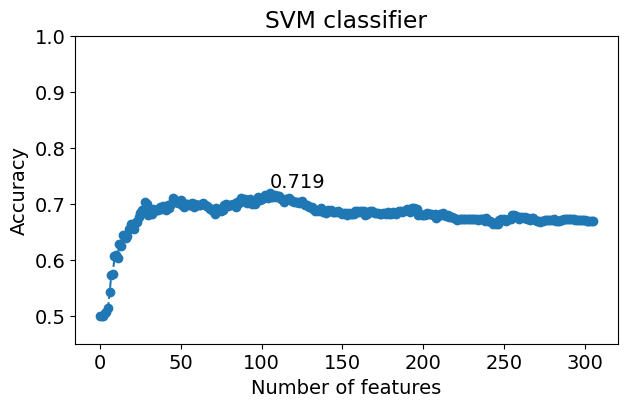

auc_best = 0.71854968
best auc (SVM) =  0.7185496794871795 Number of features =  105
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:05<18:11,  5.48s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:10<18:06,  5.48s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

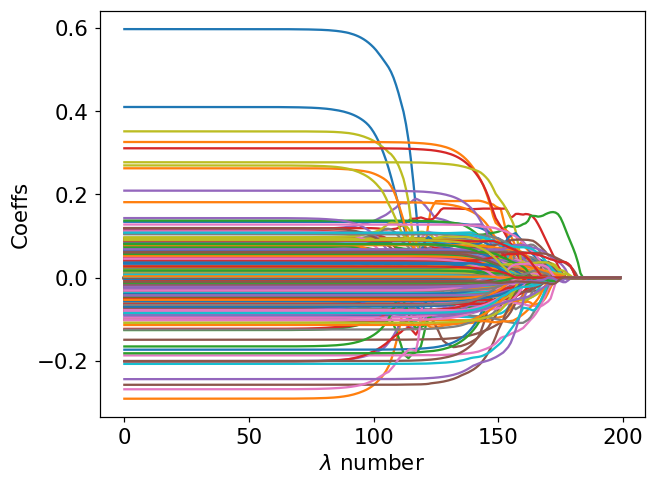

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/306 [00:09<46:03,  9.06s/it]

Iter =  1  UAR = 0.5000
UAR = 0.500


  1%|          | 2/306 [00:18<46:40,  9.21s/it]

UAR = 0.500


  1%|          | 3/306 [00:28<47:31,  9.41s/it]

UAR = 0.500


  1%|▏         | 4/306 [00:37<48:09,  9.57s/it]

UAR = 0.500


  2%|▏         | 5/306 [00:48<50:21, 10.04s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.506


  2%|▏         | 6/306 [00:59<51:41, 10.34s/it]

UAR = 0.513
Iter =  6  UAR = 0.5132
UAR = 0.500
UAR = 0.501
UAR = 0.511
UAR = 0.541


  2%|▏         | 7/306 [01:10<52:18, 10.50s/it]

UAR = 0.545
Iter =  7  UAR = 0.5447
UAR = 0.500
UAR = 0.504
UAR = 0.514
UAR = 0.540


  3%|▎         | 8/306 [01:21<52:50, 10.64s/it]

UAR = 0.542
UAR = 0.553
Iter =  8  UAR = 0.5535
UAR = 0.500
UAR = 0.507
UAR = 0.526
UAR = 0.535
UAR = 0.549


  3%|▎         | 9/306 [01:32<53:17, 10.77s/it]

UAR = 0.555
UAR = 0.573
Iter =  9  UAR = 0.5727
UAR = 0.500
UAR = 0.505
UAR = 0.510
UAR = 0.525
UAR = 0.533
UAR = 0.557


  3%|▎         | 10/306 [01:43<53:53, 10.93s/it]

UAR = 0.559
UAR = 0.578
Iter =  10  UAR = 0.5779
UAR = 0.500
UAR = 0.517
UAR = 0.553
UAR = 0.568
UAR = 0.580
UAR = 0.594


  4%|▎         | 11/306 [01:55<54:20, 11.05s/it]

Iter =  11  UAR = 0.5944
UAR = 0.500
UAR = 0.503
UAR = 0.522
UAR = 0.560
UAR = 0.577
UAR = 0.578
UAR = 0.600


  4%|▍         | 12/306 [02:06<54:45, 11.18s/it]

Iter =  12  UAR = 0.5996
UAR = 0.500
UAR = 0.503
UAR = 0.530
UAR = 0.571
UAR = 0.584
UAR = 0.586
UAR = 0.601
UAR = 0.605


  4%|▍         | 13/306 [02:18<55:20, 11.33s/it]

Iter =  13  UAR = 0.6052
UAR = 0.500
UAR = 0.526
UAR = 0.577
UAR = 0.592
UAR = 0.603
UAR = 0.604
UAR = 0.615
UAR = 0.624


  5%|▍         | 14/306 [02:29<55:37, 11.43s/it]

UAR = 0.629
UAR = 0.631
Iter =  14  UAR = 0.6308
UAR = 0.500
UAR = 0.532
UAR = 0.578
UAR = 0.602
UAR = 0.612
UAR = 0.616
UAR = 0.631


  5%|▍         | 15/306 [02:41<56:04, 11.56s/it]

UAR = 0.644
Iter =  15  UAR = 0.6444
UAR = 0.500
UAR = 0.532
UAR = 0.585
UAR = 0.591
UAR = 0.607
UAR = 0.609
UAR = 0.617
UAR = 0.626
UAR = 0.637


  5%|▌         | 16/306 [02:53<55:30, 11.48s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.571
UAR = 0.589
UAR = 0.611
UAR = 0.616
UAR = 0.628
UAR = 0.629
UAR = 0.650


  6%|▌         | 17/306 [03:04<55:16, 11.47s/it]

Iter =  17  UAR = 0.6500
UAR = 0.500
UAR = 0.508
UAR = 0.573
UAR = 0.597
UAR = 0.609
UAR = 0.623
UAR = 0.633
UAR = 0.633
UAR = 0.639
UAR = 0.640
UAR = 0.642


  6%|▌         | 18/306 [03:16<55:19, 11.53s/it]

UAR = 0.651
Iter =  18  UAR = 0.6506
UAR = 0.500
UAR = 0.529
UAR = 0.597
UAR = 0.611
UAR = 0.619
UAR = 0.623
UAR = 0.636
UAR = 0.643
UAR = 0.652


  6%|▌         | 19/306 [03:27<55:32, 11.61s/it]

UAR = 0.656
UAR = 0.666
Iter =  19  UAR = 0.6663
UAR = 0.500
UAR = 0.536
UAR = 0.605
UAR = 0.613
UAR = 0.619
UAR = 0.627
UAR = 0.646
UAR = 0.653


  7%|▋         | 20/306 [03:39<55:56, 11.74s/it]

UAR = 0.657
UAR = 0.666
Iter =  20  UAR = 0.6665
UAR = 0.500
UAR = 0.503
UAR = 0.551
UAR = 0.599
UAR = 0.609
UAR = 0.622
UAR = 0.637
UAR = 0.653
UAR = 0.660


  7%|▋         | 21/306 [03:52<56:25, 11.88s/it]

UAR = 0.671
Iter =  21  UAR = 0.6707
UAR = 0.500
UAR = 0.503
UAR = 0.551
UAR = 0.602
UAR = 0.610
UAR = 0.620
UAR = 0.640
UAR = 0.648
UAR = 0.652
UAR = 0.663


  7%|▋         | 22/306 [04:04<56:57, 12.03s/it]

UAR = 0.669
UAR = 0.500
UAR = 0.508
UAR = 0.564
UAR = 0.608
UAR = 0.615
UAR = 0.637
UAR = 0.642
UAR = 0.655
UAR = 0.666
UAR = 0.679


  8%|▊         | 23/306 [04:17<57:29, 12.19s/it]

Iter =  23  UAR = 0.6789
UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.590
UAR = 0.614
UAR = 0.632
UAR = 0.647
UAR = 0.655
UAR = 0.666
UAR = 0.679
UAR = 0.683


  8%|▊         | 24/306 [04:29<57:43, 12.28s/it]

UAR = 0.687
UAR = 0.692
Iter =  24  UAR = 0.6921
UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.593
UAR = 0.617
UAR = 0.632
UAR = 0.632
UAR = 0.638
UAR = 0.658
UAR = 0.666
UAR = 0.683


  8%|▊         | 25/306 [04:42<58:04, 12.40s/it]

UAR = 0.689
UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.599
UAR = 0.629
UAR = 0.631
UAR = 0.646
UAR = 0.657
UAR = 0.667
UAR = 0.686
UAR = 0.688
UAR = 0.693
UAR = 0.696


  8%|▊         | 26/306 [04:55<58:25, 12.52s/it]

UAR = 0.697
Iter =  26  UAR = 0.6969
UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.594
UAR = 0.629
UAR = 0.637
UAR = 0.654
UAR = 0.657
UAR = 0.680
UAR = 0.688
UAR = 0.692
UAR = 0.714


  9%|▉         | 27/306 [05:08<58:49, 12.65s/it]

UAR = 0.716
UAR = 0.721
Iter =  27  UAR = 0.7206
UAR = 0.500
UAR = 0.503
UAR = 0.554
UAR = 0.613
UAR = 0.637
UAR = 0.661
UAR = 0.671
UAR = 0.677
UAR = 0.686
UAR = 0.688
UAR = 0.704
UAR = 0.712


  9%|▉         | 28/306 [05:21<59:25, 12.83s/it]

UAR = 0.724
UAR = 0.725
Iter =  28  UAR = 0.7250
UAR = 0.500
UAR = 0.503
UAR = 0.557
UAR = 0.624
UAR = 0.645
UAR = 0.658
UAR = 0.671
UAR = 0.686
UAR = 0.702
UAR = 0.703
UAR = 0.710
UAR = 0.711


  9%|▉         | 29/306 [05:34<59:58, 12.99s/it]

UAR = 0.719
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.568
UAR = 0.624
UAR = 0.639
UAR = 0.640
UAR = 0.658
UAR = 0.670
UAR = 0.681
UAR = 0.691
UAR = 0.701
UAR = 0.716
UAR = 0.722
UAR = 0.728


 10%|▉         | 30/306 [05:48<1:00:20, 13.12s/it]

Iter =  30  UAR = 0.7282
UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.583
UAR = 0.623
UAR = 0.638
UAR = 0.646
UAR = 0.656
UAR = 0.664
UAR = 0.689
UAR = 0.696
UAR = 0.702
UAR = 0.713
UAR = 0.736


 10%|█         | 31/306 [06:01<1:00:48, 13.27s/it]

UAR = 0.746
Iter =  31  UAR = 0.7462
UAR = 0.500
UAR = 0.505
UAR = 0.593
UAR = 0.630
UAR = 0.639
UAR = 0.647
UAR = 0.659
UAR = 0.669
UAR = 0.680
UAR = 0.704
UAR = 0.716
UAR = 0.734
UAR = 0.743
UAR = 0.757


 10%|█         | 32/306 [06:13<59:02, 12.93s/it]  

Iter =  32  UAR = 0.7574
UAR = 0.500
UAR = 0.510
UAR = 0.588
UAR = 0.629
UAR = 0.639
UAR = 0.642
UAR = 0.656
UAR = 0.668
UAR = 0.686
UAR = 0.702
UAR = 0.706
UAR = 0.731
UAR = 0.739
UAR = 0.742
UAR = 0.746


 11%|█         | 33/306 [06:26<58:01, 12.75s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.591
UAR = 0.631
UAR = 0.636
UAR = 0.644
UAR = 0.653
UAR = 0.668
UAR = 0.692
UAR = 0.702
UAR = 0.707
UAR = 0.728
UAR = 0.745
UAR = 0.747


 11%|█         | 34/306 [06:38<57:32, 12.69s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.589
UAR = 0.626
UAR = 0.636
UAR = 0.639
UAR = 0.643
UAR = 0.668
UAR = 0.693
UAR = 0.719
UAR = 0.738
UAR = 0.744
UAR = 0.748


 11%|█▏        | 35/306 [06:51<57:23, 12.71s/it]

UAR = 0.750
UAR = 0.500
UAR = 0.516
UAR = 0.599
UAR = 0.626
UAR = 0.636
UAR = 0.642
UAR = 0.677
UAR = 0.693
UAR = 0.709
UAR = 0.710
UAR = 0.719
UAR = 0.737
UAR = 0.743
UAR = 0.744


 12%|█▏        | 36/306 [07:04<57:28, 12.77s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.599
UAR = 0.625
UAR = 0.638
UAR = 0.648
UAR = 0.674
UAR = 0.690
UAR = 0.711
UAR = 0.727
UAR = 0.729
UAR = 0.741
UAR = 0.750


 12%|█▏        | 37/306 [07:17<57:41, 12.87s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.609
UAR = 0.630
UAR = 0.643
UAR = 0.653
UAR = 0.680
UAR = 0.693
UAR = 0.711
UAR = 0.723
UAR = 0.736
UAR = 0.738
UAR = 0.744


 12%|█▏        | 38/306 [07:30<58:02, 13.00s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.606
UAR = 0.631
UAR = 0.643
UAR = 0.653
UAR = 0.678
UAR = 0.700
UAR = 0.711
UAR = 0.724
UAR = 0.734
UAR = 0.739
UAR = 0.748


 13%|█▎        | 39/306 [07:44<58:29, 13.14s/it]

UAR = 0.500
UAR = 0.529
UAR = 0.603
UAR = 0.630
UAR = 0.643
UAR = 0.652
UAR = 0.681
UAR = 0.703
UAR = 0.718
UAR = 0.719
UAR = 0.736
UAR = 0.742


 13%|█▎        | 40/306 [07:57<58:41, 13.24s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.603
UAR = 0.633
UAR = 0.645
UAR = 0.651
UAR = 0.682
UAR = 0.702
UAR = 0.721
UAR = 0.740
UAR = 0.757


 13%|█▎        | 41/306 [08:11<59:02, 13.37s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.605
UAR = 0.630
UAR = 0.646
UAR = 0.657
UAR = 0.688
UAR = 0.709
UAR = 0.720
UAR = 0.738
UAR = 0.758
UAR = 0.759


 14%|█▎        | 42/306 [08:25<59:28, 13.52s/it]

Iter =  42  UAR = 0.7594
UAR = 0.500
UAR = 0.503
UAR = 0.539
UAR = 0.613
UAR = 0.635
UAR = 0.648
UAR = 0.657
UAR = 0.689
UAR = 0.711
UAR = 0.724
UAR = 0.735
UAR = 0.758
UAR = 0.763


 14%|█▍        | 43/306 [08:39<59:57, 13.68s/it]

Iter =  43  UAR = 0.7626
UAR = 0.500
UAR = 0.503
UAR = 0.544
UAR = 0.621
UAR = 0.646
UAR = 0.649
UAR = 0.672
UAR = 0.686
UAR = 0.725
UAR = 0.737
UAR = 0.738
UAR = 0.766


 14%|█▍        | 44/306 [08:53<1:00:24, 13.83s/it]

Iter =  44  UAR = 0.7658
UAR = 0.500
UAR = 0.503
UAR = 0.547
UAR = 0.623
UAR = 0.646
UAR = 0.649
UAR = 0.673
UAR = 0.686
UAR = 0.730
UAR = 0.735
UAR = 0.744
UAR = 0.766


 15%|█▍        | 45/306 [09:07<1:00:55, 14.00s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.547
UAR = 0.615
UAR = 0.643
UAR = 0.646
UAR = 0.648
UAR = 0.672
UAR = 0.691
UAR = 0.724
UAR = 0.730
UAR = 0.748
UAR = 0.763


 15%|█▌        | 46/306 [09:22<1:01:27, 14.18s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.615
UAR = 0.646
UAR = 0.653
UAR = 0.672
UAR = 0.696
UAR = 0.737
UAR = 0.738
UAR = 0.758
UAR = 0.760


 15%|█▌        | 47/306 [09:37<1:02:02, 14.37s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.568
UAR = 0.623
UAR = 0.651
UAR = 0.653
UAR = 0.675
UAR = 0.712
UAR = 0.732
UAR = 0.741
UAR = 0.743
UAR = 0.756
UAR = 0.774


 16%|█▌        | 48/306 [09:50<1:00:26, 14.06s/it]

Iter =  48  UAR = 0.7740
UAR = 0.500
UAR = 0.565
UAR = 0.618
UAR = 0.649
UAR = 0.658
UAR = 0.688
UAR = 0.720
UAR = 0.737
UAR = 0.743
UAR = 0.747
UAR = 0.773
UAR = 0.775
UAR = 0.779


 16%|█▌        | 49/306 [10:04<59:34, 13.91s/it]  

Iter =  49  UAR = 0.7788
UAR = 0.500
UAR = 0.503
UAR = 0.568
UAR = 0.616
UAR = 0.649
UAR = 0.659
UAR = 0.689
UAR = 0.717
UAR = 0.738
UAR = 0.747
UAR = 0.768
UAR = 0.770
UAR = 0.776


 16%|█▋        | 50/306 [10:17<59:09, 13.86s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.568
UAR = 0.621
UAR = 0.646
UAR = 0.664
UAR = 0.691
UAR = 0.719
UAR = 0.735
UAR = 0.744
UAR = 0.752
UAR = 0.768
UAR = 0.772


 17%|█▋        | 51/306 [10:31<59:06, 13.91s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.570
UAR = 0.618
UAR = 0.643
UAR = 0.661
UAR = 0.691
UAR = 0.722
UAR = 0.732
UAR = 0.749
UAR = 0.754
UAR = 0.772


 17%|█▋        | 52/306 [10:46<59:15, 14.00s/it]

UAR = 0.500
UAR = 0.573
UAR = 0.623
UAR = 0.643
UAR = 0.661
UAR = 0.700
UAR = 0.725
UAR = 0.743
UAR = 0.749
UAR = 0.761
UAR = 0.768
UAR = 0.781


 17%|█▋        | 53/306 [11:00<59:37, 14.14s/it]

Iter =  53  UAR = 0.7806
UAR = 0.500
UAR = 0.568
UAR = 0.618
UAR = 0.644
UAR = 0.672
UAR = 0.697
UAR = 0.740
UAR = 0.742
UAR = 0.757
UAR = 0.766
UAR = 0.766
UAR = 0.779


 18%|█▊        | 54/306 [11:15<1:00:06, 14.31s/it]

UAR = 0.500
UAR = 0.570
UAR = 0.623
UAR = 0.652
UAR = 0.672
UAR = 0.702
UAR = 0.737
UAR = 0.742
UAR = 0.752
UAR = 0.755
UAR = 0.756
UAR = 0.767
UAR = 0.769
UAR = 0.781


 18%|█▊        | 55/306 [11:30<1:00:39, 14.50s/it]

Iter =  55  UAR = 0.7815
UAR = 0.500
UAR = 0.570
UAR = 0.623
UAR = 0.649
UAR = 0.666
UAR = 0.697
UAR = 0.737
UAR = 0.743
UAR = 0.747
UAR = 0.751
UAR = 0.766
UAR = 0.770
UAR = 0.772


 18%|█▊        | 56/306 [11:45<1:01:02, 14.65s/it]

UAR = 0.500
UAR = 0.562
UAR = 0.626
UAR = 0.649
UAR = 0.666
UAR = 0.702
UAR = 0.743
UAR = 0.745
UAR = 0.749
UAR = 0.760
UAR = 0.774
UAR = 0.776
UAR = 0.785


 19%|█▊        | 57/306 [12:00<1:01:31, 14.83s/it]

Iter =  57  UAR = 0.7847
UAR = 0.500
UAR = 0.503
UAR = 0.578
UAR = 0.626
UAR = 0.643
UAR = 0.664
UAR = 0.697
UAR = 0.744
UAR = 0.748
UAR = 0.749
UAR = 0.765
UAR = 0.769
UAR = 0.780
UAR = 0.787


 19%|█▉        | 58/306 [12:16<1:02:03, 15.01s/it]

Iter =  58  UAR = 0.7873
UAR = 0.500
UAR = 0.573
UAR = 0.629
UAR = 0.641
UAR = 0.666
UAR = 0.693
UAR = 0.746
UAR = 0.751
UAR = 0.754
UAR = 0.765
UAR = 0.774
UAR = 0.778
UAR = 0.790


 19%|█▉        | 59/306 [12:31<1:02:36, 15.21s/it]

Iter =  59  UAR = 0.7903
UAR = 0.500
UAR = 0.573
UAR = 0.629
UAR = 0.648
UAR = 0.673
UAR = 0.696
UAR = 0.738
UAR = 0.745
UAR = 0.753
UAR = 0.767
UAR = 0.776
UAR = 0.784
UAR = 0.786


 20%|█▉        | 60/306 [12:47<1:03:14, 15.42s/it]

UAR = 0.500
UAR = 0.581
UAR = 0.631
UAR = 0.648
UAR = 0.681
UAR = 0.707
UAR = 0.735
UAR = 0.747
UAR = 0.761
UAR = 0.775
UAR = 0.781
UAR = 0.789


 20%|█▉        | 61/306 [13:03<1:03:56, 15.66s/it]

UAR = 0.500
UAR = 0.576
UAR = 0.637
UAR = 0.643
UAR = 0.673
UAR = 0.711
UAR = 0.740
UAR = 0.749
UAR = 0.759
UAR = 0.767
UAR = 0.771
UAR = 0.774
UAR = 0.788
UAR = 0.792


 20%|██        | 62/306 [13:20<1:04:36, 15.89s/it]

Iter =  62  UAR = 0.7921
UAR = 0.500
UAR = 0.576
UAR = 0.629
UAR = 0.643
UAR = 0.673
UAR = 0.717
UAR = 0.735
UAR = 0.747
UAR = 0.748
UAR = 0.765
UAR = 0.769
UAR = 0.778
UAR = 0.786
UAR = 0.797


 21%|██        | 63/306 [13:36<1:05:19, 16.13s/it]

Iter =  63  UAR = 0.7973
UAR = 0.500
UAR = 0.576
UAR = 0.629
UAR = 0.641
UAR = 0.671
UAR = 0.717
UAR = 0.738
UAR = 0.745
UAR = 0.751
UAR = 0.767
UAR = 0.777
UAR = 0.778
UAR = 0.789
UAR = 0.797


 21%|██        | 64/306 [13:51<1:03:29, 15.74s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.583
UAR = 0.629
UAR = 0.630
UAR = 0.676
UAR = 0.717
UAR = 0.741
UAR = 0.748
UAR = 0.771
UAR = 0.775
UAR = 0.787


 21%|██        | 65/306 [14:06<1:02:13, 15.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.591
UAR = 0.633
UAR = 0.636
UAR = 0.679
UAR = 0.715
UAR = 0.740
UAR = 0.750
UAR = 0.757
UAR = 0.772
UAR = 0.778
UAR = 0.788


 22%|██▏       | 66/306 [14:21<1:01:34, 15.39s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.589
UAR = 0.636
UAR = 0.680
UAR = 0.715
UAR = 0.740
UAR = 0.750
UAR = 0.762
UAR = 0.775
UAR = 0.783
UAR = 0.788
UAR = 0.789


 22%|██▏       | 67/306 [14:37<1:01:20, 15.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.586
UAR = 0.634
UAR = 0.682
UAR = 0.715
UAR = 0.739
UAR = 0.745
UAR = 0.749
UAR = 0.767
UAR = 0.774
UAR = 0.790
UAR = 0.790


 22%|██▏       | 68/306 [14:52<1:01:26, 15.49s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.583
UAR = 0.629
UAR = 0.682
UAR = 0.720
UAR = 0.741
UAR = 0.748
UAR = 0.751
UAR = 0.765
UAR = 0.772
UAR = 0.772
UAR = 0.780
UAR = 0.788


 23%|██▎       | 69/306 [15:08<1:01:49, 15.65s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.589
UAR = 0.632
UAR = 0.680
UAR = 0.717
UAR = 0.741
UAR = 0.746
UAR = 0.749
UAR = 0.766
UAR = 0.775
UAR = 0.783


 23%|██▎       | 70/306 [15:25<1:02:30, 15.89s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.591
UAR = 0.629
UAR = 0.685
UAR = 0.711
UAR = 0.741
UAR = 0.746
UAR = 0.749
UAR = 0.760
UAR = 0.769
UAR = 0.787


 23%|██▎       | 71/306 [15:42<1:03:14, 16.15s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.586
UAR = 0.624
UAR = 0.625
UAR = 0.688
UAR = 0.717
UAR = 0.744
UAR = 0.746
UAR = 0.767
UAR = 0.777
UAR = 0.782
UAR = 0.786


 24%|██▎       | 72/306 [15:58<1:03:44, 16.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.589
UAR = 0.622
UAR = 0.688
UAR = 0.722
UAR = 0.736
UAR = 0.742
UAR = 0.751
UAR = 0.765
UAR = 0.782
UAR = 0.784
UAR = 0.786


 24%|██▍       | 73/306 [16:16<1:04:21, 16.57s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.581
UAR = 0.622
UAR = 0.625
UAR = 0.688
UAR = 0.722
UAR = 0.741
UAR = 0.748
UAR = 0.764
UAR = 0.784
UAR = 0.788


 24%|██▍       | 74/306 [16:33<1:05:09, 16.85s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.586
UAR = 0.619
UAR = 0.622
UAR = 0.685
UAR = 0.722
UAR = 0.739
UAR = 0.748
UAR = 0.765
UAR = 0.782
UAR = 0.786


 25%|██▍       | 75/306 [16:51<1:05:53, 17.11s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.591
UAR = 0.622
UAR = 0.627
UAR = 0.688
UAR = 0.719
UAR = 0.744
UAR = 0.750
UAR = 0.761
UAR = 0.778
UAR = 0.783


 25%|██▍       | 76/306 [17:09<1:06:36, 17.38s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.591
UAR = 0.622
UAR = 0.684
UAR = 0.720
UAR = 0.734
UAR = 0.739
UAR = 0.747
UAR = 0.760
UAR = 0.776
UAR = 0.781


 25%|██▌       | 77/306 [17:27<1:07:18, 17.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.591
UAR = 0.617
UAR = 0.622
UAR = 0.681
UAR = 0.728
UAR = 0.734
UAR = 0.738
UAR = 0.739
UAR = 0.747
UAR = 0.758
UAR = 0.776
UAR = 0.777


 25%|██▌       | 78/306 [17:46<1:07:58, 17.89s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.591
UAR = 0.617
UAR = 0.624
UAR = 0.681
UAR = 0.728
UAR = 0.736
UAR = 0.736
UAR = 0.747
UAR = 0.761
UAR = 0.777


 26%|██▌       | 79/306 [18:04<1:08:44, 18.17s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.586
UAR = 0.614
UAR = 0.624
UAR = 0.678
UAR = 0.725
UAR = 0.737
UAR = 0.737
UAR = 0.747
UAR = 0.758
UAR = 0.779


 26%|██▌       | 80/306 [18:21<1:06:16, 17.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.586
UAR = 0.617
UAR = 0.627
UAR = 0.678
UAR = 0.723
UAR = 0.732
UAR = 0.741
UAR = 0.749
UAR = 0.764
UAR = 0.776


 26%|██▋       | 81/306 [18:37<1:04:42, 17.26s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.619
UAR = 0.627
UAR = 0.681
UAR = 0.723
UAR = 0.741
UAR = 0.753
UAR = 0.762
UAR = 0.771
UAR = 0.772
UAR = 0.773


 27%|██▋       | 82/306 [18:54<1:03:50, 17.10s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.586
UAR = 0.617
UAR = 0.632
UAR = 0.683
UAR = 0.720
UAR = 0.738
UAR = 0.739
UAR = 0.755
UAR = 0.765
UAR = 0.769
UAR = 0.779


 27%|██▋       | 83/306 [19:11<1:03:22, 17.05s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.617
UAR = 0.632
UAR = 0.689
UAR = 0.727
UAR = 0.742
UAR = 0.749
UAR = 0.771
UAR = 0.772
UAR = 0.778
UAR = 0.784


 27%|██▋       | 84/306 [19:28<1:03:26, 17.15s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.619
UAR = 0.632
UAR = 0.686
UAR = 0.730
UAR = 0.740
UAR = 0.754
UAR = 0.772
UAR = 0.778
UAR = 0.781


 28%|██▊       | 85/306 [19:46<1:03:53, 17.35s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.612
UAR = 0.635
UAR = 0.688
UAR = 0.732
UAR = 0.745
UAR = 0.759
UAR = 0.772
UAR = 0.785


 28%|██▊       | 86/306 [20:04<1:04:25, 17.57s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.612
UAR = 0.635
UAR = 0.691
UAR = 0.732
UAR = 0.745
UAR = 0.761
UAR = 0.770
UAR = 0.786


 28%|██▊       | 87/306 [20:22<1:05:01, 17.81s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.609
UAR = 0.632
UAR = 0.691
UAR = 0.732
UAR = 0.735
UAR = 0.737
UAR = 0.757
UAR = 0.767
UAR = 0.788


 29%|██▉       | 88/306 [20:41<1:05:28, 18.02s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.612
UAR = 0.634
UAR = 0.690
UAR = 0.733
UAR = 0.738
UAR = 0.757
UAR = 0.767
UAR = 0.778
UAR = 0.778


 29%|██▉       | 89/306 [21:00<1:05:56, 18.23s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.589
UAR = 0.609
UAR = 0.632
UAR = 0.690
UAR = 0.730
UAR = 0.737
UAR = 0.742
UAR = 0.762
UAR = 0.769
UAR = 0.781


 29%|██▉       | 90/306 [21:19<1:06:33, 18.49s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.589
UAR = 0.612
UAR = 0.635
UAR = 0.700
UAR = 0.730
UAR = 0.740
UAR = 0.744
UAR = 0.757
UAR = 0.768
UAR = 0.774


 30%|██▉       | 91/306 [21:38<1:07:03, 18.71s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.581
UAR = 0.614
UAR = 0.635
UAR = 0.690
UAR = 0.727
UAR = 0.732
UAR = 0.739
UAR = 0.753
UAR = 0.763
UAR = 0.771
UAR = 0.774


 30%|███       | 92/306 [21:57<1:07:34, 18.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.589
UAR = 0.609
UAR = 0.629
UAR = 0.690
UAR = 0.727
UAR = 0.733
UAR = 0.735
UAR = 0.754
UAR = 0.761
UAR = 0.771
UAR = 0.777


 30%|███       | 93/306 [22:17<1:08:08, 19.19s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.589
UAR = 0.612
UAR = 0.635
UAR = 0.696
UAR = 0.727
UAR = 0.730
UAR = 0.737
UAR = 0.749
UAR = 0.760
UAR = 0.779
UAR = 0.782


 31%|███       | 94/306 [22:37<1:08:48, 19.47s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.591
UAR = 0.614
UAR = 0.629
UAR = 0.693
UAR = 0.727
UAR = 0.733
UAR = 0.735
UAR = 0.752
UAR = 0.763
UAR = 0.774
UAR = 0.780


 31%|███       | 95/306 [22:58<1:09:30, 19.76s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.591
UAR = 0.614
UAR = 0.632
UAR = 0.685
UAR = 0.719
UAR = 0.728
UAR = 0.732
UAR = 0.750
UAR = 0.765
UAR = 0.772
UAR = 0.777


 31%|███▏      | 96/306 [23:16<1:07:12, 19.20s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.581
UAR = 0.612
UAR = 0.637
UAR = 0.685
UAR = 0.717
UAR = 0.736
UAR = 0.754
UAR = 0.758
UAR = 0.777


 32%|███▏      | 97/306 [23:34<1:05:50, 18.90s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.606
UAR = 0.635
UAR = 0.679
UAR = 0.721
UAR = 0.736
UAR = 0.738
UAR = 0.753
UAR = 0.768
UAR = 0.779


 32%|███▏      | 98/306 [23:52<1:05:04, 18.77s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.586
UAR = 0.609
UAR = 0.640
UAR = 0.684
UAR = 0.725
UAR = 0.736
UAR = 0.741
UAR = 0.759
UAR = 0.763
UAR = 0.782


 32%|███▏      | 99/306 [24:11<1:04:52, 18.80s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.586
UAR = 0.612
UAR = 0.642
UAR = 0.687
UAR = 0.725
UAR = 0.734
UAR = 0.741
UAR = 0.756
UAR = 0.763
UAR = 0.782


 33%|███▎      | 100/306 [24:30<1:04:57, 18.92s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.581
UAR = 0.606
UAR = 0.642
UAR = 0.685
UAR = 0.727
UAR = 0.734
UAR = 0.741
UAR = 0.759
UAR = 0.765
UAR = 0.781


 33%|███▎      | 101/306 [24:50<1:05:10, 19.07s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.606
UAR = 0.642
UAR = 0.690
UAR = 0.727
UAR = 0.742
UAR = 0.746
UAR = 0.758
UAR = 0.765
UAR = 0.782


 33%|███▎      | 102/306 [25:10<1:05:33, 19.28s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.581
UAR = 0.606
UAR = 0.642
UAR = 0.687
UAR = 0.725
UAR = 0.742
UAR = 0.747
UAR = 0.755
UAR = 0.765
UAR = 0.782


 34%|███▎      | 103/306 [25:30<1:06:09, 19.55s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.606
UAR = 0.642
UAR = 0.684
UAR = 0.730
UAR = 0.742
UAR = 0.744
UAR = 0.759
UAR = 0.764
UAR = 0.779


 34%|███▍      | 104/306 [25:50<1:06:28, 19.74s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.581
UAR = 0.604
UAR = 0.637
UAR = 0.682
UAR = 0.723
UAR = 0.741
UAR = 0.742
UAR = 0.753
UAR = 0.767
UAR = 0.782


 34%|███▍      | 105/306 [26:11<1:06:59, 20.00s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.578
UAR = 0.606
UAR = 0.640
UAR = 0.683
UAR = 0.728
UAR = 0.741
UAR = 0.755
UAR = 0.765
UAR = 0.785


 35%|███▍      | 106/306 [26:31<1:07:33, 20.27s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.576
UAR = 0.601
UAR = 0.637
UAR = 0.683
UAR = 0.733
UAR = 0.736
UAR = 0.736
UAR = 0.752
UAR = 0.759
UAR = 0.769


 35%|███▍      | 107/306 [26:53<1:08:22, 20.62s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.573
UAR = 0.601
UAR = 0.640
UAR = 0.683
UAR = 0.730
UAR = 0.731
UAR = 0.739
UAR = 0.757
UAR = 0.765
UAR = 0.769


 35%|███▌      | 108/306 [27:15<1:09:09, 20.96s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.581
UAR = 0.601
UAR = 0.637
UAR = 0.683
UAR = 0.730
UAR = 0.731
UAR = 0.741
UAR = 0.755
UAR = 0.765
UAR = 0.774


 36%|███▌      | 109/306 [27:37<1:09:52, 21.28s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.589
UAR = 0.604
UAR = 0.634
UAR = 0.682
UAR = 0.730
UAR = 0.734
UAR = 0.737
UAR = 0.753
UAR = 0.766
UAR = 0.775
UAR = 0.776


 36%|███▌      | 110/306 [27:59<1:10:25, 21.56s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.591
UAR = 0.601
UAR = 0.637
UAR = 0.687
UAR = 0.730
UAR = 0.734
UAR = 0.758
UAR = 0.761
UAR = 0.765
UAR = 0.773
UAR = 0.778


 36%|███▋      | 111/306 [28:21<1:11:02, 21.86s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.601
UAR = 0.637
UAR = 0.685
UAR = 0.728
UAR = 0.731
UAR = 0.734
UAR = 0.758
UAR = 0.764
UAR = 0.765
UAR = 0.771
UAR = 0.775


 37%|███▋      | 112/306 [28:41<1:08:38, 21.23s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.586
UAR = 0.599
UAR = 0.637
UAR = 0.693
UAR = 0.730
UAR = 0.734
UAR = 0.754
UAR = 0.770
UAR = 0.773
UAR = 0.774


 37%|███▋      | 113/306 [29:01<1:07:10, 20.88s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.596
UAR = 0.642
UAR = 0.693
UAR = 0.727
UAR = 0.729
UAR = 0.736
UAR = 0.752
UAR = 0.765
UAR = 0.768
UAR = 0.777


 37%|███▋      | 114/306 [29:22<1:06:27, 20.77s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.583
UAR = 0.593
UAR = 0.642
UAR = 0.692
UAR = 0.727
UAR = 0.728
UAR = 0.739
UAR = 0.759
UAR = 0.765
UAR = 0.772
UAR = 0.776


 38%|███▊      | 115/306 [29:43<1:06:25, 20.87s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.583
UAR = 0.593
UAR = 0.639
UAR = 0.692
UAR = 0.727
UAR = 0.732
UAR = 0.732
UAR = 0.754
UAR = 0.759
UAR = 0.769
UAR = 0.779


 38%|███▊      | 116/306 [30:05<1:06:47, 21.09s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.583
UAR = 0.593
UAR = 0.645
UAR = 0.692
UAR = 0.730
UAR = 0.732
UAR = 0.735
UAR = 0.757
UAR = 0.765
UAR = 0.766
UAR = 0.780


 38%|███▊      | 117/306 [30:26<1:07:16, 21.36s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.583
UAR = 0.596
UAR = 0.643
UAR = 0.695
UAR = 0.730
UAR = 0.734
UAR = 0.763
UAR = 0.768
UAR = 0.777
UAR = 0.781


 39%|███▊      | 118/306 [30:49<1:07:41, 21.60s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.593
UAR = 0.645
UAR = 0.695
UAR = 0.727
UAR = 0.731
UAR = 0.760
UAR = 0.768
UAR = 0.777
UAR = 0.781


 39%|███▉      | 119/306 [31:11<1:08:10, 21.87s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.593
UAR = 0.648
UAR = 0.695
UAR = 0.727
UAR = 0.731
UAR = 0.732
UAR = 0.763
UAR = 0.765
UAR = 0.774
UAR = 0.779


 39%|███▉      | 120/306 [31:34<1:08:25, 22.08s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.593
UAR = 0.648
UAR = 0.695
UAR = 0.727
UAR = 0.737
UAR = 0.762
UAR = 0.765
UAR = 0.773
UAR = 0.776


 40%|███▉      | 121/306 [31:57<1:08:48, 22.32s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.593
UAR = 0.645
UAR = 0.698
UAR = 0.733
UAR = 0.739
UAR = 0.764
UAR = 0.771
UAR = 0.773


 40%|███▉      | 122/306 [32:20<1:09:16, 22.59s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.593
UAR = 0.650
UAR = 0.697
UAR = 0.735
UAR = 0.739
UAR = 0.764
UAR = 0.765
UAR = 0.771


 40%|████      | 123/306 [32:43<1:09:42, 22.86s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.593
UAR = 0.650
UAR = 0.697
UAR = 0.730
UAR = 0.739
UAR = 0.764
UAR = 0.768


 41%|████      | 124/306 [33:07<1:10:11, 23.14s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.593
UAR = 0.648
UAR = 0.697
UAR = 0.735
UAR = 0.739
UAR = 0.759
UAR = 0.764
UAR = 0.773


 41%|████      | 125/306 [33:31<1:10:39, 23.42s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.593
UAR = 0.645
UAR = 0.697
UAR = 0.730
UAR = 0.737
UAR = 0.759
UAR = 0.767
UAR = 0.771


 41%|████      | 126/306 [33:56<1:11:09, 23.72s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.586
UAR = 0.593
UAR = 0.645
UAR = 0.695
UAR = 0.724
UAR = 0.734
UAR = 0.764
UAR = 0.769


 42%|████▏     | 127/306 [34:20<1:11:40, 24.03s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.586
UAR = 0.593
UAR = 0.648
UAR = 0.695
UAR = 0.724
UAR = 0.727
UAR = 0.745
UAR = 0.769
UAR = 0.772


 42%|████▏     | 128/306 [34:42<1:09:21, 23.38s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.583
UAR = 0.593
UAR = 0.647
UAR = 0.695
UAR = 0.727
UAR = 0.743
UAR = 0.766
UAR = 0.772


 42%|████▏     | 129/306 [35:04<1:07:45, 22.97s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.591
UAR = 0.645
UAR = 0.695
UAR = 0.727
UAR = 0.742
UAR = 0.769
UAR = 0.774


 42%|████▏     | 130/306 [35:27<1:06:47, 22.77s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.588
UAR = 0.642
UAR = 0.697
UAR = 0.730
UAR = 0.745
UAR = 0.767
UAR = 0.771


 43%|████▎     | 131/306 [35:49<1:06:22, 22.75s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.588
UAR = 0.642
UAR = 0.697
UAR = 0.727
UAR = 0.745
UAR = 0.768
UAR = 0.769


 43%|████▎     | 132/306 [36:12<1:06:14, 22.84s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.588
UAR = 0.642
UAR = 0.700
UAR = 0.727
UAR = 0.748
UAR = 0.770


 43%|████▎     | 133/306 [36:36<1:06:23, 23.03s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.583
UAR = 0.588
UAR = 0.642
UAR = 0.700
UAR = 0.725
UAR = 0.750
UAR = 0.761
UAR = 0.766
UAR = 0.768
UAR = 0.769


 44%|████▍     | 134/306 [37:00<1:06:39, 23.25s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.580
UAR = 0.588
UAR = 0.642
UAR = 0.700
UAR = 0.722
UAR = 0.748
UAR = 0.761
UAR = 0.764
UAR = 0.766
UAR = 0.769


 44%|████▍     | 135/306 [37:24<1:07:01, 23.52s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.580
UAR = 0.588
UAR = 0.645
UAR = 0.697
UAR = 0.725
UAR = 0.748
UAR = 0.768
UAR = 0.769


 44%|████▍     | 136/306 [37:48<1:07:17, 23.75s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.580
UAR = 0.586
UAR = 0.642
UAR = 0.697
UAR = 0.722
UAR = 0.750
UAR = 0.766
UAR = 0.769


 45%|████▍     | 137/306 [38:13<1:07:41, 24.03s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.588
UAR = 0.642
UAR = 0.700
UAR = 0.725
UAR = 0.751
UAR = 0.763
UAR = 0.769


 45%|████▌     | 138/306 [38:38<1:08:03, 24.31s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.580
UAR = 0.586
UAR = 0.642
UAR = 0.702
UAR = 0.728
UAR = 0.750
UAR = 0.765
UAR = 0.768
UAR = 0.771
UAR = 0.773


 45%|████▌     | 139/306 [39:03<1:08:30, 24.61s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.588
UAR = 0.639
UAR = 0.702
UAR = 0.725
UAR = 0.750
UAR = 0.766
UAR = 0.768
UAR = 0.772


 46%|████▌     | 140/306 [39:28<1:08:48, 24.87s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.588
UAR = 0.642
UAR = 0.702
UAR = 0.723
UAR = 0.751
UAR = 0.766
UAR = 0.768
UAR = 0.770


 46%|████▌     | 141/306 [39:54<1:09:13, 25.17s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.586
UAR = 0.588
UAR = 0.642
UAR = 0.705
UAR = 0.723
UAR = 0.751
UAR = 0.774


 46%|████▋     | 142/306 [40:20<1:09:38, 25.48s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.583
UAR = 0.645
UAR = 0.702
UAR = 0.722
UAR = 0.723
UAR = 0.752
UAR = 0.771
UAR = 0.773


 47%|████▋     | 143/306 [40:47<1:10:06, 25.81s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.645
UAR = 0.702
UAR = 0.724
UAR = 0.747
UAR = 0.770
UAR = 0.771


 47%|████▋     | 144/306 [41:10<1:07:39, 25.06s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.645
UAR = 0.703
UAR = 0.725
UAR = 0.749
UAR = 0.770
UAR = 0.773


 47%|████▋     | 145/306 [41:34<1:06:18, 24.71s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.645
UAR = 0.700
UAR = 0.725
UAR = 0.749
UAR = 0.768
UAR = 0.773


 48%|████▊     | 146/306 [41:58<1:05:28, 24.56s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.642
UAR = 0.708
UAR = 0.727
UAR = 0.752
UAR = 0.767
UAR = 0.770


 48%|████▊     | 147/306 [42:23<1:05:08, 24.58s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.642
UAR = 0.703
UAR = 0.727
UAR = 0.749
UAR = 0.765
UAR = 0.770


 48%|████▊     | 148/306 [42:48<1:04:50, 24.63s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.642
UAR = 0.703
UAR = 0.727
UAR = 0.753
UAR = 0.763
UAR = 0.775


 49%|████▊     | 149/306 [43:13<1:04:59, 24.84s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.581
UAR = 0.642
UAR = 0.703
UAR = 0.727
UAR = 0.752
UAR = 0.765
UAR = 0.772


 49%|████▉     | 150/306 [43:39<1:05:10, 25.06s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.578
UAR = 0.645
UAR = 0.705
UAR = 0.722
UAR = 0.749
UAR = 0.763
UAR = 0.764


 49%|████▉     | 151/306 [44:05<1:05:27, 25.34s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.581
UAR = 0.644
UAR = 0.708
UAR = 0.723
UAR = 0.749
UAR = 0.763
UAR = 0.764


 50%|████▉     | 152/306 [44:31<1:05:27, 25.51s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.583
UAR = 0.644
UAR = 0.705
UAR = 0.725
UAR = 0.746
UAR = 0.760
UAR = 0.761
UAR = 0.764


 50%|█████     | 153/306 [44:57<1:05:43, 25.77s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.644
UAR = 0.710
UAR = 0.723
UAR = 0.746
UAR = 0.766


 50%|█████     | 154/306 [45:24<1:05:55, 26.02s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.581
UAR = 0.644
UAR = 0.708
UAR = 0.725
UAR = 0.748
UAR = 0.768


 51%|█████     | 155/306 [45:51<1:06:16, 26.34s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.583
UAR = 0.644
UAR = 0.708
UAR = 0.725
UAR = 0.746
UAR = 0.768


 51%|█████     | 156/306 [46:18<1:06:27, 26.58s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.646
UAR = 0.710
UAR = 0.720
UAR = 0.723
UAR = 0.743
UAR = 0.773


 51%|█████▏    | 157/306 [46:45<1:06:49, 26.91s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.646
UAR = 0.707
UAR = 0.720
UAR = 0.743
UAR = 0.771


 52%|█████▏    | 158/306 [47:13<1:07:07, 27.21s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.646
UAR = 0.710
UAR = 0.725
UAR = 0.742
UAR = 0.773


 52%|█████▏    | 159/306 [47:42<1:07:32, 27.57s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.646
UAR = 0.710
UAR = 0.720
UAR = 0.743
UAR = 0.771


 52%|█████▏    | 160/306 [48:07<1:05:16, 26.83s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.649
UAR = 0.707
UAR = 0.720
UAR = 0.740
UAR = 0.770


 53%|█████▎    | 161/306 [48:33<1:04:01, 26.49s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.586
UAR = 0.649
UAR = 0.705
UAR = 0.717
UAR = 0.735
UAR = 0.768
UAR = 0.769


 53%|█████▎    | 162/306 [48:58<1:03:05, 26.29s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.586
UAR = 0.649
UAR = 0.702
UAR = 0.717
UAR = 0.738
UAR = 0.768


 53%|█████▎    | 163/306 [49:25<1:02:41, 26.30s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.586
UAR = 0.646
UAR = 0.705
UAR = 0.717
UAR = 0.736
UAR = 0.770


 54%|█████▎    | 164/306 [49:51<1:02:19, 26.33s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.586
UAR = 0.646
UAR = 0.704
UAR = 0.717
UAR = 0.738
UAR = 0.770


 54%|█████▍    | 165/306 [50:18<1:02:22, 26.54s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.646
UAR = 0.704
UAR = 0.720
UAR = 0.738
UAR = 0.770


 54%|█████▍    | 166/306 [50:45<1:02:21, 26.72s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.583
UAR = 0.646
UAR = 0.702
UAR = 0.717
UAR = 0.738
UAR = 0.770


 55%|█████▍    | 167/306 [51:13<1:02:33, 27.01s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.583
UAR = 0.646
UAR = 0.702
UAR = 0.718
UAR = 0.738
UAR = 0.770


 55%|█████▍    | 168/306 [51:40<1:02:24, 27.13s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.583
UAR = 0.641
UAR = 0.700
UAR = 0.723
UAR = 0.742
UAR = 0.764
UAR = 0.767
UAR = 0.768


 55%|█████▌    | 169/306 [52:09<1:02:35, 27.41s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.583
UAR = 0.639
UAR = 0.697
UAR = 0.718
UAR = 0.745
UAR = 0.761
UAR = 0.769


 56%|█████▌    | 170/306 [52:37<1:02:45, 27.69s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.578
UAR = 0.578
UAR = 0.639
UAR = 0.697
UAR = 0.715
UAR = 0.744
UAR = 0.766


 56%|█████▌    | 171/306 [53:06<1:03:05, 28.04s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.578
UAR = 0.639
UAR = 0.697
UAR = 0.718
UAR = 0.742
UAR = 0.768


 56%|█████▌    | 172/306 [53:35<1:03:13, 28.31s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.576
UAR = 0.639
UAR = 0.694
UAR = 0.718
UAR = 0.745
UAR = 0.767


 57%|█████▋    | 173/306 [54:04<1:03:34, 28.68s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.573
UAR = 0.578
UAR = 0.639
UAR = 0.689
UAR = 0.715
UAR = 0.747
UAR = 0.764


 57%|█████▋    | 174/306 [54:34<1:03:48, 29.00s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.573
UAR = 0.581
UAR = 0.639
UAR = 0.691
UAR = 0.718
UAR = 0.742
UAR = 0.767


 57%|█████▋    | 175/306 [55:04<1:04:04, 29.35s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.578
UAR = 0.639
UAR = 0.691
UAR = 0.718
UAR = 0.739
UAR = 0.767


 58%|█████▊    | 176/306 [55:31<1:01:52, 28.55s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.578
UAR = 0.639
UAR = 0.694
UAR = 0.718
UAR = 0.737
UAR = 0.767


 58%|█████▊    | 177/306 [55:58<1:00:31, 28.15s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.578
UAR = 0.641
UAR = 0.697
UAR = 0.718
UAR = 0.739
UAR = 0.764


 58%|█████▊    | 178/306 [56:25<59:36, 27.94s/it]  

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.578
UAR = 0.646
UAR = 0.704
UAR = 0.720
UAR = 0.724
UAR = 0.741
UAR = 0.759
UAR = 0.760
UAR = 0.762
UAR = 0.764


 58%|█████▊    | 179/306 [56:53<59:02, 27.90s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.583
UAR = 0.644
UAR = 0.699
UAR = 0.710
UAR = 0.720
UAR = 0.741
UAR = 0.758
UAR = 0.765


 59%|█████▉    | 180/306 [57:21<58:36, 27.91s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.583
UAR = 0.639
UAR = 0.699
UAR = 0.713
UAR = 0.723
UAR = 0.741
UAR = 0.758
UAR = 0.765


 59%|█████▉    | 181/306 [57:50<58:32, 28.10s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.573
UAR = 0.583
UAR = 0.644
UAR = 0.707
UAR = 0.712
UAR = 0.722
UAR = 0.738
UAR = 0.755
UAR = 0.765


 59%|█████▉    | 182/306 [58:18<58:27, 28.29s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.567
UAR = 0.583
UAR = 0.641
UAR = 0.707
UAR = 0.712
UAR = 0.723
UAR = 0.738
UAR = 0.756
UAR = 0.759


 60%|█████▉    | 183/306 [58:48<58:34, 28.58s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.570
UAR = 0.583
UAR = 0.644
UAR = 0.705
UAR = 0.712
UAR = 0.720
UAR = 0.741
UAR = 0.751
UAR = 0.753
UAR = 0.759


 60%|██████    | 184/306 [59:17<58:20, 28.69s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.570
UAR = 0.581
UAR = 0.646
UAR = 0.707
UAR = 0.713
UAR = 0.720
UAR = 0.741
UAR = 0.754
UAR = 0.759


 60%|██████    | 185/306 [59:46<58:25, 28.97s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.570
UAR = 0.583
UAR = 0.643
UAR = 0.705
UAR = 0.713
UAR = 0.723
UAR = 0.741
UAR = 0.754
UAR = 0.759


 61%|██████    | 186/306 [1:00:16<58:32, 29.27s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.570
UAR = 0.586
UAR = 0.643
UAR = 0.705
UAR = 0.710
UAR = 0.723
UAR = 0.741
UAR = 0.754
UAR = 0.756
UAR = 0.757


 61%|██████    | 187/306 [1:00:47<58:43, 29.61s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.568
UAR = 0.583
UAR = 0.646
UAR = 0.707
UAR = 0.710
UAR = 0.724
UAR = 0.749
UAR = 0.751
UAR = 0.756
UAR = 0.763


 61%|██████▏   | 188/306 [1:01:17<58:44, 29.87s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.589
UAR = 0.643
UAR = 0.707
UAR = 0.710
UAR = 0.723
UAR = 0.749
UAR = 0.751
UAR = 0.754
UAR = 0.766


 62%|██████▏   | 189/306 [1:01:48<58:58, 30.24s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.586
UAR = 0.643
UAR = 0.710
UAR = 0.710
UAR = 0.723
UAR = 0.749
UAR = 0.752
UAR = 0.768


 62%|██████▏   | 190/306 [1:02:20<59:04, 30.55s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.586
UAR = 0.641
UAR = 0.710
UAR = 0.723
UAR = 0.749
UAR = 0.755
UAR = 0.768


 62%|██████▏   | 191/306 [1:02:51<59:18, 30.94s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.586
UAR = 0.643
UAR = 0.705
UAR = 0.710
UAR = 0.723
UAR = 0.749
UAR = 0.754
UAR = 0.767


 63%|██████▎   | 192/306 [1:03:20<57:14, 30.13s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.586
UAR = 0.643
UAR = 0.704
UAR = 0.707
UAR = 0.725
UAR = 0.744
UAR = 0.754
UAR = 0.767


 63%|██████▎   | 193/306 [1:03:48<55:59, 29.73s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.596
UAR = 0.643
UAR = 0.704
UAR = 0.707
UAR = 0.723
UAR = 0.741
UAR = 0.754
UAR = 0.768


 63%|██████▎   | 194/306 [1:04:17<55:04, 29.50s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.596
UAR = 0.643
UAR = 0.704
UAR = 0.708
UAR = 0.722
UAR = 0.741
UAR = 0.754
UAR = 0.768


 64%|██████▎   | 195/306 [1:04:47<54:32, 29.48s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.594
UAR = 0.646
UAR = 0.704
UAR = 0.708
UAR = 0.720
UAR = 0.744
UAR = 0.756
UAR = 0.764


 64%|██████▍   | 196/306 [1:05:16<53:59, 29.45s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.593
UAR = 0.646
UAR = 0.704
UAR = 0.707
UAR = 0.722
UAR = 0.747
UAR = 0.751
UAR = 0.756
UAR = 0.769


 64%|██████▍   | 197/306 [1:05:46<53:53, 29.67s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.576
UAR = 0.593
UAR = 0.643
UAR = 0.704
UAR = 0.707
UAR = 0.725
UAR = 0.744
UAR = 0.754
UAR = 0.756
UAR = 0.770


 65%|██████▍   | 198/306 [1:06:17<53:43, 29.85s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.593
UAR = 0.643
UAR = 0.704
UAR = 0.707
UAR = 0.725
UAR = 0.741
UAR = 0.754
UAR = 0.756
UAR = 0.768


 65%|██████▌   | 199/306 [1:06:47<53:44, 30.14s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.576
UAR = 0.596
UAR = 0.643
UAR = 0.704
UAR = 0.707
UAR = 0.725
UAR = 0.744
UAR = 0.756
UAR = 0.756
UAR = 0.768


 65%|██████▌   | 200/306 [1:07:18<53:26, 30.25s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.576
UAR = 0.599
UAR = 0.646
UAR = 0.701
UAR = 0.715
UAR = 0.725
UAR = 0.744
UAR = 0.754
UAR = 0.756
UAR = 0.765


 66%|██████▌   | 201/306 [1:07:50<53:42, 30.69s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.576
UAR = 0.599
UAR = 0.646
UAR = 0.702
UAR = 0.713
UAR = 0.726
UAR = 0.744
UAR = 0.759
UAR = 0.761
UAR = 0.762


 66%|██████▌   | 202/306 [1:08:21<53:29, 30.86s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.599
UAR = 0.646
UAR = 0.704
UAR = 0.710
UAR = 0.726
UAR = 0.746
UAR = 0.758
UAR = 0.761


 66%|██████▋   | 203/306 [1:08:53<53:32, 31.19s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.599
UAR = 0.646
UAR = 0.704
UAR = 0.713
UAR = 0.726
UAR = 0.746
UAR = 0.759
UAR = 0.761


 67%|██████▋   | 204/306 [1:09:25<53:19, 31.36s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.599
UAR = 0.646
UAR = 0.704
UAR = 0.710
UAR = 0.726
UAR = 0.747
UAR = 0.761
UAR = 0.765


 67%|██████▋   | 205/306 [1:09:57<53:22, 31.70s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.565
UAR = 0.599
UAR = 0.646
UAR = 0.704
UAR = 0.713
UAR = 0.723
UAR = 0.744
UAR = 0.759
UAR = 0.765


 67%|██████▋   | 206/306 [1:10:30<53:17, 31.97s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.599
UAR = 0.646
UAR = 0.704
UAR = 0.713
UAR = 0.726
UAR = 0.744
UAR = 0.759
UAR = 0.765


 68%|██████▊   | 207/306 [1:11:03<53:19, 32.32s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.599
UAR = 0.649
UAR = 0.707
UAR = 0.713
UAR = 0.723
UAR = 0.744
UAR = 0.759
UAR = 0.766


 68%|██████▊   | 208/306 [1:11:32<51:20, 31.43s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.565
UAR = 0.596
UAR = 0.646
UAR = 0.707
UAR = 0.713
UAR = 0.723
UAR = 0.744
UAR = 0.760
UAR = 0.766


 68%|██████▊   | 209/306 [1:12:02<50:13, 31.06s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.565
UAR = 0.593
UAR = 0.643
UAR = 0.705
UAR = 0.712
UAR = 0.725
UAR = 0.752
UAR = 0.757
UAR = 0.759
UAR = 0.764


 69%|██████▊   | 210/306 [1:12:33<49:18, 30.82s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.593
UAR = 0.643
UAR = 0.704
UAR = 0.713
UAR = 0.725
UAR = 0.752
UAR = 0.757
UAR = 0.764


 69%|██████▉   | 211/306 [1:13:03<48:42, 30.76s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.568
UAR = 0.591
UAR = 0.644
UAR = 0.707
UAR = 0.712
UAR = 0.725
UAR = 0.754
UAR = 0.759
UAR = 0.764
UAR = 0.766


 69%|██████▉   | 212/306 [1:13:34<48:04, 30.69s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.565
UAR = 0.593
UAR = 0.644
UAR = 0.707
UAR = 0.715
UAR = 0.725
UAR = 0.754
UAR = 0.759
UAR = 0.765
UAR = 0.766


 70%|██████▉   | 213/306 [1:14:05<47:50, 30.86s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.562
UAR = 0.591
UAR = 0.646
UAR = 0.704
UAR = 0.715
UAR = 0.725
UAR = 0.754
UAR = 0.760
UAR = 0.765
UAR = 0.765


 70%|██████▉   | 214/306 [1:14:37<47:37, 31.06s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.591
UAR = 0.646
UAR = 0.704
UAR = 0.717
UAR = 0.727
UAR = 0.757
UAR = 0.759


 70%|███████   | 215/306 [1:15:09<47:33, 31.35s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.568
UAR = 0.593
UAR = 0.646
UAR = 0.701
UAR = 0.715
UAR = 0.727
UAR = 0.757
UAR = 0.759


 71%|███████   | 216/306 [1:15:40<47:09, 31.44s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.599
UAR = 0.646
UAR = 0.701
UAR = 0.715
UAR = 0.728
UAR = 0.754
UAR = 0.755
UAR = 0.759


 71%|███████   | 217/306 [1:16:13<47:05, 31.75s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.568
UAR = 0.599
UAR = 0.644
UAR = 0.704
UAR = 0.715
UAR = 0.725
UAR = 0.751
UAR = 0.759
UAR = 0.759


 71%|███████   | 218/306 [1:16:46<47:00, 32.05s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.568
UAR = 0.601
UAR = 0.646
UAR = 0.704
UAR = 0.715
UAR = 0.725
UAR = 0.754
UAR = 0.759
UAR = 0.762


 72%|███████▏  | 219/306 [1:17:19<47:01, 32.43s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.567
UAR = 0.601
UAR = 0.646
UAR = 0.706
UAR = 0.717
UAR = 0.725
UAR = 0.756
UAR = 0.761
UAR = 0.762


 72%|███████▏  | 220/306 [1:17:52<46:45, 32.62s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.575
UAR = 0.601
UAR = 0.649
UAR = 0.706
UAR = 0.717
UAR = 0.727
UAR = 0.755
UAR = 0.761
UAR = 0.762


 72%|███████▏  | 221/306 [1:18:26<46:44, 32.99s/it]

UAR = 0.500
UAR = 0.536
UAR = 0.575
UAR = 0.606
UAR = 0.649
UAR = 0.709
UAR = 0.714
UAR = 0.732
UAR = 0.756
UAR = 0.761
UAR = 0.764


 73%|███████▎  | 222/306 [1:19:00<46:35, 33.28s/it]

UAR = 0.500
UAR = 0.536
UAR = 0.578
UAR = 0.606
UAR = 0.650
UAR = 0.709
UAR = 0.714
UAR = 0.731
UAR = 0.754
UAR = 0.758
UAR = 0.761
UAR = 0.762


 73%|███████▎  | 223/306 [1:19:34<46:33, 33.66s/it]

UAR = 0.500
UAR = 0.536
UAR = 0.578
UAR = 0.609
UAR = 0.650
UAR = 0.709
UAR = 0.714
UAR = 0.731
UAR = 0.754
UAR = 0.755
UAR = 0.761


 73%|███████▎  | 224/306 [1:20:05<44:49, 32.79s/it]

UAR = 0.500
UAR = 0.539
UAR = 0.575
UAR = 0.609
UAR = 0.650
UAR = 0.709
UAR = 0.714
UAR = 0.731
UAR = 0.753
UAR = 0.755
UAR = 0.761


 74%|███████▎  | 225/306 [1:20:37<43:45, 32.41s/it]

UAR = 0.500
UAR = 0.539
UAR = 0.577
UAR = 0.611
UAR = 0.653
UAR = 0.708
UAR = 0.717
UAR = 0.731
UAR = 0.754
UAR = 0.761


 74%|███████▍  | 226/306 [1:21:08<42:50, 32.14s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.577
UAR = 0.611
UAR = 0.656
UAR = 0.708
UAR = 0.717
UAR = 0.731
UAR = 0.751
UAR = 0.753
UAR = 0.761


 74%|███████▍  | 227/306 [1:21:40<42:18, 32.13s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.577
UAR = 0.611
UAR = 0.653
UAR = 0.708
UAR = 0.717
UAR = 0.729
UAR = 0.752
UAR = 0.753
UAR = 0.761


 75%|███████▍  | 228/306 [1:22:12<41:39, 32.04s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.577
UAR = 0.614
UAR = 0.656
UAR = 0.708
UAR = 0.711
UAR = 0.731
UAR = 0.755
UAR = 0.756
UAR = 0.756


 75%|███████▍  | 229/306 [1:22:45<41:22, 32.24s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.577
UAR = 0.614
UAR = 0.653
UAR = 0.708
UAR = 0.712
UAR = 0.732
UAR = 0.755
UAR = 0.756


 75%|███████▌  | 230/306 [1:23:17<41:02, 32.40s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.580
UAR = 0.611
UAR = 0.653
UAR = 0.708
UAR = 0.712
UAR = 0.735
UAR = 0.752
UAR = 0.753
UAR = 0.756


 75%|███████▌  | 231/306 [1:23:51<40:49, 32.66s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.578
UAR = 0.611
UAR = 0.656
UAR = 0.708
UAR = 0.712
UAR = 0.735
UAR = 0.752
UAR = 0.752
UAR = 0.755


 76%|███████▌  | 232/306 [1:24:24<40:22, 32.74s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.578
UAR = 0.611
UAR = 0.653
UAR = 0.708
UAR = 0.737
UAR = 0.754
UAR = 0.755
UAR = 0.756


 76%|███████▌  | 233/306 [1:24:57<40:12, 33.05s/it]

UAR = 0.500
UAR = 0.547
UAR = 0.580
UAR = 0.611
UAR = 0.653
UAR = 0.705
UAR = 0.737
UAR = 0.752
UAR = 0.754
UAR = 0.759


 76%|███████▋  | 234/306 [1:25:46<45:24, 37.83s/it]

UAR = 0.500
UAR = 0.549
UAR = 0.580
UAR = 0.611
UAR = 0.653
UAR = 0.705
UAR = 0.707
UAR = 0.738
UAR = 0.749
UAR = 0.750
UAR = 0.757


 77%|███████▋  | 235/306 [1:26:36<48:54, 41.33s/it]

UAR = 0.500
UAR = 0.544
UAR = 0.583
UAR = 0.614
UAR = 0.656
UAR = 0.709
UAR = 0.738
UAR = 0.752
UAR = 0.754
UAR = 0.759


 77%|███████▋  | 236/306 [1:27:25<51:02, 43.75s/it]

UAR = 0.500
UAR = 0.544
UAR = 0.583
UAR = 0.614
UAR = 0.656
UAR = 0.708
UAR = 0.710
UAR = 0.735
UAR = 0.752
UAR = 0.754
UAR = 0.759


 77%|███████▋  | 237/306 [1:28:16<52:32, 45.69s/it]

UAR = 0.500
UAR = 0.557
UAR = 0.583
UAR = 0.613
UAR = 0.656
UAR = 0.708
UAR = 0.735
UAR = 0.757
UAR = 0.759


 78%|███████▊  | 238/306 [1:29:06<53:23, 47.11s/it]

UAR = 0.500
UAR = 0.552
UAR = 0.580
UAR = 0.613
UAR = 0.656
UAR = 0.709
UAR = 0.737
UAR = 0.755
UAR = 0.759


 78%|███████▊  | 239/306 [1:29:57<53:55, 48.29s/it]

UAR = 0.500
UAR = 0.557
UAR = 0.583
UAR = 0.613
UAR = 0.656
UAR = 0.709
UAR = 0.735
UAR = 0.755
UAR = 0.759


 78%|███████▊  | 240/306 [1:30:44<52:41, 47.89s/it]

UAR = 0.500
UAR = 0.560
UAR = 0.585
UAR = 0.613
UAR = 0.653
UAR = 0.711
UAR = 0.732
UAR = 0.755
UAR = 0.756
UAR = 0.759


 79%|███████▉  | 241/306 [1:31:32<51:54, 47.91s/it]

UAR = 0.500
UAR = 0.565
UAR = 0.585
UAR = 0.613
UAR = 0.653
UAR = 0.711
UAR = 0.732
UAR = 0.755
UAR = 0.759


 79%|███████▉  | 242/306 [1:32:05<46:18, 43.42s/it]

UAR = 0.500
UAR = 0.560
UAR = 0.583
UAR = 0.613
UAR = 0.653
UAR = 0.709
UAR = 0.729
UAR = 0.755
UAR = 0.759


 79%|███████▉  | 243/306 [1:32:38<42:24, 40.39s/it]

UAR = 0.500
UAR = 0.560
UAR = 0.583
UAR = 0.616
UAR = 0.653
UAR = 0.709
UAR = 0.732
UAR = 0.755
UAR = 0.756
UAR = 0.759


 80%|███████▉  | 244/306 [1:33:11<39:29, 38.21s/it]

UAR = 0.500
UAR = 0.562
UAR = 0.580
UAR = 0.616
UAR = 0.658
UAR = 0.711
UAR = 0.729
UAR = 0.755
UAR = 0.759


 80%|████████  | 245/306 [1:33:45<37:35, 36.97s/it]

UAR = 0.500
UAR = 0.562
UAR = 0.580
UAR = 0.616
UAR = 0.653
UAR = 0.709
UAR = 0.727
UAR = 0.755
UAR = 0.759


 80%|████████  | 246/306 [1:34:19<36:05, 36.10s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.565
UAR = 0.583
UAR = 0.616
UAR = 0.650
UAR = 0.709
UAR = 0.730
UAR = 0.756
UAR = 0.760


 81%|████████  | 247/306 [1:34:54<35:04, 35.67s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.565
UAR = 0.583
UAR = 0.618
UAR = 0.650
UAR = 0.709
UAR = 0.730
UAR = 0.755
UAR = 0.762


 81%|████████  | 248/306 [1:35:28<34:02, 35.21s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.565
UAR = 0.583
UAR = 0.618
UAR = 0.652
UAR = 0.709
UAR = 0.728
UAR = 0.755
UAR = 0.762


 81%|████████▏ | 249/306 [1:36:03<33:25, 35.18s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.565
UAR = 0.583
UAR = 0.618
UAR = 0.653
UAR = 0.709
UAR = 0.727
UAR = 0.753
UAR = 0.763


 82%|████████▏ | 250/306 [1:36:39<32:49, 35.18s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.562
UAR = 0.583
UAR = 0.619
UAR = 0.653
UAR = 0.706
UAR = 0.709
UAR = 0.727
UAR = 0.750
UAR = 0.757


 82%|████████▏ | 251/306 [1:37:14<32:24, 35.36s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.562
UAR = 0.583
UAR = 0.619
UAR = 0.653
UAR = 0.706
UAR = 0.709
UAR = 0.725
UAR = 0.748
UAR = 0.760


 82%|████████▏ | 252/306 [1:37:50<31:54, 35.44s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.562
UAR = 0.583
UAR = 0.619
UAR = 0.652
UAR = 0.706
UAR = 0.709
UAR = 0.725
UAR = 0.748
UAR = 0.760


 83%|████████▎ | 253/306 [1:38:27<31:35, 35.77s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.568
UAR = 0.583
UAR = 0.619
UAR = 0.652
UAR = 0.706
UAR = 0.710
UAR = 0.724
UAR = 0.753
UAR = 0.763


 83%|████████▎ | 254/306 [1:39:03<31:11, 36.00s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.568
UAR = 0.583
UAR = 0.619
UAR = 0.652
UAR = 0.706
UAR = 0.724
UAR = 0.753
UAR = 0.763


 83%|████████▎ | 255/306 [1:39:40<30:54, 36.37s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.568
UAR = 0.583
UAR = 0.618
UAR = 0.652
UAR = 0.706
UAR = 0.724
UAR = 0.750
UAR = 0.764


 84%|████████▎ | 256/306 [1:40:13<29:23, 35.27s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.568
UAR = 0.583
UAR = 0.619
UAR = 0.652
UAR = 0.706
UAR = 0.724
UAR = 0.750
UAR = 0.764


 84%|████████▍ | 257/306 [1:40:47<28:32, 34.95s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.565
UAR = 0.583
UAR = 0.619
UAR = 0.652
UAR = 0.704
UAR = 0.704
UAR = 0.724
UAR = 0.753
UAR = 0.761


 84%|████████▍ | 258/306 [1:41:21<27:45, 34.70s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.565
UAR = 0.583
UAR = 0.619
UAR = 0.654
UAR = 0.704
UAR = 0.707
UAR = 0.724
UAR = 0.755
UAR = 0.761


 85%|████████▍ | 259/306 [1:41:56<27:12, 34.73s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.565
UAR = 0.583
UAR = 0.619
UAR = 0.654
UAR = 0.706
UAR = 0.707
UAR = 0.727
UAR = 0.756
UAR = 0.761


 85%|████████▍ | 260/306 [1:42:31<26:33, 34.64s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.565
UAR = 0.583
UAR = 0.619
UAR = 0.654
UAR = 0.706
UAR = 0.707
UAR = 0.729
UAR = 0.756
UAR = 0.761


 85%|████████▌ | 261/306 [1:43:06<26:09, 34.87s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.570
UAR = 0.583
UAR = 0.619
UAR = 0.657
UAR = 0.709
UAR = 0.726
UAR = 0.756
UAR = 0.761


 86%|████████▌ | 262/306 [1:43:41<25:42, 35.05s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.570
UAR = 0.583
UAR = 0.619
UAR = 0.649
UAR = 0.711
UAR = 0.724
UAR = 0.756
UAR = 0.761


 86%|████████▌ | 263/306 [1:44:17<25:18, 35.33s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.570
UAR = 0.583
UAR = 0.619
UAR = 0.649
UAR = 0.711
UAR = 0.724
UAR = 0.756
UAR = 0.761


 86%|████████▋ | 264/306 [1:44:53<24:46, 35.40s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.570
UAR = 0.583
UAR = 0.619
UAR = 0.652
UAR = 0.711
UAR = 0.726
UAR = 0.756
UAR = 0.761


 87%|████████▋ | 265/306 [1:45:29<24:24, 35.73s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.573
UAR = 0.583
UAR = 0.619
UAR = 0.654
UAR = 0.711
UAR = 0.729
UAR = 0.753
UAR = 0.761


 87%|████████▋ | 266/306 [1:46:06<23:59, 35.99s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.573
UAR = 0.583
UAR = 0.619
UAR = 0.657
UAR = 0.709
UAR = 0.729
UAR = 0.753
UAR = 0.758


 87%|████████▋ | 267/306 [1:46:43<23:35, 36.31s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.572
UAR = 0.585
UAR = 0.618
UAR = 0.657
UAR = 0.711
UAR = 0.729
UAR = 0.756
UAR = 0.758


 88%|████████▊ | 268/306 [1:47:20<23:04, 36.44s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.575
UAR = 0.588
UAR = 0.618
UAR = 0.660
UAR = 0.711
UAR = 0.729
UAR = 0.756
UAR = 0.758


 88%|████████▊ | 269/306 [1:47:58<22:43, 36.85s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.590
UAR = 0.621
UAR = 0.660
UAR = 0.711
UAR = 0.712
UAR = 0.729
UAR = 0.756
UAR = 0.758


 88%|████████▊ | 270/306 [1:48:35<22:16, 37.14s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.590
UAR = 0.621
UAR = 0.664
UAR = 0.709
UAR = 0.710
UAR = 0.729
UAR = 0.753
UAR = 0.758
UAR = 0.759


 89%|████████▊ | 271/306 [1:49:14<21:54, 37.54s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.588
UAR = 0.623
UAR = 0.665
UAR = 0.709
UAR = 0.729
UAR = 0.753
UAR = 0.757
UAR = 0.759


 89%|████████▉ | 272/306 [1:49:48<20:44, 36.60s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.588
UAR = 0.623
UAR = 0.663
UAR = 0.711
UAR = 0.729
UAR = 0.753
UAR = 0.758


 89%|████████▉ | 273/306 [1:50:24<19:55, 36.24s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.623
UAR = 0.664
UAR = 0.709
UAR = 0.732
UAR = 0.751
UAR = 0.757


 90%|████████▉ | 274/306 [1:50:59<19:12, 36.01s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.623
UAR = 0.664
UAR = 0.709
UAR = 0.732
UAR = 0.751
UAR = 0.757


 90%|████████▉ | 275/306 [1:51:35<18:36, 36.02s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.623
UAR = 0.665
UAR = 0.709
UAR = 0.729
UAR = 0.753
UAR = 0.757


 90%|█████████ | 276/306 [1:52:11<17:57, 35.93s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.624
UAR = 0.662
UAR = 0.712
UAR = 0.729
UAR = 0.753
UAR = 0.756
UAR = 0.758


 91%|█████████ | 277/306 [1:52:48<17:30, 36.21s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.624
UAR = 0.665
UAR = 0.712
UAR = 0.729
UAR = 0.753
UAR = 0.757
UAR = 0.758


 91%|█████████ | 278/306 [1:53:25<16:59, 36.40s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.624
UAR = 0.660
UAR = 0.712
UAR = 0.726
UAR = 0.750
UAR = 0.757
UAR = 0.759


 91%|█████████ | 279/306 [1:54:02<16:30, 36.67s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.588
UAR = 0.624
UAR = 0.662
UAR = 0.712
UAR = 0.726
UAR = 0.753
UAR = 0.757
UAR = 0.759


 92%|█████████▏| 280/306 [1:54:39<15:54, 36.71s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.588
UAR = 0.626
UAR = 0.660
UAR = 0.712
UAR = 0.729
UAR = 0.750
UAR = 0.760


 92%|█████████▏| 281/306 [1:55:17<15:25, 37.03s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.585
UAR = 0.626
UAR = 0.662
UAR = 0.711
UAR = 0.729
UAR = 0.751
UAR = 0.760


 92%|█████████▏| 282/306 [1:55:55<14:56, 37.37s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.585
UAR = 0.626
UAR = 0.662
UAR = 0.711
UAR = 0.726
UAR = 0.751
UAR = 0.759


 92%|█████████▏| 283/306 [1:56:33<14:27, 37.73s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.585
UAR = 0.626
UAR = 0.662
UAR = 0.711
UAR = 0.733
UAR = 0.748
UAR = 0.760


 93%|█████████▎| 284/306 [1:57:11<13:52, 37.82s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.575
UAR = 0.585
UAR = 0.626
UAR = 0.662
UAR = 0.705
UAR = 0.733
UAR = 0.748
UAR = 0.758
UAR = 0.759


 93%|█████████▎| 285/306 [1:57:51<13:23, 38.25s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.577
UAR = 0.585
UAR = 0.629
UAR = 0.665
UAR = 0.705
UAR = 0.733
UAR = 0.748
UAR = 0.757
UAR = 0.758


 93%|█████████▎| 286/306 [1:58:30<12:51, 38.60s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.577
UAR = 0.588
UAR = 0.626
UAR = 0.665
UAR = 0.705
UAR = 0.733
UAR = 0.748
UAR = 0.757
UAR = 0.758


 94%|█████████▍| 287/306 [1:59:10<12:21, 39.02s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.577
UAR = 0.585
UAR = 0.629
UAR = 0.665
UAR = 0.705
UAR = 0.733
UAR = 0.748
UAR = 0.757
UAR = 0.761


 94%|█████████▍| 288/306 [1:59:46<11:25, 38.06s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.577
UAR = 0.585
UAR = 0.629
UAR = 0.665
UAR = 0.705
UAR = 0.733
UAR = 0.748
UAR = 0.757
UAR = 0.761


 94%|█████████▍| 289/306 [2:00:23<10:40, 37.69s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.577
UAR = 0.585
UAR = 0.629
UAR = 0.670
UAR = 0.705
UAR = 0.736
UAR = 0.751
UAR = 0.757
UAR = 0.761


 95%|█████████▍| 290/306 [2:01:00<09:59, 37.49s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.585
UAR = 0.626
UAR = 0.667
UAR = 0.705
UAR = 0.736
UAR = 0.748
UAR = 0.754
UAR = 0.760


 95%|█████████▌| 291/306 [2:01:37<09:23, 37.56s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.585
UAR = 0.626
UAR = 0.667
UAR = 0.705
UAR = 0.736
UAR = 0.746
UAR = 0.754
UAR = 0.761


 95%|█████████▌| 292/306 [2:02:15<08:44, 37.46s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.585
UAR = 0.629
UAR = 0.665
UAR = 0.706
UAR = 0.736
UAR = 0.745
UAR = 0.754
UAR = 0.761


 96%|█████████▌| 293/306 [2:02:53<08:10, 37.74s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.588
UAR = 0.624
UAR = 0.662
UAR = 0.706
UAR = 0.736
UAR = 0.743
UAR = 0.758
UAR = 0.761


 96%|█████████▌| 294/306 [2:03:31<07:35, 37.92s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.585
UAR = 0.624
UAR = 0.662
UAR = 0.706
UAR = 0.736
UAR = 0.742
UAR = 0.757
UAR = 0.763


 96%|█████████▋| 295/306 [2:04:10<07:00, 38.19s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.585
UAR = 0.624
UAR = 0.662
UAR = 0.706
UAR = 0.736
UAR = 0.742
UAR = 0.757
UAR = 0.763


 97%|█████████▋| 296/306 [2:04:48<06:22, 38.21s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.583
UAR = 0.624
UAR = 0.660
UAR = 0.705
UAR = 0.736
UAR = 0.745
UAR = 0.754
UAR = 0.764


 97%|█████████▋| 297/306 [2:05:28<05:47, 38.57s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.583
UAR = 0.623
UAR = 0.660
UAR = 0.706
UAR = 0.736
UAR = 0.742
UAR = 0.754
UAR = 0.764


 97%|█████████▋| 298/306 [2:06:07<05:10, 38.77s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.577
UAR = 0.585
UAR = 0.623
UAR = 0.660
UAR = 0.706
UAR = 0.739
UAR = 0.744
UAR = 0.755
UAR = 0.759


 98%|█████████▊| 299/306 [2:06:47<04:34, 39.19s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.577
UAR = 0.585
UAR = 0.626
UAR = 0.660
UAR = 0.706
UAR = 0.736
UAR = 0.741
UAR = 0.755
UAR = 0.758


 98%|█████████▊| 300/306 [2:07:27<03:55, 39.31s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.577
UAR = 0.583
UAR = 0.623
UAR = 0.660
UAR = 0.706
UAR = 0.734
UAR = 0.741
UAR = 0.755
UAR = 0.756


 98%|█████████▊| 301/306 [2:08:08<03:18, 39.73s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.577
UAR = 0.580
UAR = 0.623
UAR = 0.662
UAR = 0.706
UAR = 0.734
UAR = 0.741
UAR = 0.753
UAR = 0.756


 99%|█████████▊| 302/306 [2:08:48<02:40, 40.03s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.580
UAR = 0.583
UAR = 0.629
UAR = 0.667
UAR = 0.705
UAR = 0.731
UAR = 0.745
UAR = 0.761


 99%|█████████▉| 303/306 [2:09:30<02:01, 40.47s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.580
UAR = 0.585
UAR = 0.629
UAR = 0.667
UAR = 0.708
UAR = 0.728
UAR = 0.748
UAR = 0.762


 99%|█████████▉| 304/306 [2:10:07<01:18, 39.43s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.585
UAR = 0.629
UAR = 0.667
UAR = 0.711
UAR = 0.729
UAR = 0.748
UAR = 0.762


100%|█████████▉| 305/306 [2:10:45<00:39, 39.05s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.585
UAR = 0.588
UAR = 0.634
UAR = 0.667
UAR = 0.711
UAR = 0.729
UAR = 0.748
UAR = 0.758
UAR = 0.760


100%|██████████| 306/306 [2:11:23<00:00, 25.76s/it]


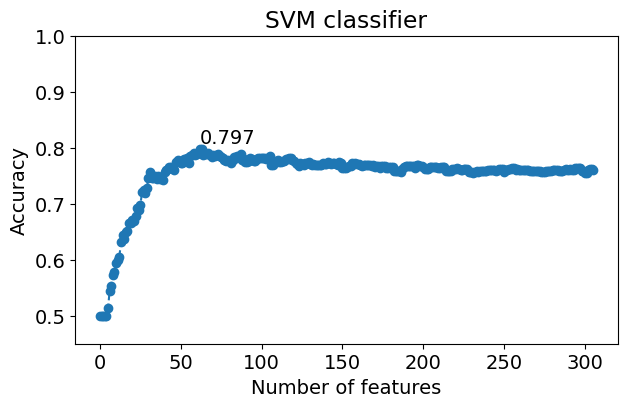

auc_best = 0.79727564
best auc (SVM) =  0.797275641025641 Number of features =  62
We need to compute LASSO ranking


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/200 [00:05<18:05,  5.45s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
  1%|          | 2/200 [00:10<18:03,  5.47s/it]c:\Users\Maksim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coord

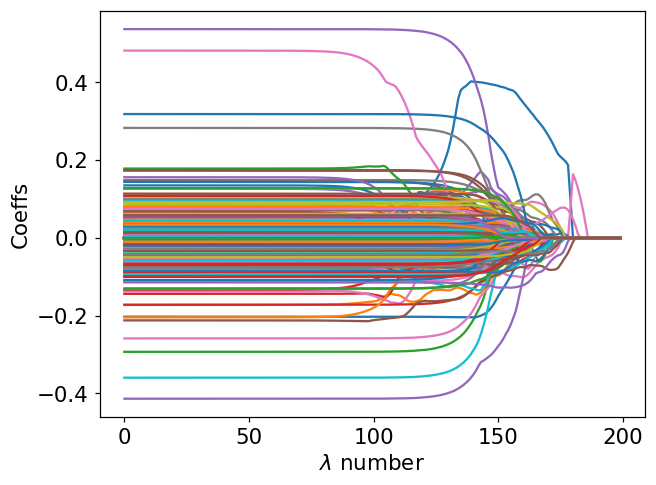

  0%|          | 0/306 [00:00<?, ?it/s]

UAR = 0.500


  0%|          | 1/306 [00:09<47:16,  9.30s/it]

UAR = 0.521
Iter =  1  UAR = 0.5206
UAR = 0.500
UAR = 0.505
UAR = 0.557


  1%|          | 2/306 [00:18<48:13,  9.52s/it]

UAR = 0.603
Iter =  2  UAR = 0.6030
UAR = 0.500
UAR = 0.538
UAR = 0.603


  1%|          | 3/306 [00:29<49:16,  9.76s/it]

UAR = 0.610
Iter =  3  UAR = 0.6100
UAR = 0.500
UAR = 0.511
UAR = 0.593
UAR = 0.608


  1%|▏         | 4/306 [00:39<49:58,  9.93s/it]

UAR = 0.610
UAR = 0.500
UAR = 0.531
UAR = 0.538
UAR = 0.603
UAR = 0.613


  2%|▏         | 5/306 [00:49<50:55, 10.15s/it]

Iter =  5  UAR = 0.6126
UAR = 0.500
UAR = 0.511
UAR = 0.592
UAR = 0.656
UAR = 0.661
UAR = 0.673
UAR = 0.675


  2%|▏         | 6/306 [00:59<50:44, 10.15s/it]

UAR = 0.690
Iter =  6  UAR = 0.6895
UAR = 0.500
UAR = 0.504
UAR = 0.549
UAR = 0.554
UAR = 0.635
UAR = 0.655
UAR = 0.660
UAR = 0.672
UAR = 0.682
UAR = 0.692


  2%|▏         | 7/306 [01:10<50:49, 10.20s/it]

UAR = 0.694
Iter =  7  UAR = 0.6943
UAR = 0.500
UAR = 0.512
UAR = 0.570
UAR = 0.570
UAR = 0.645
UAR = 0.672
UAR = 0.677
UAR = 0.684
UAR = 0.687
UAR = 0.689


  3%|▎         | 8/306 [01:20<50:59, 10.27s/it]

UAR = 0.691
UAR = 0.500
UAR = 0.537
UAR = 0.631
UAR = 0.644
UAR = 0.688
UAR = 0.701
UAR = 0.702
UAR = 0.709
UAR = 0.710
UAR = 0.715


  3%|▎         | 9/306 [01:31<51:12, 10.35s/it]

UAR = 0.723
Iter =  9  UAR = 0.7228
UAR = 0.500
UAR = 0.508
UAR = 0.543
UAR = 0.642
UAR = 0.647
UAR = 0.696
UAR = 0.701
UAR = 0.703
UAR = 0.708
UAR = 0.716


  3%|▎         | 10/306 [01:41<51:39, 10.47s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.567
UAR = 0.648
UAR = 0.693
UAR = 0.698
UAR = 0.706
UAR = 0.711
UAR = 0.715


  4%|▎         | 11/306 [01:52<52:14, 10.63s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.574
UAR = 0.648
UAR = 0.693
UAR = 0.693
UAR = 0.698
UAR = 0.706
UAR = 0.711
UAR = 0.718


  4%|▍         | 12/306 [02:03<52:47, 10.77s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.621
UAR = 0.678
UAR = 0.698
UAR = 0.708
UAR = 0.715
UAR = 0.717
UAR = 0.720
UAR = 0.722
UAR = 0.724
UAR = 0.725
UAR = 0.729


  4%|▍         | 13/306 [02:15<53:09, 10.89s/it]

Iter =  13  UAR = 0.7288
UAR = 0.500
UAR = 0.515
UAR = 0.621
UAR = 0.690
UAR = 0.709
UAR = 0.711
UAR = 0.722
UAR = 0.723
UAR = 0.723
UAR = 0.730
UAR = 0.732
UAR = 0.737


  5%|▍         | 14/306 [02:26<53:34, 11.01s/it]

Iter =  14  UAR = 0.7366
UAR = 0.500
UAR = 0.526
UAR = 0.629
UAR = 0.672
UAR = 0.690
UAR = 0.709
UAR = 0.719
UAR = 0.720
UAR = 0.726
UAR = 0.731
UAR = 0.731
UAR = 0.735
UAR = 0.737


  5%|▍         | 15/306 [02:37<54:01, 11.14s/it]

UAR = 0.739
Iter =  15  UAR = 0.7390
UAR = 0.500
UAR = 0.559
UAR = 0.642
UAR = 0.691
UAR = 0.711
UAR = 0.719
UAR = 0.729
UAR = 0.731
UAR = 0.734
UAR = 0.735
UAR = 0.743


  5%|▌         | 16/306 [02:48<53:40, 11.11s/it]

Iter =  16  UAR = 0.7428
UAR = 0.500
UAR = 0.507
UAR = 0.583
UAR = 0.686
UAR = 0.710
UAR = 0.726
UAR = 0.729
UAR = 0.730
UAR = 0.741
UAR = 0.744
UAR = 0.748
UAR = 0.748
UAR = 0.750


  6%|▌         | 17/306 [02:59<53:22, 11.08s/it]

Iter =  17  UAR = 0.7498
UAR = 0.500
UAR = 0.510
UAR = 0.590
UAR = 0.686
UAR = 0.707
UAR = 0.725
UAR = 0.727
UAR = 0.733
UAR = 0.735
UAR = 0.745
UAR = 0.747
UAR = 0.747
UAR = 0.748
UAR = 0.751


  6%|▌         | 18/306 [03:10<53:11, 11.08s/it]

Iter =  18  UAR = 0.7508
UAR = 0.500
UAR = 0.510
UAR = 0.593
UAR = 0.684
UAR = 0.702
UAR = 0.703
UAR = 0.728
UAR = 0.728
UAR = 0.730
UAR = 0.733
UAR = 0.745
UAR = 0.747
UAR = 0.748
UAR = 0.751
UAR = 0.751


  6%|▌         | 19/306 [03:22<53:23, 11.16s/it]

Iter =  19  UAR = 0.7512
UAR = 0.500
UAR = 0.510
UAR = 0.601
UAR = 0.694
UAR = 0.718
UAR = 0.738
UAR = 0.741
UAR = 0.748
UAR = 0.751


  7%|▋         | 20/306 [03:33<53:42, 11.27s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.619
UAR = 0.707
UAR = 0.712
UAR = 0.735
UAR = 0.743
UAR = 0.747
UAR = 0.748
UAR = 0.750
UAR = 0.752


  7%|▋         | 21/306 [03:45<54:01, 11.37s/it]

UAR = 0.753
Iter =  21  UAR = 0.7532
UAR = 0.500
UAR = 0.521
UAR = 0.635
UAR = 0.696
UAR = 0.706
UAR = 0.737
UAR = 0.742
UAR = 0.744
UAR = 0.753
UAR = 0.755


  7%|▋         | 22/306 [03:57<54:25, 11.50s/it]

Iter =  22  UAR = 0.7552
UAR = 0.500
UAR = 0.534
UAR = 0.635
UAR = 0.691
UAR = 0.693
UAR = 0.696
UAR = 0.734
UAR = 0.744
UAR = 0.753
UAR = 0.754
UAR = 0.758


  8%|▊         | 23/306 [04:09<54:54, 11.64s/it]

Iter =  23  UAR = 0.7576
UAR = 0.500
UAR = 0.526
UAR = 0.645
UAR = 0.699
UAR = 0.704
UAR = 0.740
UAR = 0.744
UAR = 0.752
UAR = 0.755
UAR = 0.760
UAR = 0.764


  8%|▊         | 24/306 [04:21<55:07, 11.73s/it]

Iter =  24  UAR = 0.7640
UAR = 0.500
UAR = 0.526
UAR = 0.637
UAR = 0.691
UAR = 0.698
UAR = 0.740
UAR = 0.744
UAR = 0.751
UAR = 0.757
UAR = 0.759
UAR = 0.759
UAR = 0.766


  8%|▊         | 25/306 [04:33<55:25, 11.84s/it]

Iter =  25  UAR = 0.7656
UAR = 0.500
UAR = 0.544
UAR = 0.634
UAR = 0.688
UAR = 0.707
UAR = 0.735
UAR = 0.740
UAR = 0.741
UAR = 0.749
UAR = 0.753
UAR = 0.754
UAR = 0.756
UAR = 0.758
UAR = 0.763


  8%|▊         | 26/306 [04:45<55:53, 11.98s/it]

UAR = 0.500
UAR = 0.547
UAR = 0.637
UAR = 0.691
UAR = 0.718
UAR = 0.735
UAR = 0.740
UAR = 0.752
UAR = 0.756
UAR = 0.759
UAR = 0.762
UAR = 0.763
UAR = 0.765


  9%|▉         | 27/306 [04:57<56:19, 12.11s/it]

UAR = 0.500
UAR = 0.547
UAR = 0.635
UAR = 0.688
UAR = 0.717
UAR = 0.735
UAR = 0.740
UAR = 0.741
UAR = 0.757
UAR = 0.759
UAR = 0.760
UAR = 0.768
UAR = 0.768
UAR = 0.773


  9%|▉         | 28/306 [05:10<56:50, 12.27s/it]

Iter =  28  UAR = 0.7734
UAR = 0.500
UAR = 0.547
UAR = 0.642
UAR = 0.683
UAR = 0.707
UAR = 0.730
UAR = 0.730
UAR = 0.752
UAR = 0.757
UAR = 0.757
UAR = 0.764
UAR = 0.769


  9%|▉         | 29/306 [05:23<57:25, 12.44s/it]

UAR = 0.769
UAR = 0.500
UAR = 0.547
UAR = 0.645
UAR = 0.681
UAR = 0.710
UAR = 0.732
UAR = 0.751
UAR = 0.753
UAR = 0.754
UAR = 0.757
UAR = 0.763
UAR = 0.767


 10%|▉         | 30/306 [05:36<57:53, 12.58s/it]

UAR = 0.773
UAR = 0.500
UAR = 0.552
UAR = 0.647
UAR = 0.675
UAR = 0.710
UAR = 0.725
UAR = 0.737
UAR = 0.754
UAR = 0.760
UAR = 0.768


 10%|█         | 31/306 [05:49<58:29, 12.76s/it]

UAR = 0.500
UAR = 0.552
UAR = 0.649
UAR = 0.673
UAR = 0.709
UAR = 0.738
UAR = 0.752
UAR = 0.756
UAR = 0.766


 10%|█         | 32/306 [06:01<57:01, 12.49s/it]

UAR = 0.767
UAR = 0.500
UAR = 0.549
UAR = 0.639
UAR = 0.662
UAR = 0.715
UAR = 0.738
UAR = 0.751
UAR = 0.751
UAR = 0.752
UAR = 0.756
UAR = 0.765
UAR = 0.775


 11%|█         | 33/306 [06:13<56:03, 12.32s/it]

Iter =  33  UAR = 0.7746
UAR = 0.500
UAR = 0.549
UAR = 0.624
UAR = 0.649
UAR = 0.712
UAR = 0.735
UAR = 0.755
UAR = 0.759
UAR = 0.761
UAR = 0.765
UAR = 0.767
UAR = 0.769


 11%|█         | 34/306 [06:25<55:36, 12.27s/it]

UAR = 0.500
UAR = 0.542
UAR = 0.619
UAR = 0.651
UAR = 0.715
UAR = 0.733
UAR = 0.757
UAR = 0.759
UAR = 0.764
UAR = 0.767
UAR = 0.768
UAR = 0.775


 11%|█▏        | 35/306 [06:37<55:31, 12.29s/it]

Iter =  35  UAR = 0.7754
UAR = 0.500
UAR = 0.542
UAR = 0.614
UAR = 0.643
UAR = 0.715
UAR = 0.728
UAR = 0.734
UAR = 0.746
UAR = 0.759
UAR = 0.759
UAR = 0.763
UAR = 0.766
UAR = 0.777


 12%|█▏        | 36/306 [06:50<55:41, 12.38s/it]

UAR = 0.782
Iter =  36  UAR = 0.7821
UAR = 0.500
UAR = 0.539
UAR = 0.609
UAR = 0.630
UAR = 0.707
UAR = 0.732
UAR = 0.737
UAR = 0.746
UAR = 0.763
UAR = 0.764
UAR = 0.767
UAR = 0.767
UAR = 0.767
UAR = 0.769
UAR = 0.778


 12%|█▏        | 37/306 [07:03<55:55, 12.47s/it]

UAR = 0.500
UAR = 0.539
UAR = 0.609
UAR = 0.625
UAR = 0.710
UAR = 0.728
UAR = 0.732
UAR = 0.746
UAR = 0.761
UAR = 0.773
UAR = 0.773
UAR = 0.779


 12%|█▏        | 38/306 [07:15<56:15, 12.59s/it]

UAR = 0.500
UAR = 0.536
UAR = 0.604
UAR = 0.617
UAR = 0.708
UAR = 0.728
UAR = 0.729
UAR = 0.746
UAR = 0.761
UAR = 0.768
UAR = 0.774


 13%|█▎        | 39/306 [07:29<56:41, 12.74s/it]

UAR = 0.777
UAR = 0.500
UAR = 0.534
UAR = 0.591
UAR = 0.604
UAR = 0.611
UAR = 0.705
UAR = 0.731
UAR = 0.733
UAR = 0.750
UAR = 0.758
UAR = 0.763
UAR = 0.767
UAR = 0.774
UAR = 0.775
UAR = 0.790


 13%|█▎        | 40/306 [07:42<57:02, 12.87s/it]

Iter =  40  UAR = 0.7905
UAR = 0.500
UAR = 0.531
UAR = 0.591
UAR = 0.607
UAR = 0.613
UAR = 0.706
UAR = 0.727
UAR = 0.734
UAR = 0.740
UAR = 0.753
UAR = 0.758
UAR = 0.766
UAR = 0.773
UAR = 0.780
UAR = 0.789


 13%|█▎        | 41/306 [07:55<57:26, 13.00s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.594
UAR = 0.602
UAR = 0.619
UAR = 0.706
UAR = 0.722
UAR = 0.732
UAR = 0.740
UAR = 0.750
UAR = 0.752
UAR = 0.755
UAR = 0.766
UAR = 0.770
UAR = 0.776
UAR = 0.777
UAR = 0.780


 14%|█▎        | 42/306 [08:09<57:56, 13.17s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.591
UAR = 0.599
UAR = 0.618
UAR = 0.706
UAR = 0.724
UAR = 0.729
UAR = 0.739
UAR = 0.753
UAR = 0.757
UAR = 0.765
UAR = 0.778
UAR = 0.781
UAR = 0.785


 14%|█▍        | 43/306 [08:22<58:30, 13.35s/it]

UAR = 0.500
UAR = 0.529
UAR = 0.591
UAR = 0.596
UAR = 0.624
UAR = 0.705
UAR = 0.727
UAR = 0.737
UAR = 0.740
UAR = 0.748
UAR = 0.754
UAR = 0.754
UAR = 0.765
UAR = 0.773
UAR = 0.775
UAR = 0.786


 14%|█▍        | 44/306 [08:36<59:03, 13.53s/it]

UAR = 0.500
UAR = 0.529
UAR = 0.589
UAR = 0.621
UAR = 0.703
UAR = 0.730
UAR = 0.735
UAR = 0.743
UAR = 0.749
UAR = 0.754
UAR = 0.765
UAR = 0.779
UAR = 0.786
UAR = 0.787


 15%|█▍        | 45/306 [08:50<59:34, 13.70s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.583
UAR = 0.621
UAR = 0.705
UAR = 0.727
UAR = 0.737
UAR = 0.742
UAR = 0.746
UAR = 0.747
UAR = 0.752
UAR = 0.763
UAR = 0.770
UAR = 0.773
UAR = 0.774
UAR = 0.781


 15%|█▌        | 46/306 [09:05<1:00:11, 13.89s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.583
UAR = 0.624
UAR = 0.708
UAR = 0.728
UAR = 0.734
UAR = 0.740
UAR = 0.748
UAR = 0.750
UAR = 0.755
UAR = 0.762
UAR = 0.765
UAR = 0.773
UAR = 0.774
UAR = 0.778
UAR = 0.783


 15%|█▌        | 47/306 [09:19<1:00:46, 14.08s/it]

UAR = 0.500
UAR = 0.531
UAR = 0.576
UAR = 0.621
UAR = 0.711
UAR = 0.728
UAR = 0.729
UAR = 0.740
UAR = 0.748
UAR = 0.750
UAR = 0.757
UAR = 0.762
UAR = 0.765
UAR = 0.771
UAR = 0.777
UAR = 0.779
UAR = 0.781


 16%|█▌        | 48/306 [09:32<59:22, 13.81s/it]  

UAR = 0.500
UAR = 0.529
UAR = 0.565
UAR = 0.621
UAR = 0.703
UAR = 0.719
UAR = 0.727
UAR = 0.740
UAR = 0.755
UAR = 0.756
UAR = 0.757
UAR = 0.773
UAR = 0.774
UAR = 0.777
UAR = 0.778
UAR = 0.788
UAR = 0.788


 16%|█▌        | 49/306 [09:46<58:34, 13.68s/it]

UAR = 0.500
UAR = 0.529
UAR = 0.552
UAR = 0.629
UAR = 0.709
UAR = 0.721
UAR = 0.726
UAR = 0.728
UAR = 0.736
UAR = 0.751
UAR = 0.757
UAR = 0.761
UAR = 0.771
UAR = 0.777
UAR = 0.784
UAR = 0.785
UAR = 0.786


 16%|█▋        | 50/306 [09:59<58:11, 13.64s/it]

UAR = 0.786
UAR = 0.500
UAR = 0.529
UAR = 0.547
UAR = 0.627
UAR = 0.703
UAR = 0.721
UAR = 0.727
UAR = 0.727
UAR = 0.745
UAR = 0.749
UAR = 0.761
UAR = 0.771
UAR = 0.783
UAR = 0.783
UAR = 0.786
UAR = 0.789
UAR = 0.795
UAR = 0.797


 17%|█▋        | 51/306 [10:13<58:07, 13.68s/it]

Iter =  51  UAR = 0.7967
UAR = 0.500
UAR = 0.526
UAR = 0.539
UAR = 0.622
UAR = 0.701
UAR = 0.719
UAR = 0.734
UAR = 0.745
UAR = 0.761
UAR = 0.769
UAR = 0.782
UAR = 0.783
UAR = 0.788
UAR = 0.793
UAR = 0.796


 17%|█▋        | 52/306 [10:27<58:15, 13.76s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.531
UAR = 0.622
UAR = 0.706
UAR = 0.721
UAR = 0.734
UAR = 0.754
UAR = 0.762
UAR = 0.764
UAR = 0.777
UAR = 0.778
UAR = 0.783
UAR = 0.784
UAR = 0.788
UAR = 0.800
UAR = 0.808


 17%|█▋        | 53/306 [10:41<58:42, 13.92s/it]

Iter =  53  UAR = 0.8085
UAR = 0.500
UAR = 0.521
UAR = 0.531
UAR = 0.622
UAR = 0.709
UAR = 0.723
UAR = 0.731
UAR = 0.759
UAR = 0.766
UAR = 0.779
UAR = 0.781
UAR = 0.788
UAR = 0.801
UAR = 0.810


 18%|█▊        | 54/306 [10:56<59:14, 14.11s/it]

Iter =  54  UAR = 0.8105
UAR = 0.500
UAR = 0.516
UAR = 0.529
UAR = 0.622
UAR = 0.701
UAR = 0.720
UAR = 0.731
UAR = 0.756
UAR = 0.771
UAR = 0.784
UAR = 0.785
UAR = 0.805


 18%|█▊        | 55/306 [11:11<59:50, 14.30s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.531
UAR = 0.624
UAR = 0.703
UAR = 0.723
UAR = 0.728
UAR = 0.754
UAR = 0.769
UAR = 0.782
UAR = 0.786
UAR = 0.790
UAR = 0.801
UAR = 0.801


 18%|█▊        | 56/306 [11:25<1:00:12, 14.45s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.531
UAR = 0.619
UAR = 0.697
UAR = 0.723
UAR = 0.725
UAR = 0.732
UAR = 0.754
UAR = 0.775
UAR = 0.782
UAR = 0.789
UAR = 0.798


 19%|█▊        | 57/306 [11:40<1:00:38, 14.61s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.531
UAR = 0.622
UAR = 0.698
UAR = 0.720
UAR = 0.724
UAR = 0.754
UAR = 0.766
UAR = 0.767
UAR = 0.769
UAR = 0.771
UAR = 0.783
UAR = 0.784
UAR = 0.787
UAR = 0.798


 19%|█▉        | 58/306 [11:56<1:01:09, 14.80s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.529
UAR = 0.614
UAR = 0.695
UAR = 0.723
UAR = 0.732
UAR = 0.755
UAR = 0.774
UAR = 0.782
UAR = 0.786
UAR = 0.789
UAR = 0.794


 19%|█▉        | 59/306 [12:11<1:01:43, 14.99s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.526
UAR = 0.614
UAR = 0.700
UAR = 0.728
UAR = 0.732
UAR = 0.763
UAR = 0.778
UAR = 0.781
UAR = 0.794
UAR = 0.796
UAR = 0.798


 20%|█▉        | 60/306 [12:27<1:02:16, 15.19s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.523
UAR = 0.619
UAR = 0.705
UAR = 0.730
UAR = 0.740
UAR = 0.766
UAR = 0.781
UAR = 0.794
UAR = 0.797


 20%|█▉        | 61/306 [12:43<1:02:53, 15.40s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.513
UAR = 0.518
UAR = 0.616
UAR = 0.702
UAR = 0.730
UAR = 0.742
UAR = 0.769
UAR = 0.781
UAR = 0.789
UAR = 0.794


 20%|██        | 62/306 [12:59<1:03:28, 15.61s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.513
UAR = 0.518
UAR = 0.616
UAR = 0.703
UAR = 0.730
UAR = 0.742
UAR = 0.769
UAR = 0.778
UAR = 0.780
UAR = 0.789
UAR = 0.794
UAR = 0.796
UAR = 0.798
UAR = 0.801


 21%|██        | 63/306 [13:15<1:04:09, 15.84s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.619
UAR = 0.703
UAR = 0.731
UAR = 0.732
UAR = 0.740
UAR = 0.769
UAR = 0.778
UAR = 0.783
UAR = 0.796
UAR = 0.805


 21%|██        | 64/306 [13:30<1:02:10, 15.41s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.616
UAR = 0.700
UAR = 0.728
UAR = 0.733
UAR = 0.740
UAR = 0.774
UAR = 0.778
UAR = 0.781
UAR = 0.798
UAR = 0.805


 21%|██        | 65/306 [13:44<1:00:57, 15.18s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.619
UAR = 0.703
UAR = 0.725
UAR = 0.749
UAR = 0.772
UAR = 0.774
UAR = 0.775
UAR = 0.789
UAR = 0.797
UAR = 0.802


 22%|██▏       | 66/306 [13:59<1:00:20, 15.08s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.518
UAR = 0.617
UAR = 0.706
UAR = 0.733
UAR = 0.746
UAR = 0.772
UAR = 0.774
UAR = 0.778
UAR = 0.789
UAR = 0.794
UAR = 0.796
UAR = 0.797
UAR = 0.807


 22%|██▏       | 67/306 [14:14<1:00:12, 15.11s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.617
UAR = 0.706
UAR = 0.732
UAR = 0.751
UAR = 0.769
UAR = 0.779
UAR = 0.788
UAR = 0.796
UAR = 0.798


 22%|██▏       | 68/306 [14:30<1:00:25, 15.23s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.617
UAR = 0.706
UAR = 0.727
UAR = 0.751
UAR = 0.769
UAR = 0.777
UAR = 0.781
UAR = 0.794
UAR = 0.797
UAR = 0.803


 23%|██▎       | 69/306 [14:46<1:00:51, 15.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.508
UAR = 0.518
UAR = 0.617
UAR = 0.706
UAR = 0.733
UAR = 0.751
UAR = 0.767
UAR = 0.778
UAR = 0.783
UAR = 0.794
UAR = 0.797


 23%|██▎       | 70/306 [15:02<1:01:33, 15.65s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.508
UAR = 0.518
UAR = 0.617
UAR = 0.703
UAR = 0.728
UAR = 0.751
UAR = 0.767
UAR = 0.776
UAR = 0.781
UAR = 0.795
UAR = 0.795


 23%|██▎       | 71/306 [15:18<1:02:20, 15.92s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.518
UAR = 0.614
UAR = 0.696
UAR = 0.728
UAR = 0.751
UAR = 0.761
UAR = 0.774
UAR = 0.786
UAR = 0.795
UAR = 0.795


 24%|██▎       | 72/306 [15:35<1:02:54, 16.13s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.518
UAR = 0.617
UAR = 0.701
UAR = 0.723
UAR = 0.741
UAR = 0.756
UAR = 0.770
UAR = 0.772
UAR = 0.778
UAR = 0.789
UAR = 0.793
UAR = 0.796
UAR = 0.798


 24%|██▍       | 73/306 [15:52<1:03:29, 16.35s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.619
UAR = 0.703
UAR = 0.718
UAR = 0.741
UAR = 0.755
UAR = 0.771
UAR = 0.774
UAR = 0.781
UAR = 0.789
UAR = 0.790
UAR = 0.796
UAR = 0.798


 24%|██▍       | 74/306 [16:09<1:04:12, 16.60s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.624
UAR = 0.698
UAR = 0.720
UAR = 0.739
UAR = 0.753
UAR = 0.768
UAR = 0.769
UAR = 0.778
UAR = 0.782
UAR = 0.787
UAR = 0.791
UAR = 0.803


 25%|██▍       | 75/306 [16:26<1:04:51, 16.85s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.619
UAR = 0.692
UAR = 0.717
UAR = 0.738
UAR = 0.758
UAR = 0.768
UAR = 0.769
UAR = 0.772
UAR = 0.779
UAR = 0.786
UAR = 0.792


 25%|██▍       | 76/306 [16:44<1:05:35, 17.11s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.505
UAR = 0.521
UAR = 0.622
UAR = 0.700
UAR = 0.715
UAR = 0.736
UAR = 0.760
UAR = 0.768
UAR = 0.770
UAR = 0.779
UAR = 0.789
UAR = 0.795


 25%|██▌       | 77/306 [17:02<1:06:11, 17.34s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.614
UAR = 0.700
UAR = 0.711
UAR = 0.734
UAR = 0.755
UAR = 0.768
UAR = 0.769
UAR = 0.779
UAR = 0.787
UAR = 0.797


 25%|██▌       | 78/306 [17:20<1:06:47, 17.58s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.614
UAR = 0.694
UAR = 0.704
UAR = 0.734
UAR = 0.760
UAR = 0.768
UAR = 0.773
UAR = 0.774
UAR = 0.787
UAR = 0.794
UAR = 0.797


 26%|██▌       | 79/306 [17:39<1:07:28, 17.83s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.614
UAR = 0.686
UAR = 0.699
UAR = 0.734
UAR = 0.755
UAR = 0.771
UAR = 0.776
UAR = 0.777
UAR = 0.785
UAR = 0.794
UAR = 0.804


 26%|██▌       | 80/306 [17:55<1:05:07, 17.29s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.521
UAR = 0.614
UAR = 0.689
UAR = 0.698
UAR = 0.741
UAR = 0.760
UAR = 0.771
UAR = 0.776
UAR = 0.778
UAR = 0.785
UAR = 0.788
UAR = 0.794
UAR = 0.804


 26%|██▋       | 81/306 [18:11<1:03:36, 16.96s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.614
UAR = 0.691
UAR = 0.704
UAR = 0.738
UAR = 0.762
UAR = 0.768
UAR = 0.769
UAR = 0.771
UAR = 0.775
UAR = 0.790
UAR = 0.800


 27%|██▋       | 82/306 [18:27<1:02:43, 16.80s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.614
UAR = 0.689
UAR = 0.701
UAR = 0.741
UAR = 0.760
UAR = 0.768
UAR = 0.769
UAR = 0.774
UAR = 0.783
UAR = 0.785
UAR = 0.789
UAR = 0.798


 27%|██▋       | 83/306 [18:44<1:02:18, 16.76s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.611
UAR = 0.686
UAR = 0.706
UAR = 0.739
UAR = 0.757
UAR = 0.763
UAR = 0.764
UAR = 0.769
UAR = 0.769
UAR = 0.771
UAR = 0.776
UAR = 0.785
UAR = 0.791


 27%|██▋       | 84/306 [19:01<1:02:15, 16.83s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.611
UAR = 0.686
UAR = 0.706
UAR = 0.744
UAR = 0.762
UAR = 0.764
UAR = 0.765
UAR = 0.772
UAR = 0.776
UAR = 0.785
UAR = 0.787
UAR = 0.800


 28%|██▊       | 85/306 [19:18<1:02:42, 17.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.518
UAR = 0.611
UAR = 0.686
UAR = 0.704
UAR = 0.741
UAR = 0.765
UAR = 0.766
UAR = 0.768
UAR = 0.775
UAR = 0.790
UAR = 0.800


 28%|██▊       | 86/306 [19:36<1:03:10, 17.23s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.611
UAR = 0.681
UAR = 0.706
UAR = 0.741
UAR = 0.765
UAR = 0.768
UAR = 0.774
UAR = 0.778
UAR = 0.786
UAR = 0.797


 28%|██▊       | 87/306 [19:54<1:03:47, 17.48s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.609
UAR = 0.676
UAR = 0.696
UAR = 0.743
UAR = 0.765
UAR = 0.767
UAR = 0.768
UAR = 0.769
UAR = 0.774
UAR = 0.781
UAR = 0.784
UAR = 0.790
UAR = 0.797


 29%|██▉       | 88/306 [20:12<1:04:13, 17.68s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.609
UAR = 0.676
UAR = 0.693
UAR = 0.748
UAR = 0.767
UAR = 0.769
UAR = 0.776
UAR = 0.787
UAR = 0.789
UAR = 0.790


 29%|██▉       | 89/306 [20:31<1:04:43, 17.90s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.606
UAR = 0.676
UAR = 0.693
UAR = 0.741
UAR = 0.765
UAR = 0.770
UAR = 0.771
UAR = 0.776
UAR = 0.790


 29%|██▉       | 90/306 [20:49<1:05:17, 18.14s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.611
UAR = 0.687
UAR = 0.705
UAR = 0.748
UAR = 0.768
UAR = 0.773
UAR = 0.783
UAR = 0.785
UAR = 0.791


 30%|██▉       | 91/306 [21:08<1:05:48, 18.36s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.608
UAR = 0.680
UAR = 0.697
UAR = 0.744
UAR = 0.765
UAR = 0.766
UAR = 0.773
UAR = 0.777
UAR = 0.781
UAR = 0.784


 30%|███       | 92/306 [21:27<1:06:17, 18.59s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.611
UAR = 0.682
UAR = 0.697
UAR = 0.744
UAR = 0.769
UAR = 0.771
UAR = 0.784
UAR = 0.789
UAR = 0.790
UAR = 0.795


 30%|███       | 93/306 [21:47<1:06:53, 18.84s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.611
UAR = 0.680
UAR = 0.700
UAR = 0.746
UAR = 0.771
UAR = 0.771
UAR = 0.775
UAR = 0.778
UAR = 0.787
UAR = 0.796


 31%|███       | 94/306 [22:07<1:07:33, 19.12s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.606
UAR = 0.680
UAR = 0.689
UAR = 0.746
UAR = 0.768
UAR = 0.771
UAR = 0.771
UAR = 0.775
UAR = 0.781
UAR = 0.785
UAR = 0.789


 31%|███       | 95/306 [22:27<1:08:21, 19.44s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.603
UAR = 0.677
UAR = 0.683
UAR = 0.684
UAR = 0.746
UAR = 0.768
UAR = 0.771
UAR = 0.774
UAR = 0.777
UAR = 0.778
UAR = 0.787
UAR = 0.791


 31%|███▏      | 96/306 [22:44<1:06:11, 18.91s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.603
UAR = 0.677
UAR = 0.681
UAR = 0.748
UAR = 0.765
UAR = 0.767
UAR = 0.771
UAR = 0.772
UAR = 0.779
UAR = 0.781
UAR = 0.792


 32%|███▏      | 97/306 [23:02<1:04:52, 18.62s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.603
UAR = 0.675
UAR = 0.683
UAR = 0.748
UAR = 0.765
UAR = 0.771
UAR = 0.775
UAR = 0.777
UAR = 0.787


 32%|███▏      | 98/306 [23:21<1:04:10, 18.51s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.606
UAR = 0.669
UAR = 0.681
UAR = 0.751
UAR = 0.760
UAR = 0.765
UAR = 0.771
UAR = 0.773
UAR = 0.775
UAR = 0.789


 32%|███▏      | 99/306 [23:39<1:03:57, 18.54s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.603
UAR = 0.672
UAR = 0.684
UAR = 0.745
UAR = 0.760
UAR = 0.762
UAR = 0.765
UAR = 0.771
UAR = 0.780
UAR = 0.790


 33%|███▎      | 100/306 [23:58<1:04:03, 18.66s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.606
UAR = 0.672
UAR = 0.676
UAR = 0.745
UAR = 0.759
UAR = 0.762
UAR = 0.766
UAR = 0.768
UAR = 0.768
UAR = 0.777
UAR = 0.784
UAR = 0.786


 33%|███▎      | 101/306 [24:17<1:04:20, 18.83s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.606
UAR = 0.673
UAR = 0.679
UAR = 0.745
UAR = 0.759
UAR = 0.763
UAR = 0.768
UAR = 0.777
UAR = 0.787


 33%|███▎      | 102/306 [24:37<1:04:47, 19.06s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.603
UAR = 0.673
UAR = 0.679
UAR = 0.746
UAR = 0.759
UAR = 0.762
UAR = 0.768
UAR = 0.772
UAR = 0.777
UAR = 0.777
UAR = 0.787


 34%|███▎      | 103/306 [24:57<1:05:28, 19.35s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.603
UAR = 0.673
UAR = 0.677
UAR = 0.748
UAR = 0.759
UAR = 0.762
UAR = 0.765
UAR = 0.766
UAR = 0.773
UAR = 0.774
UAR = 0.777
UAR = 0.786


 34%|███▍      | 104/306 [25:17<1:05:57, 19.59s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.603
UAR = 0.676
UAR = 0.679
UAR = 0.748
UAR = 0.760
UAR = 0.762
UAR = 0.763
UAR = 0.768
UAR = 0.776
UAR = 0.785
UAR = 0.788


 34%|███▍      | 105/306 [25:38<1:06:25, 19.83s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.601
UAR = 0.673
UAR = 0.677
UAR = 0.748
UAR = 0.760
UAR = 0.764
UAR = 0.766
UAR = 0.768
UAR = 0.770
UAR = 0.777
UAR = 0.778
UAR = 0.787


 35%|███▍      | 106/306 [25:58<1:07:01, 20.11s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.601
UAR = 0.662
UAR = 0.677
UAR = 0.743
UAR = 0.759
UAR = 0.765
UAR = 0.766
UAR = 0.773
UAR = 0.774
UAR = 0.775
UAR = 0.779
UAR = 0.788


 35%|███▍      | 107/306 [26:20<1:07:47, 20.44s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.603
UAR = 0.668
UAR = 0.670
UAR = 0.673
UAR = 0.748
UAR = 0.762
UAR = 0.768
UAR = 0.771
UAR = 0.772
UAR = 0.775
UAR = 0.786


 35%|███▌      | 108/306 [26:41<1:08:31, 20.77s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.603
UAR = 0.668
UAR = 0.674
UAR = 0.748
UAR = 0.760
UAR = 0.765
UAR = 0.772
UAR = 0.775
UAR = 0.775
UAR = 0.783


 36%|███▌      | 109/306 [27:03<1:09:14, 21.09s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.603
UAR = 0.665
UAR = 0.669
UAR = 0.748
UAR = 0.760
UAR = 0.765
UAR = 0.772
UAR = 0.774
UAR = 0.780
UAR = 0.786


 36%|███▌      | 110/306 [27:25<1:09:51, 21.38s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.601
UAR = 0.668
UAR = 0.671
UAR = 0.745
UAR = 0.762
UAR = 0.767
UAR = 0.768
UAR = 0.769
UAR = 0.776
UAR = 0.780
UAR = 0.784


 36%|███▋      | 111/306 [27:48<1:10:35, 21.72s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.598
UAR = 0.663
UAR = 0.668
UAR = 0.674
UAR = 0.745
UAR = 0.752
UAR = 0.765
UAR = 0.770
UAR = 0.774
UAR = 0.775
UAR = 0.785
UAR = 0.787
UAR = 0.793


 37%|███▋      | 112/306 [28:07<1:08:16, 21.11s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.598
UAR = 0.660
UAR = 0.665
UAR = 0.672
UAR = 0.745
UAR = 0.757
UAR = 0.765
UAR = 0.770
UAR = 0.774
UAR = 0.775
UAR = 0.778
UAR = 0.783
UAR = 0.785
UAR = 0.796


 37%|███▋      | 113/306 [28:27<1:06:53, 20.80s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.596
UAR = 0.658
UAR = 0.663
UAR = 0.669
UAR = 0.745
UAR = 0.760
UAR = 0.767
UAR = 0.771
UAR = 0.777
UAR = 0.784
UAR = 0.788


 37%|███▋      | 114/306 [28:48<1:06:10, 20.68s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.596
UAR = 0.655
UAR = 0.665
UAR = 0.675
UAR = 0.746
UAR = 0.763
UAR = 0.764
UAR = 0.766
UAR = 0.773
UAR = 0.775
UAR = 0.779
UAR = 0.786
UAR = 0.791


 38%|███▊      | 115/306 [29:09<1:05:59, 20.73s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.593
UAR = 0.658
UAR = 0.660
UAR = 0.672
UAR = 0.746
UAR = 0.763
UAR = 0.765
UAR = 0.773
UAR = 0.773
UAR = 0.775
UAR = 0.779
UAR = 0.789
UAR = 0.794


 38%|███▊      | 116/306 [29:30<1:06:16, 20.93s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.593
UAR = 0.660
UAR = 0.674
UAR = 0.746
UAR = 0.763
UAR = 0.765
UAR = 0.773
UAR = 0.775
UAR = 0.779
UAR = 0.789
UAR = 0.794


 38%|███▊      | 117/306 [29:52<1:06:46, 21.20s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.593
UAR = 0.660
UAR = 0.674
UAR = 0.746
UAR = 0.761
UAR = 0.765
UAR = 0.773
UAR = 0.780
UAR = 0.781
UAR = 0.791


 39%|███▊      | 118/306 [30:14<1:07:15, 21.46s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.593
UAR = 0.655
UAR = 0.657
UAR = 0.672
UAR = 0.746
UAR = 0.758
UAR = 0.767
UAR = 0.771
UAR = 0.777
UAR = 0.781
UAR = 0.791


 39%|███▉      | 119/306 [30:36<1:07:48, 21.76s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.593
UAR = 0.658
UAR = 0.672
UAR = 0.746
UAR = 0.758
UAR = 0.767
UAR = 0.771
UAR = 0.780
UAR = 0.786


 39%|███▉      | 120/306 [30:59<1:08:06, 21.97s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.588
UAR = 0.658
UAR = 0.672
UAR = 0.745
UAR = 0.760
UAR = 0.765
UAR = 0.770
UAR = 0.773
UAR = 0.780
UAR = 0.792


 40%|███▉      | 121/306 [31:22<1:08:36, 22.25s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.658
UAR = 0.674
UAR = 0.743
UAR = 0.757
UAR = 0.762
UAR = 0.763
UAR = 0.773
UAR = 0.779
UAR = 0.789
UAR = 0.791


 40%|███▉      | 122/306 [31:45<1:09:12, 22.57s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.655
UAR = 0.679
UAR = 0.743
UAR = 0.757
UAR = 0.762
UAR = 0.773
UAR = 0.775
UAR = 0.789


 40%|████      | 123/306 [32:08<1:09:43, 22.86s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.648
UAR = 0.677
UAR = 0.743
UAR = 0.760
UAR = 0.762
UAR = 0.768
UAR = 0.769
UAR = 0.772
UAR = 0.777
UAR = 0.789


 41%|████      | 124/306 [32:33<1:10:47, 23.34s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.583
UAR = 0.648
UAR = 0.677
UAR = 0.743
UAR = 0.755
UAR = 0.760
UAR = 0.766
UAR = 0.768
UAR = 0.771
UAR = 0.775
UAR = 0.775
UAR = 0.786


 41%|████      | 125/306 [32:57<1:11:18, 23.64s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.586
UAR = 0.653
UAR = 0.674
UAR = 0.738
UAR = 0.755
UAR = 0.760
UAR = 0.761
UAR = 0.767
UAR = 0.768
UAR = 0.779
UAR = 0.785
UAR = 0.790


 41%|████      | 126/306 [33:22<1:11:39, 23.88s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.583
UAR = 0.653
UAR = 0.672
UAR = 0.738
UAR = 0.755
UAR = 0.760
UAR = 0.772
UAR = 0.776
UAR = 0.783
UAR = 0.785


 42%|████▏     | 127/306 [33:46<1:12:00, 24.14s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.586
UAR = 0.653
UAR = 0.669
UAR = 0.740
UAR = 0.752
UAR = 0.757
UAR = 0.760
UAR = 0.769
UAR = 0.770
UAR = 0.777
UAR = 0.779
UAR = 0.780
UAR = 0.790


 42%|████▏     | 128/306 [34:08<1:09:35, 23.46s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.588
UAR = 0.650
UAR = 0.672
UAR = 0.740
UAR = 0.752
UAR = 0.755
UAR = 0.757
UAR = 0.763
UAR = 0.769
UAR = 0.775
UAR = 0.778
UAR = 0.790


 42%|████▏     | 129/306 [34:30<1:07:54, 23.02s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.580
UAR = 0.648
UAR = 0.674
UAR = 0.741
UAR = 0.753
UAR = 0.755
UAR = 0.757
UAR = 0.763
UAR = 0.767
UAR = 0.771
UAR = 0.777
UAR = 0.784
UAR = 0.789


 42%|████▏     | 130/306 [34:53<1:06:50, 22.79s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.580
UAR = 0.645
UAR = 0.676
UAR = 0.741
UAR = 0.753
UAR = 0.755
UAR = 0.757
UAR = 0.771
UAR = 0.774
UAR = 0.775
UAR = 0.797
UAR = 0.797


 43%|████▎     | 131/306 [35:15<1:06:20, 22.75s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.645
UAR = 0.675
UAR = 0.741
UAR = 0.752
UAR = 0.759
UAR = 0.770
UAR = 0.779
UAR = 0.793


 43%|████▎     | 132/306 [35:38<1:06:18, 22.87s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.583
UAR = 0.643
UAR = 0.675
UAR = 0.738
UAR = 0.752
UAR = 0.759
UAR = 0.761
UAR = 0.766
UAR = 0.770
UAR = 0.774
UAR = 0.790
UAR = 0.798


 43%|████▎     | 133/306 [36:02<1:06:28, 23.05s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.580
UAR = 0.640
UAR = 0.675
UAR = 0.741
UAR = 0.752
UAR = 0.757
UAR = 0.758
UAR = 0.762
UAR = 0.769
UAR = 0.777
UAR = 0.787
UAR = 0.790


 44%|████▍     | 134/306 [36:26<1:06:41, 23.27s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.580
UAR = 0.640
UAR = 0.675
UAR = 0.741
UAR = 0.752
UAR = 0.754
UAR = 0.759
UAR = 0.765
UAR = 0.765
UAR = 0.772
UAR = 0.777
UAR = 0.786
UAR = 0.787


 44%|████▍     | 135/306 [36:50<1:07:07, 23.55s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.580
UAR = 0.640
UAR = 0.675
UAR = 0.738
UAR = 0.754
UAR = 0.759
UAR = 0.765
UAR = 0.767
UAR = 0.777
UAR = 0.783
UAR = 0.787


 44%|████▍     | 136/306 [37:14<1:07:23, 23.78s/it]

UAR = 0.500
UAR = 0.513
UAR = 0.580
UAR = 0.635
UAR = 0.675
UAR = 0.735
UAR = 0.752
UAR = 0.759
UAR = 0.768
UAR = 0.776
UAR = 0.786
UAR = 0.787


 45%|████▍     | 137/306 [37:39<1:07:40, 24.03s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.583
UAR = 0.629
UAR = 0.674
UAR = 0.735
UAR = 0.752
UAR = 0.765
UAR = 0.765
UAR = 0.768
UAR = 0.769
UAR = 0.783
UAR = 0.787


 45%|████▌     | 138/306 [38:04<1:08:04, 24.31s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.583
UAR = 0.627
UAR = 0.677
UAR = 0.735
UAR = 0.752
UAR = 0.762
UAR = 0.765
UAR = 0.768
UAR = 0.771
UAR = 0.783
UAR = 0.787


 45%|████▌     | 139/306 [38:29<1:08:26, 24.59s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.583
UAR = 0.632
UAR = 0.680
UAR = 0.738
UAR = 0.752
UAR = 0.763
UAR = 0.765
UAR = 0.770
UAR = 0.773
UAR = 0.786
UAR = 0.787


 46%|████▌     | 140/306 [38:54<1:08:44, 24.85s/it]

UAR = 0.500
UAR = 0.523
UAR = 0.578
UAR = 0.635
UAR = 0.677
UAR = 0.738
UAR = 0.749
UAR = 0.751
UAR = 0.760
UAR = 0.768
UAR = 0.770
UAR = 0.771
UAR = 0.787


 46%|████▌     | 141/306 [39:20<1:09:15, 25.18s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.580
UAR = 0.632
UAR = 0.679
UAR = 0.746
UAR = 0.749
UAR = 0.752
UAR = 0.752
UAR = 0.762
UAR = 0.763
UAR = 0.768
UAR = 0.768
UAR = 0.769
UAR = 0.772
UAR = 0.786


 46%|████▋     | 142/306 [39:47<1:09:41, 25.50s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.580
UAR = 0.632
UAR = 0.679
UAR = 0.746
UAR = 0.749
UAR = 0.752
UAR = 0.752
UAR = 0.762
UAR = 0.763
UAR = 0.768
UAR = 0.768
UAR = 0.769
UAR = 0.772
UAR = 0.781
UAR = 0.782


 47%|████▋     | 143/306 [40:13<1:10:12, 25.85s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.578
UAR = 0.625
UAR = 0.680
UAR = 0.744
UAR = 0.749
UAR = 0.752
UAR = 0.765
UAR = 0.766
UAR = 0.768
UAR = 0.769
UAR = 0.769
UAR = 0.774
UAR = 0.785


 47%|████▋     | 144/306 [40:37<1:08:12, 25.26s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.575
UAR = 0.622
UAR = 0.680
UAR = 0.741
UAR = 0.757
UAR = 0.766
UAR = 0.766
UAR = 0.769
UAR = 0.772
UAR = 0.786


 47%|████▋     | 145/306 [41:01<1:06:54, 24.94s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.575
UAR = 0.622
UAR = 0.674
UAR = 0.736
UAR = 0.755
UAR = 0.762
UAR = 0.768
UAR = 0.771
UAR = 0.789


 48%|████▊     | 146/306 [41:26<1:06:08, 24.80s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.575
UAR = 0.622
UAR = 0.674
UAR = 0.738
UAR = 0.757
UAR = 0.758
UAR = 0.765
UAR = 0.768
UAR = 0.771
UAR = 0.783


 48%|████▊     | 147/306 [41:51<1:05:38, 24.77s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.575
UAR = 0.619
UAR = 0.672
UAR = 0.738
UAR = 0.757
UAR = 0.762
UAR = 0.766
UAR = 0.772
UAR = 0.780


 48%|████▊     | 148/306 [42:15<1:05:19, 24.81s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.575
UAR = 0.619
UAR = 0.672
UAR = 0.738
UAR = 0.757
UAR = 0.765
UAR = 0.772
UAR = 0.777
UAR = 0.778


 49%|████▊     | 149/306 [42:41<1:05:27, 25.02s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.617
UAR = 0.677
UAR = 0.738
UAR = 0.755
UAR = 0.762
UAR = 0.764
UAR = 0.767
UAR = 0.772
UAR = 0.783


 49%|████▉     | 150/306 [43:07<1:05:38, 25.25s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.617
UAR = 0.672
UAR = 0.738
UAR = 0.755
UAR = 0.762
UAR = 0.767
UAR = 0.769
UAR = 0.778


 49%|████▉     | 151/306 [43:33<1:06:01, 25.56s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.617
UAR = 0.674
UAR = 0.738
UAR = 0.755
UAR = 0.762
UAR = 0.765
UAR = 0.767
UAR = 0.772
UAR = 0.775
UAR = 0.776


 50%|████▉     | 152/306 [43:59<1:06:01, 25.73s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.617
UAR = 0.674
UAR = 0.741
UAR = 0.755
UAR = 0.759
UAR = 0.763
UAR = 0.772
UAR = 0.777


 50%|█████     | 153/306 [44:26<1:06:20, 26.01s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.617
UAR = 0.672
UAR = 0.743
UAR = 0.757
UAR = 0.759
UAR = 0.766
UAR = 0.770
UAR = 0.772
UAR = 0.784


 50%|█████     | 154/306 [44:53<1:06:35, 26.29s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.617
UAR = 0.674
UAR = 0.743
UAR = 0.757
UAR = 0.759
UAR = 0.766
UAR = 0.772
UAR = 0.782


 51%|█████     | 155/306 [45:20<1:07:01, 26.63s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.570
UAR = 0.616
UAR = 0.679
UAR = 0.745
UAR = 0.758
UAR = 0.762
UAR = 0.762
UAR = 0.775
UAR = 0.780


 51%|█████     | 156/306 [45:48<1:07:15, 26.90s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.573
UAR = 0.614
UAR = 0.676
UAR = 0.745
UAR = 0.755
UAR = 0.764
UAR = 0.765
UAR = 0.775
UAR = 0.782


 51%|█████▏    | 157/306 [46:16<1:07:38, 27.24s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.570
UAR = 0.614
UAR = 0.676
UAR = 0.745
UAR = 0.758
UAR = 0.762
UAR = 0.764
UAR = 0.772
UAR = 0.779


 52%|█████▏    | 158/306 [46:44<1:07:55, 27.53s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.570
UAR = 0.614
UAR = 0.679
UAR = 0.745
UAR = 0.755
UAR = 0.762
UAR = 0.763
UAR = 0.764
UAR = 0.775
UAR = 0.779


 52%|█████▏    | 159/306 [47:13<1:08:18, 27.88s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.614
UAR = 0.679
UAR = 0.745
UAR = 0.755
UAR = 0.762
UAR = 0.764
UAR = 0.764
UAR = 0.775
UAR = 0.780


 52%|█████▏    | 160/306 [47:38<1:05:55, 27.09s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.611
UAR = 0.681
UAR = 0.739
UAR = 0.758
UAR = 0.762
UAR = 0.763
UAR = 0.764
UAR = 0.775


 53%|█████▎    | 161/306 [48:04<1:04:31, 26.70s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.609
UAR = 0.681
UAR = 0.742
UAR = 0.755
UAR = 0.762
UAR = 0.765
UAR = 0.769
UAR = 0.776


 53%|█████▎    | 162/306 [48:30<1:03:32, 26.47s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.611
UAR = 0.681
UAR = 0.740
UAR = 0.752
UAR = 0.761
UAR = 0.765
UAR = 0.769
UAR = 0.776


 53%|█████▎    | 163/306 [48:56<1:03:03, 26.46s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.614
UAR = 0.679
UAR = 0.743
UAR = 0.750
UAR = 0.752
UAR = 0.761
UAR = 0.767
UAR = 0.774


 54%|█████▎    | 164/306 [49:23<1:02:37, 26.46s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.611
UAR = 0.679
UAR = 0.743
UAR = 0.752
UAR = 0.753
UAR = 0.761
UAR = 0.764
UAR = 0.767
UAR = 0.767
UAR = 0.774


 54%|█████▍    | 165/306 [49:50<1:02:38, 26.65s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.611
UAR = 0.677
UAR = 0.740
UAR = 0.744
UAR = 0.750
UAR = 0.752
UAR = 0.758
UAR = 0.760
UAR = 0.761
UAR = 0.764
UAR = 0.766
UAR = 0.775
UAR = 0.776


 54%|█████▍    | 166/306 [50:17<1:02:39, 26.86s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.575
UAR = 0.611
UAR = 0.682
UAR = 0.745
UAR = 0.746
UAR = 0.752
UAR = 0.754
UAR = 0.755
UAR = 0.761
UAR = 0.767
UAR = 0.769
UAR = 0.770
UAR = 0.775
UAR = 0.777


 55%|█████▍    | 167/306 [50:45<1:02:49, 27.12s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.606
UAR = 0.682
UAR = 0.740
UAR = 0.746
UAR = 0.750
UAR = 0.754
UAR = 0.758
UAR = 0.761
UAR = 0.767
UAR = 0.771
UAR = 0.775


 55%|█████▍    | 168/306 [51:12<1:02:45, 27.28s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.603
UAR = 0.679
UAR = 0.740
UAR = 0.746
UAR = 0.750
UAR = 0.756
UAR = 0.760
UAR = 0.760
UAR = 0.764
UAR = 0.766
UAR = 0.775
UAR = 0.776


 55%|█████▌    | 169/306 [51:40<1:02:53, 27.54s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.570
UAR = 0.603
UAR = 0.682
UAR = 0.740
UAR = 0.747
UAR = 0.749
UAR = 0.758
UAR = 0.760
UAR = 0.767
UAR = 0.772
UAR = 0.774
UAR = 0.776


 56%|█████▌    | 170/306 [52:09<1:03:00, 27.80s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.573
UAR = 0.603
UAR = 0.679
UAR = 0.740
UAR = 0.747
UAR = 0.750
UAR = 0.761
UAR = 0.770
UAR = 0.773
UAR = 0.774
UAR = 0.775


 56%|█████▌    | 171/306 [52:38<1:03:20, 28.15s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.567
UAR = 0.598
UAR = 0.679
UAR = 0.740
UAR = 0.742
UAR = 0.750
UAR = 0.761
UAR = 0.764
UAR = 0.770
UAR = 0.772
UAR = 0.778


 56%|█████▌    | 172/306 [53:07<1:03:26, 28.41s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.567
UAR = 0.598
UAR = 0.679
UAR = 0.738
UAR = 0.742
UAR = 0.750
UAR = 0.761
UAR = 0.764
UAR = 0.770
UAR = 0.774
UAR = 0.778


 57%|█████▋    | 173/306 [53:36<1:03:45, 28.76s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.565
UAR = 0.596
UAR = 0.684
UAR = 0.740
UAR = 0.742
UAR = 0.750
UAR = 0.764
UAR = 0.764
UAR = 0.770
UAR = 0.770
UAR = 0.774
UAR = 0.778


 57%|█████▋    | 174/306 [54:06<1:03:55, 29.06s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.565
UAR = 0.596
UAR = 0.684
UAR = 0.738
UAR = 0.740
UAR = 0.749
UAR = 0.756
UAR = 0.762
UAR = 0.769
UAR = 0.771
UAR = 0.778


 57%|█████▋    | 175/306 [54:36<1:04:11, 29.40s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.565
UAR = 0.596
UAR = 0.679
UAR = 0.740
UAR = 0.751
UAR = 0.752
UAR = 0.752
UAR = 0.762
UAR = 0.767
UAR = 0.768
UAR = 0.774
UAR = 0.774


 58%|█████▊    | 176/306 [55:03<1:02:01, 28.62s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.562
UAR = 0.593
UAR = 0.679
UAR = 0.736
UAR = 0.743
UAR = 0.752
UAR = 0.753
UAR = 0.758
UAR = 0.759
UAR = 0.766
UAR = 0.769
UAR = 0.776


 58%|█████▊    | 177/306 [55:31<1:00:44, 28.25s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.562
UAR = 0.593
UAR = 0.677
UAR = 0.738
UAR = 0.745
UAR = 0.752
UAR = 0.752
UAR = 0.755
UAR = 0.761
UAR = 0.761
UAR = 0.768
UAR = 0.775


 58%|█████▊    | 178/306 [55:58<59:52, 28.06s/it]  

UAR = 0.500
UAR = 0.518
UAR = 0.562
UAR = 0.593
UAR = 0.677
UAR = 0.741
UAR = 0.745
UAR = 0.752
UAR = 0.755
UAR = 0.757
UAR = 0.763
UAR = 0.764
UAR = 0.766
UAR = 0.770
UAR = 0.774


 58%|█████▊    | 179/306 [56:26<59:19, 28.03s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.559
UAR = 0.593
UAR = 0.682
UAR = 0.740
UAR = 0.745
UAR = 0.752
UAR = 0.757
UAR = 0.758
UAR = 0.764
UAR = 0.765
UAR = 0.775


 59%|█████▉    | 180/306 [56:54<58:52, 28.03s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.559
UAR = 0.586
UAR = 0.679
UAR = 0.732
UAR = 0.740
UAR = 0.752
UAR = 0.758
UAR = 0.764
UAR = 0.766
UAR = 0.767
UAR = 0.770


 59%|█████▉    | 181/306 [57:23<58:45, 28.20s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.554
UAR = 0.586
UAR = 0.679
UAR = 0.732
UAR = 0.740
UAR = 0.752
UAR = 0.755
UAR = 0.761
UAR = 0.766
UAR = 0.770
UAR = 0.774


 59%|█████▉    | 182/306 [57:52<58:41, 28.40s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.554
UAR = 0.586
UAR = 0.682
UAR = 0.732
UAR = 0.737
UAR = 0.751
UAR = 0.755
UAR = 0.758
UAR = 0.766
UAR = 0.768
UAR = 0.772


 60%|█████▉    | 183/306 [58:21<58:45, 28.66s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.552
UAR = 0.583
UAR = 0.679
UAR = 0.732
UAR = 0.737
UAR = 0.751
UAR = 0.755
UAR = 0.763
UAR = 0.766
UAR = 0.768
UAR = 0.771


 60%|██████    | 184/306 [58:50<58:32, 28.79s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.559
UAR = 0.583
UAR = 0.687
UAR = 0.729
UAR = 0.739
UAR = 0.751
UAR = 0.751
UAR = 0.755
UAR = 0.756
UAR = 0.760
UAR = 0.770
UAR = 0.772


 60%|██████    | 185/306 [59:20<58:37, 29.07s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.559
UAR = 0.578
UAR = 0.687
UAR = 0.732
UAR = 0.739
UAR = 0.751
UAR = 0.751
UAR = 0.755
UAR = 0.756
UAR = 0.766
UAR = 0.770


 61%|██████    | 186/306 [59:50<58:40, 29.34s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.554
UAR = 0.573
UAR = 0.574
UAR = 0.685
UAR = 0.729
UAR = 0.736
UAR = 0.748
UAR = 0.755
UAR = 0.759
UAR = 0.768
UAR = 0.774


 61%|██████    | 187/306 [1:00:20<58:52, 29.68s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.557
UAR = 0.573
UAR = 0.574
UAR = 0.684
UAR = 0.724
UAR = 0.742
UAR = 0.749
UAR = 0.749
UAR = 0.755
UAR = 0.756
UAR = 0.765
UAR = 0.770
UAR = 0.774


 61%|██████▏   | 188/306 [1:00:51<58:54, 29.95s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.552
UAR = 0.573
UAR = 0.574
UAR = 0.684
UAR = 0.724
UAR = 0.739
UAR = 0.749
UAR = 0.751
UAR = 0.755
UAR = 0.767
UAR = 0.770
UAR = 0.773


 62%|██████▏   | 189/306 [1:01:22<59:05, 30.30s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.549
UAR = 0.570
UAR = 0.574
UAR = 0.684
UAR = 0.724
UAR = 0.737
UAR = 0.749
UAR = 0.749
UAR = 0.755
UAR = 0.761
UAR = 0.773
UAR = 0.773


 62%|██████▏   | 190/306 [1:01:53<59:12, 30.62s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.557
UAR = 0.570
UAR = 0.577
UAR = 0.679
UAR = 0.724
UAR = 0.737
UAR = 0.745
UAR = 0.751
UAR = 0.755
UAR = 0.759
UAR = 0.773


 62%|██████▏   | 191/306 [1:02:25<59:27, 31.03s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.570
UAR = 0.577
UAR = 0.679
UAR = 0.724
UAR = 0.734
UAR = 0.746
UAR = 0.751
UAR = 0.755
UAR = 0.762
UAR = 0.773


 63%|██████▎   | 192/306 [1:02:54<57:24, 30.22s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.567
UAR = 0.574
UAR = 0.679
UAR = 0.722
UAR = 0.734
UAR = 0.746
UAR = 0.747
UAR = 0.753
UAR = 0.762
UAR = 0.771


 63%|██████▎   | 193/306 [1:03:22<56:08, 29.81s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.567
UAR = 0.574
UAR = 0.679
UAR = 0.724
UAR = 0.739
UAR = 0.748
UAR = 0.750
UAR = 0.754
UAR = 0.760
UAR = 0.769
UAR = 0.775


 63%|██████▎   | 194/306 [1:03:52<55:17, 29.62s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.565
UAR = 0.574
UAR = 0.679
UAR = 0.724
UAR = 0.734
UAR = 0.748
UAR = 0.750
UAR = 0.754
UAR = 0.759
UAR = 0.765
UAR = 0.775


 64%|██████▎   | 195/306 [1:04:21<54:44, 29.59s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.554
UAR = 0.567
UAR = 0.574
UAR = 0.682
UAR = 0.725
UAR = 0.737
UAR = 0.746
UAR = 0.750
UAR = 0.754
UAR = 0.762
UAR = 0.768
UAR = 0.775


 64%|██████▍   | 196/306 [1:04:51<54:13, 29.58s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.552
UAR = 0.567
UAR = 0.574
UAR = 0.682
UAR = 0.725
UAR = 0.737
UAR = 0.748
UAR = 0.750
UAR = 0.754
UAR = 0.759
UAR = 0.767
UAR = 0.774


 64%|██████▍   | 197/306 [1:05:21<54:05, 29.78s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.552
UAR = 0.565
UAR = 0.577
UAR = 0.679
UAR = 0.725
UAR = 0.737
UAR = 0.743
UAR = 0.750
UAR = 0.754
UAR = 0.759
UAR = 0.765
UAR = 0.774


 65%|██████▍   | 198/306 [1:05:51<53:57, 29.98s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.552
UAR = 0.565
UAR = 0.574
UAR = 0.679
UAR = 0.725
UAR = 0.737
UAR = 0.745
UAR = 0.750
UAR = 0.754
UAR = 0.759
UAR = 0.764
UAR = 0.775


 65%|██████▌   | 199/306 [1:06:22<53:56, 30.24s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.552
UAR = 0.565
UAR = 0.574
UAR = 0.679
UAR = 0.725
UAR = 0.737
UAR = 0.745
UAR = 0.750
UAR = 0.754
UAR = 0.757
UAR = 0.765
UAR = 0.774


 65%|██████▌   | 200/306 [1:06:53<53:38, 30.37s/it]

UAR = 0.500
UAR = 0.518
UAR = 0.546
UAR = 0.562
UAR = 0.574
UAR = 0.676
UAR = 0.725
UAR = 0.737
UAR = 0.745
UAR = 0.750
UAR = 0.753
UAR = 0.756
UAR = 0.765
UAR = 0.771


 66%|██████▌   | 201/306 [1:07:24<53:35, 30.62s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.557
UAR = 0.574
UAR = 0.676
UAR = 0.725
UAR = 0.737
UAR = 0.745
UAR = 0.750
UAR = 0.753
UAR = 0.754
UAR = 0.754
UAR = 0.763
UAR = 0.771


 66%|██████▌   | 202/306 [1:07:56<53:31, 30.88s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.549
UAR = 0.559
UAR = 0.577
UAR = 0.681
UAR = 0.725
UAR = 0.739
UAR = 0.743
UAR = 0.750
UAR = 0.754
UAR = 0.754
UAR = 0.768
UAR = 0.770


 66%|██████▋   | 203/306 [1:08:28<53:40, 31.27s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.546
UAR = 0.557
UAR = 0.577
UAR = 0.677
UAR = 0.724
UAR = 0.734
UAR = 0.745
UAR = 0.750
UAR = 0.754
UAR = 0.762
UAR = 0.767
UAR = 0.772


 67%|██████▋   | 204/306 [1:09:00<53:33, 31.51s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.554
UAR = 0.580
UAR = 0.679
UAR = 0.727
UAR = 0.737
UAR = 0.745
UAR = 0.753
UAR = 0.754
UAR = 0.757
UAR = 0.767


 67%|██████▋   | 205/306 [1:09:33<53:41, 31.90s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.554
UAR = 0.577
UAR = 0.679
UAR = 0.724
UAR = 0.739
UAR = 0.743
UAR = 0.753
UAR = 0.754
UAR = 0.756
UAR = 0.767


 67%|██████▋   | 206/306 [1:10:06<53:40, 32.20s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.554
UAR = 0.577
UAR = 0.676
UAR = 0.724
UAR = 0.734
UAR = 0.745
UAR = 0.753
UAR = 0.754
UAR = 0.756
UAR = 0.757
UAR = 0.765


 68%|██████▊   | 207/306 [1:10:39<53:49, 32.62s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.552
UAR = 0.577
UAR = 0.676
UAR = 0.724
UAR = 0.732
UAR = 0.745
UAR = 0.752
UAR = 0.754
UAR = 0.756
UAR = 0.757
UAR = 0.765
UAR = 0.765


 68%|██████▊   | 208/306 [1:11:09<51:52, 31.76s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.546
UAR = 0.552
UAR = 0.580
UAR = 0.679
UAR = 0.722
UAR = 0.732
UAR = 0.748
UAR = 0.752
UAR = 0.757
UAR = 0.765
UAR = 0.765


 68%|██████▊   | 209/306 [1:11:39<50:43, 31.38s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.552
UAR = 0.582
UAR = 0.681
UAR = 0.722
UAR = 0.734
UAR = 0.748
UAR = 0.752
UAR = 0.753
UAR = 0.755
UAR = 0.765
UAR = 0.771


 69%|██████▊   | 210/306 [1:12:10<49:49, 31.14s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.552
UAR = 0.585
UAR = 0.679
UAR = 0.719
UAR = 0.732
UAR = 0.746
UAR = 0.752
UAR = 0.753
UAR = 0.753
UAR = 0.755
UAR = 0.765
UAR = 0.771


 69%|██████▉   | 211/306 [1:12:41<49:14, 31.10s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.551
UAR = 0.585
UAR = 0.678
UAR = 0.719
UAR = 0.732
UAR = 0.745
UAR = 0.751
UAR = 0.755
UAR = 0.763
UAR = 0.768


 69%|██████▉   | 212/306 [1:13:12<48:36, 31.02s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.551
UAR = 0.585
UAR = 0.678
UAR = 0.719
UAR = 0.734
UAR = 0.745
UAR = 0.749
UAR = 0.751
UAR = 0.752
UAR = 0.765
UAR = 0.768


 70%|██████▉   | 213/306 [1:13:44<48:23, 31.22s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.551
UAR = 0.585
UAR = 0.678
UAR = 0.719
UAR = 0.734
UAR = 0.745
UAR = 0.749
UAR = 0.751
UAR = 0.752
UAR = 0.765


 70%|██████▉   | 214/306 [1:14:15<48:12, 31.44s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.551
UAR = 0.585
UAR = 0.678
UAR = 0.719
UAR = 0.737
UAR = 0.746
UAR = 0.749
UAR = 0.751
UAR = 0.752
UAR = 0.757
UAR = 0.769


 70%|███████   | 215/306 [1:14:48<48:09, 31.75s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.554
UAR = 0.585
UAR = 0.678
UAR = 0.727
UAR = 0.732
UAR = 0.743
UAR = 0.747
UAR = 0.751
UAR = 0.756
UAR = 0.758
UAR = 0.767
UAR = 0.769


 71%|███████   | 216/306 [1:15:20<47:45, 31.83s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.554
UAR = 0.587
UAR = 0.676
UAR = 0.719
UAR = 0.729
UAR = 0.744
UAR = 0.747
UAR = 0.748
UAR = 0.748
UAR = 0.753
UAR = 0.755
UAR = 0.755
UAR = 0.767


 71%|███████   | 217/306 [1:15:53<47:44, 32.19s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.557
UAR = 0.590
UAR = 0.676
UAR = 0.719
UAR = 0.729
UAR = 0.744
UAR = 0.747
UAR = 0.748
UAR = 0.748
UAR = 0.753
UAR = 0.755
UAR = 0.758
UAR = 0.768


 71%|███████   | 218/306 [1:16:26<47:38, 32.48s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.552
UAR = 0.593
UAR = 0.679
UAR = 0.719
UAR = 0.732
UAR = 0.744
UAR = 0.744
UAR = 0.748
UAR = 0.751
UAR = 0.762
UAR = 0.764
UAR = 0.767


 72%|███████▏  | 219/306 [1:17:00<47:39, 32.86s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.552
UAR = 0.593
UAR = 0.679
UAR = 0.724
UAR = 0.731
UAR = 0.744
UAR = 0.748
UAR = 0.750
UAR = 0.750
UAR = 0.751
UAR = 0.761
UAR = 0.763
UAR = 0.764


 72%|███████▏  | 220/306 [1:17:34<47:25, 33.09s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.546
UAR = 0.590
UAR = 0.684
UAR = 0.727
UAR = 0.732
UAR = 0.741
UAR = 0.742
UAR = 0.742
UAR = 0.747
UAR = 0.753
UAR = 0.760
UAR = 0.760
UAR = 0.764


 72%|███████▏  | 221/306 [1:18:08<47:28, 33.51s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.544
UAR = 0.593
UAR = 0.681
UAR = 0.724
UAR = 0.732
UAR = 0.744
UAR = 0.745
UAR = 0.747
UAR = 0.750
UAR = 0.751
UAR = 0.761
UAR = 0.761


 73%|███████▎  | 222/306 [1:18:43<47:20, 33.81s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.554
UAR = 0.593
UAR = 0.681
UAR = 0.724
UAR = 0.731
UAR = 0.744
UAR = 0.744
UAR = 0.747
UAR = 0.752
UAR = 0.761
UAR = 0.761


 73%|███████▎  | 223/306 [1:19:18<47:19, 34.21s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.554
UAR = 0.593
UAR = 0.681
UAR = 0.724
UAR = 0.731
UAR = 0.744
UAR = 0.744
UAR = 0.747
UAR = 0.750
UAR = 0.763


 73%|███████▎  | 224/306 [1:19:49<45:31, 33.31s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.544
UAR = 0.593
UAR = 0.678
UAR = 0.724
UAR = 0.731
UAR = 0.744
UAR = 0.744
UAR = 0.747
UAR = 0.750
UAR = 0.763


 74%|███████▎  | 225/306 [1:20:21<44:28, 32.94s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.544
UAR = 0.593
UAR = 0.678
UAR = 0.724
UAR = 0.732
UAR = 0.744
UAR = 0.744
UAR = 0.747
UAR = 0.750
UAR = 0.753
UAR = 0.762
UAR = 0.764


 74%|███████▍  | 226/306 [1:20:53<43:36, 32.71s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.593
UAR = 0.678
UAR = 0.724
UAR = 0.732
UAR = 0.744
UAR = 0.745
UAR = 0.747
UAR = 0.751
UAR = 0.762
UAR = 0.766


 74%|███████▍  | 227/306 [1:21:26<43:04, 32.72s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.593
UAR = 0.676
UAR = 0.722
UAR = 0.732
UAR = 0.744
UAR = 0.745
UAR = 0.747
UAR = 0.751
UAR = 0.760


 75%|███████▍  | 228/306 [1:21:58<42:27, 32.66s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.593
UAR = 0.678
UAR = 0.719
UAR = 0.731
UAR = 0.744
UAR = 0.748
UAR = 0.751
UAR = 0.760


 75%|███████▍  | 229/306 [1:22:32<42:12, 32.89s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.593
UAR = 0.676
UAR = 0.716
UAR = 0.726
UAR = 0.743
UAR = 0.745
UAR = 0.746
UAR = 0.758
UAR = 0.762


 75%|███████▌  | 230/306 [1:23:05<41:55, 33.10s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.595
UAR = 0.684
UAR = 0.719
UAR = 0.726
UAR = 0.743
UAR = 0.745
UAR = 0.745
UAR = 0.748
UAR = 0.753
UAR = 0.757
UAR = 0.760
UAR = 0.761


 75%|███████▌  | 231/306 [1:23:40<41:44, 33.40s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.595
UAR = 0.684
UAR = 0.719
UAR = 0.726
UAR = 0.741
UAR = 0.742
UAR = 0.745
UAR = 0.746
UAR = 0.746
UAR = 0.747
UAR = 0.757
UAR = 0.762


 76%|███████▌  | 232/306 [1:24:13<41:19, 33.50s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.595
UAR = 0.684
UAR = 0.719
UAR = 0.726
UAR = 0.741
UAR = 0.742
UAR = 0.747
UAR = 0.760
UAR = 0.761


 76%|███████▌  | 233/306 [1:24:48<41:09, 33.83s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.544
UAR = 0.598
UAR = 0.681
UAR = 0.716
UAR = 0.729
UAR = 0.739
UAR = 0.742
UAR = 0.748
UAR = 0.757
UAR = 0.761
UAR = 0.766


 76%|███████▋  | 234/306 [1:25:38<46:29, 38.74s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.541
UAR = 0.598
UAR = 0.681
UAR = 0.716
UAR = 0.729
UAR = 0.736
UAR = 0.742
UAR = 0.745
UAR = 0.745
UAR = 0.756
UAR = 0.767


 77%|███████▋  | 235/306 [1:26:29<50:05, 42.33s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.681
UAR = 0.716
UAR = 0.729
UAR = 0.736
UAR = 0.742
UAR = 0.745
UAR = 0.745
UAR = 0.756
UAR = 0.764
UAR = 0.766


 77%|███████▋  | 236/306 [1:27:19<52:16, 44.81s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.681
UAR = 0.716
UAR = 0.727
UAR = 0.736
UAR = 0.742
UAR = 0.745
UAR = 0.748
UAR = 0.756
UAR = 0.759
UAR = 0.766


 77%|███████▋  | 237/306 [1:28:11<53:49, 46.81s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.681
UAR = 0.716
UAR = 0.727
UAR = 0.736
UAR = 0.742
UAR = 0.745
UAR = 0.748
UAR = 0.757
UAR = 0.763


 78%|███████▊  | 238/306 [1:29:03<54:45, 48.31s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.681
UAR = 0.716
UAR = 0.729
UAR = 0.736
UAR = 0.742
UAR = 0.745
UAR = 0.748
UAR = 0.756
UAR = 0.761


 78%|███████▊  | 239/306 [1:29:55<55:13, 49.46s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.678
UAR = 0.716
UAR = 0.726
UAR = 0.738
UAR = 0.741
UAR = 0.745
UAR = 0.748
UAR = 0.756
UAR = 0.761


 78%|███████▊  | 240/306 [1:30:43<53:51, 48.97s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.679
UAR = 0.716
UAR = 0.729
UAR = 0.738
UAR = 0.742
UAR = 0.745
UAR = 0.748
UAR = 0.755
UAR = 0.760
UAR = 0.761


 79%|███████▉  | 241/306 [1:31:32<53:02, 48.96s/it]

UAR = 0.500
UAR = 0.516
UAR = 0.539
UAR = 0.598
UAR = 0.679
UAR = 0.716
UAR = 0.729
UAR = 0.743
UAR = 0.745
UAR = 0.745
UAR = 0.747
UAR = 0.756
UAR = 0.762


 79%|███████▉  | 242/306 [1:32:05<47:20, 44.38s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.549
UAR = 0.611
UAR = 0.695
UAR = 0.721
UAR = 0.728
UAR = 0.743
UAR = 0.746
UAR = 0.753
UAR = 0.757
UAR = 0.767


 79%|███████▉  | 243/306 [1:32:39<43:22, 41.31s/it]

UAR = 0.500
UAR = 0.521
UAR = 0.552
UAR = 0.626
UAR = 0.700
UAR = 0.724
UAR = 0.730
UAR = 0.746
UAR = 0.751
UAR = 0.753
UAR = 0.756
UAR = 0.757
UAR = 0.771


 80%|███████▉  | 244/306 [1:33:13<40:23, 39.09s/it]

UAR = 0.500
UAR = 0.526
UAR = 0.567
UAR = 0.637
UAR = 0.704
UAR = 0.729
UAR = 0.733
UAR = 0.746
UAR = 0.751
UAR = 0.752
UAR = 0.761
UAR = 0.768


 80%|████████  | 245/306 [1:33:48<38:23, 37.76s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.578
UAR = 0.644
UAR = 0.707
UAR = 0.734
UAR = 0.746
UAR = 0.751
UAR = 0.754
UAR = 0.757
UAR = 0.761
UAR = 0.771


 80%|████████  | 246/306 [1:34:23<36:50, 36.84s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.531
UAR = 0.578
UAR = 0.644
UAR = 0.712
UAR = 0.734
UAR = 0.746
UAR = 0.751
UAR = 0.753
UAR = 0.757
UAR = 0.764
UAR = 0.776


 81%|████████  | 247/306 [1:34:58<35:49, 36.43s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.578
UAR = 0.644
UAR = 0.715
UAR = 0.734
UAR = 0.746
UAR = 0.751
UAR = 0.758
UAR = 0.766
UAR = 0.773


 81%|████████  | 248/306 [1:35:33<34:46, 35.97s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.575
UAR = 0.644
UAR = 0.712
UAR = 0.737
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.758
UAR = 0.765
UAR = 0.766
UAR = 0.776


 81%|████████▏ | 249/306 [1:36:09<34:05, 35.89s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.578
UAR = 0.644
UAR = 0.712
UAR = 0.737
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.758
UAR = 0.765
UAR = 0.766
UAR = 0.773


 82%|████████▏ | 250/306 [1:36:45<33:28, 35.86s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.575
UAR = 0.644
UAR = 0.712
UAR = 0.737
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.758
UAR = 0.765
UAR = 0.773


 82%|████████▏ | 251/306 [1:37:21<33:02, 36.05s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.573
UAR = 0.644
UAR = 0.712
UAR = 0.737
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.757
UAR = 0.765
UAR = 0.766
UAR = 0.773


 82%|████████▏ | 252/306 [1:37:57<32:28, 36.09s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.570
UAR = 0.647
UAR = 0.710
UAR = 0.737
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.758
UAR = 0.763
UAR = 0.769
UAR = 0.770


 83%|████████▎ | 253/306 [1:38:34<32:09, 36.40s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.529
UAR = 0.575
UAR = 0.647
UAR = 0.712
UAR = 0.737
UAR = 0.748
UAR = 0.751
UAR = 0.756
UAR = 0.758
UAR = 0.765
UAR = 0.769


 83%|████████▎ | 254/306 [1:39:12<31:47, 36.68s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.573
UAR = 0.650
UAR = 0.712
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.758
UAR = 0.762
UAR = 0.764
UAR = 0.768


 83%|████████▎ | 255/306 [1:39:50<31:28, 37.04s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.573
UAR = 0.650
UAR = 0.715
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.752
UAR = 0.755
UAR = 0.760
UAR = 0.760
UAR = 0.772


 84%|████████▎ | 256/306 [1:40:23<29:56, 35.92s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.570
UAR = 0.650
UAR = 0.715
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.753
UAR = 0.755
UAR = 0.760
UAR = 0.760
UAR = 0.772


 84%|████████▍ | 257/306 [1:40:58<29:04, 35.60s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.570
UAR = 0.652
UAR = 0.712
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.755
UAR = 0.760
UAR = 0.760
UAR = 0.772


 84%|████████▍ | 258/306 [1:41:33<28:18, 35.39s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.570
UAR = 0.652
UAR = 0.715
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.752
UAR = 0.755
UAR = 0.762
UAR = 0.772


 85%|████████▍ | 259/306 [1:42:08<27:44, 35.41s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.570
UAR = 0.650
UAR = 0.715
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.757
UAR = 0.758
UAR = 0.762
UAR = 0.772


 85%|████████▍ | 260/306 [1:42:43<27:04, 35.31s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.573
UAR = 0.648
UAR = 0.718
UAR = 0.734
UAR = 0.748
UAR = 0.751
UAR = 0.755
UAR = 0.760
UAR = 0.762
UAR = 0.772


 85%|████████▌ | 261/306 [1:43:19<26:38, 35.52s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.565
UAR = 0.648
UAR = 0.712
UAR = 0.732
UAR = 0.733
UAR = 0.751
UAR = 0.751
UAR = 0.753
UAR = 0.759
UAR = 0.762
UAR = 0.771


 86%|████████▌ | 262/306 [1:43:55<26:11, 35.72s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.562
UAR = 0.650
UAR = 0.715
UAR = 0.734
UAR = 0.750
UAR = 0.751
UAR = 0.753
UAR = 0.760
UAR = 0.764
UAR = 0.771


 86%|████████▌ | 263/306 [1:44:32<25:52, 36.09s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.570
UAR = 0.653
UAR = 0.717
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.753
UAR = 0.758
UAR = 0.759
UAR = 0.762
UAR = 0.766
UAR = 0.767


 86%|████████▋ | 264/306 [1:45:09<25:19, 36.18s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.570
UAR = 0.653
UAR = 0.715
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.753
UAR = 0.755
UAR = 0.759
UAR = 0.766
UAR = 0.767


 87%|████████▋ | 265/306 [1:45:46<24:55, 36.48s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.565
UAR = 0.653
UAR = 0.715
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.756
UAR = 0.756
UAR = 0.759
UAR = 0.762
UAR = 0.767


 87%|████████▋ | 266/306 [1:46:23<24:29, 36.73s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.565
UAR = 0.650
UAR = 0.715
UAR = 0.733
UAR = 0.753
UAR = 0.759
UAR = 0.762
UAR = 0.762
UAR = 0.765


 87%|████████▋ | 267/306 [1:47:01<24:04, 37.03s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.565
UAR = 0.653
UAR = 0.715
UAR = 0.733
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.759
UAR = 0.762
UAR = 0.768


 88%|████████▊ | 268/306 [1:47:39<23:34, 37.24s/it]

UAR = 0.500
UAR = 0.503
UAR = 0.526
UAR = 0.567
UAR = 0.653
UAR = 0.715
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.758
UAR = 0.761
UAR = 0.764
UAR = 0.768


 88%|████████▊ | 269/306 [1:48:17<23:11, 37.62s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.567
UAR = 0.652
UAR = 0.720
UAR = 0.736
UAR = 0.745
UAR = 0.754
UAR = 0.761
UAR = 0.761
UAR = 0.766
UAR = 0.768


 88%|████████▊ | 270/306 [1:48:56<22:43, 37.89s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.573
UAR = 0.655
UAR = 0.720
UAR = 0.733
UAR = 0.735
UAR = 0.747
UAR = 0.754
UAR = 0.759
UAR = 0.762
UAR = 0.762
UAR = 0.769
UAR = 0.770


 89%|████████▊ | 271/306 [1:49:35<22:19, 38.26s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.570
UAR = 0.655
UAR = 0.720
UAR = 0.733
UAR = 0.747
UAR = 0.754
UAR = 0.756
UAR = 0.761
UAR = 0.768
UAR = 0.770


 89%|████████▉ | 272/306 [1:50:10<21:08, 37.29s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.570
UAR = 0.655
UAR = 0.720
UAR = 0.733
UAR = 0.747
UAR = 0.751
UAR = 0.756
UAR = 0.761
UAR = 0.766
UAR = 0.770


 89%|████████▉ | 273/306 [1:50:46<20:18, 36.93s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.528
UAR = 0.570
UAR = 0.655
UAR = 0.725
UAR = 0.736
UAR = 0.747
UAR = 0.751
UAR = 0.753
UAR = 0.756
UAR = 0.762
UAR = 0.765


 90%|████████▉ | 274/306 [1:51:22<19:34, 36.71s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.528
UAR = 0.570
UAR = 0.655
UAR = 0.725
UAR = 0.736
UAR = 0.747
UAR = 0.748
UAR = 0.753
UAR = 0.762
UAR = 0.763
UAR = 0.768


 90%|████████▉ | 275/306 [1:51:59<18:56, 36.66s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.531
UAR = 0.570
UAR = 0.663
UAR = 0.725
UAR = 0.736
UAR = 0.750
UAR = 0.750
UAR = 0.753
UAR = 0.759
UAR = 0.766


 90%|█████████ | 276/306 [1:52:35<18:15, 36.52s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.570
UAR = 0.658
UAR = 0.725
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.753
UAR = 0.759
UAR = 0.766
UAR = 0.768


 91%|█████████ | 277/306 [1:53:12<17:46, 36.77s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.567
UAR = 0.660
UAR = 0.725
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.753
UAR = 0.759
UAR = 0.766
UAR = 0.768


 91%|█████████ | 278/306 [1:53:49<17:14, 36.94s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.570
UAR = 0.663
UAR = 0.725
UAR = 0.736
UAR = 0.753
UAR = 0.753
UAR = 0.759
UAR = 0.766
UAR = 0.768


 91%|█████████ | 279/306 [1:54:28<16:46, 37.28s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.660
UAR = 0.720
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.756
UAR = 0.762
UAR = 0.769
UAR = 0.770


 92%|█████████▏| 280/306 [1:55:05<16:09, 37.29s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.660
UAR = 0.720
UAR = 0.736
UAR = 0.753
UAR = 0.759
UAR = 0.762
UAR = 0.769
UAR = 0.771


 92%|█████████▏| 281/306 [1:55:43<15:41, 37.67s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.660
UAR = 0.720
UAR = 0.736
UAR = 0.750
UAR = 0.753
UAR = 0.758
UAR = 0.762
UAR = 0.763
UAR = 0.766
UAR = 0.768


 92%|█████████▏| 282/306 [1:56:22<15:09, 37.91s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.660
UAR = 0.720
UAR = 0.736
UAR = 0.750
UAR = 0.751
UAR = 0.753
UAR = 0.759
UAR = 0.762
UAR = 0.766
UAR = 0.769


 92%|█████████▏| 283/306 [1:57:01<14:40, 38.27s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.660
UAR = 0.720
UAR = 0.733
UAR = 0.750
UAR = 0.751
UAR = 0.759
UAR = 0.762
UAR = 0.766
UAR = 0.769


 93%|█████████▎| 284/306 [1:57:40<14:03, 38.34s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.658
UAR = 0.720
UAR = 0.733
UAR = 0.735
UAR = 0.750
UAR = 0.751
UAR = 0.759
UAR = 0.762
UAR = 0.763
UAR = 0.766
UAR = 0.771


 93%|█████████▎| 285/306 [1:58:19<13:33, 38.76s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.565
UAR = 0.660
UAR = 0.720
UAR = 0.733
UAR = 0.735
UAR = 0.747
UAR = 0.748
UAR = 0.753
UAR = 0.759
UAR = 0.764
UAR = 0.766
UAR = 0.771


 93%|█████████▎| 286/306 [1:58:59<13:01, 39.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.529
UAR = 0.559
UAR = 0.660
UAR = 0.720
UAR = 0.733
UAR = 0.747
UAR = 0.748
UAR = 0.753
UAR = 0.759
UAR = 0.762
UAR = 0.764
UAR = 0.767
UAR = 0.771


 94%|█████████▍| 287/306 [1:59:39<12:30, 39.48s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.559
UAR = 0.660
UAR = 0.720
UAR = 0.733
UAR = 0.747
UAR = 0.748
UAR = 0.756
UAR = 0.759
UAR = 0.762
UAR = 0.764
UAR = 0.769


 94%|█████████▍| 288/306 [2:00:16<11:33, 38.51s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.557
UAR = 0.663
UAR = 0.720
UAR = 0.733
UAR = 0.747
UAR = 0.748
UAR = 0.756
UAR = 0.759
UAR = 0.762
UAR = 0.764
UAR = 0.772


 94%|█████████▍| 289/306 [2:00:53<10:49, 38.19s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.559
UAR = 0.663
UAR = 0.720
UAR = 0.736
UAR = 0.750
UAR = 0.750
UAR = 0.759
UAR = 0.762
UAR = 0.764
UAR = 0.771


 95%|█████████▍| 290/306 [2:01:31<10:08, 38.03s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.557
UAR = 0.663
UAR = 0.720
UAR = 0.736
UAR = 0.750
UAR = 0.758
UAR = 0.759
UAR = 0.764
UAR = 0.769


 95%|█████████▌| 291/306 [2:02:09<09:32, 38.15s/it]

UAR = 0.500
UAR = 0.508
UAR = 0.529
UAR = 0.557
UAR = 0.665
UAR = 0.720
UAR = 0.733
UAR = 0.750
UAR = 0.758
UAR = 0.759
UAR = 0.764
UAR = 0.766
UAR = 0.771


 95%|█████████▌| 292/306 [2:02:47<08:53, 38.08s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.557
UAR = 0.665
UAR = 0.719
UAR = 0.733
UAR = 0.750
UAR = 0.759
UAR = 0.759
UAR = 0.762
UAR = 0.766


 96%|█████████▌| 293/306 [2:03:26<08:18, 38.35s/it]

UAR = 0.500
UAR = 0.505
UAR = 0.526
UAR = 0.557
UAR = 0.665
UAR = 0.719
UAR = 0.733
UAR = 0.748
UAR = 0.759
UAR = 0.759
UAR = 0.762
UAR = 0.765
UAR = 0.766


 96%|█████████▌| 294/306 [2:04:05<07:42, 38.52s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.533
UAR = 0.567
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.735
UAR = 0.753
UAR = 0.761
UAR = 0.762
UAR = 0.764
UAR = 0.770


 96%|█████████▋| 295/306 [2:04:45<07:07, 38.83s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.567
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.735
UAR = 0.750
UAR = 0.761
UAR = 0.761
UAR = 0.768


 97%|█████████▋| 296/306 [2:05:24<06:28, 38.87s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.567
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.735
UAR = 0.753
UAR = 0.761
UAR = 0.764
UAR = 0.764
UAR = 0.767
UAR = 0.769


 97%|█████████▋| 297/306 [2:06:04<05:52, 39.21s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.567
UAR = 0.675
UAR = 0.722
UAR = 0.733
UAR = 0.753
UAR = 0.758
UAR = 0.762
UAR = 0.764
UAR = 0.767


 97%|█████████▋| 298/306 [2:06:44<05:15, 39.45s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.567
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.753
UAR = 0.756
UAR = 0.757
UAR = 0.759
UAR = 0.761
UAR = 0.764
UAR = 0.771


 98%|█████████▊| 299/306 [2:07:24<04:38, 39.84s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.567
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.753
UAR = 0.756
UAR = 0.757
UAR = 0.760
UAR = 0.761
UAR = 0.764
UAR = 0.770


 98%|█████████▊| 300/306 [2:08:05<04:00, 40.00s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.567
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.756
UAR = 0.759
UAR = 0.761
UAR = 0.764
UAR = 0.770


 98%|█████████▊| 301/306 [2:08:46<03:22, 40.43s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.565
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.756
UAR = 0.758
UAR = 0.761
UAR = 0.764
UAR = 0.773


 99%|█████████▊| 302/306 [2:09:27<02:42, 40.69s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.539
UAR = 0.565
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.756
UAR = 0.758
UAR = 0.759
UAR = 0.761
UAR = 0.765
UAR = 0.767
UAR = 0.768


 99%|█████████▉| 303/306 [2:10:10<02:03, 41.12s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.562
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.753
UAR = 0.758
UAR = 0.759
UAR = 0.761
UAR = 0.765
UAR = 0.767
UAR = 0.768


 99%|█████████▉| 304/306 [2:10:47<01:20, 40.09s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.562
UAR = 0.675
UAR = 0.719
UAR = 0.733
UAR = 0.753
UAR = 0.756
UAR = 0.757
UAR = 0.759
UAR = 0.761
UAR = 0.765
UAR = 0.768
UAR = 0.768


100%|█████████▉| 305/306 [2:11:26<00:39, 39.74s/it]

UAR = 0.500
UAR = 0.510
UAR = 0.536
UAR = 0.559
UAR = 0.678
UAR = 0.719
UAR = 0.733
UAR = 0.753
UAR = 0.756
UAR = 0.757
UAR = 0.759
UAR = 0.765
UAR = 0.770


100%|██████████| 306/306 [2:12:05<00:00, 25.90s/it]


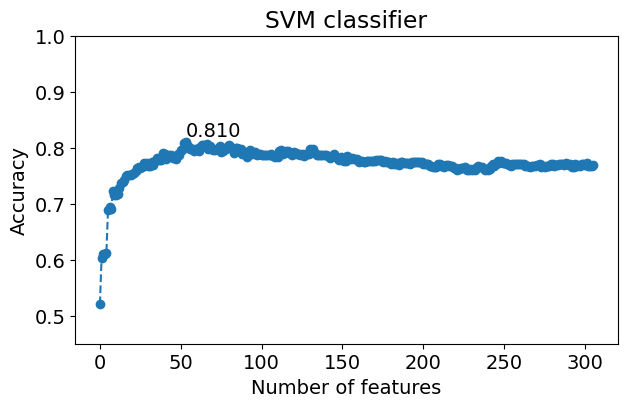

auc_best = 0.81049679
best auc (SVM) =  0.8104967948717949 Number of features =  53


In [5]:
emotions = ['happy', 'neutral', 'sad', 'calm', 'fear', 'disgust', 'surprised', 'angry']

for emotion_label in emotions:
    # Relabeling and normilizing
    y_true = np.zeros((len(y)))
    y_true[np.squeeze(y.values==emotion_label)] = 1
    y_true[y_true==0] = -1

    X_data = X.values
    X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
    y_reg = copy.copy(y_true)

    try:
        Rank_lasso = np.load(f'../../data/svm/Lasso_Ranking_SVM_rbf_{emotion_label}_result.npy')
    except:
        print("We need to compute LASSO ranking")

        # LASSO ranking
        Lasso_model = linear_model.Lasso()
        Npt = 200
        coeffs = np.zeros((X_norm.shape[1],Npt))
        lambda_ = np.logspace(-12.5, 0.3, Npt)
        i = 0
        for lamb in tqdm(lambda_):
            Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
            Lasso_model.fit(X_norm,y_reg)
            coeffs[:,i] = Lasso_model.coef_
            i = i + 1

        plt.figure(dpi=110)
        plt.plot(coeffs.T)
        plt.xlabel('$\lambda$ number')
        plt.ylabel('Coeffs')
        plt.show()    

        Rank_lasso = []
        for i in range(coeffs.shape[1]-1,-1,-1):
            withdraw_features = np.nonzero(coeffs[:,i])[0];
            something_new = np.setdiff1d(withdraw_features, Rank_lasso)
            if len(something_new):
                for ii in range(len(something_new)):
                    Rank_lasso.append(something_new[ii])
    
        np.save(f'../../data/svm/Lasso_Ranking_SVM_rbf_{emotion_label}_result.npy', Rank_lasso)    # .npy extension is added if not given
        Rank_lasso = np.load(f'../../data/svm/Lasso_Ranking_SVM_rbf_{emotion_label}_result.npy')

    # LOSO accuracy estimation
    try:
        feature_ind = np.load(f'../../data/svm/feature_SVM_rbf_idx_{emotion_label}.npy')
    except:
        print("We need to compute effective number of features")
        Rank = Rank_lasso
        auc_svm = []
        auc_best = 0
        ind_best = 0
        for k in tqdm(range(1,len(Rank)+1)):
            feature_inds = Rank[:k]
            auc,_,_,_,_ = SVM_RBF_eval(X,pd.DataFrame(y_reg), feature_inds, ID)    
            auc_svm.append(auc)
            if (auc>auc_best):
                auc_best = auc
                ind_best = k-1
                print('Iter = ', k, f' UAR = {auc:.4f}' )
        
        fig,ax=plt.subplots(figsize=(7,4),dpi=100)
        plt.rcParams.update({'font.size': 14})
        plt.plot(auc_svm,marker='o', linestyle='dashed')
        plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
        plt.xlabel('Number of features')
        plt.ylabel('Accuracy')
        plt.title('SVM classifier')
        plt.ylim([0.45, 1.00])
        plt.show()
        
        print(f'auc_best = {auc_best:.8f}')
        print('best auc (SVM) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

        # Backward step selection
        ind_best = np.argmax(auc_svm)
        [acc_final, feature_ind, y_pred, y_true] = back_step_selection_svm_rbf(X, y, Rank[:ind_best+1], ID)
        np.save(f'../../data/svm/feature_SVM_rbf_idx_{emotion_label}.npy', feature_ind)    # .npy extension is added if not given
        feature_ind = np.load(f'../../data/svm/feature_SVM_rbf_idx_{emotion_label}.npy')
    
    # Results of 5-fold CV (selected feature space)
    plotting_utils.plot_confusion_matrix_eng(y_true, y_pred,image_path=f'../../data/svm/confusion_matrix_SVM_rbf_{emotion_label}.jpg')




# 5-fold CV (full feature space)

In [6]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

C = 0.100000, gamma = 0.000316
C = 0.100000, gamma = 0.000527
C = 0.100000, gamma = 0.000880
C = 0.100000, gamma = 0.001468
C = 0.100000, gamma = 0.002448
C = 0.100000, gamma = 0.004084
C = 0.187382, gamma = 0.001468
C = 0.187382, gamma = 0.002448
C = 0.351119, gamma = 0.001468
C = 0.351119, gamma = 0.002448
C = 0.657933, gamma = 0.001468
C = 0.657933, gamma = 0.002448
C = 0.657933, gamma = 0.004084
C = 1.232847, gamma = 0.001468
C = 1.232847, gamma = 0.002448
C = 1.232847, gamma = 0.004084
C = 2.310130, gamma = 0.001468


ValueError: x and y must have same first dimension, but have shapes (12,) and (120,)

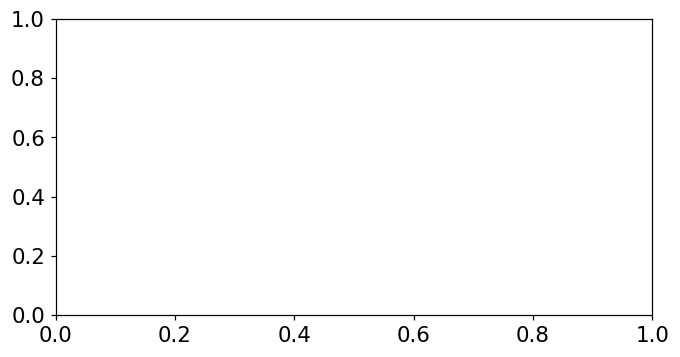

In [7]:
C = np.logspace(-1, 2, 12, endpoint=True)
gamma = np.logspace(-3.5, -1.5, 10, endpoint=True)

UAR_list = []
UAR_best = 0
for val_C in C:
    for val_gamma in gamma:
        model = SVC(kernel = 'rbf', C=val_C, gamma=val_gamma, random_state = 42)
        UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
        if UAR_best < UAR:
            UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
            C_best = val_C
            gamma_best = val_gamma
            print(f'UAR = {UAR_best:.3f}, C = {val_C:.6f}, gamma = {val_gamma:.6f}')
        UAR_list.append(UAR)
    
# fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# # plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
# # plt.ylim([0.37, 0.48])
# # plt.xlabel('$\log_{10}(C)$')
# plt.xlabel('$C$')
# plt.ylabel('UAR')
# plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
# plt.title('SVM with RBF kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')    

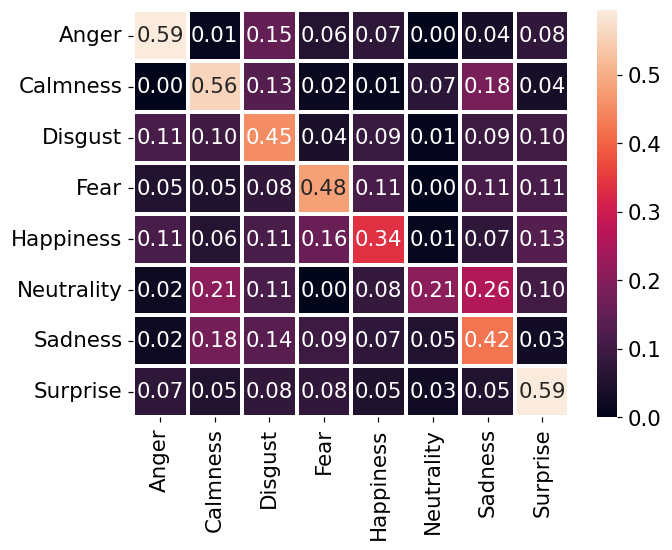

Saving confusion matrix with name:  confusion_matrix_SVM_full.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_full.jpg')

# Joint subset of features

In [15]:
emotions = ['happy', 'neutral', 'sad', 'calm', 'fear', 'disgust', 'surprised', 'angry']
feature_joint_inds = []

for emotion_label in emotions:
    feature_ind = np.load(f'../../data/svm/feature_SVM_idx_{emotion_label}.npy')
    feature_joint_inds = np.unique(np.concatenate((feature_joint_inds, feature_ind)))

feature_joint_inds = feature_joint_inds.astype(int)

In [16]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_joint_inds])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [21]:
X_new.shape

(1440, 208)

In [19]:
C = np.logspace(-1, 2, 12, endpoint=True)
gamma = np.logspace(-3.5, -1.5, 10, endpoint=True)

UAR_list = []
UAR_best = 0
for val_C in C:
    for val_gamma in gamma:
        model = SVC(kernel = 'rbf', C=val_C, gamma=val_gamma, random_state = 42)
        UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
        if UAR_best < UAR:
            UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
            C_best = val_C
            gamma_best = val_gamma
            print(f'C = {val_C:.6f}, gamma = {val_gamma:.6f}')
        UAR_list.append(UAR)
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}, gamma_best = {gamma_best: .3f}')        

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.86it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.81it/s]

UAR = 0.425


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.21it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.86it/s]

UAR = 0.447


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.21it/s]

UAR = 0.466


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.43it/s]

UAR = 0.473


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.42it/s]

UAR = 0.449


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.02it/s]

UAR = 0.450


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.10it/s]

UAR = 0.437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s]

UAR = 0.443
UAR_best = 0.473, C_best = 0.008


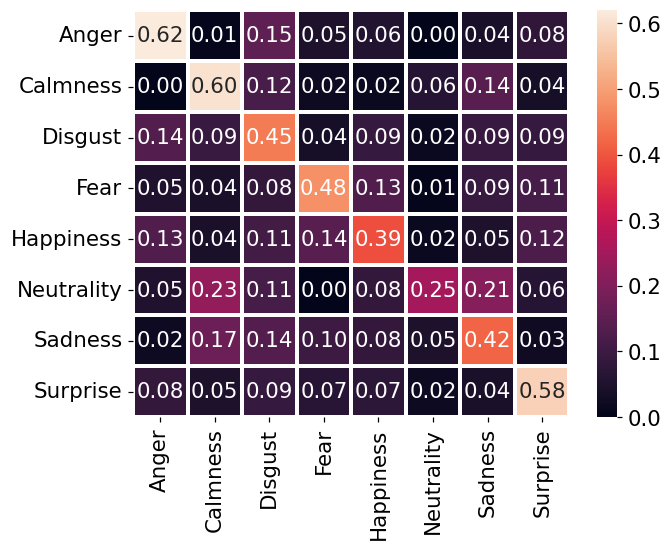

Saving confusion matrix with name:  confusion_matrix_SVM_joint_features.jpg


In [20]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_joint_features.jpg')